<font color = green >

# Neural machine translation

</font>



<font color = green >

##  Home task

</font>

Implement attention model to translate human readable dates e.g. "25th of June, 2009" into machine readable dates unified format like "2009-06-25".


In [1]:
from keras.layers import Bidirectional, Concatenate, Permute, Dot, Input, LSTM, Multiply
from keras.layers import RepeatVector, Dense, Activation, Lambda
from keras.optimizers import Adam
from keras.utils import to_categorical

from keras.models import load_model, Model
import keras.backend as K
import numpy as np

from faker import Faker
import random
from tqdm import tqdm
from babel.dates import format_date

import matplotlib.pyplot as plt
import os

%matplotlib inline


Using TensorFlow backend.


<font color = green >

###  Load dataset 

</font>

Dataset is 10000 human readable dates and their equivalent, standardized, machine readable dates.

In [2]:
def load_date():
    """
        Loads some fake dates
        :returns: tuple containing human readable string, machine readable string, and date object
    """
    FORMATS = ['short',
               'medium',
               'long',
               'full',
               'full',
               'full',
               'full',
               'full',
               'full',
               'full',
               'full',
               'full',
               'full',
               'd MMM YYY',
               'd MMMM YYY',
               'dd MMM YYY',
               'd MMM, YYY',
               'd MMMM, YYY',
               'dd, MMM YYY',
               'd MM YY',
               'd MMMM YYY',
               'MMMM d YYY',
               'MMMM d, YYY',
               'dd.MM.YY']

    try:
        dt = fake.date_object()
        human_readable = format_date(dt, format=random.choice(FORMATS),locale='en_US')  # locale=random.choice(LOCALES))
        human_readable = human_readable.lower()
        human_readable = human_readable.replace(',', '')
        machine_readable = dt.isoformat()

    except AttributeError as e:
        return None, None, None

    return human_readable, machine_readable, dt

fake = Faker()
fake.seed(12345)
random.seed(12345)


def load_dataset(m):
    """
        Loads a dataset with m examples and vocabularies
        :m: the number of examples to generate
    """
    print ('generating fake dates')

    human_vocab = set()
    machine_vocab = set()
    dataset = []

    for i in tqdm(range(m)):
        h, m, _ = load_date()
        if h is not None:
            dataset.append((h, m))
            human_vocab.update(tuple(h))
            machine_vocab.update(tuple(m))

    human = dict(zip(sorted(human_vocab) + ['<unk>', '<pad>'],
                     list(range(len(human_vocab) + 2))))
    inv_machine = dict(enumerate(sorted(machine_vocab)))
    machine = {v: k for k, v in inv_machine.items()}

    return dataset, human, machine, inv_machine



In [3]:
Tx = 30  # lets consider the max length of text format for date
Ty = 10  # lets consider the max length of unified format  e.g.  1995-01-26
m = 50000 # number of samples 
n_a = 32 # size of hidden layer 
# n_s = 64 # 


In [4]:
dataset, human_vocab, machine_vocab, inv_machine_vocab = load_dataset(m)

generating fake dates


100%|██████████| 50000/50000 [00:04<00:00, 12064.95it/s]


<font color = green >

###  Review dataset 

</font>


In [5]:
print ('human_vocab len = {:,}: \n {}'.format(len(human_vocab), human_vocab))
print ('machine_vocab len = {:,}: \n {}'.format(len(machine_vocab), machine_vocab))
print ('Samples:\n',dataset[:10])


human_vocab len = 37: 
 {' ': 0, '.': 1, '/': 2, '0': 3, '1': 4, '2': 5, '3': 6, '4': 7, '5': 8, '6': 9, '7': 10, '8': 11, '9': 12, 'a': 13, 'b': 14, 'c': 15, 'd': 16, 'e': 17, 'f': 18, 'g': 19, 'h': 20, 'i': 21, 'j': 22, 'l': 23, 'm': 24, 'n': 25, 'o': 26, 'p': 27, 'r': 28, 's': 29, 't': 30, 'u': 31, 'v': 32, 'w': 33, 'y': 34, '<unk>': 35, '<pad>': 36}
machine_vocab len = 11: 
 {'-': 0, '0': 1, '1': 2, '2': 3, '3': 4, '4': 5, '5': 6, '6': 7, '7': 8, '8': 9, '9': 10}
Samples:
 [('9 may 1998', '1998-05-09'), ('10.09.70', '1970-09-10'), ('4/28/90', '1990-04-28'), ('thursday january 26 1995', '1995-01-26'), ('monday march 7 1983', '1983-03-07'), ('sunday may 22 1988', '1988-05-22'), ('tuesday july 8 2008', '2008-07-08'), ('08 sep 1999', '1999-09-08'), ('1 jan 1981', '1981-01-01'), ('monday may 22 1995', '1995-05-22')]


<font color = green >

###  Convert to features vectors and to one-hot vectors 

</font>


In [6]:
def preprocess_data(dataset, human_vocab, machine_vocab, Tx, Ty):
    X, Y = zip(*dataset)

    X = np.array([string_to_int(i, Tx, human_vocab) for i in X])
    Y = [string_to_int(t, Ty, machine_vocab) for t in Y]

    Xoh = np.array(list(map(lambda x: to_categorical(x, num_classes=len(human_vocab)), X)))
    Yoh = np.array(list(map(lambda x: to_categorical(x, num_classes=len(machine_vocab)), Y)))

    return X, np.array(Y), Xoh, Yoh


def string_to_int(string, length, vocab):
    """
    Converts all strings in the vocabulary into a list of integers representing the positions of the
    input string's characters in the "vocab"

    Arguments:
    string -- input string, e.g. 'Wed 10 Jul 2007'
    length -- the number of time steps you'd like, determines if the output will be padded or cut
    vocab -- vocabulary, dictionary used to index every character of your "string"

    Returns:
    rep -- list of integers (or '<unk>') (size = length) representing the position of the string's character in the vocabulary
    """

    # make lower to standardize
    string = string.lower()
    string = string.replace(',', '')

    if len(string) > length:
        string = string[:length]

    rep = list(map(lambda x: vocab.get(x, '<unk>'), string))

    if len(string) < length:
        rep += [vocab['<pad>']] * (length - len(string))

    # print (rep)
    return rep

In [7]:
X, Y, Xoh, Yoh = preprocess_data(dataset, human_vocab, machine_vocab, Tx, Ty)

In [8]:
print("X.shape:", X.shape)
print("Y.shape:", Y.shape)
print("Xoh.shape:", Xoh.shape)
print("Yoh.shape:", Yoh.shape)

index = 0
print("\nSource date sample[{}]: {}".format(index,  dataset[index][0]))
print("Target date sample [{}]: {}".format(index,  dataset[index][1]))
print("\nX[{}] after preprocessing (indices): {}".format(index,  X[index]))
print("Y[{}] after preprocessing (indices): {}".format(index,  Y[index]))
print("\nXoh[{}] sample after converting to one-hot: {}".format(index, Xoh[index]))
print("Yoh[{}] after converting to one-hot: {}".format(index, Yoh[index]))



X.shape: (50000, 30)
Y.shape: (50000, 10)
Xoh.shape: (50000, 30, 37)
Yoh.shape: (50000, 10, 11)

Source date sample[0]: 9 may 1998
Target date sample [0]: 1998-05-09

X[0] after preprocessing (indices): [12  0 24 13 34  0  4 12 12 11 36 36 36 36 36 36 36 36 36 36 36 36 36 36
 36 36 36 36 36 36]
Y[0] after preprocessing (indices): [ 2 10 10  9  0  1  6  0  1 10]

Xoh[0] sample after converting to one-hot: [[0. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]]
Yoh[0] after converting to one-hot: [[0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]]


You now have:
- `X`: represntation of human readable dates where each character is replaced by index mapped to the character due to `human_vocab`. Each date is further padded to $T_x$ values with a special character (< pad >). `X.shape = (m, Tx)`
- `Y`: represntation of machine readable dates, where each character is replaced by the index it is mapped to in `machine_vocab`. You should have `Y.shape = (m, Ty)`. 
- `Xoh`: one-hot version of `X`, the "1" entry's index is mapped to the character thanks to `human_vocab`. `Xoh.shape = (m, Tx, len(human_vocab))`
- `Yoh`: one-hot version of `Y`, the "1" entry's index is mapped to the character thanks to `machine_vocab`. `Yoh.shape = (m, Tx, len(machine_vocab))`. Here, `len(machine_vocab) = 11` since there are 11 characters ('-' as well as 0-9). 


<font color = green >

###  Neural machine translation with attention

</font>


If you had to translate a book's paragraph from French to English, you would not read the whole paragraph, then close the book and translate. Even during the translation process, you would read/re-read and focus on the parts of the French paragraph corresponding to the parts of the English you are writing down. 

The attention mechanism tells a Neural Machine Translation model where it should pay attention to at any step. 

<font color = green >

###  Attention mechanism

</font>

The diagram on the left shows the attention model. The diagram on the right shows what one "Attention" step does to calculate the attention variables $\alpha^{\langle t, t' \rangle}$, which are used to compute the context variable $context^{\langle t \rangle}$ for each timestep in the output ($t=1, \ldots, T_y$). 

<table>
<td> 
<img src="img/lesson_22/attention_model.png" style="width:500;height:500px;"> <br>
</td> 
<td> 
<img src="img/lesson_22/attn_mechanism.png" style="width:500;height:500px;"> <br>
</td> 
</table>




Here are some properties of the model that you may notice: 

- There are two separate LSTMs in this model (see diagram on the left). Because the one at the bottom of the picture is a Bi-directional LSTM and comes *before* the attention mechanism, we will call it *pre-attention* Bi-LSTM. The LSTM at the top of the diagram comes *after* the attention mechanism, so we will call it the *post-attention* LSTM. The pre-attention Bi-LSTM goes through $T_x$ time steps; the post-attention LSTM goes through $T_y$ time steps. 

- The post-attention LSTM passes $s^{\langle t \rangle}, c^{\langle t \rangle}$ from one time step to the next. In the lecture videos, we were using only a basic RNN for the post-activation sequence model, so the state captured by the RNN output activations $s^{\langle t\rangle}$. But since we are using an LSTM here, the LSTM has both the output activation $s^{\langle t\rangle}$ and the hidden cell state $c^{\langle t\rangle}$. However, unlike previous text generation examples (such as Dinosaurus in week 1), in this model the post-activation LSTM at time $t$ does will not take the specific generated $y^{\langle t-1 \rangle}$ as input; it only takes $s^{\langle t\rangle}$ and $c^{\langle t\rangle}$ as input. We have designed the model this way, because (unlike language generation where adjacent characters are highly correlated) there isn't as strong a dependency between the previous character and the next character in a YYYY-MM-DD date. 

- We use $a^{\langle t \rangle} = [\overrightarrow{a}^{\langle t \rangle}; \overleftarrow{a}^{\langle t \rangle}]$ to represent the concatenation of the activations of both the forward-direction and backward-directions of the pre-attention Bi-LSTM. 

- The diagram on the right uses a `RepeatVector` node to copy $s^{\langle t-1 \rangle}$'s value $T_x$ times, and then `Concatenation` to concatenate $s^{\langle t-1 \rangle}$ and $a^{\langle t \rangle}$ to compute $e^{\langle t, t'}$, which is then passed through a softmax to compute $\alpha^{\langle t, t' \rangle}$. We'll explain how to use `RepeatVector` and `Concatenation` in Keras below. 

Lets implement this model. You will start by implementing two functions: `one_step_attention()` and `model()`.

**1) `one_step_attention()`**: At step $t$, given all the hidden states of the Bi-LSTM ($[a^{<1>},a^{<2>}, ..., a^{<T_x>}]$) and the previous hidden state of the second LSTM ($s^{<t-1>}$), `one_step_attention()` will compute the attention weights ($[\alpha^{<t,1>},\alpha^{<t,2>}, ..., \alpha^{<t,T_x>}]$) and output the context vector (see Figure  1 (right) for details):
$$context^{<t>} = \sum_{t' = 0}^{T_x} \alpha^{<t,t'>}a^{<t'>}\tag{1}$$ 

Note that we are denoting the attention in this notebook $context^{\langle t \rangle}$. In the lecture videos, the context was denoted $c^{\langle t \rangle}$, but here we are calling it $context^{\langle t \rangle}$ to avoid confusion with the (post-attention) LSTM's internal memory cell variable, which is sometimes also denoted $c^{\langle t \rangle}$. 
  
**2) `model()`**: Implements the entire model. It first runs the input through a Bi-LSTM to get back $[a^{<1>},a^{<2>}, ..., a^{<T_x>}]$. Then, it calls `one_step_attention()` $T_y$ times (`for` loop). At each iteration of this loop, it gives the computed context vector $c^{<t>}$ to the second LSTM, and runs the output of the LSTM through a dense layer with softmax activation to generate a prediction $\hat{y}^{<t>}$. 






<font color = green >

### Implement one_step_attention

</font>

The function `model()` will call the layers in `one_step_attention()` $T_y$ using a for-loop, and it is important that all $T_y$ copies have the same weights. I.e., it should not re-initiaiize the weights every time. In other words, all $T_y$ steps should have shared weights. Here's how you can implement layers with shareable weights in Keras:
1. Define the layer objects (as global variables).
2. Call these objects when propagating the input.


You may read keras documentation for target layers: 
[RepeatVector()](https://keras.io/layers/core/#repeatvector)
[Concatenate()](https://keras.io/layers/merge/#concatenate), 
[Dense()](https://keras.io/layers/core/#dense), 
[Activation()](https://keras.io/layers/core/#activation), 
[Dot()](https://keras.io/layers/merge/#dot).



In [9]:
def softmax(x, axis=1): # not sure why do we need custom implementation

    """Softmax activation function.
    # Arguments
        x : Tensor.
        axis: Integer, axis along which the softmax normalization is applied.
    # Returns
        Tensor, output of softmax transformation.
    # Raises
        ValueError: In case `dim(x) == 1`.
    """
    ndim = K.ndim(x)
    if ndim == 2:
        return K.softmax(x)
    elif ndim > 2:
        e = K.exp(x - K.max(x, axis=axis, keepdims=True))
        s = K.sum(e, axis=axis, keepdims=True)
        return e / s
    else:
        raise ValueError('Cannot apply softmax to a tensor that is 1D')

In [10]:
# Define layers as global variables
repeator = RepeatVector(Tx)
concatenator = Concatenate(axis=-1)
densor1 = Dense(10, activation = "tanh")
densor2 = Dense(1, activation = "relu")
activator = Activation(softmax, name='attention_weights') # We are using a custom softmax(axis = 1)
dotor = Dot(axes = 1)


Now you can use these layers to implement `one_step_attention()`. In order to propagate a Keras tensor object X through one of these layers, use `layer(X)` (or `layer([X,Y])` if it requires multiple inputs.), e.g. `densor(X)` will propagate X through the `Dense(1)` layer defined above.

In [11]:
def one_step_attention(a, s_prev):
    """
    Performs one step of attention: Outputs a context vector computed as a dot product of the attention weights
    "alphas" and the hidden states "a" of the Bi-LSTM.
    
    Arguments:
    a -- hidden state output of the Bi-LSTM, numpy-array of shape (m, Tx, 2*n_a)
    s_prev -- previous hidden state of the (post-attention) LSTM, numpy-array of shape (m, n_s)
    
    Returns:
    context -- context vector, input of the next (post-attetion) LSTM cell
    """

#     Tx=a.shape[1]
    # START CODE
    # Use repeator to repeat s_prev to be of shape (m, Tx, n_s) so that you can concatenate it with all hidden states "a" 
    s_prev = repeator(s_prev)
    # Use concatenator to concatenate a and s_prev on the last axis
    concat =  concatenator([a, s_prev])
    # Use densor1 to propagate concat through a small fully-connected neural network to compute the "intermediate energies" variable e. 
    e = densor1(concat)
    # Use densor2 to propagate e through a small fully-connected neural network to compute the "energies" variable energies. 
    energies = densor2(e)
    # Use "activator" on "energies" to compute the attention weights "alphas"
    alphas = activator(energies)
    # Use dotor together with "alphas" and "a" to compute the context vector to be given to the next (post-attention) LSTM-cell
    context = dotor([alphas, a])
    # END CODE
    return context



<font color = green >

### Implement model

</font>




In [12]:
n_a = 32
n_s = 64
post_activation_LSTM_cell = LSTM(n_s, return_state = True)
output_layer = Dense(len(machine_vocab), activation=softmax)

Now you can use these layers $T_y$ times in a `for` loop to generate the outputs, and their parameters will not be reinitialized. You will have to carry out the following steps: 

1. Propagate the input into a [Bidirectional](https://keras.io/layers/wrappers/#bidirectional) [LSTM](https://keras.io/layers/recurrent/#lstm)
2. Iterate for $t = 0, \dots, T_y-1$: 
    1. Call `one_step_attention()` on $[\alpha^{<t,1>},\alpha^{<t,2>}, ..., \alpha^{<t,T_x>}]$ and $s^{<t-1>}$ to get the context vector $context^{<t>}$.
    2. Give $context^{<t>}$ to the post-attention LSTM cell. Remember pass in the previous hidden-state $s^{\langle t-1\rangle}$ and cell-states $c^{\langle t-1\rangle}$ of this LSTM using `initial_state= [previous hidden state, previous cell state]`. Get back the new hidden state $s^{<t>}$ and the new cell state $c^{<t>}$.
    3. Apply a softmax layer to $s^{<t>}$, get the output. 
    4. Save the output by adding it to the list of outputs.

3. Create your Keras model instance, it should have three inputs ("inputs", $s^{<0>}$ and $c^{<0>}$) and output the list of "outputs".

In [13]:
def model(Tx, Ty, n_a, n_s, human_vocab_size, machine_vocab_size):
    """
    Arguments:
    Tx -- length of the input sequence
    Ty -- length of the output sequence
    n_a -- hidden state size of the Bi-LSTM
    n_s -- hidden state size of the post-attention LSTM
    human_vocab_size -- size of the python dictionary "human_vocab"
    machine_vocab_size -- size of the python dictionary "machine_vocab"

    Returns:
    model -- Keras model instance
    """
    
    # Define the inputs of your model with a shape (Tx,)
    # Define s0 and c0, initial hidden state for the decoder LSTM of shape (n_s,)
    X = Input(shape=(Tx, human_vocab_size))
    s0 = Input(shape=(n_s,), name='s0')
    c0 = Input(shape=(n_s,), name='c0')
    s = s0
    c = c0
    
    # Initialize empty list of outputs
    outputs = []
    
    # START CODE
    # Define your pre-attention Bi-LSTM. Remember to use return_sequences=True.
    a = Bidirectional(LSTM(n_a, return_sequences=True),input_shape=(m, Tx, n_a*2))(X)
    
    # Iterate for Ty steps
    for t in range(Ty):
    
        # Perform one step of the attention mechanism to get back the context vector at step t
        context = one_step_attention(a, s)
        
        # Apply the post-attention LSTM cell to the "context" vector.
        # Don't forget to pass: initial_state = [hidden state, cell state]
        s, _, c = post_activation_LSTM_cell(context,initial_state = [s, c] ) 
        
        # Apply Dense layer to the hidden state output of the post-attention LSTM
        out = output_layer(s)
        
        # Append "out" to the "outputs" list
        outputs.append(out)
    
    # Create model instance taking three inputs and returning the list of outputs.
    model =  Model(inputs=[X,s0,c0],outputs=outputs)
    # END CODE
    
    return model

Run the following cell to create your model.

In [14]:
model = model(Tx, Ty, n_a, n_s, len(human_vocab), len(machine_vocab))

Instructions for updating:
Colocations handled automatically by placer.


Let's get a summary of the model to check if it matches the expected output.

In [15]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 30, 37)       0                                            
__________________________________________________________________________________________________
s0 (InputLayer)                 (None, 64)           0                                            
__________________________________________________________________________________________________
bidirectional_1 (Bidirectional) (None, 30, 64)       17920       input_1[0][0]                    
__________________________________________________________________________________________________
repeat_vector_1 (RepeatVector)  (None, 30, 64)       0           s0[0][0]                         
                                                                 lstm_1[0][0]                     
          

                                                                 attention_weights[4][0]          
                                                                 bidirectional_1[0][0]            
                                                                 attention_weights[5][0]          
                                                                 bidirectional_1[0][0]            
                                                                 attention_weights[6][0]          
                                                                 bidirectional_1[0][0]            
                                                                 attention_weights[7][0]          
                                                                 bidirectional_1[0][0]            
                                                                 attention_weights[8][0]          
                                                                 bidirectional_1[0][0]            
          


<font color = blue >

### Expected result

</font>


<table>
    <tr>
        <td>
            **Total params:**
        </td>
        <td>
         52,960
        </td>
    </tr>
        <tr>
        <td>
            **Trainable params:**
        </td>
        <td>
         52,960
        </td>
    </tr>
            <tr>
        <td>
            **Non-trainable params:**
        </td>
        <td>
         0
        </td>
    </tr>
                    <tr>
        <td>
            **bidirectional_1's output shape **
        </td>
        <td>
         (None, 30, 64)  
        </td>
    </tr>
    <tr>
        <td>
            **repeat_vector_1's output shape **
        </td>
        <td>
         (None, 30, 64) 
        </td>
    </tr>
                <tr>
        <td>
            **concatenate_1's output shape **
        </td>
        <td>
         (None, 30, 128) 
        </td>
    </tr>
            <tr>
        <td>
            **attention_weights's output shape **
        </td>
        <td>
         (None, 30, 1)  
        </td>
    </tr>
        <tr>
        <td>
            **dot_1's output shape **
        </td>
        <td>
         (None, 1, 64)
        </td>
    </tr>
           <tr>
        <td>
            **dense_3's output shape **
        </td>
        <td>
         (None, 11) 
        </td>
    </tr>
</table>



<font color = green >

### Setup optimizer

</font>




After creating your model in Keras, you need to compile it and define what loss, optimizer and metrics your are want to use. Compile your model using `categorical_crossentropy` loss, a custom [Adam](https://keras.io/optimizers/#adam) [optimizer](https://keras.io/optimizers/#usage-of-optimizers) (`learning rate = 0.005`, $\beta_1 = 0.9$, $\beta_2 = 0.999$, `decay = 0.01`)  and `['accuracy']` metrics:

In [16]:
# START CODE

# Setup optimizer 
opt = Adam(lr=0.005, beta_1=0.9, beta_2=0.999,decay=0.01) 

# Compile model 
model.compile(loss='categorical_crossentropy', optimizer=opt,metrics=['accuracy'])

# END CODE

The last step is to define all your inputs and outputs to fit the model:
- You already have X of shape $(m = 10000, T_x = 30)$ containing the training examples.
- You need to create `s0` and `c0` to initialize your `post_activation_LSTM_cell` with 0s.
- Given the `model()` you coded, you need the "outputs" to be a list of 11 elements of shape (m, T_y). So that: `outputs[i][0], ..., outputs[i][Ty]` represent the true labels (characters) corresponding to the $i^{th}$ training example (`X[i]`). More generally, `outputs[i][j]` is the true label of the $j^{th}$ character in the $i^{th}$ training example.

In [17]:
s0 = np.zeros((m, n_s))
c0 = np.zeros((m, n_s))
outputs = list(Yoh.swapaxes(0,1))


<font color = green >

### Run training 

</font>




Let's now fit the model and run it for one epoch.

In [18]:
model.fit([Xoh, s0, c0], outputs, epochs=20, batch_size=100)

Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
Epoch 1/20


 2800/50000 [>.............................] - ETA: 6:27:36 - loss: 23.9934 - dense_3_loss: 2.3985 - dense_3_acc: 0.0000e+00 - dense_3_acc_1: 0.0000e+00 - dense_3_acc_2: 0.0000e+00 - dense_3_acc_3: 0.0600 - dense_3_acc_4: 0.0000e+00 - dense_3_acc_5: 0.0000e+00 - dense_3_acc_6: 0.0700 - dense_3_acc_7: 0.0000e+00 - dense_3_acc_8: 0.0000e+00 - dense_3_acc_9: 0.12 - ETA: 3:15:05 - loss: 23.7763 - dense_3_loss: 2.4094 - dense_3_acc: 0.0000e+00 - dense_3_acc_1: 0.0500 - dense_3_acc_2: 0.0300 - dense_3_acc_3: 0.0350 - dense_3_acc_4: 0.4750 - dense_3_acc_5: 0.0100 - dense_3_acc_6: 0.0350 - dense_3_acc_7: 0.4800 - dense_3_acc_8: 0.0050 - dense_3_acc_9: 0.0650                       - ETA: 2:10:42 - loss: 23.5732 - dense_3_loss: 2.4280 - dense_3_acc: 0.0000e+00 - dense_3_acc_1: 0.0367 - dense_3_acc_2: 0.0200 - dense_3_acc_3: 0.0233 - dense_3_acc_4: 0.6500 - dense_3_acc_5: 0.0067 - dense_3_acc_6: 0.0233 - dense_3_acc_7: 0.6533 - dense_3_acc_8: 0.0033 - dense_3_acc_9: 0.04 - ETA: 1:38:34 - loss: 23

 5700/50000 [==>...........................] - ETA: 15:18 - loss: 21.4422 - dense_3_loss: 2.8260 - dense_3_acc: 0.1376 - dense_3_acc_1: 0.1831 - dense_3_acc_2: 0.1038 - dense_3_acc_3: 0.0241 - dense_3_acc_4: 0.8455 - dense_3_acc_5: 0.0734 - dense_3_acc_6: 0.0148 - dense_3_acc_7: 0.8603 - dense_3_acc_8: 0.0331 - dense_3_acc_9: 0.01 - ETA: 14:51 - loss: 21.3865 - dense_3_loss: 2.8227 - dense_3_acc: 0.1330 - dense_3_acc_1: 0.1987 - dense_3_acc_2: 0.1073 - dense_3_acc_3: 0.0250 - dense_3_acc_4: 0.8507 - dense_3_acc_5: 0.0710 - dense_3_acc_6: 0.0143 - dense_3_acc_7: 0.8650 - dense_3_acc_8: 0.0320 - dense_3_acc_9: 0.01 - ETA: 14:26 - loss: 21.3360 - dense_3_loss: 2.8234 - dense_3_acc: 0.1287 - dense_3_acc_1: 0.2135 - dense_3_acc_2: 0.1084 - dense_3_acc_3: 0.0242 - dense_3_acc_4: 0.8555 - dense_3_acc_5: 0.0687 - dense_3_acc_6: 0.0139 - dense_3_acc_7: 0.8694 - dense_3_acc_8: 0.0310 - dense_3_acc_9: 0.01 - ETA: 14:02 - loss: 21.2864 - dense_3_loss: 2.8252 - dense_3_acc: 0.1247 - dense_3_acc_1: 

 8600/50000 [====>.........................] - ETA: 8:39 - loss: 19.8553 - dense_3_loss: 2.8111 - dense_3_acc: 0.2929 - dense_3_acc_1: 0.4179 - dense_3_acc_2: 0.2012 - dense_3_acc_3: 0.0298 - dense_3_acc_4: 0.9228 - dense_3_acc_5: 0.0509 - dense_3_acc_6: 0.0140 - dense_3_acc_7: 0.8391 - dense_3_acc_8: 0.0945 - dense_3_acc_9: 0.056 - ETA: 8:31 - loss: 19.7933 - dense_3_loss: 2.8057 - dense_3_acc: 0.2990 - dense_3_acc_1: 0.4253 - dense_3_acc_2: 0.2036 - dense_3_acc_3: 0.0298 - dense_3_acc_4: 0.9241 - dense_3_acc_5: 0.0573 - dense_3_acc_6: 0.0144 - dense_3_acc_7: 0.8381 - dense_3_acc_8: 0.0990 - dense_3_acc_9: 0.058 - ETA: 8:24 - loss: 19.7333 - dense_3_loss: 2.8039 - dense_3_acc: 0.3045 - dense_3_acc_1: 0.4325 - dense_3_acc_2: 0.2060 - dense_3_acc_3: 0.0293 - dense_3_acc_4: 0.9253 - dense_3_acc_5: 0.0672 - dense_3_acc_6: 0.0150 - dense_3_acc_7: 0.8400 - dense_3_acc_8: 0.1037 - dense_3_acc_9: 0.060 - ETA: 8:17 - loss: 19.6698 - dense_3_loss: 2.8045 - dense_3_acc: 0.3087 - dense_3_acc_1: 0

11500/50000 [=====>........................] - ETA: 6:25 - loss: 17.7229 - dense_3_loss: 2.6885 - dense_3_acc: 0.4234 - dense_3_acc_1: 0.5770 - dense_3_acc_2: 0.2645 - dense_3_acc_3: 0.0480 - dense_3_acc_4: 0.9485 - dense_3_acc_5: 0.2697 - dense_3_acc_6: 0.0386 - dense_3_acc_7: 0.8897 - dense_3_acc_8: 0.1894 - dense_3_acc_9: 0.083 - ETA: 6:22 - loss: 17.6530 - dense_3_loss: 2.6843 - dense_3_acc: 0.4291 - dense_3_acc_1: 0.5807 - dense_3_acc_2: 0.2666 - dense_3_acc_3: 0.0482 - dense_3_acc_4: 0.9491 - dense_3_acc_5: 0.2763 - dense_3_acc_6: 0.0399 - dense_3_acc_7: 0.8909 - dense_3_acc_8: 0.1915 - dense_3_acc_9: 0.083 - ETA: 6:18 - loss: 17.5792 - dense_3_loss: 2.6802 - dense_3_acc: 0.4353 - dense_3_acc_1: 0.5848 - dense_3_acc_2: 0.2696 - dense_3_acc_3: 0.0490 - dense_3_acc_4: 0.9497 - dense_3_acc_5: 0.2830 - dense_3_acc_6: 0.0421 - dense_3_acc_7: 0.8921 - dense_3_acc_8: 0.1930 - dense_3_acc_9: 0.083 - ETA: 6:15 - loss: 17.5120 - dense_3_loss: 2.6767 - dense_3_acc: 0.4394 - dense_3_acc_1: 0

14400/50000 [=======>......................] - ETA: 5:12 - loss: 15.9548 - dense_3_loss: 2.5904 - dense_3_acc: 0.5402 - dense_3_acc_1: 0.6702 - dense_3_acc_2: 0.3173 - dense_3_acc_3: 0.0709 - dense_3_acc_4: 0.9614 - dense_3_acc_5: 0.3997 - dense_3_acc_6: 0.0717 - dense_3_acc_7: 0.9172 - dense_3_acc_8: 0.2422 - dense_3_acc_9: 0.095 - ETA: 5:10 - loss: 15.9050 - dense_3_loss: 2.5883 - dense_3_acc: 0.5434 - dense_3_acc_1: 0.6726 - dense_3_acc_2: 0.3192 - dense_3_acc_3: 0.0715 - dense_3_acc_4: 0.9617 - dense_3_acc_5: 0.4040 - dense_3_acc_6: 0.0730 - dense_3_acc_7: 0.9179 - dense_3_acc_8: 0.2447 - dense_3_acc_9: 0.095 - ETA: 5:10 - loss: 15.8545 - dense_3_loss: 2.5858 - dense_3_acc: 0.5464 - dense_3_acc_1: 0.6752 - dense_3_acc_2: 0.3212 - dense_3_acc_3: 0.0721 - dense_3_acc_4: 0.9620 - dense_3_acc_5: 0.4072 - dense_3_acc_6: 0.0746 - dense_3_acc_7: 0.9186 - dense_3_acc_8: 0.2466 - dense_3_acc_9: 0.096 - ETA: 5:08 - loss: 15.8055 - dense_3_loss: 2.5829 - dense_3_acc: 0.5498 - dense_3_acc_1: 0

17300/50000 [=========>....................] - ETA: 4:22 - loss: 14.7310 - dense_3_loss: 2.5240 - dense_3_acc: 0.6230 - dense_3_acc_1: 0.7294 - dense_3_acc_2: 0.3614 - dense_3_acc_3: 0.0909 - dense_3_acc_4: 0.9691 - dense_3_acc_5: 0.4830 - dense_3_acc_6: 0.1070 - dense_3_acc_7: 0.9338 - dense_3_acc_8: 0.2817 - dense_3_acc_9: 0.109 - ETA: 4:21 - loss: 14.6950 - dense_3_loss: 2.5217 - dense_3_acc: 0.6251 - dense_3_acc_1: 0.7310 - dense_3_acc_2: 0.3626 - dense_3_acc_3: 0.0916 - dense_3_acc_4: 0.9693 - dense_3_acc_5: 0.4858 - dense_3_acc_6: 0.1080 - dense_3_acc_7: 0.9342 - dense_3_acc_8: 0.2832 - dense_3_acc_9: 0.109 - ETA: 4:22 - loss: 14.6614 - dense_3_loss: 2.5202 - dense_3_acc: 0.6269 - dense_3_acc_1: 0.7323 - dense_3_acc_2: 0.3642 - dense_3_acc_3: 0.0922 - dense_3_acc_4: 0.9695 - dense_3_acc_5: 0.4884 - dense_3_acc_6: 0.1087 - dense_3_acc_7: 0.9347 - dense_3_acc_8: 0.2839 - dense_3_acc_9: 0.109 - ETA: 4:21 - loss: 14.6263 - dense_3_loss: 2.5181 - dense_3_acc: 0.6291 - dense_3_acc_1: 0

20200/50000 [===========>..................] - ETA: 3:41 - loss: 13.8421 - dense_3_loss: 2.4737 - dense_3_acc: 0.6783 - dense_3_acc_1: 0.7685 - dense_3_acc_2: 0.4006 - dense_3_acc_3: 0.1051 - dense_3_acc_4: 0.9743 - dense_3_acc_5: 0.5453 - dense_3_acc_6: 0.1341 - dense_3_acc_7: 0.9448 - dense_3_acc_8: 0.3132 - dense_3_acc_9: 0.122 - ETA: 3:40 - loss: 13.8141 - dense_3_loss: 2.4720 - dense_3_acc: 0.6801 - dense_3_acc_1: 0.7698 - dense_3_acc_2: 0.4021 - dense_3_acc_3: 0.1054 - dense_3_acc_4: 0.9744 - dense_3_acc_5: 0.5471 - dense_3_acc_6: 0.1350 - dense_3_acc_7: 0.9451 - dense_3_acc_8: 0.3140 - dense_3_acc_9: 0.122 - ETA: 3:38 - loss: 13.7862 - dense_3_loss: 2.4703 - dense_3_acc: 0.6818 - dense_3_acc_1: 0.7710 - dense_3_acc_2: 0.4037 - dense_3_acc_3: 0.1057 - dense_3_acc_4: 0.9745 - dense_3_acc_5: 0.5489 - dense_3_acc_6: 0.1361 - dense_3_acc_7: 0.9455 - dense_3_acc_8: 0.3153 - dense_3_acc_9: 0.122 - ETA: 3:37 - loss: 13.7589 - dense_3_loss: 2.4686 - dense_3_acc: 0.6832 - dense_3_acc_1: 0

23100/50000 [============>.................] - ETA: 3:05 - loss: 13.1389 - dense_3_loss: 2.4342 - dense_3_acc: 0.7201 - dense_3_acc_1: 0.7976 - dense_3_acc_2: 0.4356 - dense_3_acc_3: 0.1206 - dense_3_acc_4: 0.9779 - dense_3_acc_5: 0.5946 - dense_3_acc_6: 0.1567 - dense_3_acc_7: 0.9527 - dense_3_acc_8: 0.3378 - dense_3_acc_9: 0.131 - ETA: 3:04 - loss: 13.1175 - dense_3_loss: 2.4328 - dense_3_acc: 0.7213 - dense_3_acc_1: 0.7985 - dense_3_acc_2: 0.4367 - dense_3_acc_3: 0.1213 - dense_3_acc_4: 0.9780 - dense_3_acc_5: 0.5960 - dense_3_acc_6: 0.1574 - dense_3_acc_7: 0.9529 - dense_3_acc_8: 0.3386 - dense_3_acc_9: 0.131 - ETA: 3:03 - loss: 13.0967 - dense_3_loss: 2.4318 - dense_3_acc: 0.7224 - dense_3_acc_1: 0.7993 - dense_3_acc_2: 0.4376 - dense_3_acc_3: 0.1218 - dense_3_acc_4: 0.9781 - dense_3_acc_5: 0.5978 - dense_3_acc_6: 0.1582 - dense_3_acc_7: 0.9532 - dense_3_acc_8: 0.3390 - dense_3_acc_9: 0.131 - ETA: 3:01 - loss: 13.0764 - dense_3_loss: 2.4305 - dense_3_acc: 0.7236 - dense_3_acc_1: 0

26000/50000 [==============>...............] - ETA: 2:37 - loss: 12.5724 - dense_3_loss: 2.3999 - dense_3_acc: 0.7506 - dense_3_acc_1: 0.8191 - dense_3_acc_2: 0.4654 - dense_3_acc_3: 0.1342 - dense_3_acc_4: 0.9807 - dense_3_acc_5: 0.6353 - dense_3_acc_6: 0.1782 - dense_3_acc_7: 0.9586 - dense_3_acc_8: 0.3575 - dense_3_acc_9: 0.140 - ETA: 2:36 - loss: 12.5540 - dense_3_loss: 2.3988 - dense_3_acc: 0.7517 - dense_3_acc_1: 0.8198 - dense_3_acc_2: 0.4669 - dense_3_acc_3: 0.1347 - dense_3_acc_4: 0.9808 - dense_3_acc_5: 0.6366 - dense_3_acc_6: 0.1792 - dense_3_acc_7: 0.9588 - dense_3_acc_8: 0.3580 - dense_3_acc_9: 0.140 - ETA: 2:35 - loss: 12.5375 - dense_3_loss: 2.3977 - dense_3_acc: 0.7525 - dense_3_acc_1: 0.8203 - dense_3_acc_2: 0.4679 - dense_3_acc_3: 0.1355 - dense_3_acc_4: 0.9809 - dense_3_acc_5: 0.6379 - dense_3_acc_6: 0.1797 - dense_3_acc_7: 0.9590 - dense_3_acc_8: 0.3584 - dense_3_acc_9: 0.141 - ETA: 2:34 - loss: 12.5186 - dense_3_loss: 2.3963 - dense_3_acc: 0.7535 - dense_3_acc_1: 0

28900/50000 [================>.............] - ETA: 2:14 - loss: 12.0870 - dense_3_loss: 2.3681 - dense_3_acc: 0.7754 - dense_3_acc_1: 0.8362 - dense_3_acc_2: 0.4947 - dense_3_acc_3: 0.1499 - dense_3_acc_4: 0.9828 - dense_3_acc_5: 0.6682 - dense_3_acc_6: 0.2007 - dense_3_acc_7: 0.9632 - dense_3_acc_8: 0.3752 - dense_3_acc_9: 0.149 - ETA: 2:13 - loss: 12.0711 - dense_3_loss: 2.3667 - dense_3_acc: 0.7762 - dense_3_acc_1: 0.8369 - dense_3_acc_2: 0.4955 - dense_3_acc_3: 0.1503 - dense_3_acc_4: 0.9829 - dense_3_acc_5: 0.6693 - dense_3_acc_6: 0.2015 - dense_3_acc_7: 0.9634 - dense_3_acc_8: 0.3762 - dense_3_acc_9: 0.149 - ETA: 2:12 - loss: 12.0560 - dense_3_loss: 2.3658 - dense_3_acc: 0.7770 - dense_3_acc_1: 0.8374 - dense_3_acc_2: 0.4965 - dense_3_acc_3: 0.1507 - dense_3_acc_4: 0.9830 - dense_3_acc_5: 0.6703 - dense_3_acc_6: 0.2025 - dense_3_acc_7: 0.9635 - dense_3_acc_8: 0.3765 - dense_3_acc_9: 0.149 - ETA: 2:11 - loss: 12.0410 - dense_3_loss: 2.3646 - dense_3_acc: 0.7777 - dense_3_acc_1: 0

31800/50000 [==================>...........] - ETA: 1:59 - loss: 11.6684 - dense_3_loss: 2.3376 - dense_3_acc: 0.7950 - dense_3_acc_1: 0.8505 - dense_3_acc_2: 0.5188 - dense_3_acc_3: 0.1646 - dense_3_acc_4: 0.9846 - dense_3_acc_5: 0.6967 - dense_3_acc_6: 0.2220 - dense_3_acc_7: 0.9669 - dense_3_acc_8: 0.3903 - dense_3_acc_9: 0.157 - ETA: 1:58 - loss: 11.6552 - dense_3_loss: 2.3368 - dense_3_acc: 0.7957 - dense_3_acc_1: 0.8510 - dense_3_acc_2: 0.5196 - dense_3_acc_3: 0.1652 - dense_3_acc_4: 0.9846 - dense_3_acc_5: 0.6974 - dense_3_acc_6: 0.2226 - dense_3_acc_7: 0.9670 - dense_3_acc_8: 0.3909 - dense_3_acc_9: 0.157 - ETA: 1:58 - loss: 11.6413 - dense_3_loss: 2.3359 - dense_3_acc: 0.7962 - dense_3_acc_1: 0.8514 - dense_3_acc_2: 0.5204 - dense_3_acc_3: 0.1655 - dense_3_acc_4: 0.9847 - dense_3_acc_5: 0.6983 - dense_3_acc_6: 0.2233 - dense_3_acc_7: 0.9671 - dense_3_acc_8: 0.3919 - dense_3_acc_9: 0.158 - ETA: 1:57 - loss: 11.6286 - dense_3_loss: 2.3353 - dense_3_acc: 0.7968 - dense_3_acc_1: 0

34700/50000 [===================>..........] - ETA: 1:42 - loss: 11.2983 - dense_3_loss: 2.3075 - dense_3_acc: 0.8114 - dense_3_acc_1: 0.8618 - dense_3_acc_2: 0.5411 - dense_3_acc_3: 0.1784 - dense_3_acc_4: 0.9860 - dense_3_acc_5: 0.7195 - dense_3_acc_6: 0.2406 - dense_3_acc_7: 0.9699 - dense_3_acc_8: 0.4039 - dense_3_acc_9: 0.166 - ETA: 1:41 - loss: 11.2862 - dense_3_loss: 2.3069 - dense_3_acc: 0.8120 - dense_3_acc_1: 0.8622 - dense_3_acc_2: 0.5418 - dense_3_acc_3: 0.1789 - dense_3_acc_4: 0.9860 - dense_3_acc_5: 0.7203 - dense_3_acc_6: 0.2412 - dense_3_acc_7: 0.9700 - dense_3_acc_8: 0.4046 - dense_3_acc_9: 0.166 - ETA: 1:41 - loss: 11.2738 - dense_3_loss: 2.3058 - dense_3_acc: 0.8125 - dense_3_acc_1: 0.8625 - dense_3_acc_2: 0.5425 - dense_3_acc_3: 0.1793 - dense_3_acc_4: 0.9860 - dense_3_acc_5: 0.7211 - dense_3_acc_6: 0.2419 - dense_3_acc_7: 0.9701 - dense_3_acc_8: 0.4051 - dense_3_acc_9: 0.167 - ETA: 1:40 - loss: 11.2624 - dense_3_loss: 2.3048 - dense_3_acc: 0.8131 - dense_3_acc_1: 0

37600/50000 [=====================>........] - ETA: 1:24 - loss: 10.9733 - dense_3_loss: 2.2783 - dense_3_acc: 0.8253 - dense_3_acc_1: 0.8716 - dense_3_acc_2: 0.5597 - dense_3_acc_3: 0.1904 - dense_3_acc_4: 0.9871 - dense_3_acc_5: 0.7394 - dense_3_acc_6: 0.2577 - dense_3_acc_7: 0.9724 - dense_3_acc_8: 0.4156 - dense_3_acc_9: 0.174 - ETA: 1:23 - loss: 10.9624 - dense_3_loss: 2.2773 - dense_3_acc: 0.8257 - dense_3_acc_1: 0.8719 - dense_3_acc_2: 0.5603 - dense_3_acc_3: 0.1910 - dense_3_acc_4: 0.9872 - dense_3_acc_5: 0.7399 - dense_3_acc_6: 0.2583 - dense_3_acc_7: 0.9725 - dense_3_acc_8: 0.4160 - dense_3_acc_9: 0.174 - ETA: 1:22 - loss: 10.9520 - dense_3_loss: 2.2760 - dense_3_acc: 0.8261 - dense_3_acc_1: 0.8721 - dense_3_acc_2: 0.5609 - dense_3_acc_3: 0.1915 - dense_3_acc_4: 0.9872 - dense_3_acc_5: 0.7406 - dense_3_acc_6: 0.2586 - dense_3_acc_7: 0.9726 - dense_3_acc_8: 0.4163 - dense_3_acc_9: 0.175 - ETA: 1:22 - loss: 10.9412 - dense_3_loss: 2.2751 - dense_3_acc: 0.8265 - dense_3_acc_1: 0

40500/50000 [=======================>......] - ETA: 1:07 - loss: 10.6823 - dense_3_loss: 2.2536 - dense_3_acc: 0.8369 - dense_3_acc_1: 0.8798 - dense_3_acc_2: 0.5761 - dense_3_acc_3: 0.2027 - dense_3_acc_4: 0.9881 - dense_3_acc_5: 0.7564 - dense_3_acc_6: 0.2733 - dense_3_acc_7: 0.9745 - dense_3_acc_8: 0.4259 - dense_3_acc_9: 0.181 - ETA: 1:06 - loss: 10.6729 - dense_3_loss: 2.2529 - dense_3_acc: 0.8372 - dense_3_acc_1: 0.8801 - dense_3_acc_2: 0.5767 - dense_3_acc_3: 0.2031 - dense_3_acc_4: 0.9881 - dense_3_acc_5: 0.7569 - dense_3_acc_6: 0.2739 - dense_3_acc_7: 0.9746 - dense_3_acc_8: 0.4263 - dense_3_acc_9: 0.181 - ETA: 1:06 - loss: 10.6638 - dense_3_loss: 2.2520 - dense_3_acc: 0.8376 - dense_3_acc_1: 0.8803 - dense_3_acc_2: 0.5772 - dense_3_acc_3: 0.2037 - dense_3_acc_4: 0.9882 - dense_3_acc_5: 0.7574 - dense_3_acc_6: 0.2744 - dense_3_acc_7: 0.9747 - dense_3_acc_8: 0.4265 - dense_3_acc_9: 0.181 - ETA: 1:05 - loss: 10.6543 - dense_3_loss: 2.2511 - dense_3_acc: 0.8379 - dense_3_acc_1: 0

43400/50000 [=========================>....] - ETA: 50s - loss: 10.4231 - dense_3_loss: 2.2299 - dense_3_acc: 0.8464 - dense_3_acc_1: 0.8867 - dense_3_acc_2: 0.5912 - dense_3_acc_3: 0.2145 - dense_3_acc_4: 0.9890 - dense_3_acc_5: 0.7708 - dense_3_acc_6: 0.2877 - dense_3_acc_7: 0.9764 - dense_3_acc_8: 0.4359 - dense_3_acc_9: 0.18 - ETA: 50s - loss: 10.4148 - dense_3_loss: 2.2292 - dense_3_acc: 0.8468 - dense_3_acc_1: 0.8869 - dense_3_acc_2: 0.5917 - dense_3_acc_3: 0.2147 - dense_3_acc_4: 0.9890 - dense_3_acc_5: 0.7713 - dense_3_acc_6: 0.2882 - dense_3_acc_7: 0.9764 - dense_3_acc_8: 0.4362 - dense_3_acc_9: 0.18 - ETA: 49s - loss: 10.4058 - dense_3_loss: 2.2281 - dense_3_acc: 0.8471 - dense_3_acc_1: 0.8871 - dense_3_acc_2: 0.5921 - dense_3_acc_3: 0.2152 - dense_3_acc_4: 0.9890 - dense_3_acc_5: 0.7718 - dense_3_acc_6: 0.2887 - dense_3_acc_7: 0.9765 - dense_3_acc_8: 0.4367 - dense_3_acc_9: 0.18 - ETA: 49s - loss: 10.3975 - dense_3_loss: 2.2273 - dense_3_acc: 0.8474 - dense_3_acc_1: 0.8874 -

46300/50000 [==========================>...] - ETA: 34s - loss: 10.1882 - dense_3_loss: 2.2076 - dense_3_acc: 0.8554 - dense_3_acc_1: 0.8930 - dense_3_acc_2: 0.6036 - dense_3_acc_3: 0.2255 - dense_3_acc_4: 0.9897 - dense_3_acc_5: 0.7840 - dense_3_acc_6: 0.3000 - dense_3_acc_7: 0.9779 - dense_3_acc_8: 0.4445 - dense_3_acc_9: 0.19 - ETA: 33s - loss: 10.1806 - dense_3_loss: 2.2070 - dense_3_acc: 0.8557 - dense_3_acc_1: 0.8932 - dense_3_acc_2: 0.6039 - dense_3_acc_3: 0.2257 - dense_3_acc_4: 0.9897 - dense_3_acc_5: 0.7845 - dense_3_acc_6: 0.3005 - dense_3_acc_7: 0.9780 - dense_3_acc_8: 0.4447 - dense_3_acc_9: 0.19 - ETA: 33s - loss: 10.1727 - dense_3_loss: 2.2065 - dense_3_acc: 0.8559 - dense_3_acc_1: 0.8933 - dense_3_acc_2: 0.6043 - dense_3_acc_3: 0.2262 - dense_3_acc_4: 0.9897 - dense_3_acc_5: 0.7849 - dense_3_acc_6: 0.3011 - dense_3_acc_7: 0.9780 - dense_3_acc_8: 0.4449 - dense_3_acc_9: 0.19 - ETA: 32s - loss: 10.1652 - dense_3_loss: 2.2058 - dense_3_acc: 0.8562 - dense_3_acc_1: 0.8935 -

49200/50000 [============================>.] - ETA: 19s - loss: 9.9700 - dense_3_loss: 2.1885 - dense_3_acc: 0.8632 - dense_3_acc_1: 0.8986 - dense_3_acc_2: 0.6147 - dense_3_acc_3: 0.2360 - dense_3_acc_4: 0.9903 - dense_3_acc_5: 0.7953 - dense_3_acc_6: 0.3123 - dense_3_acc_7: 0.9793 - dense_3_acc_8: 0.4545 - dense_3_acc_9: 0.200 - ETA: 18s - loss: 9.9629 - dense_3_loss: 2.1880 - dense_3_acc: 0.8634 - dense_3_acc_1: 0.8987 - dense_3_acc_2: 0.6150 - dense_3_acc_3: 0.2365 - dense_3_acc_4: 0.9904 - dense_3_acc_5: 0.7957 - dense_3_acc_6: 0.3125 - dense_3_acc_7: 0.9794 - dense_3_acc_8: 0.4549 - dense_3_acc_9: 0.200 - ETA: 17s - loss: 9.9555 - dense_3_loss: 2.1871 - dense_3_acc: 0.8637 - dense_3_acc_1: 0.8989 - dense_3_acc_2: 0.6152 - dense_3_acc_3: 0.2370 - dense_3_acc_4: 0.9904 - dense_3_acc_5: 0.7960 - dense_3_acc_6: 0.3129 - dense_3_acc_7: 0.9794 - dense_3_acc_8: 0.4552 - dense_3_acc_9: 0.201 - ETA: 17s - loss: 9.9489 - dense_3_loss: 2.1865 - dense_3_acc: 0.8639 - dense_3_acc_1: 0.8991 - 

50000/50000 [==============================] - ETA: 3s - loss: 9.7770 - dense_3_loss: 2.1705 - dense_3_acc: 0.8695 - dense_3_acc_1: 0.9030 - dense_3_acc_2: 0.6246 - dense_3_acc_3: 0.2465 - dense_3_acc_4: 0.9909 - dense_3_acc_5: 0.8053 - dense_3_acc_6: 0.3234 - dense_3_acc_7: 0.9805 - dense_3_acc_8: 0.4623 - dense_3_acc_9: 0.20 - ETA: 3s - loss: 9.7707 - dense_3_loss: 2.1699 - dense_3_acc: 0.8698 - dense_3_acc_1: 0.9031 - dense_3_acc_2: 0.6248 - dense_3_acc_3: 0.2469 - dense_3_acc_4: 0.9909 - dense_3_acc_5: 0.8056 - dense_3_acc_6: 0.3238 - dense_3_acc_7: 0.9806 - dense_3_acc_8: 0.4626 - dense_3_acc_9: 0.20 - ETA: 2s - loss: 9.7641 - dense_3_loss: 2.1692 - dense_3_acc: 0.8700 - dense_3_acc_1: 0.9033 - dense_3_acc_2: 0.6252 - dense_3_acc_3: 0.2473 - dense_3_acc_4: 0.9909 - dense_3_acc_5: 0.8059 - dense_3_acc_6: 0.3241 - dense_3_acc_7: 0.9806 - dense_3_acc_8: 0.4629 - dense_3_acc_9: 0.20 - ETA: 2s - loss: 9.7579 - dense_3_loss: 2.1686 - dense_3_acc: 0.8702 - dense_3_acc_1: 0.9034 - dense_3

 2900/50000 [>.............................] - ETA: 3:30 - loss: 6.3881 - dense_3_loss: 1.8871 - dense_3_acc: 0.9900 - dense_3_acc_1: 0.9900 - dense_3_acc_2: 0.8100 - dense_3_acc_3: 0.4300 - dense_3_acc_4: 1.0000 - dense_3_acc_5: 0.9400 - dense_3_acc_6: 0.5800 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.5900 - dense_3_acc_9: 0.21 - ETA: 3:30 - loss: 6.3888 - dense_3_loss: 1.8756 - dense_3_acc: 0.9800 - dense_3_acc_1: 0.9850 - dense_3_acc_2: 0.7850 - dense_3_acc_3: 0.4350 - dense_3_acc_4: 1.0000 - dense_3_acc_5: 0.9500 - dense_3_acc_6: 0.5450 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.5650 - dense_3_acc_9: 0.25 - ETA: 3:31 - loss: 6.3735 - dense_3_loss: 1.8662 - dense_3_acc: 0.9800 - dense_3_acc_1: 0.9833 - dense_3_acc_2: 0.7800 - dense_3_acc_3: 0.4500 - dense_3_acc_4: 1.0000 - dense_3_acc_5: 0.9533 - dense_3_acc_6: 0.5500 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.5867 - dense_3_acc_9: 0.26 - ETA: 3:29 - loss: 6.4143 - dense_3_loss: 1.8692 - dense_3_acc: 0.9775 - dense_3_acc_1: 0.9800 -

 5800/50000 [==>...........................] - ETA: 3:43 - loss: 6.4901 - dense_3_loss: 1.8753 - dense_3_acc: 0.9747 - dense_3_acc_1: 0.9740 - dense_3_acc_2: 0.7970 - dense_3_acc_3: 0.4417 - dense_3_acc_4: 1.0000 - dense_3_acc_5: 0.9597 - dense_3_acc_6: 0.5220 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.5970 - dense_3_acc_9: 0.28 - ETA: 3:41 - loss: 6.4920 - dense_3_loss: 1.8772 - dense_3_acc: 0.9755 - dense_3_acc_1: 0.9748 - dense_3_acc_2: 0.7968 - dense_3_acc_3: 0.4432 - dense_3_acc_4: 1.0000 - dense_3_acc_5: 0.9600 - dense_3_acc_6: 0.5190 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.5987 - dense_3_acc_9: 0.28 - ETA: 3:40 - loss: 6.4872 - dense_3_loss: 1.8758 - dense_3_acc: 0.9756 - dense_3_acc_1: 0.9753 - dense_3_acc_2: 0.7966 - dense_3_acc_3: 0.4453 - dense_3_acc_4: 1.0000 - dense_3_acc_5: 0.9597 - dense_3_acc_6: 0.5172 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.5984 - dense_3_acc_9: 0.28 - ETA: 3:39 - loss: 6.4844 - dense_3_loss: 1.8752 - dense_3_acc: 0.9752 - dense_3_acc_1: 0.9752 -

 8700/50000 [====>.........................] - ETA: 3:28 - loss: 6.4507 - dense_3_loss: 1.8436 - dense_3_acc: 0.9742 - dense_3_acc_1: 0.9751 - dense_3_acc_2: 0.7961 - dense_3_acc_3: 0.4471 - dense_3_acc_4: 0.9998 - dense_3_acc_5: 0.9614 - dense_3_acc_6: 0.5100 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.6061 - dense_3_acc_9: 0.29 - ETA: 3:28 - loss: 6.4465 - dense_3_loss: 1.8425 - dense_3_acc: 0.9745 - dense_3_acc_1: 0.9755 - dense_3_acc_2: 0.7958 - dense_3_acc_3: 0.4482 - dense_3_acc_4: 0.9998 - dense_3_acc_5: 0.9610 - dense_3_acc_6: 0.5103 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.6063 - dense_3_acc_9: 0.29 - ETA: 3:27 - loss: 6.4449 - dense_3_loss: 1.8458 - dense_3_acc: 0.9746 - dense_3_acc_1: 0.9757 - dense_3_acc_2: 0.7946 - dense_3_acc_3: 0.4503 - dense_3_acc_4: 0.9998 - dense_3_acc_5: 0.9611 - dense_3_acc_6: 0.5121 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.6066 - dense_3_acc_9: 0.29 - ETA: 3:26 - loss: 6.4430 - dense_3_loss: 1.8452 - dense_3_acc: 0.9748 - dense_3_acc_1: 0.9760 -

11600/50000 [=====>........................] - ETA: 3:15 - loss: 6.4002 - dense_3_loss: 1.8416 - dense_3_acc: 0.9748 - dense_3_acc_1: 0.9766 - dense_3_acc_2: 0.7933 - dense_3_acc_3: 0.4556 - dense_3_acc_4: 0.9999 - dense_3_acc_5: 0.9632 - dense_3_acc_6: 0.5231 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.6092 - dense_3_acc_9: 0.29 - ETA: 3:14 - loss: 6.3998 - dense_3_loss: 1.8415 - dense_3_acc: 0.9749 - dense_3_acc_1: 0.9766 - dense_3_acc_2: 0.7938 - dense_3_acc_3: 0.4557 - dense_3_acc_4: 0.9999 - dense_3_acc_5: 0.9633 - dense_3_acc_6: 0.5228 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.6091 - dense_3_acc_9: 0.29 - ETA: 3:13 - loss: 6.3981 - dense_3_loss: 1.8410 - dense_3_acc: 0.9750 - dense_3_acc_1: 0.9766 - dense_3_acc_2: 0.7943 - dense_3_acc_3: 0.4552 - dense_3_acc_4: 0.9999 - dense_3_acc_5: 0.9629 - dense_3_acc_6: 0.5238 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.6084 - dense_3_acc_9: 0.29 - ETA: 3:13 - loss: 6.3961 - dense_3_loss: 1.8411 - dense_3_acc: 0.9749 - dense_3_acc_1: 0.9764 -

14500/50000 [=======>......................] - ETA: 3:03 - loss: 6.3633 - dense_3_loss: 1.8376 - dense_3_acc: 0.9753 - dense_3_acc_1: 0.9770 - dense_3_acc_2: 0.7953 - dense_3_acc_3: 0.4603 - dense_3_acc_4: 0.9999 - dense_3_acc_5: 0.9627 - dense_3_acc_6: 0.5255 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.6130 - dense_3_acc_9: 0.29 - ETA: 3:02 - loss: 6.3622 - dense_3_loss: 1.8384 - dense_3_acc: 0.9753 - dense_3_acc_1: 0.9769 - dense_3_acc_2: 0.7955 - dense_3_acc_3: 0.4609 - dense_3_acc_4: 0.9999 - dense_3_acc_5: 0.9631 - dense_3_acc_6: 0.5253 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.6130 - dense_3_acc_9: 0.29 - ETA: 3:02 - loss: 6.3609 - dense_3_loss: 1.8384 - dense_3_acc: 0.9751 - dense_3_acc_1: 0.9771 - dense_3_acc_2: 0.7955 - dense_3_acc_3: 0.4613 - dense_3_acc_4: 0.9999 - dense_3_acc_5: 0.9632 - dense_3_acc_6: 0.5248 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.6134 - dense_3_acc_9: 0.29 - ETA: 3:01 - loss: 6.3596 - dense_3_loss: 1.8378 - dense_3_acc: 0.9753 - dense_3_acc_1: 0.9771 -

17400/50000 [=========>....................] - ETA: 2:48 - loss: 6.3100 - dense_3_loss: 1.8298 - dense_3_acc: 0.9762 - dense_3_acc_1: 0.9777 - dense_3_acc_2: 0.7964 - dense_3_acc_3: 0.4672 - dense_3_acc_4: 0.9999 - dense_3_acc_5: 0.9644 - dense_3_acc_6: 0.5300 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.6140 - dense_3_acc_9: 0.30 - ETA: 2:51 - loss: 6.3077 - dense_3_loss: 1.8287 - dense_3_acc: 0.9761 - dense_3_acc_1: 0.9777 - dense_3_acc_2: 0.7963 - dense_3_acc_3: 0.4671 - dense_3_acc_4: 0.9999 - dense_3_acc_5: 0.9645 - dense_3_acc_6: 0.5302 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.6138 - dense_3_acc_9: 0.30 - ETA: 2:50 - loss: 6.3060 - dense_3_loss: 1.8285 - dense_3_acc: 0.9761 - dense_3_acc_1: 0.9776 - dense_3_acc_2: 0.7964 - dense_3_acc_3: 0.4676 - dense_3_acc_4: 0.9999 - dense_3_acc_5: 0.9645 - dense_3_acc_6: 0.5296 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.6142 - dense_3_acc_9: 0.30 - ETA: 2:50 - loss: 6.3031 - dense_3_loss: 1.8271 - dense_3_acc: 0.9760 - dense_3_acc_1: 0.9774 -

20300/50000 [===========>..................] - ETA: 2:33 - loss: 6.2637 - dense_3_loss: 1.8206 - dense_3_acc: 0.9765 - dense_3_acc_1: 0.9779 - dense_3_acc_2: 0.7979 - dense_3_acc_3: 0.4724 - dense_3_acc_4: 0.9999 - dense_3_acc_5: 0.9656 - dense_3_acc_6: 0.5346 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.6155 - dense_3_acc_9: 0.30 - ETA: 2:33 - loss: 6.2625 - dense_3_loss: 1.8205 - dense_3_acc: 0.9765 - dense_3_acc_1: 0.9778 - dense_3_acc_2: 0.7978 - dense_3_acc_3: 0.4721 - dense_3_acc_4: 0.9999 - dense_3_acc_5: 0.9656 - dense_3_acc_6: 0.5345 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.6153 - dense_3_acc_9: 0.30 - ETA: 2:32 - loss: 6.2586 - dense_3_loss: 1.8199 - dense_3_acc: 0.9766 - dense_3_acc_1: 0.9780 - dense_3_acc_2: 0.7983 - dense_3_acc_3: 0.4727 - dense_3_acc_4: 0.9999 - dense_3_acc_5: 0.9657 - dense_3_acc_6: 0.5344 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.6156 - dense_3_acc_9: 0.30 - ETA: 2:31 - loss: 6.2554 - dense_3_loss: 1.8197 - dense_3_acc: 0.9767 - dense_3_acc_1: 0.9780 -

23200/50000 [============>.................] - ETA: 2:20 - loss: 6.2269 - dense_3_loss: 1.8106 - dense_3_acc: 0.9767 - dense_3_acc_1: 0.9781 - dense_3_acc_2: 0.7998 - dense_3_acc_3: 0.4785 - dense_3_acc_4: 1.0000 - dense_3_acc_5: 0.9658 - dense_3_acc_6: 0.5355 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.6170 - dense_3_acc_9: 0.30 - ETA: 2:20 - loss: 6.2253 - dense_3_loss: 1.8102 - dense_3_acc: 0.9768 - dense_3_acc_1: 0.9782 - dense_3_acc_2: 0.7998 - dense_3_acc_3: 0.4786 - dense_3_acc_4: 1.0000 - dense_3_acc_5: 0.9660 - dense_3_acc_6: 0.5355 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.6171 - dense_3_acc_9: 0.30 - ETA: 2:19 - loss: 6.2225 - dense_3_loss: 1.8094 - dense_3_acc: 0.9769 - dense_3_acc_1: 0.9783 - dense_3_acc_2: 0.7999 - dense_3_acc_3: 0.4791 - dense_3_acc_4: 1.0000 - dense_3_acc_5: 0.9660 - dense_3_acc_6: 0.5355 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.6170 - dense_3_acc_9: 0.30 - ETA: 2:19 - loss: 6.2228 - dense_3_loss: 1.8091 - dense_3_acc: 0.9768 - dense_3_acc_1: 0.9782 -

26100/50000 [==============>...............] - ETA: 2:07 - loss: 6.1813 - dense_3_loss: 1.8006 - dense_3_acc: 0.9770 - dense_3_acc_1: 0.9783 - dense_3_acc_2: 0.8011 - dense_3_acc_3: 0.4842 - dense_3_acc_4: 1.0000 - dense_3_acc_5: 0.9666 - dense_3_acc_6: 0.5377 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.6182 - dense_3_acc_9: 0.31 - ETA: 2:07 - loss: 6.1792 - dense_3_loss: 1.8002 - dense_3_acc: 0.9771 - dense_3_acc_1: 0.9784 - dense_3_acc_2: 0.8012 - dense_3_acc_3: 0.4847 - dense_3_acc_4: 1.0000 - dense_3_acc_5: 0.9666 - dense_3_acc_6: 0.5378 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.6182 - dense_3_acc_9: 0.31 - ETA: 2:06 - loss: 6.1774 - dense_3_loss: 1.8004 - dense_3_acc: 0.9771 - dense_3_acc_1: 0.9784 - dense_3_acc_2: 0.8011 - dense_3_acc_3: 0.4853 - dense_3_acc_4: 1.0000 - dense_3_acc_5: 0.9666 - dense_3_acc_6: 0.5380 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.6184 - dense_3_acc_9: 0.31 - ETA: 2:06 - loss: 6.1754 - dense_3_loss: 1.8001 - dense_3_acc: 0.9771 - dense_3_acc_1: 0.9784 -

29000/50000 [================>.............] - ETA: 1:54 - loss: 6.1368 - dense_3_loss: 1.7890 - dense_3_acc: 0.9773 - dense_3_acc_1: 0.9787 - dense_3_acc_2: 0.8023 - dense_3_acc_3: 0.4911 - dense_3_acc_4: 1.0000 - dense_3_acc_5: 0.9672 - dense_3_acc_6: 0.5400 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.6205 - dense_3_acc_9: 0.31 - ETA: 1:53 - loss: 6.1361 - dense_3_loss: 1.7890 - dense_3_acc: 0.9773 - dense_3_acc_1: 0.9786 - dense_3_acc_2: 0.8023 - dense_3_acc_3: 0.4914 - dense_3_acc_4: 1.0000 - dense_3_acc_5: 0.9673 - dense_3_acc_6: 0.5401 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.6208 - dense_3_acc_9: 0.31 - ETA: 1:53 - loss: 6.1346 - dense_3_loss: 1.7886 - dense_3_acc: 0.9773 - dense_3_acc_1: 0.9786 - dense_3_acc_2: 0.8025 - dense_3_acc_3: 0.4914 - dense_3_acc_4: 1.0000 - dense_3_acc_5: 0.9673 - dense_3_acc_6: 0.5406 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.6204 - dense_3_acc_9: 0.31 - ETA: 1:52 - loss: 6.1335 - dense_3_loss: 1.7886 - dense_3_acc: 0.9773 - dense_3_acc_1: 0.9786 -

31900/50000 [==================>...........] - ETA: 1:41 - loss: 6.0901 - dense_3_loss: 1.7805 - dense_3_acc: 0.9779 - dense_3_acc_1: 0.9792 - dense_3_acc_2: 0.8046 - dense_3_acc_3: 0.4976 - dense_3_acc_4: 1.0000 - dense_3_acc_5: 0.9677 - dense_3_acc_6: 0.5445 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.6221 - dense_3_acc_9: 0.31 - ETA: 1:40 - loss: 6.0880 - dense_3_loss: 1.7801 - dense_3_acc: 0.9779 - dense_3_acc_1: 0.9792 - dense_3_acc_2: 0.8047 - dense_3_acc_3: 0.4980 - dense_3_acc_4: 1.0000 - dense_3_acc_5: 0.9677 - dense_3_acc_6: 0.5446 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.6224 - dense_3_acc_9: 0.31 - ETA: 1:39 - loss: 6.0862 - dense_3_loss: 1.7797 - dense_3_acc: 0.9779 - dense_3_acc_1: 0.9792 - dense_3_acc_2: 0.8047 - dense_3_acc_3: 0.4981 - dense_3_acc_4: 1.0000 - dense_3_acc_5: 0.9677 - dense_3_acc_6: 0.5447 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.6224 - dense_3_acc_9: 0.31 - ETA: 1:39 - loss: 6.0856 - dense_3_loss: 1.7795 - dense_3_acc: 0.9779 - dense_3_acc_1: 0.9792 -

34800/50000 [===================>..........] - ETA: 1:27 - loss: 6.0477 - dense_3_loss: 1.7725 - dense_3_acc: 0.9780 - dense_3_acc_1: 0.9795 - dense_3_acc_2: 0.8064 - dense_3_acc_3: 0.5044 - dense_3_acc_4: 1.0000 - dense_3_acc_5: 0.9683 - dense_3_acc_6: 0.5485 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.6242 - dense_3_acc_9: 0.32 - ETA: 1:26 - loss: 6.0456 - dense_3_loss: 1.7723 - dense_3_acc: 0.9780 - dense_3_acc_1: 0.9796 - dense_3_acc_2: 0.8066 - dense_3_acc_3: 0.5046 - dense_3_acc_4: 1.0000 - dense_3_acc_5: 0.9684 - dense_3_acc_6: 0.5487 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.6241 - dense_3_acc_9: 0.32 - ETA: 1:26 - loss: 6.0444 - dense_3_loss: 1.7719 - dense_3_acc: 0.9780 - dense_3_acc_1: 0.9796 - dense_3_acc_2: 0.8066 - dense_3_acc_3: 0.5049 - dense_3_acc_4: 1.0000 - dense_3_acc_5: 0.9684 - dense_3_acc_6: 0.5489 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.6241 - dense_3_acc_9: 0.32 - ETA: 1:25 - loss: 6.0433 - dense_3_loss: 1.7716 - dense_3_acc: 0.9780 - dense_3_acc_1: 0.9796 -

37700/50000 [=====================>........] - ETA: 1:13 - loss: 6.0057 - dense_3_loss: 1.7637 - dense_3_acc: 0.9781 - dense_3_acc_1: 0.9797 - dense_3_acc_2: 0.8084 - dense_3_acc_3: 0.5109 - dense_3_acc_4: 1.0000 - dense_3_acc_5: 0.9685 - dense_3_acc_6: 0.5503 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.6267 - dense_3_acc_9: 0.32 - ETA: 1:12 - loss: 6.0036 - dense_3_loss: 1.7634 - dense_3_acc: 0.9781 - dense_3_acc_1: 0.9797 - dense_3_acc_2: 0.8085 - dense_3_acc_3: 0.5112 - dense_3_acc_4: 1.0000 - dense_3_acc_5: 0.9685 - dense_3_acc_6: 0.5505 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.6270 - dense_3_acc_9: 0.32 - ETA: 1:12 - loss: 6.0021 - dense_3_loss: 1.7630 - dense_3_acc: 0.9781 - dense_3_acc_1: 0.9797 - dense_3_acc_2: 0.8082 - dense_3_acc_3: 0.5114 - dense_3_acc_4: 1.0000 - dense_3_acc_5: 0.9685 - dense_3_acc_6: 0.5508 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.6270 - dense_3_acc_9: 0.32 - ETA: 1:11 - loss: 6.0011 - dense_3_loss: 1.7627 - dense_3_acc: 0.9780 - dense_3_acc_1: 0.9796 -

40600/50000 [=======================>......] - ETA: 59s - loss: 5.9631 - dense_3_loss: 1.7560 - dense_3_acc: 0.9781 - dense_3_acc_1: 0.9801 - dense_3_acc_2: 0.8094 - dense_3_acc_3: 0.5173 - dense_3_acc_4: 1.0000 - dense_3_acc_5: 0.9687 - dense_3_acc_6: 0.5543 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.6295 - dense_3_acc_9: 0.3273 - ETA: 59s - loss: 5.9622 - dense_3_loss: 1.7555 - dense_3_acc: 0.9781 - dense_3_acc_1: 0.9801 - dense_3_acc_2: 0.8094 - dense_3_acc_3: 0.5175 - dense_3_acc_4: 1.0000 - dense_3_acc_5: 0.9686 - dense_3_acc_6: 0.5542 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.6297 - dense_3_acc_9: 0.327 - ETA: 58s - loss: 5.9611 - dense_3_loss: 1.7553 - dense_3_acc: 0.9782 - dense_3_acc_1: 0.9801 - dense_3_acc_2: 0.8094 - dense_3_acc_3: 0.5178 - dense_3_acc_4: 1.0000 - dense_3_acc_5: 0.9686 - dense_3_acc_6: 0.5544 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.6299 - dense_3_acc_9: 0.327 - ETA: 58s - loss: 5.9590 - dense_3_loss: 1.7548 - dense_3_acc: 0.9782 - dense_3_acc_1: 0.9801 -

43500/50000 [=========================>....] - ETA: 45s - loss: 5.9196 - dense_3_loss: 1.7470 - dense_3_acc: 0.9783 - dense_3_acc_1: 0.9803 - dense_3_acc_2: 0.8107 - dense_3_acc_3: 0.5237 - dense_3_acc_4: 1.0000 - dense_3_acc_5: 0.9691 - dense_3_acc_6: 0.5576 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.6319 - dense_3_acc_9: 0.330 - ETA: 45s - loss: 5.9182 - dense_3_loss: 1.7468 - dense_3_acc: 0.9783 - dense_3_acc_1: 0.9803 - dense_3_acc_2: 0.8108 - dense_3_acc_3: 0.5236 - dense_3_acc_4: 1.0000 - dense_3_acc_5: 0.9692 - dense_3_acc_6: 0.5576 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.6321 - dense_3_acc_9: 0.330 - ETA: 44s - loss: 5.9165 - dense_3_loss: 1.7466 - dense_3_acc: 0.9783 - dense_3_acc_1: 0.9804 - dense_3_acc_2: 0.8109 - dense_3_acc_3: 0.5237 - dense_3_acc_4: 1.0000 - dense_3_acc_5: 0.9692 - dense_3_acc_6: 0.5577 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.6324 - dense_3_acc_9: 0.330 - ETA: 44s - loss: 5.9152 - dense_3_loss: 1.7462 - dense_3_acc: 0.9783 - dense_3_acc_1: 0.9804 - 

46400/50000 [==========================>...] - ETA: 31s - loss: 5.8789 - dense_3_loss: 1.7377 - dense_3_acc: 0.9785 - dense_3_acc_1: 0.9806 - dense_3_acc_2: 0.8120 - dense_3_acc_3: 0.5297 - dense_3_acc_4: 1.0000 - dense_3_acc_5: 0.9694 - dense_3_acc_6: 0.5613 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.6337 - dense_3_acc_9: 0.333 - ETA: 30s - loss: 5.8775 - dense_3_loss: 1.7374 - dense_3_acc: 0.9785 - dense_3_acc_1: 0.9806 - dense_3_acc_2: 0.8120 - dense_3_acc_3: 0.5301 - dense_3_acc_4: 1.0000 - dense_3_acc_5: 0.9693 - dense_3_acc_6: 0.5614 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.6338 - dense_3_acc_9: 0.333 - ETA: 30s - loss: 5.8762 - dense_3_loss: 1.7371 - dense_3_acc: 0.9785 - dense_3_acc_1: 0.9806 - dense_3_acc_2: 0.8121 - dense_3_acc_3: 0.5302 - dense_3_acc_4: 1.0000 - dense_3_acc_5: 0.9693 - dense_3_acc_6: 0.5616 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.6339 - dense_3_acc_9: 0.333 - ETA: 30s - loss: 5.8748 - dense_3_loss: 1.7370 - dense_3_acc: 0.9786 - dense_3_acc_1: 0.9806 - 

49300/50000 [============================>.] - ETA: 17s - loss: 5.8392 - dense_3_loss: 1.7281 - dense_3_acc: 0.9788 - dense_3_acc_1: 0.9807 - dense_3_acc_2: 0.8133 - dense_3_acc_3: 0.5354 - dense_3_acc_4: 1.0000 - dense_3_acc_5: 0.9696 - dense_3_acc_6: 0.5652 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.6348 - dense_3_acc_9: 0.337 - ETA: 16s - loss: 5.8381 - dense_3_loss: 1.7279 - dense_3_acc: 0.9788 - dense_3_acc_1: 0.9807 - dense_3_acc_2: 0.8133 - dense_3_acc_3: 0.5355 - dense_3_acc_4: 1.0000 - dense_3_acc_5: 0.9696 - dense_3_acc_6: 0.5652 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.6349 - dense_3_acc_9: 0.337 - ETA: 16s - loss: 5.8368 - dense_3_loss: 1.7276 - dense_3_acc: 0.9788 - dense_3_acc_1: 0.9807 - dense_3_acc_2: 0.8133 - dense_3_acc_3: 0.5358 - dense_3_acc_4: 1.0000 - dense_3_acc_5: 0.9696 - dense_3_acc_6: 0.5654 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.6349 - dense_3_acc_9: 0.337 - ETA: 15s - loss: 5.8355 - dense_3_loss: 1.7271 - dense_3_acc: 0.9788 - dense_3_acc_1: 0.9807 - 

50000/50000 [==============================] - ETA: 2s - loss: 5.8056 - dense_3_loss: 1.7198 - dense_3_acc: 0.9789 - dense_3_acc_1: 0.9807 - dense_3_acc_2: 0.8138 - dense_3_acc_3: 0.5409 - dense_3_acc_4: 1.0000 - dense_3_acc_5: 0.9695 - dense_3_acc_6: 0.5679 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.6363 - dense_3_acc_9: 0.34 - ETA: 2s - loss: 5.8051 - dense_3_loss: 1.7197 - dense_3_acc: 0.9789 - dense_3_acc_1: 0.9807 - dense_3_acc_2: 0.8138 - dense_3_acc_3: 0.5410 - dense_3_acc_4: 1.0000 - dense_3_acc_5: 0.9695 - dense_3_acc_6: 0.5680 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.6362 - dense_3_acc_9: 0.34 - ETA: 1s - loss: 5.8043 - dense_3_loss: 1.7196 - dense_3_acc: 0.9789 - dense_3_acc_1: 0.9807 - dense_3_acc_2: 0.8139 - dense_3_acc_3: 0.5411 - dense_3_acc_4: 1.0000 - dense_3_acc_5: 0.9695 - dense_3_acc_6: 0.5680 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.6361 - dense_3_acc_9: 0.34 - ETA: 1s - loss: 5.8026 - dense_3_loss: 1.7193 - dense_3_acc: 0.9789 - dense_3_acc_1: 0.9807 - dense_3

 2900/50000 [>.............................] - ETA: 3:12 - loss: 5.0922 - dense_3_loss: 1.5149 - dense_3_acc: 0.9800 - dense_3_acc_1: 0.9800 - dense_3_acc_2: 0.8200 - dense_3_acc_3: 0.6400 - dense_3_acc_4: 1.0000 - dense_3_acc_5: 0.9700 - dense_3_acc_6: 0.6500 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.6600 - dense_3_acc_9: 0.46 - ETA: 3:12 - loss: 5.2388 - dense_3_loss: 1.5571 - dense_3_acc: 0.9800 - dense_3_acc_1: 0.9750 - dense_3_acc_2: 0.8000 - dense_3_acc_3: 0.6200 - dense_3_acc_4: 1.0000 - dense_3_acc_5: 0.9750 - dense_3_acc_6: 0.6300 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.6400 - dense_3_acc_9: 0.43 - ETA: 3:11 - loss: 5.2374 - dense_3_loss: 1.5598 - dense_3_acc: 0.9833 - dense_3_acc_1: 0.9800 - dense_3_acc_2: 0.7867 - dense_3_acc_3: 0.6233 - dense_3_acc_4: 1.0000 - dense_3_acc_5: 0.9800 - dense_3_acc_6: 0.6233 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.6533 - dense_3_acc_9: 0.42 - ETA: 3:06 - loss: 5.2689 - dense_3_loss: 1.5768 - dense_3_acc: 0.9800 - dense_3_acc_1: 0.9800 -

 5800/50000 [==>...........................] - ETA: 3:21 - loss: 5.1130 - dense_3_loss: 1.5520 - dense_3_acc: 0.9817 - dense_3_acc_1: 0.9833 - dense_3_acc_2: 0.8360 - dense_3_acc_3: 0.6370 - dense_3_acc_4: 1.0000 - dense_3_acc_5: 0.9763 - dense_3_acc_6: 0.6323 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.6857 - dense_3_acc_9: 0.40 - ETA: 3:20 - loss: 5.1017 - dense_3_loss: 1.5477 - dense_3_acc: 0.9819 - dense_3_acc_1: 0.9835 - dense_3_acc_2: 0.8355 - dense_3_acc_3: 0.6365 - dense_3_acc_4: 1.0000 - dense_3_acc_5: 0.9765 - dense_3_acc_6: 0.6313 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.6881 - dense_3_acc_9: 0.40 - ETA: 3:19 - loss: 5.1096 - dense_3_loss: 1.5486 - dense_3_acc: 0.9816 - dense_3_acc_1: 0.9822 - dense_3_acc_2: 0.8328 - dense_3_acc_3: 0.6366 - dense_3_acc_4: 1.0000 - dense_3_acc_5: 0.9766 - dense_3_acc_6: 0.6297 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.6903 - dense_3_acc_9: 0.40 - ETA: 3:17 - loss: 5.1159 - dense_3_loss: 1.5485 - dense_3_acc: 0.9818 - dense_3_acc_1: 0.9824 -

 8700/50000 [====>.........................] - ETA: 3:10 - loss: 5.1140 - dense_3_loss: 1.5503 - dense_3_acc: 0.9812 - dense_3_acc_1: 0.9825 - dense_3_acc_2: 0.8332 - dense_3_acc_3: 0.6408 - dense_3_acc_4: 1.0000 - dense_3_acc_5: 0.9741 - dense_3_acc_6: 0.6278 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.6781 - dense_3_acc_9: 0.40 - ETA: 3:09 - loss: 5.1130 - dense_3_loss: 1.5502 - dense_3_acc: 0.9815 - dense_3_acc_1: 0.9828 - dense_3_acc_2: 0.8328 - dense_3_acc_3: 0.6410 - dense_3_acc_4: 1.0000 - dense_3_acc_5: 0.9740 - dense_3_acc_6: 0.6277 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.6763 - dense_3_acc_9: 0.40 - ETA: 3:08 - loss: 5.1142 - dense_3_loss: 1.5506 - dense_3_acc: 0.9816 - dense_3_acc_1: 0.9831 - dense_3_acc_2: 0.8331 - dense_3_acc_3: 0.6421 - dense_3_acc_4: 1.0000 - dense_3_acc_5: 0.9734 - dense_3_acc_6: 0.6284 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.6761 - dense_3_acc_9: 0.40 - ETA: 3:08 - loss: 5.1198 - dense_3_loss: 1.5543 - dense_3_acc: 0.9813 - dense_3_acc_1: 0.9829 -

11600/50000 [=====>........................] - ETA: 3:01 - loss: 5.1064 - dense_3_loss: 1.5509 - dense_3_acc: 0.9814 - dense_3_acc_1: 0.9822 - dense_3_acc_2: 0.8339 - dense_3_acc_3: 0.6449 - dense_3_acc_4: 1.0000 - dense_3_acc_5: 0.9740 - dense_3_acc_6: 0.6247 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.6767 - dense_3_acc_9: 0.40 - ETA: 3:01 - loss: 5.1043 - dense_3_loss: 1.5515 - dense_3_acc: 0.9816 - dense_3_acc_1: 0.9824 - dense_3_acc_2: 0.8337 - dense_3_acc_3: 0.6448 - dense_3_acc_4: 1.0000 - dense_3_acc_5: 0.9740 - dense_3_acc_6: 0.6249 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.6769 - dense_3_acc_9: 0.40 - ETA: 3:00 - loss: 5.1038 - dense_3_loss: 1.5512 - dense_3_acc: 0.9818 - dense_3_acc_1: 0.9826 - dense_3_acc_2: 0.8338 - dense_3_acc_3: 0.6452 - dense_3_acc_4: 1.0000 - dense_3_acc_5: 0.9742 - dense_3_acc_6: 0.6241 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.6771 - dense_3_acc_9: 0.40 - ETA: 3:00 - loss: 5.1031 - dense_3_loss: 1.5511 - dense_3_acc: 0.9818 - dense_3_acc_1: 0.9826 -

14500/50000 [=======>......................] - ETA: 2:55 - loss: 5.0839 - dense_3_loss: 1.5428 - dense_3_acc: 0.9810 - dense_3_acc_1: 0.9817 - dense_3_acc_2: 0.8357 - dense_3_acc_3: 0.6458 - dense_3_acc_4: 1.0000 - dense_3_acc_5: 0.9744 - dense_3_acc_6: 0.6255 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.6729 - dense_3_acc_9: 0.40 - ETA: 2:54 - loss: 5.0831 - dense_3_loss: 1.5423 - dense_3_acc: 0.9808 - dense_3_acc_1: 0.9816 - dense_3_acc_2: 0.8358 - dense_3_acc_3: 0.6455 - dense_3_acc_4: 1.0000 - dense_3_acc_5: 0.9744 - dense_3_acc_6: 0.6260 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.6726 - dense_3_acc_9: 0.40 - ETA: 2:53 - loss: 5.0821 - dense_3_loss: 1.5424 - dense_3_acc: 0.9808 - dense_3_acc_1: 0.9816 - dense_3_acc_2: 0.8358 - dense_3_acc_3: 0.6453 - dense_3_acc_4: 1.0000 - dense_3_acc_5: 0.9745 - dense_3_acc_6: 0.6261 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.6728 - dense_3_acc_9: 0.40 - ETA: 2:53 - loss: 5.0781 - dense_3_loss: 1.5411 - dense_3_acc: 0.9809 - dense_3_acc_1: 0.9817 -

17400/50000 [=========>....................] - ETA: 2:39 - loss: 5.0648 - dense_3_loss: 1.5363 - dense_3_acc: 0.9807 - dense_3_acc_1: 0.9818 - dense_3_acc_2: 0.8362 - dense_3_acc_3: 0.6451 - dense_3_acc_4: 1.0000 - dense_3_acc_5: 0.9740 - dense_3_acc_6: 0.6270 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.6745 - dense_3_acc_9: 0.40 - ETA: 2:38 - loss: 5.0624 - dense_3_loss: 1.5363 - dense_3_acc: 0.9807 - dense_3_acc_1: 0.9819 - dense_3_acc_2: 0.8360 - dense_3_acc_3: 0.6448 - dense_3_acc_4: 1.0000 - dense_3_acc_5: 0.9741 - dense_3_acc_6: 0.6276 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.6752 - dense_3_acc_9: 0.40 - ETA: 2:42 - loss: 5.0623 - dense_3_loss: 1.5361 - dense_3_acc: 0.9807 - dense_3_acc_1: 0.9818 - dense_3_acc_2: 0.8361 - dense_3_acc_3: 0.6440 - dense_3_acc_4: 1.0000 - dense_3_acc_5: 0.9741 - dense_3_acc_6: 0.6274 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.6754 - dense_3_acc_9: 0.40 - ETA: 2:42 - loss: 5.0620 - dense_3_loss: 1.5358 - dense_3_acc: 0.9806 - dense_3_acc_1: 0.9818 -

20300/50000 [===========>..................] - ETA: 2:28 - loss: 5.0403 - dense_3_loss: 1.5307 - dense_3_acc: 0.9803 - dense_3_acc_1: 0.9815 - dense_3_acc_2: 0.8382 - dense_3_acc_3: 0.6478 - dense_3_acc_4: 0.9999 - dense_3_acc_5: 0.9745 - dense_3_acc_6: 0.6299 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.6757 - dense_3_acc_9: 0.40 - ETA: 2:27 - loss: 5.0408 - dense_3_loss: 1.5308 - dense_3_acc: 0.9802 - dense_3_acc_1: 0.9815 - dense_3_acc_2: 0.8381 - dense_3_acc_3: 0.6480 - dense_3_acc_4: 0.9999 - dense_3_acc_5: 0.9745 - dense_3_acc_6: 0.6305 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.6753 - dense_3_acc_9: 0.40 - ETA: 2:27 - loss: 5.0398 - dense_3_loss: 1.5309 - dense_3_acc: 0.9801 - dense_3_acc_1: 0.9814 - dense_3_acc_2: 0.8380 - dense_3_acc_3: 0.6482 - dense_3_acc_4: 0.9999 - dense_3_acc_5: 0.9746 - dense_3_acc_6: 0.6312 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.6758 - dense_3_acc_9: 0.40 - ETA: 2:26 - loss: 5.0402 - dense_3_loss: 1.5305 - dense_3_acc: 0.9800 - dense_3_acc_1: 0.9812 -

23200/50000 [============>.................] - ETA: 2:15 - loss: 5.0194 - dense_3_loss: 1.5224 - dense_3_acc: 0.9800 - dense_3_acc_1: 0.9809 - dense_3_acc_2: 0.8381 - dense_3_acc_3: 0.6501 - dense_3_acc_4: 0.9999 - dense_3_acc_5: 0.9745 - dense_3_acc_6: 0.6333 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.6777 - dense_3_acc_9: 0.41 - ETA: 2:15 - loss: 5.0191 - dense_3_loss: 1.5222 - dense_3_acc: 0.9799 - dense_3_acc_1: 0.9808 - dense_3_acc_2: 0.8382 - dense_3_acc_3: 0.6502 - dense_3_acc_4: 0.9999 - dense_3_acc_5: 0.9743 - dense_3_acc_6: 0.6330 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.6778 - dense_3_acc_9: 0.41 - ETA: 2:14 - loss: 5.0180 - dense_3_loss: 1.5216 - dense_3_acc: 0.9800 - dense_3_acc_1: 0.9808 - dense_3_acc_2: 0.8380 - dense_3_acc_3: 0.6500 - dense_3_acc_4: 0.9999 - dense_3_acc_5: 0.9744 - dense_3_acc_6: 0.6333 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.6777 - dense_3_acc_9: 0.41 - ETA: 2:14 - loss: 5.0156 - dense_3_loss: 1.5211 - dense_3_acc: 0.9800 - dense_3_acc_1: 0.9809 -

26100/50000 [==============>...............] - ETA: 2:03 - loss: 4.9979 - dense_3_loss: 1.5153 - dense_3_acc: 0.9800 - dense_3_acc_1: 0.9812 - dense_3_acc_2: 0.8374 - dense_3_acc_3: 0.6532 - dense_3_acc_4: 0.9999 - dense_3_acc_5: 0.9742 - dense_3_acc_6: 0.6347 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.6788 - dense_3_acc_9: 0.41 - ETA: 2:03 - loss: 4.9963 - dense_3_loss: 1.5148 - dense_3_acc: 0.9800 - dense_3_acc_1: 0.9812 - dense_3_acc_2: 0.8372 - dense_3_acc_3: 0.6531 - dense_3_acc_4: 0.9999 - dense_3_acc_5: 0.9742 - dense_3_acc_6: 0.6346 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.6791 - dense_3_acc_9: 0.41 - ETA: 2:02 - loss: 4.9951 - dense_3_loss: 1.5143 - dense_3_acc: 0.9800 - dense_3_acc_1: 0.9812 - dense_3_acc_2: 0.8373 - dense_3_acc_3: 0.6536 - dense_3_acc_4: 0.9999 - dense_3_acc_5: 0.9743 - dense_3_acc_6: 0.6347 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.6792 - dense_3_acc_9: 0.41 - ETA: 2:02 - loss: 4.9945 - dense_3_loss: 1.5143 - dense_3_acc: 0.9800 - dense_3_acc_1: 0.9812 -

29000/50000 [================>.............] - ETA: 1:50 - loss: 4.9716 - dense_3_loss: 1.5077 - dense_3_acc: 0.9798 - dense_3_acc_1: 0.9811 - dense_3_acc_2: 0.8387 - dense_3_acc_3: 0.6559 - dense_3_acc_4: 0.9999 - dense_3_acc_5: 0.9745 - dense_3_acc_6: 0.6374 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.6793 - dense_3_acc_9: 0.41 - ETA: 1:50 - loss: 4.9720 - dense_3_loss: 1.5081 - dense_3_acc: 0.9798 - dense_3_acc_1: 0.9812 - dense_3_acc_2: 0.8389 - dense_3_acc_3: 0.6560 - dense_3_acc_4: 0.9999 - dense_3_acc_5: 0.9744 - dense_3_acc_6: 0.6370 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.6789 - dense_3_acc_9: 0.41 - ETA: 1:49 - loss: 4.9708 - dense_3_loss: 1.5077 - dense_3_acc: 0.9799 - dense_3_acc_1: 0.9813 - dense_3_acc_2: 0.8391 - dense_3_acc_3: 0.6561 - dense_3_acc_4: 0.9999 - dense_3_acc_5: 0.9744 - dense_3_acc_6: 0.6372 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.6787 - dense_3_acc_9: 0.41 - ETA: 1:49 - loss: 4.9703 - dense_3_loss: 1.5078 - dense_3_acc: 0.9799 - dense_3_acc_1: 0.9813 -

31900/50000 [==================>...........] - ETA: 1:37 - loss: 4.9481 - dense_3_loss: 1.5014 - dense_3_acc: 0.9799 - dense_3_acc_1: 0.9816 - dense_3_acc_2: 0.8408 - dense_3_acc_3: 0.6582 - dense_3_acc_4: 0.9999 - dense_3_acc_5: 0.9741 - dense_3_acc_6: 0.6383 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.6779 - dense_3_acc_9: 0.41 - ETA: 1:37 - loss: 4.9479 - dense_3_loss: 1.5009 - dense_3_acc: 0.9799 - dense_3_acc_1: 0.9816 - dense_3_acc_2: 0.8408 - dense_3_acc_3: 0.6582 - dense_3_acc_4: 0.9999 - dense_3_acc_5: 0.9740 - dense_3_acc_6: 0.6385 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.6779 - dense_3_acc_9: 0.41 - ETA: 1:36 - loss: 4.9466 - dense_3_loss: 1.5005 - dense_3_acc: 0.9799 - dense_3_acc_1: 0.9816 - dense_3_acc_2: 0.8408 - dense_3_acc_3: 0.6587 - dense_3_acc_4: 0.9999 - dense_3_acc_5: 0.9740 - dense_3_acc_6: 0.6387 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.6777 - dense_3_acc_9: 0.41 - ETA: 1:36 - loss: 4.9462 - dense_3_loss: 1.5005 - dense_3_acc: 0.9799 - dense_3_acc_1: 0.9816 -

34800/50000 [===================>..........] - ETA: 1:24 - loss: 4.9292 - dense_3_loss: 1.4938 - dense_3_acc: 0.9800 - dense_3_acc_1: 0.9819 - dense_3_acc_2: 0.8412 - dense_3_acc_3: 0.6609 - dense_3_acc_4: 0.9999 - dense_3_acc_5: 0.9739 - dense_3_acc_6: 0.6406 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.6769 - dense_3_acc_9: 0.41 - ETA: 1:23 - loss: 4.9290 - dense_3_loss: 1.4935 - dense_3_acc: 0.9800 - dense_3_acc_1: 0.9819 - dense_3_acc_2: 0.8410 - dense_3_acc_3: 0.6610 - dense_3_acc_4: 0.9999 - dense_3_acc_5: 0.9739 - dense_3_acc_6: 0.6404 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.6769 - dense_3_acc_9: 0.42 - ETA: 1:23 - loss: 4.9276 - dense_3_loss: 1.4931 - dense_3_acc: 0.9801 - dense_3_acc_1: 0.9819 - dense_3_acc_2: 0.8410 - dense_3_acc_3: 0.6611 - dense_3_acc_4: 0.9999 - dense_3_acc_5: 0.9738 - dense_3_acc_6: 0.6407 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.6768 - dense_3_acc_9: 0.42 - ETA: 1:22 - loss: 4.9275 - dense_3_loss: 1.4931 - dense_3_acc: 0.9801 - dense_3_acc_1: 0.9820 -

37700/50000 [=====================>........] - ETA: 1:09 - loss: 4.9100 - dense_3_loss: 1.4875 - dense_3_acc: 0.9798 - dense_3_acc_1: 0.9816 - dense_3_acc_2: 0.8421 - dense_3_acc_3: 0.6628 - dense_3_acc_4: 0.9999 - dense_3_acc_5: 0.9738 - dense_3_acc_6: 0.6434 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.6787 - dense_3_acc_9: 0.42 - ETA: 1:09 - loss: 4.9095 - dense_3_loss: 1.4876 - dense_3_acc: 0.9797 - dense_3_acc_1: 0.9815 - dense_3_acc_2: 0.8420 - dense_3_acc_3: 0.6630 - dense_3_acc_4: 0.9999 - dense_3_acc_5: 0.9738 - dense_3_acc_6: 0.6435 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.6789 - dense_3_acc_9: 0.42 - ETA: 1:09 - loss: 4.9082 - dense_3_loss: 1.4874 - dense_3_acc: 0.9797 - dense_3_acc_1: 0.9816 - dense_3_acc_2: 0.8422 - dense_3_acc_3: 0.6632 - dense_3_acc_4: 0.9999 - dense_3_acc_5: 0.9739 - dense_3_acc_6: 0.6434 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.6790 - dense_3_acc_9: 0.42 - ETA: 1:09 - loss: 4.9076 - dense_3_loss: 1.4870 - dense_3_acc: 0.9798 - dense_3_acc_1: 0.9816 -

40600/50000 [=======================>......] - ETA: 56s - loss: 4.8863 - dense_3_loss: 1.4804 - dense_3_acc: 0.9801 - dense_3_acc_1: 0.9818 - dense_3_acc_2: 0.8423 - dense_3_acc_3: 0.6663 - dense_3_acc_4: 0.9999 - dense_3_acc_5: 0.9742 - dense_3_acc_6: 0.6448 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.6794 - dense_3_acc_9: 0.424 - ETA: 55s - loss: 4.8860 - dense_3_loss: 1.4800 - dense_3_acc: 0.9800 - dense_3_acc_1: 0.9817 - dense_3_acc_2: 0.8424 - dense_3_acc_3: 0.6662 - dense_3_acc_4: 0.9999 - dense_3_acc_5: 0.9742 - dense_3_acc_6: 0.6449 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.6794 - dense_3_acc_9: 0.424 - ETA: 55s - loss: 4.8853 - dense_3_loss: 1.4797 - dense_3_acc: 0.9799 - dense_3_acc_1: 0.9817 - dense_3_acc_2: 0.8425 - dense_3_acc_3: 0.6663 - dense_3_acc_4: 0.9999 - dense_3_acc_5: 0.9742 - dense_3_acc_6: 0.6449 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.6794 - dense_3_acc_9: 0.424 - ETA: 54s - loss: 4.8850 - dense_3_loss: 1.4795 - dense_3_acc: 0.9799 - dense_3_acc_1: 0.9817 - 

43500/50000 [=========================>....] - ETA: 43s - loss: 4.8605 - dense_3_loss: 1.4721 - dense_3_acc: 0.9802 - dense_3_acc_1: 0.9819 - dense_3_acc_2: 0.8436 - dense_3_acc_3: 0.6700 - dense_3_acc_4: 0.9999 - dense_3_acc_5: 0.9740 - dense_3_acc_6: 0.6468 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.6813 - dense_3_acc_9: 0.427 - ETA: 42s - loss: 4.8596 - dense_3_loss: 1.4717 - dense_3_acc: 0.9803 - dense_3_acc_1: 0.9820 - dense_3_acc_2: 0.8437 - dense_3_acc_3: 0.6701 - dense_3_acc_4: 0.9999 - dense_3_acc_5: 0.9740 - dense_3_acc_6: 0.6469 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.6813 - dense_3_acc_9: 0.427 - ETA: 42s - loss: 4.8580 - dense_3_loss: 1.4710 - dense_3_acc: 0.9803 - dense_3_acc_1: 0.9820 - dense_3_acc_2: 0.8435 - dense_3_acc_3: 0.6703 - dense_3_acc_4: 0.9999 - dense_3_acc_5: 0.9740 - dense_3_acc_6: 0.6471 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.6813 - dense_3_acc_9: 0.427 - ETA: 41s - loss: 4.8577 - dense_3_loss: 1.4711 - dense_3_acc: 0.9803 - dense_3_acc_1: 0.9820 - 

46400/50000 [==========================>...] - ETA: 29s - loss: 4.8394 - dense_3_loss: 1.4667 - dense_3_acc: 0.9803 - dense_3_acc_1: 0.9820 - dense_3_acc_2: 0.8443 - dense_3_acc_3: 0.6730 - dense_3_acc_4: 0.9999 - dense_3_acc_5: 0.9742 - dense_3_acc_6: 0.6485 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.6822 - dense_3_acc_9: 0.429 - ETA: 29s - loss: 4.8387 - dense_3_loss: 1.4664 - dense_3_acc: 0.9803 - dense_3_acc_1: 0.9821 - dense_3_acc_2: 0.8443 - dense_3_acc_3: 0.6732 - dense_3_acc_4: 0.9999 - dense_3_acc_5: 0.9741 - dense_3_acc_6: 0.6484 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.6821 - dense_3_acc_9: 0.429 - ETA: 28s - loss: 4.8383 - dense_3_loss: 1.4665 - dense_3_acc: 0.9803 - dense_3_acc_1: 0.9821 - dense_3_acc_2: 0.8444 - dense_3_acc_3: 0.6733 - dense_3_acc_4: 0.9999 - dense_3_acc_5: 0.9741 - dense_3_acc_6: 0.6485 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.6820 - dense_3_acc_9: 0.429 - ETA: 28s - loss: 4.8371 - dense_3_loss: 1.4662 - dense_3_acc: 0.9803 - dense_3_acc_1: 0.9821 - 

49300/50000 [============================>.] - ETA: 16s - loss: 4.8175 - dense_3_loss: 1.4601 - dense_3_acc: 0.9803 - dense_3_acc_1: 0.9821 - dense_3_acc_2: 0.8444 - dense_3_acc_3: 0.6757 - dense_3_acc_4: 0.9999 - dense_3_acc_5: 0.9745 - dense_3_acc_6: 0.6498 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.6839 - dense_3_acc_9: 0.432 - ETA: 15s - loss: 4.8171 - dense_3_loss: 1.4599 - dense_3_acc: 0.9803 - dense_3_acc_1: 0.9821 - dense_3_acc_2: 0.8445 - dense_3_acc_3: 0.6758 - dense_3_acc_4: 0.9999 - dense_3_acc_5: 0.9744 - dense_3_acc_6: 0.6499 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.6838 - dense_3_acc_9: 0.432 - ETA: 15s - loss: 4.8165 - dense_3_loss: 1.4597 - dense_3_acc: 0.9802 - dense_3_acc_1: 0.9821 - dense_3_acc_2: 0.8445 - dense_3_acc_3: 0.6758 - dense_3_acc_4: 0.9999 - dense_3_acc_5: 0.9745 - dense_3_acc_6: 0.6497 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.6839 - dense_3_acc_9: 0.432 - ETA: 14s - loss: 4.8154 - dense_3_loss: 1.4593 - dense_3_acc: 0.9803 - dense_3_acc_1: 0.9821 - 

50000/50000 [==============================] - ETA: 2s - loss: 4.7957 - dense_3_loss: 1.4523 - dense_3_acc: 0.9804 - dense_3_acc_1: 0.9823 - dense_3_acc_2: 0.8453 - dense_3_acc_3: 0.6779 - dense_3_acc_4: 0.9999 - dense_3_acc_5: 0.9747 - dense_3_acc_6: 0.6504 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.6835 - dense_3_acc_9: 0.43 - ETA: 2s - loss: 4.7947 - dense_3_loss: 1.4520 - dense_3_acc: 0.9805 - dense_3_acc_1: 0.9823 - dense_3_acc_2: 0.8453 - dense_3_acc_3: 0.6781 - dense_3_acc_4: 0.9999 - dense_3_acc_5: 0.9747 - dense_3_acc_6: 0.6505 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.6836 - dense_3_acc_9: 0.43 - ETA: 1s - loss: 4.7937 - dense_3_loss: 1.4516 - dense_3_acc: 0.9804 - dense_3_acc_1: 0.9823 - dense_3_acc_2: 0.8453 - dense_3_acc_3: 0.6781 - dense_3_acc_4: 0.9999 - dense_3_acc_5: 0.9747 - dense_3_acc_6: 0.6505 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.6837 - dense_3_acc_9: 0.43 - ETA: 1s - loss: 4.7929 - dense_3_loss: 1.4513 - dense_3_acc: 0.9805 - dense_3_acc_1: 0.9823 - dense_3

 2900/50000 [>.............................] - ETA: 3:26 - loss: 4.7134 - dense_3_loss: 1.2500 - dense_3_acc: 0.9800 - dense_3_acc_1: 0.9700 - dense_3_acc_2: 0.8400 - dense_3_acc_3: 0.6500 - dense_3_acc_4: 1.0000 - dense_3_acc_5: 0.9600 - dense_3_acc_6: 0.6200 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.6200 - dense_3_acc_9: 0.54 - ETA: 3:15 - loss: 4.5933 - dense_3_loss: 1.3061 - dense_3_acc: 0.9850 - dense_3_acc_1: 0.9800 - dense_3_acc_2: 0.8350 - dense_3_acc_3: 0.6800 - dense_3_acc_4: 1.0000 - dense_3_acc_5: 0.9600 - dense_3_acc_6: 0.6500 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.6250 - dense_3_acc_9: 0.51 - ETA: 3:12 - loss: 4.5551 - dense_3_loss: 1.2980 - dense_3_acc: 0.9867 - dense_3_acc_1: 0.9867 - dense_3_acc_2: 0.8433 - dense_3_acc_3: 0.6933 - dense_3_acc_4: 1.0000 - dense_3_acc_5: 0.9600 - dense_3_acc_6: 0.6633 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.6367 - dense_3_acc_9: 0.49 - ETA: 3:10 - loss: 4.5044 - dense_3_loss: 1.2901 - dense_3_acc: 0.9875 - dense_3_acc_1: 0.9900 -

 5800/50000 [==>...........................] - ETA: 3:20 - loss: 4.3916 - dense_3_loss: 1.3021 - dense_3_acc: 0.9837 - dense_3_acc_1: 0.9860 - dense_3_acc_2: 0.8590 - dense_3_acc_3: 0.7117 - dense_3_acc_4: 1.0000 - dense_3_acc_5: 0.9760 - dense_3_acc_6: 0.6810 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.6920 - dense_3_acc_9: 0.49 - ETA: 3:19 - loss: 4.3959 - dense_3_loss: 1.3007 - dense_3_acc: 0.9835 - dense_3_acc_1: 0.9861 - dense_3_acc_2: 0.8555 - dense_3_acc_3: 0.7129 - dense_3_acc_4: 1.0000 - dense_3_acc_5: 0.9765 - dense_3_acc_6: 0.6803 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.6919 - dense_3_acc_9: 0.49 - ETA: 3:17 - loss: 4.3982 - dense_3_loss: 1.3019 - dense_3_acc: 0.9838 - dense_3_acc_1: 0.9863 - dense_3_acc_2: 0.8556 - dense_3_acc_3: 0.7116 - dense_3_acc_4: 1.0000 - dense_3_acc_5: 0.9769 - dense_3_acc_6: 0.6788 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.6928 - dense_3_acc_9: 0.49 - ETA: 3:16 - loss: 4.4007 - dense_3_loss: 1.3047 - dense_3_acc: 0.9839 - dense_3_acc_1: 0.9864 -

 8700/50000 [====>.........................] - ETA: 3:06 - loss: 4.3953 - dense_3_loss: 1.3023 - dense_3_acc: 0.9808 - dense_3_acc_1: 0.9834 - dense_3_acc_2: 0.8541 - dense_3_acc_3: 0.7231 - dense_3_acc_4: 1.0000 - dense_3_acc_5: 0.9753 - dense_3_acc_6: 0.6853 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.6905 - dense_3_acc_9: 0.48 - ETA: 3:06 - loss: 4.3986 - dense_3_loss: 1.3031 - dense_3_acc: 0.9805 - dense_3_acc_1: 0.9830 - dense_3_acc_2: 0.8542 - dense_3_acc_3: 0.7238 - dense_3_acc_4: 1.0000 - dense_3_acc_5: 0.9757 - dense_3_acc_6: 0.6847 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.6920 - dense_3_acc_9: 0.48 - ETA: 3:07 - loss: 4.3969 - dense_3_loss: 1.3047 - dense_3_acc: 0.9807 - dense_3_acc_1: 0.9831 - dense_3_acc_2: 0.8539 - dense_3_acc_3: 0.7244 - dense_3_acc_4: 1.0000 - dense_3_acc_5: 0.9759 - dense_3_acc_6: 0.6852 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.6933 - dense_3_acc_9: 0.48 - ETA: 3:12 - loss: 4.3966 - dense_3_loss: 1.3045 - dense_3_acc: 0.9808 - dense_3_acc_1: 0.9832 -

11600/50000 [=====>........................] - ETA: 2:57 - loss: 4.3750 - dense_3_loss: 1.3106 - dense_3_acc: 0.9815 - dense_3_acc_1: 0.9836 - dense_3_acc_2: 0.8556 - dense_3_acc_3: 0.7266 - dense_3_acc_4: 1.0000 - dense_3_acc_5: 0.9768 - dense_3_acc_6: 0.6875 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.6970 - dense_3_acc_9: 0.48 - ETA: 2:56 - loss: 4.3747 - dense_3_loss: 1.3108 - dense_3_acc: 0.9816 - dense_3_acc_1: 0.9837 - dense_3_acc_2: 0.8555 - dense_3_acc_3: 0.7262 - dense_3_acc_4: 1.0000 - dense_3_acc_5: 0.9766 - dense_3_acc_6: 0.6880 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.6971 - dense_3_acc_9: 0.48 - ETA: 2:55 - loss: 4.3717 - dense_3_loss: 1.3105 - dense_3_acc: 0.9818 - dense_3_acc_1: 0.9839 - dense_3_acc_2: 0.8559 - dense_3_acc_3: 0.7261 - dense_3_acc_4: 1.0000 - dense_3_acc_5: 0.9767 - dense_3_acc_6: 0.6878 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.6966 - dense_3_acc_9: 0.48 - ETA: 2:55 - loss: 4.3695 - dense_3_loss: 1.3098 - dense_3_acc: 0.9818 - dense_3_acc_1: 0.9838 -

14500/50000 [=======>......................] - ETA: 2:48 - loss: 4.3612 - dense_3_loss: 1.3026 - dense_3_acc: 0.9819 - dense_3_acc_1: 0.9830 - dense_3_acc_2: 0.8544 - dense_3_acc_3: 0.7321 - dense_3_acc_4: 0.9999 - dense_3_acc_5: 0.9768 - dense_3_acc_6: 0.6861 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.7003 - dense_3_acc_9: 0.48 - ETA: 2:48 - loss: 4.3592 - dense_3_loss: 1.3019 - dense_3_acc: 0.9820 - dense_3_acc_1: 0.9831 - dense_3_acc_2: 0.8541 - dense_3_acc_3: 0.7321 - dense_3_acc_4: 0.9999 - dense_3_acc_5: 0.9768 - dense_3_acc_6: 0.6863 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.7003 - dense_3_acc_9: 0.48 - ETA: 2:47 - loss: 4.3573 - dense_3_loss: 1.3015 - dense_3_acc: 0.9820 - dense_3_acc_1: 0.9831 - dense_3_acc_2: 0.8535 - dense_3_acc_3: 0.7325 - dense_3_acc_4: 0.9999 - dense_3_acc_5: 0.9768 - dense_3_acc_6: 0.6868 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.7006 - dense_3_acc_9: 0.48 - ETA: 2:46 - loss: 4.3557 - dense_3_loss: 1.3015 - dense_3_acc: 0.9820 - dense_3_acc_1: 0.9830 -

17400/50000 [=========>....................] - ETA: 2:36 - loss: 4.3356 - dense_3_loss: 1.2946 - dense_3_acc: 0.9826 - dense_3_acc_1: 0.9836 - dense_3_acc_2: 0.8509 - dense_3_acc_3: 0.7343 - dense_3_acc_4: 0.9999 - dense_3_acc_5: 0.9766 - dense_3_acc_6: 0.6924 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.7035 - dense_3_acc_9: 0.48 - ETA: 2:35 - loss: 4.3356 - dense_3_loss: 1.2948 - dense_3_acc: 0.9827 - dense_3_acc_1: 0.9836 - dense_3_acc_2: 0.8512 - dense_3_acc_3: 0.7342 - dense_3_acc_4: 0.9999 - dense_3_acc_5: 0.9767 - dense_3_acc_6: 0.6922 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.7032 - dense_3_acc_9: 0.48 - ETA: 2:35 - loss: 4.3334 - dense_3_loss: 1.2938 - dense_3_acc: 0.9828 - dense_3_acc_1: 0.9837 - dense_3_acc_2: 0.8511 - dense_3_acc_3: 0.7341 - dense_3_acc_4: 0.9999 - dense_3_acc_5: 0.9768 - dense_3_acc_6: 0.6916 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.7036 - dense_3_acc_9: 0.48 - ETA: 2:34 - loss: 4.3326 - dense_3_loss: 1.2930 - dense_3_acc: 0.9828 - dense_3_acc_1: 0.9837 -

20300/50000 [===========>..................] - ETA: 2:26 - loss: 4.3341 - dense_3_loss: 1.2893 - dense_3_acc: 0.9818 - dense_3_acc_1: 0.9835 - dense_3_acc_2: 0.8512 - dense_3_acc_3: 0.7354 - dense_3_acc_4: 0.9999 - dense_3_acc_5: 0.9762 - dense_3_acc_6: 0.6893 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.7045 - dense_3_acc_9: 0.49 - ETA: 2:25 - loss: 4.3337 - dense_3_loss: 1.2893 - dense_3_acc: 0.9818 - dense_3_acc_1: 0.9836 - dense_3_acc_2: 0.8516 - dense_3_acc_3: 0.7354 - dense_3_acc_4: 0.9999 - dense_3_acc_5: 0.9762 - dense_3_acc_6: 0.6891 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.7042 - dense_3_acc_9: 0.49 - ETA: 2:25 - loss: 4.3317 - dense_3_loss: 1.2889 - dense_3_acc: 0.9819 - dense_3_acc_1: 0.9837 - dense_3_acc_2: 0.8518 - dense_3_acc_3: 0.7359 - dense_3_acc_4: 0.9999 - dense_3_acc_5: 0.9763 - dense_3_acc_6: 0.6893 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.7042 - dense_3_acc_9: 0.49 - ETA: 2:24 - loss: 4.3312 - dense_3_loss: 1.2889 - dense_3_acc: 0.9819 - dense_3_acc_1: 0.9837 -

23200/50000 [============>.................] - ETA: 2:16 - loss: 4.3204 - dense_3_loss: 1.2839 - dense_3_acc: 0.9811 - dense_3_acc_1: 0.9832 - dense_3_acc_2: 0.8515 - dense_3_acc_3: 0.7404 - dense_3_acc_4: 0.9999 - dense_3_acc_5: 0.9765 - dense_3_acc_6: 0.6902 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.7056 - dense_3_acc_9: 0.49 - ETA: 2:16 - loss: 4.3185 - dense_3_loss: 1.2833 - dense_3_acc: 0.9811 - dense_3_acc_1: 0.9832 - dense_3_acc_2: 0.8516 - dense_3_acc_3: 0.7403 - dense_3_acc_4: 0.9999 - dense_3_acc_5: 0.9765 - dense_3_acc_6: 0.6905 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.7059 - dense_3_acc_9: 0.49 - ETA: 2:15 - loss: 4.3169 - dense_3_loss: 1.2828 - dense_3_acc: 0.9812 - dense_3_acc_1: 0.9833 - dense_3_acc_2: 0.8516 - dense_3_acc_3: 0.7405 - dense_3_acc_4: 0.9999 - dense_3_acc_5: 0.9766 - dense_3_acc_6: 0.6906 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.7062 - dense_3_acc_9: 0.49 - ETA: 2:14 - loss: 4.3179 - dense_3_loss: 1.2831 - dense_3_acc: 0.9811 - dense_3_acc_1: 0.9832 -

26100/50000 [==============>...............] - ETA: 2:01 - loss: 4.3033 - dense_3_loss: 1.2783 - dense_3_acc: 0.9810 - dense_3_acc_1: 0.9832 - dense_3_acc_2: 0.8511 - dense_3_acc_3: 0.7406 - dense_3_acc_4: 0.9999 - dense_3_acc_5: 0.9770 - dense_3_acc_6: 0.6909 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.7076 - dense_3_acc_9: 0.49 - ETA: 2:02 - loss: 4.3025 - dense_3_loss: 1.2780 - dense_3_acc: 0.9810 - dense_3_acc_1: 0.9832 - dense_3_acc_2: 0.8512 - dense_3_acc_3: 0.7406 - dense_3_acc_4: 0.9999 - dense_3_acc_5: 0.9770 - dense_3_acc_6: 0.6912 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.7076 - dense_3_acc_9: 0.49 - ETA: 2:02 - loss: 4.3023 - dense_3_loss: 1.2785 - dense_3_acc: 0.9811 - dense_3_acc_1: 0.9832 - dense_3_acc_2: 0.8512 - dense_3_acc_3: 0.7407 - dense_3_acc_4: 0.9999 - dense_3_acc_5: 0.9770 - dense_3_acc_6: 0.6912 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.7074 - dense_3_acc_9: 0.49 - ETA: 2:02 - loss: 4.3007 - dense_3_loss: 1.2778 - dense_3_acc: 0.9811 - dense_3_acc_1: 0.9833 -

29000/50000 [================>.............] - ETA: 1:45 - loss: 4.2829 - dense_3_loss: 1.2729 - dense_3_acc: 0.9813 - dense_3_acc_1: 0.9835 - dense_3_acc_2: 0.8512 - dense_3_acc_3: 0.7418 - dense_3_acc_4: 0.9999 - dense_3_acc_5: 0.9773 - dense_3_acc_6: 0.6930 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.7088 - dense_3_acc_9: 0.49 - ETA: 1:44 - loss: 4.2826 - dense_3_loss: 1.2728 - dense_3_acc: 0.9814 - dense_3_acc_1: 0.9836 - dense_3_acc_2: 0.8513 - dense_3_acc_3: 0.7417 - dense_3_acc_4: 0.9999 - dense_3_acc_5: 0.9772 - dense_3_acc_6: 0.6932 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.7089 - dense_3_acc_9: 0.49 - ETA: 1:44 - loss: 4.2823 - dense_3_loss: 1.2728 - dense_3_acc: 0.9814 - dense_3_acc_1: 0.9836 - dense_3_acc_2: 0.8513 - dense_3_acc_3: 0.7421 - dense_3_acc_4: 0.9999 - dense_3_acc_5: 0.9772 - dense_3_acc_6: 0.6933 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.7089 - dense_3_acc_9: 0.49 - ETA: 1:43 - loss: 4.2837 - dense_3_loss: 1.2725 - dense_3_acc: 0.9814 - dense_3_acc_1: 0.9836 -

31900/50000 [==================>...........] - ETA: 1:27 - loss: 4.2684 - dense_3_loss: 1.2668 - dense_3_acc: 0.9812 - dense_3_acc_1: 0.9834 - dense_3_acc_2: 0.8513 - dense_3_acc_3: 0.7440 - dense_3_acc_4: 0.9999 - dense_3_acc_5: 0.9770 - dense_3_acc_6: 0.6941 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.7106 - dense_3_acc_9: 0.50 - ETA: 1:26 - loss: 4.2675 - dense_3_loss: 1.2665 - dense_3_acc: 0.9813 - dense_3_acc_1: 0.9834 - dense_3_acc_2: 0.8514 - dense_3_acc_3: 0.7439 - dense_3_acc_4: 0.9999 - dense_3_acc_5: 0.9770 - dense_3_acc_6: 0.6942 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.7105 - dense_3_acc_9: 0.50 - ETA: 1:26 - loss: 4.2662 - dense_3_loss: 1.2660 - dense_3_acc: 0.9814 - dense_3_acc_1: 0.9835 - dense_3_acc_2: 0.8515 - dense_3_acc_3: 0.7439 - dense_3_acc_4: 0.9999 - dense_3_acc_5: 0.9771 - dense_3_acc_6: 0.6942 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.7104 - dense_3_acc_9: 0.50 - ETA: 1:25 - loss: 4.2653 - dense_3_loss: 1.2655 - dense_3_acc: 0.9813 - dense_3_acc_1: 0.9835 -

34800/50000 [===================>..........] - ETA: 1:11 - loss: 4.2473 - dense_3_loss: 1.2593 - dense_3_acc: 0.9813 - dense_3_acc_1: 0.9835 - dense_3_acc_2: 0.8529 - dense_3_acc_3: 0.7459 - dense_3_acc_4: 0.9999 - dense_3_acc_5: 0.9769 - dense_3_acc_6: 0.6958 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.7110 - dense_3_acc_9: 0.50 - ETA: 1:11 - loss: 4.2466 - dense_3_loss: 1.2593 - dense_3_acc: 0.9814 - dense_3_acc_1: 0.9836 - dense_3_acc_2: 0.8531 - dense_3_acc_3: 0.7459 - dense_3_acc_4: 0.9999 - dense_3_acc_5: 0.9770 - dense_3_acc_6: 0.6959 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.7110 - dense_3_acc_9: 0.50 - ETA: 1:10 - loss: 4.2462 - dense_3_loss: 1.2594 - dense_3_acc: 0.9813 - dense_3_acc_1: 0.9835 - dense_3_acc_2: 0.8532 - dense_3_acc_3: 0.7459 - dense_3_acc_4: 0.9999 - dense_3_acc_5: 0.9770 - dense_3_acc_6: 0.6959 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.7108 - dense_3_acc_9: 0.50 - ETA: 1:10 - loss: 4.2450 - dense_3_loss: 1.2588 - dense_3_acc: 0.9814 - dense_3_acc_1: 0.9836 -

37700/50000 [=====================>........] - ETA: 57s - loss: 4.2258 - dense_3_loss: 1.2529 - dense_3_acc: 0.9816 - dense_3_acc_1: 0.9839 - dense_3_acc_2: 0.8538 - dense_3_acc_3: 0.7491 - dense_3_acc_4: 0.9999 - dense_3_acc_5: 0.9773 - dense_3_acc_6: 0.6974 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.7117 - dense_3_acc_9: 0.505 - ETA: 57s - loss: 4.2257 - dense_3_loss: 1.2528 - dense_3_acc: 0.9815 - dense_3_acc_1: 0.9838 - dense_3_acc_2: 0.8537 - dense_3_acc_3: 0.7489 - dense_3_acc_4: 0.9999 - dense_3_acc_5: 0.9773 - dense_3_acc_6: 0.6975 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.7119 - dense_3_acc_9: 0.506 - ETA: 56s - loss: 4.2257 - dense_3_loss: 1.2526 - dense_3_acc: 0.9814 - dense_3_acc_1: 0.9838 - dense_3_acc_2: 0.8537 - dense_3_acc_3: 0.7491 - dense_3_acc_4: 0.9999 - dense_3_acc_5: 0.9773 - dense_3_acc_6: 0.6974 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.7117 - dense_3_acc_9: 0.506 - ETA: 56s - loss: 4.2259 - dense_3_loss: 1.2526 - dense_3_acc: 0.9814 - dense_3_acc_1: 0.9838 - 

40600/50000 [=======================>......] - ETA: 45s - loss: 4.2139 - dense_3_loss: 1.2475 - dense_3_acc: 0.9812 - dense_3_acc_1: 0.9837 - dense_3_acc_2: 0.8532 - dense_3_acc_3: 0.7516 - dense_3_acc_4: 0.9999 - dense_3_acc_5: 0.9772 - dense_3_acc_6: 0.6980 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.7128 - dense_3_acc_9: 0.508 - ETA: 45s - loss: 4.2129 - dense_3_loss: 1.2472 - dense_3_acc: 0.9812 - dense_3_acc_1: 0.9837 - dense_3_acc_2: 0.8531 - dense_3_acc_3: 0.7518 - dense_3_acc_4: 0.9999 - dense_3_acc_5: 0.9773 - dense_3_acc_6: 0.6980 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.7129 - dense_3_acc_9: 0.508 - ETA: 44s - loss: 4.2127 - dense_3_loss: 1.2471 - dense_3_acc: 0.9812 - dense_3_acc_1: 0.9837 - dense_3_acc_2: 0.8531 - dense_3_acc_3: 0.7517 - dense_3_acc_4: 0.9999 - dense_3_acc_5: 0.9772 - dense_3_acc_6: 0.6980 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.7129 - dense_3_acc_9: 0.508 - ETA: 44s - loss: 4.2122 - dense_3_loss: 1.2471 - dense_3_acc: 0.9812 - dense_3_acc_1: 0.9837 - 

43500/50000 [=========================>....] - ETA: 33s - loss: 4.1975 - dense_3_loss: 1.2426 - dense_3_acc: 0.9810 - dense_3_acc_1: 0.9836 - dense_3_acc_2: 0.8532 - dense_3_acc_3: 0.7537 - dense_3_acc_4: 0.9999 - dense_3_acc_5: 0.9773 - dense_3_acc_6: 0.6993 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.7151 - dense_3_acc_9: 0.509 - ETA: 33s - loss: 4.1977 - dense_3_loss: 1.2426 - dense_3_acc: 0.9810 - dense_3_acc_1: 0.9836 - dense_3_acc_2: 0.8532 - dense_3_acc_3: 0.7537 - dense_3_acc_4: 0.9999 - dense_3_acc_5: 0.9773 - dense_3_acc_6: 0.6993 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.7151 - dense_3_acc_9: 0.509 - ETA: 32s - loss: 4.1965 - dense_3_loss: 1.2425 - dense_3_acc: 0.9810 - dense_3_acc_1: 0.9837 - dense_3_acc_2: 0.8534 - dense_3_acc_3: 0.7538 - dense_3_acc_4: 0.9999 - dense_3_acc_5: 0.9773 - dense_3_acc_6: 0.6993 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.7153 - dense_3_acc_9: 0.509 - ETA: 32s - loss: 4.1963 - dense_3_loss: 1.2426 - dense_3_acc: 0.9810 - dense_3_acc_1: 0.9837 - 

46400/50000 [==========================>...] - ETA: 22s - loss: 4.1820 - dense_3_loss: 1.2355 - dense_3_acc: 0.9809 - dense_3_acc_1: 0.9833 - dense_3_acc_2: 0.8535 - dense_3_acc_3: 0.7550 - dense_3_acc_4: 0.9999 - dense_3_acc_5: 0.9775 - dense_3_acc_6: 0.7011 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.7162 - dense_3_acc_9: 0.512 - ETA: 21s - loss: 4.1815 - dense_3_loss: 1.2352 - dense_3_acc: 0.9809 - dense_3_acc_1: 0.9832 - dense_3_acc_2: 0.8536 - dense_3_acc_3: 0.7550 - dense_3_acc_4: 0.9999 - dense_3_acc_5: 0.9775 - dense_3_acc_6: 0.7011 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.7163 - dense_3_acc_9: 0.512 - ETA: 21s - loss: 4.1801 - dense_3_loss: 1.2351 - dense_3_acc: 0.9809 - dense_3_acc_1: 0.9833 - dense_3_acc_2: 0.8538 - dense_3_acc_3: 0.7550 - dense_3_acc_4: 0.9999 - dense_3_acc_5: 0.9776 - dense_3_acc_6: 0.7012 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.7165 - dense_3_acc_9: 0.512 - ETA: 21s - loss: 4.1798 - dense_3_loss: 1.2351 - dense_3_acc: 0.9809 - dense_3_acc_1: 0.9833 - 

49300/50000 [============================>.] - ETA: 11s - loss: 4.1618 - dense_3_loss: 1.2286 - dense_3_acc: 0.9810 - dense_3_acc_1: 0.9833 - dense_3_acc_2: 0.8543 - dense_3_acc_3: 0.7571 - dense_3_acc_4: 0.9999 - dense_3_acc_5: 0.9776 - dense_3_acc_6: 0.7035 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.7169 - dense_3_acc_9: 0.514 - ETA: 11s - loss: 4.1623 - dense_3_loss: 1.2284 - dense_3_acc: 0.9809 - dense_3_acc_1: 0.9833 - dense_3_acc_2: 0.8542 - dense_3_acc_3: 0.7571 - dense_3_acc_4: 0.9999 - dense_3_acc_5: 0.9776 - dense_3_acc_6: 0.7034 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.7170 - dense_3_acc_9: 0.515 - ETA: 11s - loss: 4.1616 - dense_3_loss: 1.2281 - dense_3_acc: 0.9808 - dense_3_acc_1: 0.9832 - dense_3_acc_2: 0.8543 - dense_3_acc_3: 0.7573 - dense_3_acc_4: 0.9999 - dense_3_acc_5: 0.9776 - dense_3_acc_6: 0.7037 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.7169 - dense_3_acc_9: 0.515 - ETA: 10s - loss: 4.1609 - dense_3_loss: 1.2279 - dense_3_acc: 0.9809 - dense_3_acc_1: 0.9832 - 

50000/50000 [==============================] - ETA: 1s - loss: 4.1465 - dense_3_loss: 1.2227 - dense_3_acc: 0.9807 - dense_3_acc_1: 0.9831 - dense_3_acc_2: 0.8549 - dense_3_acc_3: 0.7587 - dense_3_acc_4: 0.9999 - dense_3_acc_5: 0.9777 - dense_3_acc_6: 0.7054 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.7176 - dense_3_acc_9: 0.51 - ETA: 1s - loss: 4.1461 - dense_3_loss: 1.2224 - dense_3_acc: 0.9807 - dense_3_acc_1: 0.9831 - dense_3_acc_2: 0.8549 - dense_3_acc_3: 0.7587 - dense_3_acc_4: 0.9999 - dense_3_acc_5: 0.9776 - dense_3_acc_6: 0.7053 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.7178 - dense_3_acc_9: 0.51 - ETA: 1s - loss: 4.1454 - dense_3_loss: 1.2220 - dense_3_acc: 0.9807 - dense_3_acc_1: 0.9831 - dense_3_acc_2: 0.8549 - dense_3_acc_3: 0.7586 - dense_3_acc_4: 0.9999 - dense_3_acc_5: 0.9776 - dense_3_acc_6: 0.7055 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.7178 - dense_3_acc_9: 0.51 - ETA: 0s - loss: 4.1459 - dense_3_loss: 1.2221 - dense_3_acc: 0.9807 - dense_3_acc_1: 0.9831 - dense_3

 2900/50000 [>.............................] - ETA: 1:43 - loss: 3.7396 - dense_3_loss: 1.1906 - dense_3_acc: 0.9800 - dense_3_acc_1: 0.9900 - dense_3_acc_2: 0.8700 - dense_3_acc_3: 0.8500 - dense_3_acc_4: 1.0000 - dense_3_acc_5: 0.9800 - dense_3_acc_6: 0.7400 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.7700 - dense_3_acc_9: 0.56 - ETA: 1:43 - loss: 3.8000 - dense_3_loss: 1.1332 - dense_3_acc: 0.9750 - dense_3_acc_1: 0.9850 - dense_3_acc_2: 0.8450 - dense_3_acc_3: 0.7650 - dense_3_acc_4: 1.0000 - dense_3_acc_5: 0.9800 - dense_3_acc_6: 0.7650 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.7500 - dense_3_acc_9: 0.58 - ETA: 1:44 - loss: 3.7861 - dense_3_loss: 1.1167 - dense_3_acc: 0.9767 - dense_3_acc_1: 0.9867 - dense_3_acc_2: 0.8467 - dense_3_acc_3: 0.7633 - dense_3_acc_4: 1.0000 - dense_3_acc_5: 0.9767 - dense_3_acc_6: 0.7500 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.7633 - dense_3_acc_9: 0.56 - ETA: 1:45 - loss: 3.9056 - dense_3_loss: 1.1401 - dense_3_acc: 0.9725 - dense_3_acc_1: 0.9825 -

 5800/50000 [==>...........................] - ETA: 2:01 - loss: 3.8716 - dense_3_loss: 1.1111 - dense_3_acc: 0.9760 - dense_3_acc_1: 0.9790 - dense_3_acc_2: 0.8530 - dense_3_acc_3: 0.7857 - dense_3_acc_4: 1.0000 - dense_3_acc_5: 0.9753 - dense_3_acc_6: 0.7363 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.7257 - dense_3_acc_9: 0.57 - ETA: 2:01 - loss: 3.8877 - dense_3_loss: 1.1178 - dense_3_acc: 0.9761 - dense_3_acc_1: 0.9790 - dense_3_acc_2: 0.8513 - dense_3_acc_3: 0.7848 - dense_3_acc_4: 1.0000 - dense_3_acc_5: 0.9748 - dense_3_acc_6: 0.7365 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.7242 - dense_3_acc_9: 0.57 - ETA: 2:00 - loss: 3.8951 - dense_3_loss: 1.1206 - dense_3_acc: 0.9759 - dense_3_acc_1: 0.9788 - dense_3_acc_2: 0.8509 - dense_3_acc_3: 0.7834 - dense_3_acc_4: 1.0000 - dense_3_acc_5: 0.9741 - dense_3_acc_6: 0.7344 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.7266 - dense_3_acc_9: 0.56 - ETA: 1:59 - loss: 3.8953 - dense_3_loss: 1.1205 - dense_3_acc: 0.9764 - dense_3_acc_1: 0.9791 -

 8700/50000 [====>.........................] - ETA: 1:48 - loss: 3.8780 - dense_3_loss: 1.1139 - dense_3_acc: 0.9771 - dense_3_acc_1: 0.9808 - dense_3_acc_2: 0.8524 - dense_3_acc_3: 0.7831 - dense_3_acc_4: 1.0000 - dense_3_acc_5: 0.9731 - dense_3_acc_6: 0.7376 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.7298 - dense_3_acc_9: 0.56 - ETA: 1:48 - loss: 3.8702 - dense_3_loss: 1.1127 - dense_3_acc: 0.9773 - dense_3_acc_1: 0.9812 - dense_3_acc_2: 0.8530 - dense_3_acc_3: 0.7837 - dense_3_acc_4: 1.0000 - dense_3_acc_5: 0.9735 - dense_3_acc_6: 0.7383 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.7308 - dense_3_acc_9: 0.56 - ETA: 1:47 - loss: 3.8663 - dense_3_loss: 1.1102 - dense_3_acc: 0.9774 - dense_3_acc_1: 0.9810 - dense_3_acc_2: 0.8525 - dense_3_acc_3: 0.7834 - dense_3_acc_4: 1.0000 - dense_3_acc_5: 0.9736 - dense_3_acc_6: 0.7389 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.7318 - dense_3_acc_9: 0.56 - ETA: 1:47 - loss: 3.8635 - dense_3_loss: 1.1093 - dense_3_acc: 0.9774 - dense_3_acc_1: 0.9810 -

11600/50000 [=====>........................] - ETA: 1:43 - loss: 3.8320 - dense_3_loss: 1.1080 - dense_3_acc: 0.9788 - dense_3_acc_1: 0.9816 - dense_3_acc_2: 0.8549 - dense_3_acc_3: 0.7914 - dense_3_acc_4: 1.0000 - dense_3_acc_5: 0.9772 - dense_3_acc_6: 0.7380 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.7373 - dense_3_acc_9: 0.56 - ETA: 1:43 - loss: 3.8326 - dense_3_loss: 1.1072 - dense_3_acc: 0.9788 - dense_3_acc_1: 0.9816 - dense_3_acc_2: 0.8544 - dense_3_acc_3: 0.7915 - dense_3_acc_4: 1.0000 - dense_3_acc_5: 0.9771 - dense_3_acc_6: 0.7383 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.7370 - dense_3_acc_9: 0.56 - ETA: 1:42 - loss: 3.8290 - dense_3_loss: 1.1059 - dense_3_acc: 0.9789 - dense_3_acc_1: 0.9817 - dense_3_acc_2: 0.8544 - dense_3_acc_3: 0.7913 - dense_3_acc_4: 1.0000 - dense_3_acc_5: 0.9772 - dense_3_acc_6: 0.7387 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.7379 - dense_3_acc_9: 0.56 - ETA: 1:42 - loss: 3.8289 - dense_3_loss: 1.1041 - dense_3_acc: 0.9788 - dense_3_acc_1: 0.9814 -

14500/50000 [=======>......................] - ETA: 1:34 - loss: 3.8212 - dense_3_loss: 1.0967 - dense_3_acc: 0.9801 - dense_3_acc_1: 0.9823 - dense_3_acc_2: 0.8535 - dense_3_acc_3: 0.7909 - dense_3_acc_4: 1.0000 - dense_3_acc_5: 0.9758 - dense_3_acc_6: 0.7375 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.7372 - dense_3_acc_9: 0.57 - ETA: 1:33 - loss: 3.8200 - dense_3_loss: 1.0960 - dense_3_acc: 0.9802 - dense_3_acc_1: 0.9825 - dense_3_acc_2: 0.8539 - dense_3_acc_3: 0.7909 - dense_3_acc_4: 1.0000 - dense_3_acc_5: 0.9759 - dense_3_acc_6: 0.7375 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.7373 - dense_3_acc_9: 0.57 - ETA: 1:33 - loss: 3.8197 - dense_3_loss: 1.0960 - dense_3_acc: 0.9803 - dense_3_acc_1: 0.9825 - dense_3_acc_2: 0.8540 - dense_3_acc_3: 0.7910 - dense_3_acc_4: 1.0000 - dense_3_acc_5: 0.9758 - dense_3_acc_6: 0.7373 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.7379 - dense_3_acc_9: 0.57 - ETA: 1:33 - loss: 3.8200 - dense_3_loss: 1.0963 - dense_3_acc: 0.9803 - dense_3_acc_1: 0.9826 -

17400/50000 [=========>....................] - ETA: 1:22 - loss: 3.8031 - dense_3_loss: 1.0901 - dense_3_acc: 0.9805 - dense_3_acc_1: 0.9825 - dense_3_acc_2: 0.8553 - dense_3_acc_3: 0.7956 - dense_3_acc_4: 0.9999 - dense_3_acc_5: 0.9760 - dense_3_acc_6: 0.7410 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.7372 - dense_3_acc_9: 0.57 - ETA: 1:21 - loss: 3.8021 - dense_3_loss: 1.0898 - dense_3_acc: 0.9804 - dense_3_acc_1: 0.9824 - dense_3_acc_2: 0.8552 - dense_3_acc_3: 0.7961 - dense_3_acc_4: 0.9999 - dense_3_acc_5: 0.9761 - dense_3_acc_6: 0.7411 - dense_3_acc_7: 0.9999 - dense_3_acc_8: 0.7375 - dense_3_acc_9: 0.57 - ETA: 1:21 - loss: 3.8032 - dense_3_loss: 1.0902 - dense_3_acc: 0.9803 - dense_3_acc_1: 0.9824 - dense_3_acc_2: 0.8553 - dense_3_acc_3: 0.7968 - dense_3_acc_4: 0.9999 - dense_3_acc_5: 0.9759 - dense_3_acc_6: 0.7409 - dense_3_acc_7: 0.9999 - dense_3_acc_8: 0.7378 - dense_3_acc_9: 0.57 - ETA: 1:21 - loss: 3.8039 - dense_3_loss: 1.0906 - dense_3_acc: 0.9803 - dense_3_acc_1: 0.9823 -

20300/50000 [===========>..................] - ETA: 1:13 - loss: 3.7881 - dense_3_loss: 1.0903 - dense_3_acc: 0.9804 - dense_3_acc_1: 0.9821 - dense_3_acc_2: 0.8568 - dense_3_acc_3: 0.8002 - dense_3_acc_4: 0.9999 - dense_3_acc_5: 0.9768 - dense_3_acc_6: 0.7411 - dense_3_acc_7: 0.9999 - dense_3_acc_8: 0.7399 - dense_3_acc_9: 0.57 - ETA: 1:12 - loss: 3.7855 - dense_3_loss: 1.0896 - dense_3_acc: 0.9805 - dense_3_acc_1: 0.9822 - dense_3_acc_2: 0.8569 - dense_3_acc_3: 0.8005 - dense_3_acc_4: 0.9999 - dense_3_acc_5: 0.9768 - dense_3_acc_6: 0.7414 - dense_3_acc_7: 0.9999 - dense_3_acc_8: 0.7398 - dense_3_acc_9: 0.57 - ETA: 1:12 - loss: 3.7840 - dense_3_loss: 1.0891 - dense_3_acc: 0.9805 - dense_3_acc_1: 0.9821 - dense_3_acc_2: 0.8567 - dense_3_acc_3: 0.8003 - dense_3_acc_4: 0.9999 - dense_3_acc_5: 0.9768 - dense_3_acc_6: 0.7414 - dense_3_acc_7: 0.9999 - dense_3_acc_8: 0.7399 - dense_3_acc_9: 0.57 - ETA: 1:12 - loss: 3.7837 - dense_3_loss: 1.0895 - dense_3_acc: 0.9805 - dense_3_acc_1: 0.9821 -

23200/50000 [============>.................] - ETA: 1:05 - loss: 3.7644 - dense_3_loss: 1.0851 - dense_3_acc: 0.9809 - dense_3_acc_1: 0.9825 - dense_3_acc_2: 0.8585 - dense_3_acc_3: 0.8010 - dense_3_acc_4: 1.0000 - dense_3_acc_5: 0.9777 - dense_3_acc_6: 0.7427 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.7409 - dense_3_acc_9: 0.57 - ETA: 1:05 - loss: 3.7643 - dense_3_loss: 1.0852 - dense_3_acc: 0.9809 - dense_3_acc_1: 0.9825 - dense_3_acc_2: 0.8584 - dense_3_acc_3: 0.8012 - dense_3_acc_4: 1.0000 - dense_3_acc_5: 0.9778 - dense_3_acc_6: 0.7425 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.7407 - dense_3_acc_9: 0.57 - ETA: 1:05 - loss: 3.7639 - dense_3_loss: 1.0848 - dense_3_acc: 0.9810 - dense_3_acc_1: 0.9825 - dense_3_acc_2: 0.8584 - dense_3_acc_3: 0.8009 - dense_3_acc_4: 1.0000 - dense_3_acc_5: 0.9777 - dense_3_acc_6: 0.7426 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.7408 - dense_3_acc_9: 0.57 - ETA: 1:05 - loss: 3.7639 - dense_3_loss: 1.0850 - dense_3_acc: 0.9810 - dense_3_acc_1: 0.9825 -

26100/50000 [==============>...............] - ETA: 58s - loss: 3.7507 - dense_3_loss: 1.0801 - dense_3_acc: 0.9810 - dense_3_acc_1: 0.9826 - dense_3_acc_2: 0.8587 - dense_3_acc_3: 0.8023 - dense_3_acc_4: 0.9999 - dense_3_acc_5: 0.9782 - dense_3_acc_6: 0.7436 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.7415 - dense_3_acc_9: 0.575 - ETA: 58s - loss: 3.7499 - dense_3_loss: 1.0795 - dense_3_acc: 0.9809 - dense_3_acc_1: 0.9825 - dense_3_acc_2: 0.8587 - dense_3_acc_3: 0.8023 - dense_3_acc_4: 0.9999 - dense_3_acc_5: 0.9782 - dense_3_acc_6: 0.7438 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.7416 - dense_3_acc_9: 0.575 - ETA: 57s - loss: 3.7496 - dense_3_loss: 1.0792 - dense_3_acc: 0.9810 - dense_3_acc_1: 0.9825 - dense_3_acc_2: 0.8588 - dense_3_acc_3: 0.8022 - dense_3_acc_4: 0.9999 - dense_3_acc_5: 0.9782 - dense_3_acc_6: 0.7438 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.7414 - dense_3_acc_9: 0.576 - ETA: 57s - loss: 3.7503 - dense_3_loss: 1.0793 - dense_3_acc: 0.9809 - dense_3_acc_1: 0.9825 - 

29000/50000 [================>.............] - ETA: 50s - loss: 3.7421 - dense_3_loss: 1.0773 - dense_3_acc: 0.9809 - dense_3_acc_1: 0.9826 - dense_3_acc_2: 0.8590 - dense_3_acc_3: 0.8032 - dense_3_acc_4: 0.9998 - dense_3_acc_5: 0.9783 - dense_3_acc_6: 0.7449 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.7410 - dense_3_acc_9: 0.575 - ETA: 50s - loss: 3.7404 - dense_3_loss: 1.0769 - dense_3_acc: 0.9809 - dense_3_acc_1: 0.9826 - dense_3_acc_2: 0.8591 - dense_3_acc_3: 0.8033 - dense_3_acc_4: 0.9998 - dense_3_acc_5: 0.9783 - dense_3_acc_6: 0.7452 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.7413 - dense_3_acc_9: 0.575 - ETA: 50s - loss: 3.7409 - dense_3_loss: 1.0768 - dense_3_acc: 0.9809 - dense_3_acc_1: 0.9826 - dense_3_acc_2: 0.8589 - dense_3_acc_3: 0.8034 - dense_3_acc_4: 0.9998 - dense_3_acc_5: 0.9783 - dense_3_acc_6: 0.7453 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.7413 - dense_3_acc_9: 0.575 - ETA: 50s - loss: 3.7403 - dense_3_loss: 1.0766 - dense_3_acc: 0.9809 - dense_3_acc_1: 0.9826 - 

31900/50000 [==================>...........] - ETA: 44s - loss: 3.7308 - dense_3_loss: 1.0727 - dense_3_acc: 0.9811 - dense_3_acc_1: 0.9827 - dense_3_acc_2: 0.8596 - dense_3_acc_3: 0.8041 - dense_3_acc_4: 0.9999 - dense_3_acc_5: 0.9782 - dense_3_acc_6: 0.7460 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.7415 - dense_3_acc_9: 0.577 - ETA: 43s - loss: 3.7304 - dense_3_loss: 1.0723 - dense_3_acc: 0.9811 - dense_3_acc_1: 0.9826 - dense_3_acc_2: 0.8598 - dense_3_acc_3: 0.8040 - dense_3_acc_4: 0.9999 - dense_3_acc_5: 0.9783 - dense_3_acc_6: 0.7461 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.7412 - dense_3_acc_9: 0.577 - ETA: 43s - loss: 3.7290 - dense_3_loss: 1.0721 - dense_3_acc: 0.9811 - dense_3_acc_1: 0.9827 - dense_3_acc_2: 0.8600 - dense_3_acc_3: 0.8043 - dense_3_acc_4: 0.9999 - dense_3_acc_5: 0.9783 - dense_3_acc_6: 0.7462 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.7413 - dense_3_acc_9: 0.577 - ETA: 43s - loss: 3.7283 - dense_3_loss: 1.0719 - dense_3_acc: 0.9811 - dense_3_acc_1: 0.9827 - 

34800/50000 [===================>..........] - ETA: 37s - loss: 3.7141 - dense_3_loss: 1.0672 - dense_3_acc: 0.9809 - dense_3_acc_1: 0.9826 - dense_3_acc_2: 0.8603 - dense_3_acc_3: 0.8064 - dense_3_acc_4: 0.9999 - dense_3_acc_5: 0.9783 - dense_3_acc_6: 0.7475 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.7417 - dense_3_acc_9: 0.579 - ETA: 37s - loss: 3.7140 - dense_3_loss: 1.0669 - dense_3_acc: 0.9809 - dense_3_acc_1: 0.9826 - dense_3_acc_2: 0.8603 - dense_3_acc_3: 0.8064 - dense_3_acc_4: 0.9999 - dense_3_acc_5: 0.9783 - dense_3_acc_6: 0.7477 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.7417 - dense_3_acc_9: 0.579 - ETA: 37s - loss: 3.7146 - dense_3_loss: 1.0669 - dense_3_acc: 0.9808 - dense_3_acc_1: 0.9826 - dense_3_acc_2: 0.8605 - dense_3_acc_3: 0.8064 - dense_3_acc_4: 0.9999 - dense_3_acc_5: 0.9782 - dense_3_acc_6: 0.7477 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.7416 - dense_3_acc_9: 0.579 - ETA: 36s - loss: 3.7147 - dense_3_loss: 1.0671 - dense_3_acc: 0.9808 - dense_3_acc_1: 0.9826 - 

37700/50000 [=====================>........] - ETA: 31s - loss: 3.6975 - dense_3_loss: 1.0626 - dense_3_acc: 0.9810 - dense_3_acc_1: 0.9828 - dense_3_acc_2: 0.8611 - dense_3_acc_3: 0.8084 - dense_3_acc_4: 0.9999 - dense_3_acc_5: 0.9784 - dense_3_acc_6: 0.7495 - dense_3_acc_7: 0.9999 - dense_3_acc_8: 0.7418 - dense_3_acc_9: 0.581 - ETA: 31s - loss: 3.6969 - dense_3_loss: 1.0625 - dense_3_acc: 0.9809 - dense_3_acc_1: 0.9828 - dense_3_acc_2: 0.8609 - dense_3_acc_3: 0.8086 - dense_3_acc_4: 0.9999 - dense_3_acc_5: 0.9785 - dense_3_acc_6: 0.7495 - dense_3_acc_7: 0.9999 - dense_3_acc_8: 0.7419 - dense_3_acc_9: 0.581 - ETA: 31s - loss: 3.6956 - dense_3_loss: 1.0623 - dense_3_acc: 0.9809 - dense_3_acc_1: 0.9828 - dense_3_acc_2: 0.8610 - dense_3_acc_3: 0.8087 - dense_3_acc_4: 0.9999 - dense_3_acc_5: 0.9785 - dense_3_acc_6: 0.7497 - dense_3_acc_7: 0.9999 - dense_3_acc_8: 0.7419 - dense_3_acc_9: 0.581 - ETA: 30s - loss: 3.6950 - dense_3_loss: 1.0622 - dense_3_acc: 0.9809 - dense_3_acc_1: 0.9828 - 

40600/50000 [=======================>......] - ETA: 24s - loss: 3.6793 - dense_3_loss: 1.0571 - dense_3_acc: 0.9812 - dense_3_acc_1: 0.9831 - dense_3_acc_2: 0.8621 - dense_3_acc_3: 0.8101 - dense_3_acc_4: 0.9999 - dense_3_acc_5: 0.9789 - dense_3_acc_6: 0.7511 - dense_3_acc_7: 0.9999 - dense_3_acc_8: 0.7431 - dense_3_acc_9: 0.582 - ETA: 24s - loss: 3.6803 - dense_3_loss: 1.0569 - dense_3_acc: 0.9811 - dense_3_acc_1: 0.9831 - dense_3_acc_2: 0.8621 - dense_3_acc_3: 0.8102 - dense_3_acc_4: 0.9999 - dense_3_acc_5: 0.9788 - dense_3_acc_6: 0.7512 - dense_3_acc_7: 0.9999 - dense_3_acc_8: 0.7430 - dense_3_acc_9: 0.582 - ETA: 24s - loss: 3.6802 - dense_3_loss: 1.0570 - dense_3_acc: 0.9811 - dense_3_acc_1: 0.9831 - dense_3_acc_2: 0.8621 - dense_3_acc_3: 0.8101 - dense_3_acc_4: 0.9999 - dense_3_acc_5: 0.9788 - dense_3_acc_6: 0.7515 - dense_3_acc_7: 0.9999 - dense_3_acc_8: 0.7431 - dense_3_acc_9: 0.582 - ETA: 24s - loss: 3.6804 - dense_3_loss: 1.0570 - dense_3_acc: 0.9811 - dense_3_acc_1: 0.9831 - 

43500/50000 [=========================>....] - ETA: 18s - loss: 3.6683 - dense_3_loss: 1.0523 - dense_3_acc: 0.9809 - dense_3_acc_1: 0.9829 - dense_3_acc_2: 0.8619 - dense_3_acc_3: 0.8112 - dense_3_acc_4: 0.9999 - dense_3_acc_5: 0.9790 - dense_3_acc_6: 0.7526 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.7440 - dense_3_acc_9: 0.584 - ETA: 18s - loss: 3.6694 - dense_3_loss: 1.0520 - dense_3_acc: 0.9809 - dense_3_acc_1: 0.9829 - dense_3_acc_2: 0.8617 - dense_3_acc_3: 0.8112 - dense_3_acc_4: 0.9999 - dense_3_acc_5: 0.9790 - dense_3_acc_6: 0.7522 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.7438 - dense_3_acc_9: 0.584 - ETA: 18s - loss: 3.6694 - dense_3_loss: 1.0520 - dense_3_acc: 0.9809 - dense_3_acc_1: 0.9828 - dense_3_acc_2: 0.8618 - dense_3_acc_3: 0.8113 - dense_3_acc_4: 0.9999 - dense_3_acc_5: 0.9790 - dense_3_acc_6: 0.7522 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.7439 - dense_3_acc_9: 0.584 - ETA: 18s - loss: 3.6690 - dense_3_loss: 1.0519 - dense_3_acc: 0.9809 - dense_3_acc_1: 0.9828 - 

46400/50000 [==========================>...] - ETA: 12s - loss: 3.6589 - dense_3_loss: 1.0479 - dense_3_acc: 0.9809 - dense_3_acc_1: 0.9829 - dense_3_acc_2: 0.8610 - dense_3_acc_3: 0.8132 - dense_3_acc_4: 0.9999 - dense_3_acc_5: 0.9790 - dense_3_acc_6: 0.7521 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.7442 - dense_3_acc_9: 0.586 - ETA: 12s - loss: 3.6582 - dense_3_loss: 1.0475 - dense_3_acc: 0.9810 - dense_3_acc_1: 0.9829 - dense_3_acc_2: 0.8610 - dense_3_acc_3: 0.8132 - dense_3_acc_4: 0.9999 - dense_3_acc_5: 0.9790 - dense_3_acc_6: 0.7521 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.7441 - dense_3_acc_9: 0.586 - ETA: 12s - loss: 3.6576 - dense_3_loss: 1.0473 - dense_3_acc: 0.9810 - dense_3_acc_1: 0.9829 - dense_3_acc_2: 0.8611 - dense_3_acc_3: 0.8132 - dense_3_acc_4: 0.9999 - dense_3_acc_5: 0.9790 - dense_3_acc_6: 0.7521 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.7442 - dense_3_acc_9: 0.586 - ETA: 12s - loss: 3.6568 - dense_3_loss: 1.0470 - dense_3_acc: 0.9810 - dense_3_acc_1: 0.9829 - 

49300/50000 [============================>.] - ETA: 6s - loss: 3.6461 - dense_3_loss: 1.0426 - dense_3_acc: 0.9809 - dense_3_acc_1: 0.9830 - dense_3_acc_2: 0.8608 - dense_3_acc_3: 0.8154 - dense_3_acc_4: 0.9999 - dense_3_acc_5: 0.9794 - dense_3_acc_6: 0.7534 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.7439 - dense_3_acc_9: 0.58 - ETA: 6s - loss: 3.6456 - dense_3_loss: 1.0424 - dense_3_acc: 0.9809 - dense_3_acc_1: 0.9829 - dense_3_acc_2: 0.8607 - dense_3_acc_3: 0.8155 - dense_3_acc_4: 0.9999 - dense_3_acc_5: 0.9793 - dense_3_acc_6: 0.7536 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.7441 - dense_3_acc_9: 0.58 - ETA: 6s - loss: 3.6449 - dense_3_loss: 1.0421 - dense_3_acc: 0.9809 - dense_3_acc_1: 0.9829 - dense_3_acc_2: 0.8607 - dense_3_acc_3: 0.8154 - dense_3_acc_4: 0.9999 - dense_3_acc_5: 0.9794 - dense_3_acc_6: 0.7536 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.7441 - dense_3_acc_9: 0.58 - ETA: 6s - loss: 3.6448 - dense_3_loss: 1.0419 - dense_3_acc: 0.9809 - dense_3_acc_1: 0.9829 - dense_3

50000/50000 [==============================] - ETA: 1s - loss: 3.6339 - dense_3_loss: 1.0389 - dense_3_acc: 0.9809 - dense_3_acc_1: 0.9829 - dense_3_acc_2: 0.8614 - dense_3_acc_3: 0.8165 - dense_3_acc_4: 0.9999 - dense_3_acc_5: 0.9797 - dense_3_acc_6: 0.7551 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.7449 - dense_3_acc_9: 0.58 - ETA: 0s - loss: 3.6333 - dense_3_loss: 1.0389 - dense_3_acc: 0.9809 - dense_3_acc_1: 0.9829 - dense_3_acc_2: 0.8614 - dense_3_acc_3: 0.8165 - dense_3_acc_4: 0.9999 - dense_3_acc_5: 0.9797 - dense_3_acc_6: 0.7552 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.7451 - dense_3_acc_9: 0.58 - ETA: 0s - loss: 3.6325 - dense_3_loss: 1.0387 - dense_3_acc: 0.9809 - dense_3_acc_1: 0.9830 - dense_3_acc_2: 0.8614 - dense_3_acc_3: 0.8166 - dense_3_acc_4: 0.9999 - dense_3_acc_5: 0.9796 - dense_3_acc_6: 0.7551 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.7452 - dense_3_acc_9: 0.58 - ETA: 0s - loss: 3.6320 - dense_3_loss: 1.0386 - dense_3_acc: 0.9809 - dense_3_acc_1: 0.9830 - dense_3

 2900/50000 [>.............................] - ETA: 1:28 - loss: 3.1502 - dense_3_loss: 0.9674 - dense_3_acc: 0.9900 - dense_3_acc_1: 0.9900 - dense_3_acc_2: 0.9000 - dense_3_acc_3: 0.9100 - dense_3_acc_4: 1.0000 - dense_3_acc_5: 0.9900 - dense_3_acc_6: 0.8300 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.7700 - dense_3_acc_9: 0.56 - ETA: 1:20 - loss: 3.1374 - dense_3_loss: 0.8961 - dense_3_acc: 0.9950 - dense_3_acc_1: 0.9950 - dense_3_acc_2: 0.8750 - dense_3_acc_3: 0.8750 - dense_3_acc_4: 1.0000 - dense_3_acc_5: 0.9850 - dense_3_acc_6: 0.7950 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.7650 - dense_3_acc_9: 0.63 - ETA: 1:18 - loss: 3.2397 - dense_3_loss: 0.9174 - dense_3_acc: 0.9933 - dense_3_acc_1: 0.9933 - dense_3_acc_2: 0.8800 - dense_3_acc_3: 0.8867 - dense_3_acc_4: 1.0000 - dense_3_acc_5: 0.9833 - dense_3_acc_6: 0.7767 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.7667 - dense_3_acc_9: 0.65 - ETA: 1:17 - loss: 3.2449 - dense_3_loss: 0.9455 - dense_3_acc: 0.9925 - dense_3_acc_1: 0.9925 -

 5800/50000 [==>...........................] - ETA: 1:12 - loss: 3.2846 - dense_3_loss: 0.9519 - dense_3_acc: 0.9853 - dense_3_acc_1: 0.9850 - dense_3_acc_2: 0.8760 - dense_3_acc_3: 0.8587 - dense_3_acc_4: 1.0000 - dense_3_acc_5: 0.9807 - dense_3_acc_6: 0.7960 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.7717 - dense_3_acc_9: 0.62 - ETA: 1:12 - loss: 3.2922 - dense_3_loss: 0.9513 - dense_3_acc: 0.9855 - dense_3_acc_1: 0.9848 - dense_3_acc_2: 0.8752 - dense_3_acc_3: 0.8565 - dense_3_acc_4: 1.0000 - dense_3_acc_5: 0.9810 - dense_3_acc_6: 0.7929 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.7716 - dense_3_acc_9: 0.62 - ETA: 1:12 - loss: 3.2861 - dense_3_loss: 0.9457 - dense_3_acc: 0.9856 - dense_3_acc_1: 0.9850 - dense_3_acc_2: 0.8741 - dense_3_acc_3: 0.8569 - dense_3_acc_4: 1.0000 - dense_3_acc_5: 0.9803 - dense_3_acc_6: 0.7912 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.7734 - dense_3_acc_9: 0.63 - ETA: 1:11 - loss: 3.2934 - dense_3_loss: 0.9467 - dense_3_acc: 0.9858 - dense_3_acc_1: 0.9852 -

 8700/50000 [====>.........................] - ETA: 1:14 - loss: 3.3187 - dense_3_loss: 0.9393 - dense_3_acc: 0.9836 - dense_3_acc_1: 0.9842 - dense_3_acc_2: 0.8693 - dense_3_acc_3: 0.8507 - dense_3_acc_4: 0.9998 - dense_3_acc_5: 0.9810 - dense_3_acc_6: 0.7902 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.7654 - dense_3_acc_9: 0.63 - ETA: 1:14 - loss: 3.3161 - dense_3_loss: 0.9384 - dense_3_acc: 0.9835 - dense_3_acc_1: 0.9842 - dense_3_acc_2: 0.8692 - dense_3_acc_3: 0.8498 - dense_3_acc_4: 0.9998 - dense_3_acc_5: 0.9812 - dense_3_acc_6: 0.7905 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.7655 - dense_3_acc_9: 0.63 - ETA: 1:14 - loss: 3.3155 - dense_3_loss: 0.9377 - dense_3_acc: 0.9836 - dense_3_acc_1: 0.9841 - dense_3_acc_2: 0.8695 - dense_3_acc_3: 0.8502 - dense_3_acc_4: 0.9997 - dense_3_acc_5: 0.9810 - dense_3_acc_6: 0.7907 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.7657 - dense_3_acc_9: 0.63 - ETA: 1:13 - loss: 3.3137 - dense_3_loss: 0.9379 - dense_3_acc: 0.9837 - dense_3_acc_1: 0.9842 -

11600/50000 [=====>........................] - ETA: 1:08 - loss: 3.3336 - dense_3_loss: 0.9375 - dense_3_acc: 0.9822 - dense_3_acc_1: 0.9835 - dense_3_acc_2: 0.8632 - dense_3_acc_3: 0.8483 - dense_3_acc_4: 0.9998 - dense_3_acc_5: 0.9806 - dense_3_acc_6: 0.7895 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.7657 - dense_3_acc_9: 0.63 - ETA: 1:08 - loss: 3.3356 - dense_3_loss: 0.9383 - dense_3_acc: 0.9820 - dense_3_acc_1: 0.9835 - dense_3_acc_2: 0.8636 - dense_3_acc_3: 0.8476 - dense_3_acc_4: 0.9998 - dense_3_acc_5: 0.9806 - dense_3_acc_6: 0.7892 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.7658 - dense_3_acc_9: 0.63 - ETA: 1:08 - loss: 3.3347 - dense_3_loss: 0.9376 - dense_3_acc: 0.9819 - dense_3_acc_1: 0.9832 - dense_3_acc_2: 0.8637 - dense_3_acc_3: 0.8479 - dense_3_acc_4: 0.9998 - dense_3_acc_5: 0.9808 - dense_3_acc_6: 0.7890 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.7659 - dense_3_acc_9: 0.63 - ETA: 1:08 - loss: 3.3326 - dense_3_loss: 0.9372 - dense_3_acc: 0.9819 - dense_3_acc_1: 0.9833 -

14500/50000 [=======>......................] - ETA: 1:03 - loss: 3.3220 - dense_3_loss: 0.9366 - dense_3_acc: 0.9817 - dense_3_acc_1: 0.9834 - dense_3_acc_2: 0.8643 - dense_3_acc_3: 0.8486 - dense_3_acc_4: 0.9998 - dense_3_acc_5: 0.9820 - dense_3_acc_6: 0.7908 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.7652 - dense_3_acc_9: 0.63 - ETA: 1:03 - loss: 3.3225 - dense_3_loss: 0.9372 - dense_3_acc: 0.9819 - dense_3_acc_1: 0.9834 - dense_3_acc_2: 0.8646 - dense_3_acc_3: 0.8482 - dense_3_acc_4: 0.9998 - dense_3_acc_5: 0.9820 - dense_3_acc_6: 0.7908 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.7646 - dense_3_acc_9: 0.63 - ETA: 1:03 - loss: 3.3244 - dense_3_loss: 0.9381 - dense_3_acc: 0.9818 - dense_3_acc_1: 0.9833 - dense_3_acc_2: 0.8644 - dense_3_acc_3: 0.8482 - dense_3_acc_4: 0.9998 - dense_3_acc_5: 0.9819 - dense_3_acc_6: 0.7911 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.7645 - dense_3_acc_9: 0.63 - ETA: 1:03 - loss: 3.3266 - dense_3_loss: 0.9379 - dense_3_acc: 0.9816 - dense_3_acc_1: 0.9832 -

17400/50000 [=========>....................] - ETA: 1:00 - loss: 3.3157 - dense_3_loss: 0.9345 - dense_3_acc: 0.9813 - dense_3_acc_1: 0.9832 - dense_3_acc_2: 0.8651 - dense_3_acc_3: 0.8499 - dense_3_acc_4: 0.9999 - dense_3_acc_5: 0.9815 - dense_3_acc_6: 0.7913 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.7673 - dense_3_acc_9: 0.63 - ETA: 1:00 - loss: 3.3168 - dense_3_loss: 0.9347 - dense_3_acc: 0.9813 - dense_3_acc_1: 0.9831 - dense_3_acc_2: 0.8651 - dense_3_acc_3: 0.8498 - dense_3_acc_4: 0.9999 - dense_3_acc_5: 0.9816 - dense_3_acc_6: 0.7914 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.7672 - dense_3_acc_9: 0.63 - ETA: 59s - loss: 3.3168 - dense_3_loss: 0.9353 - dense_3_acc: 0.9814 - dense_3_acc_1: 0.9832 - dense_3_acc_2: 0.8655 - dense_3_acc_3: 0.8499 - dense_3_acc_4: 0.9999 - dense_3_acc_5: 0.9813 - dense_3_acc_6: 0.7914 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.7670 - dense_3_acc_9: 0.6359 - ETA: 59s - loss: 3.3165 - dense_3_loss: 0.9355 - dense_3_acc: 0.9813 - dense_3_acc_1: 0.9832 -

20300/50000 [===========>..................] - ETA: 54s - loss: 3.3048 - dense_3_loss: 0.9324 - dense_3_acc: 0.9819 - dense_3_acc_1: 0.9841 - dense_3_acc_2: 0.8680 - dense_3_acc_3: 0.8515 - dense_3_acc_4: 0.9999 - dense_3_acc_5: 0.9807 - dense_3_acc_6: 0.7915 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.7658 - dense_3_acc_9: 0.636 - ETA: 54s - loss: 3.3047 - dense_3_loss: 0.9324 - dense_3_acc: 0.9818 - dense_3_acc_1: 0.9840 - dense_3_acc_2: 0.8677 - dense_3_acc_3: 0.8518 - dense_3_acc_4: 0.9999 - dense_3_acc_5: 0.9807 - dense_3_acc_6: 0.7913 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.7660 - dense_3_acc_9: 0.636 - ETA: 54s - loss: 3.3042 - dense_3_loss: 0.9325 - dense_3_acc: 0.9818 - dense_3_acc_1: 0.9841 - dense_3_acc_2: 0.8677 - dense_3_acc_3: 0.8518 - dense_3_acc_4: 0.9999 - dense_3_acc_5: 0.9808 - dense_3_acc_6: 0.7913 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.7666 - dense_3_acc_9: 0.636 - ETA: 54s - loss: 3.3044 - dense_3_loss: 0.9325 - dense_3_acc: 0.9818 - dense_3_acc_1: 0.9840 - 

23200/50000 [============>.................] - ETA: 50s - loss: 3.2973 - dense_3_loss: 0.9310 - dense_3_acc: 0.9819 - dense_3_acc_1: 0.9840 - dense_3_acc_2: 0.8674 - dense_3_acc_3: 0.8527 - dense_3_acc_4: 0.9999 - dense_3_acc_5: 0.9807 - dense_3_acc_6: 0.7928 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.7666 - dense_3_acc_9: 0.636 - ETA: 50s - loss: 3.2981 - dense_3_loss: 0.9309 - dense_3_acc: 0.9819 - dense_3_acc_1: 0.9840 - dense_3_acc_2: 0.8672 - dense_3_acc_3: 0.8527 - dense_3_acc_4: 0.9999 - dense_3_acc_5: 0.9807 - dense_3_acc_6: 0.7927 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.7665 - dense_3_acc_9: 0.636 - ETA: 50s - loss: 3.2994 - dense_3_loss: 0.9315 - dense_3_acc: 0.9819 - dense_3_acc_1: 0.9840 - dense_3_acc_2: 0.8672 - dense_3_acc_3: 0.8528 - dense_3_acc_4: 0.9999 - dense_3_acc_5: 0.9807 - dense_3_acc_6: 0.7928 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.7661 - dense_3_acc_9: 0.636 - ETA: 50s - loss: 3.2996 - dense_3_loss: 0.9319 - dense_3_acc: 0.9819 - dense_3_acc_1: 0.9841 - 

26100/50000 [==============>...............] - ETA: 45s - loss: 3.2894 - dense_3_loss: 0.9311 - dense_3_acc: 0.9818 - dense_3_acc_1: 0.9841 - dense_3_acc_2: 0.8675 - dense_3_acc_3: 0.8544 - dense_3_acc_4: 0.9999 - dense_3_acc_5: 0.9809 - dense_3_acc_6: 0.7934 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.7673 - dense_3_acc_9: 0.636 - ETA: 45s - loss: 3.2885 - dense_3_loss: 0.9309 - dense_3_acc: 0.9818 - dense_3_acc_1: 0.9841 - dense_3_acc_2: 0.8675 - dense_3_acc_3: 0.8545 - dense_3_acc_4: 0.9999 - dense_3_acc_5: 0.9809 - dense_3_acc_6: 0.7935 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.7674 - dense_3_acc_9: 0.636 - ETA: 45s - loss: 3.2894 - dense_3_loss: 0.9309 - dense_3_acc: 0.9819 - dense_3_acc_1: 0.9841 - dense_3_acc_2: 0.8672 - dense_3_acc_3: 0.8546 - dense_3_acc_4: 0.9999 - dense_3_acc_5: 0.9809 - dense_3_acc_6: 0.7932 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.7670 - dense_3_acc_9: 0.635 - ETA: 45s - loss: 3.2885 - dense_3_loss: 0.9309 - dense_3_acc: 0.9819 - dense_3_acc_1: 0.9842 - 

29000/50000 [================>.............] - ETA: 40s - loss: 3.2826 - dense_3_loss: 0.9278 - dense_3_acc: 0.9815 - dense_3_acc_1: 0.9839 - dense_3_acc_2: 0.8667 - dense_3_acc_3: 0.8551 - dense_3_acc_4: 0.9999 - dense_3_acc_5: 0.9812 - dense_3_acc_6: 0.7935 - dense_3_acc_7: 0.9999 - dense_3_acc_8: 0.7661 - dense_3_acc_9: 0.637 - ETA: 40s - loss: 3.2816 - dense_3_loss: 0.9273 - dense_3_acc: 0.9816 - dense_3_acc_1: 0.9840 - dense_3_acc_2: 0.8668 - dense_3_acc_3: 0.8551 - dense_3_acc_4: 0.9999 - dense_3_acc_5: 0.9812 - dense_3_acc_6: 0.7936 - dense_3_acc_7: 0.9999 - dense_3_acc_8: 0.7662 - dense_3_acc_9: 0.637 - ETA: 40s - loss: 3.2811 - dense_3_loss: 0.9272 - dense_3_acc: 0.9816 - dense_3_acc_1: 0.9840 - dense_3_acc_2: 0.8671 - dense_3_acc_3: 0.8550 - dense_3_acc_4: 0.9999 - dense_3_acc_5: 0.9812 - dense_3_acc_6: 0.7936 - dense_3_acc_7: 0.9999 - dense_3_acc_8: 0.7663 - dense_3_acc_9: 0.637 - ETA: 40s - loss: 3.2825 - dense_3_loss: 0.9271 - dense_3_acc: 0.9815 - dense_3_acc_1: 0.9838 - 

31900/50000 [==================>...........] - ETA: 35s - loss: 3.2779 - dense_3_loss: 0.9255 - dense_3_acc: 0.9812 - dense_3_acc_1: 0.9837 - dense_3_acc_2: 0.8667 - dense_3_acc_3: 0.8547 - dense_3_acc_4: 0.9999 - dense_3_acc_5: 0.9812 - dense_3_acc_6: 0.7938 - dense_3_acc_7: 0.9999 - dense_3_acc_8: 0.7676 - dense_3_acc_9: 0.638 - ETA: 34s - loss: 3.2781 - dense_3_loss: 0.9254 - dense_3_acc: 0.9813 - dense_3_acc_1: 0.9838 - dense_3_acc_2: 0.8668 - dense_3_acc_3: 0.8547 - dense_3_acc_4: 0.9999 - dense_3_acc_5: 0.9812 - dense_3_acc_6: 0.7937 - dense_3_acc_7: 0.9999 - dense_3_acc_8: 0.7674 - dense_3_acc_9: 0.638 - ETA: 34s - loss: 3.2772 - dense_3_loss: 0.9251 - dense_3_acc: 0.9814 - dense_3_acc_1: 0.9838 - dense_3_acc_2: 0.8669 - dense_3_acc_3: 0.8547 - dense_3_acc_4: 0.9999 - dense_3_acc_5: 0.9812 - dense_3_acc_6: 0.7940 - dense_3_acc_7: 0.9999 - dense_3_acc_8: 0.7672 - dense_3_acc_9: 0.639 - ETA: 34s - loss: 3.2772 - dense_3_loss: 0.9252 - dense_3_acc: 0.9814 - dense_3_acc_1: 0.9837 - 

34800/50000 [===================>..........] - ETA: 29s - loss: 3.2676 - dense_3_loss: 0.9231 - dense_3_acc: 0.9816 - dense_3_acc_1: 0.9840 - dense_3_acc_2: 0.8672 - dense_3_acc_3: 0.8568 - dense_3_acc_4: 0.9999 - dense_3_acc_5: 0.9813 - dense_3_acc_6: 0.7941 - dense_3_acc_7: 0.9999 - dense_3_acc_8: 0.7678 - dense_3_acc_9: 0.639 - ETA: 29s - loss: 3.2675 - dense_3_loss: 0.9231 - dense_3_acc: 0.9816 - dense_3_acc_1: 0.9840 - dense_3_acc_2: 0.8672 - dense_3_acc_3: 0.8569 - dense_3_acc_4: 0.9999 - dense_3_acc_5: 0.9812 - dense_3_acc_6: 0.7941 - dense_3_acc_7: 0.9999 - dense_3_acc_8: 0.7679 - dense_3_acc_9: 0.639 - ETA: 29s - loss: 3.2666 - dense_3_loss: 0.9230 - dense_3_acc: 0.9816 - dense_3_acc_1: 0.9840 - dense_3_acc_2: 0.8672 - dense_3_acc_3: 0.8571 - dense_3_acc_4: 0.9999 - dense_3_acc_5: 0.9812 - dense_3_acc_6: 0.7941 - dense_3_acc_7: 0.9999 - dense_3_acc_8: 0.7680 - dense_3_acc_9: 0.639 - ETA: 29s - loss: 3.2658 - dense_3_loss: 0.9229 - dense_3_acc: 0.9817 - dense_3_acc_1: 0.9841 - 

37700/50000 [=====================>........] - ETA: 25s - loss: 3.2590 - dense_3_loss: 0.9197 - dense_3_acc: 0.9816 - dense_3_acc_1: 0.9839 - dense_3_acc_2: 0.8671 - dense_3_acc_3: 0.8584 - dense_3_acc_4: 0.9999 - dense_3_acc_5: 0.9807 - dense_3_acc_6: 0.7944 - dense_3_acc_7: 0.9999 - dense_3_acc_8: 0.7683 - dense_3_acc_9: 0.641 - ETA: 25s - loss: 3.2581 - dense_3_loss: 0.9195 - dense_3_acc: 0.9817 - dense_3_acc_1: 0.9839 - dense_3_acc_2: 0.8672 - dense_3_acc_3: 0.8585 - dense_3_acc_4: 0.9999 - dense_3_acc_5: 0.9807 - dense_3_acc_6: 0.7946 - dense_3_acc_7: 0.9999 - dense_3_acc_8: 0.7681 - dense_3_acc_9: 0.641 - ETA: 25s - loss: 3.2576 - dense_3_loss: 0.9194 - dense_3_acc: 0.9817 - dense_3_acc_1: 0.9840 - dense_3_acc_2: 0.8673 - dense_3_acc_3: 0.8586 - dense_3_acc_4: 0.9999 - dense_3_acc_5: 0.9807 - dense_3_acc_6: 0.7946 - dense_3_acc_7: 0.9999 - dense_3_acc_8: 0.7680 - dense_3_acc_9: 0.641 - ETA: 24s - loss: 3.2578 - dense_3_loss: 0.9192 - dense_3_acc: 0.9816 - dense_3_acc_1: 0.9839 - 

40600/50000 [=======================>......] - ETA: 21s - loss: 3.2499 - dense_3_loss: 0.9157 - dense_3_acc: 0.9813 - dense_3_acc_1: 0.9837 - dense_3_acc_2: 0.8677 - dense_3_acc_3: 0.8588 - dense_3_acc_4: 0.9999 - dense_3_acc_5: 0.9806 - dense_3_acc_6: 0.7955 - dense_3_acc_7: 0.9999 - dense_3_acc_8: 0.7675 - dense_3_acc_9: 0.643 - ETA: 20s - loss: 3.2500 - dense_3_loss: 0.9157 - dense_3_acc: 0.9812 - dense_3_acc_1: 0.9836 - dense_3_acc_2: 0.8676 - dense_3_acc_3: 0.8588 - dense_3_acc_4: 0.9999 - dense_3_acc_5: 0.9807 - dense_3_acc_6: 0.7955 - dense_3_acc_7: 0.9999 - dense_3_acc_8: 0.7675 - dense_3_acc_9: 0.643 - ETA: 20s - loss: 3.2496 - dense_3_loss: 0.9156 - dense_3_acc: 0.9812 - dense_3_acc_1: 0.9836 - dense_3_acc_2: 0.8676 - dense_3_acc_3: 0.8589 - dense_3_acc_4: 0.9999 - dense_3_acc_5: 0.9807 - dense_3_acc_6: 0.7954 - dense_3_acc_7: 0.9999 - dense_3_acc_8: 0.7674 - dense_3_acc_9: 0.643 - ETA: 20s - loss: 3.2486 - dense_3_loss: 0.9155 - dense_3_acc: 0.9813 - dense_3_acc_1: 0.9836 - 

43500/50000 [=========================>....] - ETA: 16s - loss: 3.2406 - dense_3_loss: 0.9129 - dense_3_acc: 0.9813 - dense_3_acc_1: 0.9834 - dense_3_acc_2: 0.8681 - dense_3_acc_3: 0.8602 - dense_3_acc_4: 0.9999 - dense_3_acc_5: 0.9805 - dense_3_acc_6: 0.7956 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.7683 - dense_3_acc_9: 0.644 - ETA: 16s - loss: 3.2401 - dense_3_loss: 0.9126 - dense_3_acc: 0.9813 - dense_3_acc_1: 0.9834 - dense_3_acc_2: 0.8682 - dense_3_acc_3: 0.8603 - dense_3_acc_4: 0.9999 - dense_3_acc_5: 0.9805 - dense_3_acc_6: 0.7957 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.7683 - dense_3_acc_9: 0.644 - ETA: 16s - loss: 3.2396 - dense_3_loss: 0.9125 - dense_3_acc: 0.9813 - dense_3_acc_1: 0.9833 - dense_3_acc_2: 0.8683 - dense_3_acc_3: 0.8604 - dense_3_acc_4: 0.9999 - dense_3_acc_5: 0.9805 - dense_3_acc_6: 0.7958 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.7682 - dense_3_acc_9: 0.644 - ETA: 16s - loss: 3.2399 - dense_3_loss: 0.9125 - dense_3_acc: 0.9813 - dense_3_acc_1: 0.9833 - 

46400/50000 [==========================>...] - ETA: 11s - loss: 3.2341 - dense_3_loss: 0.9111 - dense_3_acc: 0.9811 - dense_3_acc_1: 0.9833 - dense_3_acc_2: 0.8684 - dense_3_acc_3: 0.8612 - dense_3_acc_4: 0.9999 - dense_3_acc_5: 0.9806 - dense_3_acc_6: 0.7963 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.7682 - dense_3_acc_9: 0.644 - ETA: 11s - loss: 3.2336 - dense_3_loss: 0.9112 - dense_3_acc: 0.9812 - dense_3_acc_1: 0.9833 - dense_3_acc_2: 0.8685 - dense_3_acc_3: 0.8613 - dense_3_acc_4: 0.9999 - dense_3_acc_5: 0.9806 - dense_3_acc_6: 0.7965 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.7681 - dense_3_acc_9: 0.644 - ETA: 11s - loss: 3.2338 - dense_3_loss: 0.9111 - dense_3_acc: 0.9812 - dense_3_acc_1: 0.9834 - dense_3_acc_2: 0.8685 - dense_3_acc_3: 0.8613 - dense_3_acc_4: 0.9999 - dense_3_acc_5: 0.9805 - dense_3_acc_6: 0.7966 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.7681 - dense_3_acc_9: 0.644 - ETA: 11s - loss: 3.2345 - dense_3_loss: 0.9113 - dense_3_acc: 0.9811 - dense_3_acc_1: 0.9833 - 

49300/50000 [============================>.] - ETA: 6s - loss: 3.2246 - dense_3_loss: 0.9084 - dense_3_acc: 0.9813 - dense_3_acc_1: 0.9834 - dense_3_acc_2: 0.8686 - dense_3_acc_3: 0.8626 - dense_3_acc_4: 0.9999 - dense_3_acc_5: 0.9806 - dense_3_acc_6: 0.7983 - dense_3_acc_7: 0.9999 - dense_3_acc_8: 0.7688 - dense_3_acc_9: 0.64 - ETA: 6s - loss: 3.2239 - dense_3_loss: 0.9080 - dense_3_acc: 0.9813 - dense_3_acc_1: 0.9834 - dense_3_acc_2: 0.8686 - dense_3_acc_3: 0.8626 - dense_3_acc_4: 0.9999 - dense_3_acc_5: 0.9806 - dense_3_acc_6: 0.7983 - dense_3_acc_7: 0.9999 - dense_3_acc_8: 0.7688 - dense_3_acc_9: 0.64 - ETA: 6s - loss: 3.2236 - dense_3_loss: 0.9080 - dense_3_acc: 0.9813 - dense_3_acc_1: 0.9834 - dense_3_acc_2: 0.8685 - dense_3_acc_3: 0.8627 - dense_3_acc_4: 0.9999 - dense_3_acc_5: 0.9806 - dense_3_acc_6: 0.7985 - dense_3_acc_7: 0.9999 - dense_3_acc_8: 0.7688 - dense_3_acc_9: 0.64 - ETA: 6s - loss: 3.2241 - dense_3_loss: 0.9081 - dense_3_acc: 0.9812 - dense_3_acc_1: 0.9834 - dense_3

50000/50000 [==============================] - ETA: 1s - loss: 3.2159 - dense_3_loss: 0.9040 - dense_3_acc: 0.9813 - dense_3_acc_1: 0.9835 - dense_3_acc_2: 0.8683 - dense_3_acc_3: 0.8636 - dense_3_acc_4: 0.9999 - dense_3_acc_5: 0.9805 - dense_3_acc_6: 0.7980 - dense_3_acc_7: 0.9999 - dense_3_acc_8: 0.7687 - dense_3_acc_9: 0.64 - ETA: 0s - loss: 3.2156 - dense_3_loss: 0.9040 - dense_3_acc: 0.9813 - dense_3_acc_1: 0.9836 - dense_3_acc_2: 0.8682 - dense_3_acc_3: 0.8636 - dense_3_acc_4: 0.9999 - dense_3_acc_5: 0.9805 - dense_3_acc_6: 0.7979 - dense_3_acc_7: 0.9999 - dense_3_acc_8: 0.7688 - dense_3_acc_9: 0.64 - ETA: 0s - loss: 3.2149 - dense_3_loss: 0.9040 - dense_3_acc: 0.9813 - dense_3_acc_1: 0.9836 - dense_3_acc_2: 0.8683 - dense_3_acc_3: 0.8637 - dense_3_acc_4: 0.9999 - dense_3_acc_5: 0.9805 - dense_3_acc_6: 0.7980 - dense_3_acc_7: 0.9999 - dense_3_acc_8: 0.7687 - dense_3_acc_9: 0.64 - ETA: 0s - loss: 3.2148 - dense_3_loss: 0.9040 - dense_3_acc: 0.9813 - dense_3_acc_1: 0.9836 - dense_3

 2900/50000 [>.............................] - ETA: 1:51 - loss: 2.9802 - dense_3_loss: 0.8499 - dense_3_acc: 0.9700 - dense_3_acc_1: 0.9800 - dense_3_acc_2: 0.8900 - dense_3_acc_3: 0.8900 - dense_3_acc_4: 1.0000 - dense_3_acc_5: 0.9800 - dense_3_acc_6: 0.8200 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.7300 - dense_3_acc_9: 0.69 - ETA: 1:43 - loss: 3.0830 - dense_3_loss: 0.8634 - dense_3_acc: 0.9650 - dense_3_acc_1: 0.9750 - dense_3_acc_2: 0.8950 - dense_3_acc_3: 0.9100 - dense_3_acc_4: 1.0000 - dense_3_acc_5: 0.9700 - dense_3_acc_6: 0.8100 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.7650 - dense_3_acc_9: 0.69 - ETA: 1:43 - loss: 3.0978 - dense_3_loss: 0.8630 - dense_3_acc: 0.9733 - dense_3_acc_1: 0.9767 - dense_3_acc_2: 0.9000 - dense_3_acc_3: 0.8767 - dense_3_acc_4: 1.0000 - dense_3_acc_5: 0.9733 - dense_3_acc_6: 0.7933 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.7733 - dense_3_acc_9: 0.68 - ETA: 1:46 - loss: 3.1209 - dense_3_loss: 0.8562 - dense_3_acc: 0.9725 - dense_3_acc_1: 0.9750 -

 5800/50000 [==>...........................] - ETA: 2:17 - loss: 3.0373 - dense_3_loss: 0.8367 - dense_3_acc: 0.9783 - dense_3_acc_1: 0.9810 - dense_3_acc_2: 0.8757 - dense_3_acc_3: 0.8803 - dense_3_acc_4: 1.0000 - dense_3_acc_5: 0.9827 - dense_3_acc_6: 0.8080 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.7823 - dense_3_acc_9: 0.67 - ETA: 2:16 - loss: 3.0327 - dense_3_loss: 0.8411 - dense_3_acc: 0.9787 - dense_3_acc_1: 0.9813 - dense_3_acc_2: 0.8755 - dense_3_acc_3: 0.8819 - dense_3_acc_4: 1.0000 - dense_3_acc_5: 0.9832 - dense_3_acc_6: 0.8106 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.7823 - dense_3_acc_9: 0.66 - ETA: 2:15 - loss: 3.0337 - dense_3_loss: 0.8391 - dense_3_acc: 0.9791 - dense_3_acc_1: 0.9813 - dense_3_acc_2: 0.8753 - dense_3_acc_3: 0.8819 - dense_3_acc_4: 1.0000 - dense_3_acc_5: 0.9825 - dense_3_acc_6: 0.8103 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.7822 - dense_3_acc_9: 0.66 - ETA: 2:13 - loss: 3.0341 - dense_3_loss: 0.8436 - dense_3_acc: 0.9794 - dense_3_acc_1: 0.9815 -

 8700/50000 [====>.........................] - ETA: 1:53 - loss: 3.0233 - dense_3_loss: 0.8434 - dense_3_acc: 0.9807 - dense_3_acc_1: 0.9819 - dense_3_acc_2: 0.8739 - dense_3_acc_3: 0.8819 - dense_3_acc_4: 0.9998 - dense_3_acc_5: 0.9814 - dense_3_acc_6: 0.8171 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.7839 - dense_3_acc_9: 0.67 - ETA: 1:53 - loss: 3.0240 - dense_3_loss: 0.8441 - dense_3_acc: 0.9805 - dense_3_acc_1: 0.9817 - dense_3_acc_2: 0.8732 - dense_3_acc_3: 0.8815 - dense_3_acc_4: 0.9998 - dense_3_acc_5: 0.9815 - dense_3_acc_6: 0.8183 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.7835 - dense_3_acc_9: 0.67 - ETA: 1:52 - loss: 3.0229 - dense_3_loss: 0.8443 - dense_3_acc: 0.9805 - dense_3_acc_1: 0.9818 - dense_3_acc_2: 0.8738 - dense_3_acc_3: 0.8813 - dense_3_acc_4: 0.9998 - dense_3_acc_5: 0.9811 - dense_3_acc_6: 0.8190 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.7841 - dense_3_acc_9: 0.67 - ETA: 1:51 - loss: 3.0221 - dense_3_loss: 0.8447 - dense_3_acc: 0.9806 - dense_3_acc_1: 0.9821 -

11600/50000 [=====>........................] - ETA: 1:40 - loss: 3.0266 - dense_3_loss: 0.8430 - dense_3_acc: 0.9809 - dense_3_acc_1: 0.9823 - dense_3_acc_2: 0.8733 - dense_3_acc_3: 0.8827 - dense_3_acc_4: 0.9999 - dense_3_acc_5: 0.9815 - dense_3_acc_6: 0.8183 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.7805 - dense_3_acc_9: 0.67 - ETA: 1:39 - loss: 3.0250 - dense_3_loss: 0.8424 - dense_3_acc: 0.9809 - dense_3_acc_1: 0.9822 - dense_3_acc_2: 0.8733 - dense_3_acc_3: 0.8828 - dense_3_acc_4: 0.9999 - dense_3_acc_5: 0.9813 - dense_3_acc_6: 0.8179 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.7804 - dense_3_acc_9: 0.67 - ETA: 1:39 - loss: 3.0221 - dense_3_loss: 0.8411 - dense_3_acc: 0.9810 - dense_3_acc_1: 0.9823 - dense_3_acc_2: 0.8732 - dense_3_acc_3: 0.8824 - dense_3_acc_4: 0.9999 - dense_3_acc_5: 0.9816 - dense_3_acc_6: 0.8174 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.7804 - dense_3_acc_9: 0.67 - ETA: 1:39 - loss: 3.0217 - dense_3_loss: 0.8407 - dense_3_acc: 0.9810 - dense_3_acc_1: 0.9824 -

14500/50000 [=======>......................] - ETA: 1:36 - loss: 3.0126 - dense_3_loss: 0.8345 - dense_3_acc: 0.9808 - dense_3_acc_1: 0.9825 - dense_3_acc_2: 0.8723 - dense_3_acc_3: 0.8837 - dense_3_acc_4: 0.9999 - dense_3_acc_5: 0.9806 - dense_3_acc_6: 0.8167 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.7795 - dense_3_acc_9: 0.68 - ETA: 1:36 - loss: 3.0128 - dense_3_loss: 0.8343 - dense_3_acc: 0.9807 - dense_3_acc_1: 0.9824 - dense_3_acc_2: 0.8726 - dense_3_acc_3: 0.8834 - dense_3_acc_4: 0.9999 - dense_3_acc_5: 0.9805 - dense_3_acc_6: 0.8165 - dense_3_acc_7: 0.9999 - dense_3_acc_8: 0.7797 - dense_3_acc_9: 0.68 - ETA: 1:35 - loss: 3.0117 - dense_3_loss: 0.8337 - dense_3_acc: 0.9804 - dense_3_acc_1: 0.9824 - dense_3_acc_2: 0.8726 - dense_3_acc_3: 0.8836 - dense_3_acc_4: 0.9999 - dense_3_acc_5: 0.9804 - dense_3_acc_6: 0.8170 - dense_3_acc_7: 0.9999 - dense_3_acc_8: 0.7797 - dense_3_acc_9: 0.68 - ETA: 1:35 - loss: 3.0091 - dense_3_loss: 0.8328 - dense_3_acc: 0.9804 - dense_3_acc_1: 0.9824 -

17400/50000 [=========>....................] - ETA: 1:27 - loss: 3.0023 - dense_3_loss: 0.8309 - dense_3_acc: 0.9803 - dense_3_acc_1: 0.9825 - dense_3_acc_2: 0.8718 - dense_3_acc_3: 0.8847 - dense_3_acc_4: 0.9999 - dense_3_acc_5: 0.9809 - dense_3_acc_6: 0.8192 - dense_3_acc_7: 0.9999 - dense_3_acc_8: 0.7795 - dense_3_acc_9: 0.68 - ETA: 1:26 - loss: 3.0017 - dense_3_loss: 0.8304 - dense_3_acc: 0.9804 - dense_3_acc_1: 0.9824 - dense_3_acc_2: 0.8715 - dense_3_acc_3: 0.8846 - dense_3_acc_4: 0.9999 - dense_3_acc_5: 0.9808 - dense_3_acc_6: 0.8195 - dense_3_acc_7: 0.9999 - dense_3_acc_8: 0.7797 - dense_3_acc_9: 0.68 - ETA: 1:26 - loss: 3.0019 - dense_3_loss: 0.8304 - dense_3_acc: 0.9802 - dense_3_acc_1: 0.9824 - dense_3_acc_2: 0.8717 - dense_3_acc_3: 0.8845 - dense_3_acc_4: 0.9999 - dense_3_acc_5: 0.9808 - dense_3_acc_6: 0.8197 - dense_3_acc_7: 0.9999 - dense_3_acc_8: 0.7800 - dense_3_acc_9: 0.68 - ETA: 1:26 - loss: 3.0021 - dense_3_loss: 0.8303 - dense_3_acc: 0.9802 - dense_3_acc_1: 0.9823 -

20300/50000 [===========>..................] - ETA: 1:20 - loss: 2.9761 - dense_3_loss: 0.8275 - dense_3_acc: 0.9806 - dense_3_acc_1: 0.9829 - dense_3_acc_2: 0.8746 - dense_3_acc_3: 0.8865 - dense_3_acc_4: 0.9999 - dense_3_acc_5: 0.9821 - dense_3_acc_6: 0.8216 - dense_3_acc_7: 0.9999 - dense_3_acc_8: 0.7829 - dense_3_acc_9: 0.68 - ETA: 1:20 - loss: 2.9752 - dense_3_loss: 0.8273 - dense_3_acc: 0.9806 - dense_3_acc_1: 0.9828 - dense_3_acc_2: 0.8747 - dense_3_acc_3: 0.8866 - dense_3_acc_4: 0.9999 - dense_3_acc_5: 0.9822 - dense_3_acc_6: 0.8216 - dense_3_acc_7: 0.9999 - dense_3_acc_8: 0.7830 - dense_3_acc_9: 0.68 - ETA: 1:20 - loss: 2.9752 - dense_3_loss: 0.8269 - dense_3_acc: 0.9806 - dense_3_acc_1: 0.9828 - dense_3_acc_2: 0.8748 - dense_3_acc_3: 0.8866 - dense_3_acc_4: 0.9999 - dense_3_acc_5: 0.9823 - dense_3_acc_6: 0.8216 - dense_3_acc_7: 0.9999 - dense_3_acc_8: 0.7831 - dense_3_acc_9: 0.68 - ETA: 1:19 - loss: 2.9740 - dense_3_loss: 0.8266 - dense_3_acc: 0.9806 - dense_3_acc_1: 0.9828 -

23200/50000 [============>.................] - ETA: 1:12 - loss: 2.9707 - dense_3_loss: 0.8262 - dense_3_acc: 0.9812 - dense_3_acc_1: 0.9834 - dense_3_acc_2: 0.8743 - dense_3_acc_3: 0.8873 - dense_3_acc_4: 0.9999 - dense_3_acc_5: 0.9823 - dense_3_acc_6: 0.8219 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.7815 - dense_3_acc_9: 0.68 - ETA: 1:12 - loss: 2.9704 - dense_3_loss: 0.8265 - dense_3_acc: 0.9812 - dense_3_acc_1: 0.9834 - dense_3_acc_2: 0.8740 - dense_3_acc_3: 0.8877 - dense_3_acc_4: 0.9999 - dense_3_acc_5: 0.9823 - dense_3_acc_6: 0.8221 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.7815 - dense_3_acc_9: 0.68 - ETA: 1:12 - loss: 2.9708 - dense_3_loss: 0.8264 - dense_3_acc: 0.9811 - dense_3_acc_1: 0.9833 - dense_3_acc_2: 0.8738 - dense_3_acc_3: 0.8878 - dense_3_acc_4: 0.9999 - dense_3_acc_5: 0.9823 - dense_3_acc_6: 0.8223 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.7815 - dense_3_acc_9: 0.68 - ETA: 1:12 - loss: 2.9702 - dense_3_loss: 0.8260 - dense_3_acc: 0.9812 - dense_3_acc_1: 0.9834 -

26100/50000 [==============>...............] - ETA: 1:06 - loss: 2.9551 - dense_3_loss: 0.8222 - dense_3_acc: 0.9810 - dense_3_acc_1: 0.9836 - dense_3_acc_2: 0.8727 - dense_3_acc_3: 0.8888 - dense_3_acc_4: 0.9999 - dense_3_acc_5: 0.9822 - dense_3_acc_6: 0.8236 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.7833 - dense_3_acc_9: 0.68 - ETA: 1:06 - loss: 2.9556 - dense_3_loss: 0.8223 - dense_3_acc: 0.9810 - dense_3_acc_1: 0.9836 - dense_3_acc_2: 0.8727 - dense_3_acc_3: 0.8889 - dense_3_acc_4: 0.9999 - dense_3_acc_5: 0.9821 - dense_3_acc_6: 0.8236 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.7831 - dense_3_acc_9: 0.68 - ETA: 1:05 - loss: 2.9546 - dense_3_loss: 0.8223 - dense_3_acc: 0.9810 - dense_3_acc_1: 0.9837 - dense_3_acc_2: 0.8729 - dense_3_acc_3: 0.8891 - dense_3_acc_4: 0.9999 - dense_3_acc_5: 0.9821 - dense_3_acc_6: 0.8237 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.7830 - dense_3_acc_9: 0.68 - ETA: 1:05 - loss: 2.9544 - dense_3_loss: 0.8224 - dense_3_acc: 0.9811 - dense_3_acc_1: 0.9836 -

29000/50000 [================>.............] - ETA: 58s - loss: 2.9444 - dense_3_loss: 0.8196 - dense_3_acc: 0.9813 - dense_3_acc_1: 0.9836 - dense_3_acc_2: 0.8728 - dense_3_acc_3: 0.8897 - dense_3_acc_4: 0.9999 - dense_3_acc_5: 0.9823 - dense_3_acc_6: 0.8250 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.7839 - dense_3_acc_9: 0.687 - ETA: 58s - loss: 2.9449 - dense_3_loss: 0.8197 - dense_3_acc: 0.9813 - dense_3_acc_1: 0.9836 - dense_3_acc_2: 0.8727 - dense_3_acc_3: 0.8898 - dense_3_acc_4: 0.9999 - dense_3_acc_5: 0.9822 - dense_3_acc_6: 0.8250 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.7837 - dense_3_acc_9: 0.687 - ETA: 57s - loss: 2.9443 - dense_3_loss: 0.8195 - dense_3_acc: 0.9813 - dense_3_acc_1: 0.9836 - dense_3_acc_2: 0.8727 - dense_3_acc_3: 0.8899 - dense_3_acc_4: 0.9999 - dense_3_acc_5: 0.9822 - dense_3_acc_6: 0.8248 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.7837 - dense_3_acc_9: 0.687 - ETA: 57s - loss: 2.9446 - dense_3_loss: 0.8199 - dense_3_acc: 0.9814 - dense_3_acc_1: 0.9837 - 

31900/50000 [==================>...........] - ETA: 51s - loss: 2.9390 - dense_3_loss: 0.8186 - dense_3_acc: 0.9812 - dense_3_acc_1: 0.9835 - dense_3_acc_2: 0.8730 - dense_3_acc_3: 0.8908 - dense_3_acc_4: 0.9999 - dense_3_acc_5: 0.9818 - dense_3_acc_6: 0.8253 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.7836 - dense_3_acc_9: 0.688 - ETA: 51s - loss: 2.9388 - dense_3_loss: 0.8188 - dense_3_acc: 0.9812 - dense_3_acc_1: 0.9835 - dense_3_acc_2: 0.8729 - dense_3_acc_3: 0.8910 - dense_3_acc_4: 0.9999 - dense_3_acc_5: 0.9817 - dense_3_acc_6: 0.8254 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.7838 - dense_3_acc_9: 0.688 - ETA: 50s - loss: 2.9381 - dense_3_loss: 0.8187 - dense_3_acc: 0.9813 - dense_3_acc_1: 0.9835 - dense_3_acc_2: 0.8730 - dense_3_acc_3: 0.8909 - dense_3_acc_4: 0.9999 - dense_3_acc_5: 0.9817 - dense_3_acc_6: 0.8255 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.7838 - dense_3_acc_9: 0.688 - ETA: 50s - loss: 2.9383 - dense_3_loss: 0.8186 - dense_3_acc: 0.9813 - dense_3_acc_1: 0.9835 - 

34800/50000 [===================>..........] - ETA: 43s - loss: 2.9356 - dense_3_loss: 0.8178 - dense_3_acc: 0.9806 - dense_3_acc_1: 0.9829 - dense_3_acc_2: 0.8726 - dense_3_acc_3: 0.8911 - dense_3_acc_4: 0.9999 - dense_3_acc_5: 0.9816 - dense_3_acc_6: 0.8262 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.7845 - dense_3_acc_9: 0.689 - ETA: 43s - loss: 2.9354 - dense_3_loss: 0.8180 - dense_3_acc: 0.9805 - dense_3_acc_1: 0.9829 - dense_3_acc_2: 0.8727 - dense_3_acc_3: 0.8912 - dense_3_acc_4: 0.9999 - dense_3_acc_5: 0.9816 - dense_3_acc_6: 0.8261 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.7846 - dense_3_acc_9: 0.688 - ETA: 43s - loss: 2.9347 - dense_3_loss: 0.8179 - dense_3_acc: 0.9805 - dense_3_acc_1: 0.9829 - dense_3_acc_2: 0.8727 - dense_3_acc_3: 0.8913 - dense_3_acc_4: 0.9999 - dense_3_acc_5: 0.9816 - dense_3_acc_6: 0.8262 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.7846 - dense_3_acc_9: 0.688 - ETA: 43s - loss: 2.9343 - dense_3_loss: 0.8177 - dense_3_acc: 0.9806 - dense_3_acc_1: 0.9829 - 

37700/50000 [=====================>........] - ETA: 36s - loss: 2.9275 - dense_3_loss: 0.8148 - dense_3_acc: 0.9806 - dense_3_acc_1: 0.9828 - dense_3_acc_2: 0.8719 - dense_3_acc_3: 0.8923 - dense_3_acc_4: 0.9999 - dense_3_acc_5: 0.9814 - dense_3_acc_6: 0.8269 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.7855 - dense_3_acc_9: 0.690 - ETA: 36s - loss: 2.9279 - dense_3_loss: 0.8153 - dense_3_acc: 0.9807 - dense_3_acc_1: 0.9828 - dense_3_acc_2: 0.8719 - dense_3_acc_3: 0.8924 - dense_3_acc_4: 0.9999 - dense_3_acc_5: 0.9814 - dense_3_acc_6: 0.8271 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.7855 - dense_3_acc_9: 0.689 - ETA: 36s - loss: 2.9286 - dense_3_loss: 0.8151 - dense_3_acc: 0.9806 - dense_3_acc_1: 0.9828 - dense_3_acc_2: 0.8719 - dense_3_acc_3: 0.8925 - dense_3_acc_4: 0.9999 - dense_3_acc_5: 0.9814 - dense_3_acc_6: 0.8271 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.7852 - dense_3_acc_9: 0.689 - ETA: 35s - loss: 2.9282 - dense_3_loss: 0.8150 - dense_3_acc: 0.9806 - dense_3_acc_1: 0.9828 - 

40600/50000 [=======================>......] - ETA: 29s - loss: 2.9227 - dense_3_loss: 0.8130 - dense_3_acc: 0.9807 - dense_3_acc_1: 0.9826 - dense_3_acc_2: 0.8712 - dense_3_acc_3: 0.8933 - dense_3_acc_4: 0.9999 - dense_3_acc_5: 0.9816 - dense_3_acc_6: 0.8283 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.7852 - dense_3_acc_9: 0.691 - ETA: 29s - loss: 2.9219 - dense_3_loss: 0.8129 - dense_3_acc: 0.9808 - dense_3_acc_1: 0.9827 - dense_3_acc_2: 0.8712 - dense_3_acc_3: 0.8934 - dense_3_acc_4: 0.9999 - dense_3_acc_5: 0.9816 - dense_3_acc_6: 0.8283 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.7853 - dense_3_acc_9: 0.691 - ETA: 29s - loss: 2.9220 - dense_3_loss: 0.8129 - dense_3_acc: 0.9807 - dense_3_acc_1: 0.9826 - dense_3_acc_2: 0.8713 - dense_3_acc_3: 0.8934 - dense_3_acc_4: 0.9999 - dense_3_acc_5: 0.9816 - dense_3_acc_6: 0.8281 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.7853 - dense_3_acc_9: 0.691 - ETA: 28s - loss: 2.9216 - dense_3_loss: 0.8129 - dense_3_acc: 0.9807 - dense_3_acc_1: 0.9826 - 

43500/50000 [=========================>....] - ETA: 22s - loss: 2.9160 - dense_3_loss: 0.8109 - dense_3_acc: 0.9808 - dense_3_acc_1: 0.9827 - dense_3_acc_2: 0.8709 - dense_3_acc_3: 0.8938 - dense_3_acc_4: 0.9999 - dense_3_acc_5: 0.9818 - dense_3_acc_6: 0.8291 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.7851 - dense_3_acc_9: 0.692 - ETA: 22s - loss: 2.9160 - dense_3_loss: 0.8110 - dense_3_acc: 0.9807 - dense_3_acc_1: 0.9827 - dense_3_acc_2: 0.8709 - dense_3_acc_3: 0.8939 - dense_3_acc_4: 0.9999 - dense_3_acc_5: 0.9818 - dense_3_acc_6: 0.8290 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.7852 - dense_3_acc_9: 0.692 - ETA: 22s - loss: 2.9154 - dense_3_loss: 0.8107 - dense_3_acc: 0.9808 - dense_3_acc_1: 0.9827 - dense_3_acc_2: 0.8709 - dense_3_acc_3: 0.8939 - dense_3_acc_4: 0.9999 - dense_3_acc_5: 0.9819 - dense_3_acc_6: 0.8290 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.7852 - dense_3_acc_9: 0.692 - ETA: 21s - loss: 2.9148 - dense_3_loss: 0.8107 - dense_3_acc: 0.9808 - dense_3_acc_1: 0.9827 - 

46400/50000 [==========================>...] - ETA: 15s - loss: 2.9073 - dense_3_loss: 0.8079 - dense_3_acc: 0.9810 - dense_3_acc_1: 0.9830 - dense_3_acc_2: 0.8712 - dense_3_acc_3: 0.8943 - dense_3_acc_4: 0.9999 - dense_3_acc_5: 0.9817 - dense_3_acc_6: 0.8296 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.7856 - dense_3_acc_9: 0.693 - ETA: 15s - loss: 2.9064 - dense_3_loss: 0.8078 - dense_3_acc: 0.9811 - dense_3_acc_1: 0.9830 - dense_3_acc_2: 0.8713 - dense_3_acc_3: 0.8943 - dense_3_acc_4: 0.9999 - dense_3_acc_5: 0.9817 - dense_3_acc_6: 0.8296 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.7857 - dense_3_acc_9: 0.693 - ETA: 15s - loss: 2.9057 - dense_3_loss: 0.8078 - dense_3_acc: 0.9811 - dense_3_acc_1: 0.9830 - dense_3_acc_2: 0.8713 - dense_3_acc_3: 0.8945 - dense_3_acc_4: 0.9999 - dense_3_acc_5: 0.9817 - dense_3_acc_6: 0.8297 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.7857 - dense_3_acc_9: 0.693 - ETA: 14s - loss: 2.9054 - dense_3_loss: 0.8079 - dense_3_acc: 0.9811 - dense_3_acc_1: 0.9830 - 

49300/50000 [============================>.] - ETA: 8s - loss: 2.8954 - dense_3_loss: 0.8055 - dense_3_acc: 0.9813 - dense_3_acc_1: 0.9832 - dense_3_acc_2: 0.8724 - dense_3_acc_3: 0.8955 - dense_3_acc_4: 0.9999 - dense_3_acc_5: 0.9817 - dense_3_acc_6: 0.8304 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.7867 - dense_3_acc_9: 0.69 - ETA: 8s - loss: 2.8946 - dense_3_loss: 0.8054 - dense_3_acc: 0.9813 - dense_3_acc_1: 0.9832 - dense_3_acc_2: 0.8724 - dense_3_acc_3: 0.8956 - dense_3_acc_4: 0.9999 - dense_3_acc_5: 0.9818 - dense_3_acc_6: 0.8305 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.7867 - dense_3_acc_9: 0.69 - ETA: 8s - loss: 2.8942 - dense_3_loss: 0.8054 - dense_3_acc: 0.9813 - dense_3_acc_1: 0.9832 - dense_3_acc_2: 0.8724 - dense_3_acc_3: 0.8957 - dense_3_acc_4: 0.9999 - dense_3_acc_5: 0.9818 - dense_3_acc_6: 0.8306 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.7867 - dense_3_acc_9: 0.69 - ETA: 7s - loss: 2.8942 - dense_3_loss: 0.8052 - dense_3_acc: 0.9814 - dense_3_acc_1: 0.9832 - dense_3

50000/50000 [==============================] - ETA: 1s - loss: 2.8878 - dense_3_loss: 0.8023 - dense_3_acc: 0.9814 - dense_3_acc_1: 0.9835 - dense_3_acc_2: 0.8720 - dense_3_acc_3: 0.8960 - dense_3_acc_4: 0.9999 - dense_3_acc_5: 0.9818 - dense_3_acc_6: 0.8310 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.7868 - dense_3_acc_9: 0.69 - ETA: 1s - loss: 2.8873 - dense_3_loss: 0.8022 - dense_3_acc: 0.9814 - dense_3_acc_1: 0.9835 - dense_3_acc_2: 0.8719 - dense_3_acc_3: 0.8961 - dense_3_acc_4: 0.9999 - dense_3_acc_5: 0.9818 - dense_3_acc_6: 0.8309 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.7868 - dense_3_acc_9: 0.69 - ETA: 0s - loss: 2.8866 - dense_3_loss: 0.8021 - dense_3_acc: 0.9814 - dense_3_acc_1: 0.9835 - dense_3_acc_2: 0.8721 - dense_3_acc_3: 0.8962 - dense_3_acc_4: 0.9999 - dense_3_acc_5: 0.9819 - dense_3_acc_6: 0.8309 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.7869 - dense_3_acc_9: 0.69 - ETA: 0s - loss: 2.8860 - dense_3_loss: 0.8018 - dense_3_acc: 0.9814 - dense_3_acc_1: 0.9835 - dense_3

 2900/50000 [>.............................] - ETA: 2:20 - loss: 2.7783 - dense_3_loss: 0.7377 - dense_3_acc: 0.9800 - dense_3_acc_1: 0.9800 - dense_3_acc_2: 0.8800 - dense_3_acc_3: 0.9200 - dense_3_acc_4: 1.0000 - dense_3_acc_5: 0.9900 - dense_3_acc_6: 0.8000 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.8500 - dense_3_acc_9: 0.71 - ETA: 2:03 - loss: 2.6964 - dense_3_loss: 0.7473 - dense_3_acc: 0.9850 - dense_3_acc_1: 0.9850 - dense_3_acc_2: 0.8750 - dense_3_acc_3: 0.9150 - dense_3_acc_4: 1.0000 - dense_3_acc_5: 0.9950 - dense_3_acc_6: 0.8650 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.8300 - dense_3_acc_9: 0.71 - ETA: 1:56 - loss: 2.6940 - dense_3_loss: 0.7515 - dense_3_acc: 0.9867 - dense_3_acc_1: 0.9867 - dense_3_acc_2: 0.8900 - dense_3_acc_3: 0.9233 - dense_3_acc_4: 1.0000 - dense_3_acc_5: 0.9933 - dense_3_acc_6: 0.8467 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.8300 - dense_3_acc_9: 0.71 - ETA: 1:54 - loss: 2.7040 - dense_3_loss: 0.7571 - dense_3_acc: 0.9875 - dense_3_acc_1: 0.9875 -

 5800/50000 [==>...........................] - ETA: 1:38 - loss: 2.7263 - dense_3_loss: 0.7621 - dense_3_acc: 0.9857 - dense_3_acc_1: 0.9860 - dense_3_acc_2: 0.8803 - dense_3_acc_3: 0.9133 - dense_3_acc_4: 1.0000 - dense_3_acc_5: 0.9830 - dense_3_acc_6: 0.8497 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.7957 - dense_3_acc_9: 0.71 - ETA: 1:38 - loss: 2.7345 - dense_3_loss: 0.7636 - dense_3_acc: 0.9855 - dense_3_acc_1: 0.9858 - dense_3_acc_2: 0.8797 - dense_3_acc_3: 0.9135 - dense_3_acc_4: 1.0000 - dense_3_acc_5: 0.9826 - dense_3_acc_6: 0.8494 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.7948 - dense_3_acc_9: 0.71 - ETA: 1:38 - loss: 2.7370 - dense_3_loss: 0.7653 - dense_3_acc: 0.9850 - dense_3_acc_1: 0.9859 - dense_3_acc_2: 0.8784 - dense_3_acc_3: 0.9119 - dense_3_acc_4: 1.0000 - dense_3_acc_5: 0.9828 - dense_3_acc_6: 0.8484 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.7959 - dense_3_acc_9: 0.71 - ETA: 1:37 - loss: 2.7280 - dense_3_loss: 0.7598 - dense_3_acc: 0.9852 - dense_3_acc_1: 0.9861 -

 8700/50000 [====>.........................] - ETA: 1:38 - loss: 2.7174 - dense_3_loss: 0.7478 - dense_3_acc: 0.9827 - dense_3_acc_1: 0.9853 - dense_3_acc_2: 0.8754 - dense_3_acc_3: 0.9107 - dense_3_acc_4: 1.0000 - dense_3_acc_5: 0.9812 - dense_3_acc_6: 0.8447 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.8000 - dense_3_acc_9: 0.72 - ETA: 1:38 - loss: 2.7160 - dense_3_loss: 0.7477 - dense_3_acc: 0.9828 - dense_3_acc_1: 0.9853 - dense_3_acc_2: 0.8745 - dense_3_acc_3: 0.9102 - dense_3_acc_4: 1.0000 - dense_3_acc_5: 0.9813 - dense_3_acc_6: 0.8450 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.8013 - dense_3_acc_9: 0.72 - ETA: 1:37 - loss: 2.7152 - dense_3_loss: 0.7488 - dense_3_acc: 0.9828 - dense_3_acc_1: 0.9854 - dense_3_acc_2: 0.8751 - dense_3_acc_3: 0.9103 - dense_3_acc_4: 1.0000 - dense_3_acc_5: 0.9813 - dense_3_acc_6: 0.8454 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.8015 - dense_3_acc_9: 0.72 - ETA: 1:37 - loss: 2.7118 - dense_3_loss: 0.7475 - dense_3_acc: 0.9831 - dense_3_acc_1: 0.9856 -

11600/50000 [=====>........................] - ETA: 1:30 - loss: 2.7244 - dense_3_loss: 0.7548 - dense_3_acc: 0.9822 - dense_3_acc_1: 0.9839 - dense_3_acc_2: 0.8753 - dense_3_acc_3: 0.9130 - dense_3_acc_4: 0.9998 - dense_3_acc_5: 0.9822 - dense_3_acc_6: 0.8455 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.8001 - dense_3_acc_9: 0.71 - ETA: 1:30 - loss: 2.7237 - dense_3_loss: 0.7556 - dense_3_acc: 0.9821 - dense_3_acc_1: 0.9838 - dense_3_acc_2: 0.8755 - dense_3_acc_3: 0.9131 - dense_3_acc_4: 0.9998 - dense_3_acc_5: 0.9821 - dense_3_acc_6: 0.8457 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.8002 - dense_3_acc_9: 0.71 - ETA: 1:29 - loss: 2.7218 - dense_3_loss: 0.7556 - dense_3_acc: 0.9822 - dense_3_acc_1: 0.9840 - dense_3_acc_2: 0.8754 - dense_3_acc_3: 0.9133 - dense_3_acc_4: 0.9998 - dense_3_acc_5: 0.9822 - dense_3_acc_6: 0.8463 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.8006 - dense_3_acc_9: 0.71 - ETA: 1:29 - loss: 2.7207 - dense_3_loss: 0.7556 - dense_3_acc: 0.9821 - dense_3_acc_1: 0.9838 -

14500/50000 [=======>......................] - ETA: 1:23 - loss: 2.7164 - dense_3_loss: 0.7538 - dense_3_acc: 0.9821 - dense_3_acc_1: 0.9835 - dense_3_acc_2: 0.8751 - dense_3_acc_3: 0.9137 - dense_3_acc_4: 0.9998 - dense_3_acc_5: 0.9817 - dense_3_acc_6: 0.8450 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.8007 - dense_3_acc_9: 0.72 - ETA: 1:23 - loss: 2.7182 - dense_3_loss: 0.7538 - dense_3_acc: 0.9821 - dense_3_acc_1: 0.9836 - dense_3_acc_2: 0.8747 - dense_3_acc_3: 0.9135 - dense_3_acc_4: 0.9998 - dense_3_acc_5: 0.9817 - dense_3_acc_6: 0.8449 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.8002 - dense_3_acc_9: 0.72 - ETA: 1:22 - loss: 2.7168 - dense_3_loss: 0.7531 - dense_3_acc: 0.9821 - dense_3_acc_1: 0.9835 - dense_3_acc_2: 0.8745 - dense_3_acc_3: 0.9135 - dense_3_acc_4: 0.9998 - dense_3_acc_5: 0.9817 - dense_3_acc_6: 0.8439 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.8008 - dense_3_acc_9: 0.72 - ETA: 1:22 - loss: 2.7161 - dense_3_loss: 0.7527 - dense_3_acc: 0.9821 - dense_3_acc_1: 0.9834 -

17400/50000 [=========>....................] - ETA: 1:20 - loss: 2.7065 - dense_3_loss: 0.7481 - dense_3_acc: 0.9824 - dense_3_acc_1: 0.9840 - dense_3_acc_2: 0.8744 - dense_3_acc_3: 0.9129 - dense_3_acc_4: 0.9999 - dense_3_acc_5: 0.9819 - dense_3_acc_6: 0.8442 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.8006 - dense_3_acc_9: 0.72 - ETA: 1:20 - loss: 2.7073 - dense_3_loss: 0.7472 - dense_3_acc: 0.9824 - dense_3_acc_1: 0.9840 - dense_3_acc_2: 0.8743 - dense_3_acc_3: 0.9127 - dense_3_acc_4: 0.9999 - dense_3_acc_5: 0.9818 - dense_3_acc_6: 0.8440 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.8003 - dense_3_acc_9: 0.72 - ETA: 1:20 - loss: 2.7054 - dense_3_loss: 0.7466 - dense_3_acc: 0.9826 - dense_3_acc_1: 0.9841 - dense_3_acc_2: 0.8741 - dense_3_acc_3: 0.9128 - dense_3_acc_4: 0.9999 - dense_3_acc_5: 0.9819 - dense_3_acc_6: 0.8443 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.8004 - dense_3_acc_9: 0.72 - ETA: 1:19 - loss: 2.7038 - dense_3_loss: 0.7465 - dense_3_acc: 0.9826 - dense_3_acc_1: 0.9841 -

20300/50000 [===========>..................] - ETA: 1:13 - loss: 2.6948 - dense_3_loss: 0.7461 - dense_3_acc: 0.9829 - dense_3_acc_1: 0.9844 - dense_3_acc_2: 0.8762 - dense_3_acc_3: 0.9144 - dense_3_acc_4: 0.9998 - dense_3_acc_5: 0.9815 - dense_3_acc_6: 0.8448 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.7999 - dense_3_acc_9: 0.72 - ETA: 1:13 - loss: 2.6960 - dense_3_loss: 0.7462 - dense_3_acc: 0.9828 - dense_3_acc_1: 0.9843 - dense_3_acc_2: 0.8760 - dense_3_acc_3: 0.9145 - dense_3_acc_4: 0.9998 - dense_3_acc_5: 0.9816 - dense_3_acc_6: 0.8447 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.8001 - dense_3_acc_9: 0.72 - ETA: 1:13 - loss: 2.6947 - dense_3_loss: 0.7456 - dense_3_acc: 0.9829 - dense_3_acc_1: 0.9844 - dense_3_acc_2: 0.8762 - dense_3_acc_3: 0.9146 - dense_3_acc_4: 0.9998 - dense_3_acc_5: 0.9816 - dense_3_acc_6: 0.8446 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.7999 - dense_3_acc_9: 0.72 - ETA: 1:12 - loss: 2.6947 - dense_3_loss: 0.7459 - dense_3_acc: 0.9830 - dense_3_acc_1: 0.9844 -

23200/50000 [============>.................] - ETA: 1:08 - loss: 2.6962 - dense_3_loss: 0.7434 - dense_3_acc: 0.9824 - dense_3_acc_1: 0.9837 - dense_3_acc_2: 0.8759 - dense_3_acc_3: 0.9138 - dense_3_acc_4: 0.9999 - dense_3_acc_5: 0.9812 - dense_3_acc_6: 0.8446 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.7991 - dense_3_acc_9: 0.72 - ETA: 1:08 - loss: 2.6973 - dense_3_loss: 0.7434 - dense_3_acc: 0.9824 - dense_3_acc_1: 0.9836 - dense_3_acc_2: 0.8759 - dense_3_acc_3: 0.9138 - dense_3_acc_4: 0.9999 - dense_3_acc_5: 0.9810 - dense_3_acc_6: 0.8444 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.7993 - dense_3_acc_9: 0.72 - ETA: 1:07 - loss: 2.6967 - dense_3_loss: 0.7436 - dense_3_acc: 0.9824 - dense_3_acc_1: 0.9836 - dense_3_acc_2: 0.8761 - dense_3_acc_3: 0.9138 - dense_3_acc_4: 0.9999 - dense_3_acc_5: 0.9811 - dense_3_acc_6: 0.8446 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.7995 - dense_3_acc_9: 0.72 - ETA: 1:07 - loss: 2.6978 - dense_3_loss: 0.7440 - dense_3_acc: 0.9822 - dense_3_acc_1: 0.9835 -

26100/50000 [==============>...............] - ETA: 1:01 - loss: 2.6956 - dense_3_loss: 0.7429 - dense_3_acc: 0.9819 - dense_3_acc_1: 0.9833 - dense_3_acc_2: 0.8762 - dense_3_acc_3: 0.9141 - dense_3_acc_4: 0.9998 - dense_3_acc_5: 0.9814 - dense_3_acc_6: 0.8452 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.7987 - dense_3_acc_9: 0.72 - ETA: 1:01 - loss: 2.6950 - dense_3_loss: 0.7426 - dense_3_acc: 0.9819 - dense_3_acc_1: 0.9832 - dense_3_acc_2: 0.8762 - dense_3_acc_3: 0.9142 - dense_3_acc_4: 0.9998 - dense_3_acc_5: 0.9815 - dense_3_acc_6: 0.8454 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.7985 - dense_3_acc_9: 0.72 - ETA: 1:00 - loss: 2.6946 - dense_3_loss: 0.7419 - dense_3_acc: 0.9818 - dense_3_acc_1: 0.9832 - dense_3_acc_2: 0.8761 - dense_3_acc_3: 0.9142 - dense_3_acc_4: 0.9998 - dense_3_acc_5: 0.9815 - dense_3_acc_6: 0.8454 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.7984 - dense_3_acc_9: 0.72 - ETA: 1:00 - loss: 2.6929 - dense_3_loss: 0.7415 - dense_3_acc: 0.9819 - dense_3_acc_1: 0.9832 -

29000/50000 [================>.............] - ETA: 54s - loss: 2.6766 - dense_3_loss: 0.7355 - dense_3_acc: 0.9820 - dense_3_acc_1: 0.9836 - dense_3_acc_2: 0.8776 - dense_3_acc_3: 0.9144 - dense_3_acc_4: 0.9998 - dense_3_acc_5: 0.9820 - dense_3_acc_6: 0.8476 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.7994 - dense_3_acc_9: 0.729 - ETA: 55s - loss: 2.6767 - dense_3_loss: 0.7356 - dense_3_acc: 0.9821 - dense_3_acc_1: 0.9837 - dense_3_acc_2: 0.8775 - dense_3_acc_3: 0.9145 - dense_3_acc_4: 0.9998 - dense_3_acc_5: 0.9820 - dense_3_acc_6: 0.8477 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.7990 - dense_3_acc_9: 0.729 - ETA: 54s - loss: 2.6767 - dense_3_loss: 0.7353 - dense_3_acc: 0.9820 - dense_3_acc_1: 0.9836 - dense_3_acc_2: 0.8775 - dense_3_acc_3: 0.9145 - dense_3_acc_4: 0.9998 - dense_3_acc_5: 0.9819 - dense_3_acc_6: 0.8479 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.7988 - dense_3_acc_9: 0.729 - ETA: 54s - loss: 2.6765 - dense_3_loss: 0.7352 - dense_3_acc: 0.9820 - dense_3_acc_1: 0.9836 - 

31900/50000 [==================>...........] - ETA: 48s - loss: 2.6620 - dense_3_loss: 0.7323 - dense_3_acc: 0.9821 - dense_3_acc_1: 0.9838 - dense_3_acc_2: 0.8783 - dense_3_acc_3: 0.9160 - dense_3_acc_4: 0.9999 - dense_3_acc_5: 0.9822 - dense_3_acc_6: 0.8487 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.7997 - dense_3_acc_9: 0.730 - ETA: 48s - loss: 2.6619 - dense_3_loss: 0.7325 - dense_3_acc: 0.9822 - dense_3_acc_1: 0.9839 - dense_3_acc_2: 0.8784 - dense_3_acc_3: 0.9161 - dense_3_acc_4: 0.9999 - dense_3_acc_5: 0.9822 - dense_3_acc_6: 0.8487 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.7996 - dense_3_acc_9: 0.730 - ETA: 48s - loss: 2.6614 - dense_3_loss: 0.7322 - dense_3_acc: 0.9821 - dense_3_acc_1: 0.9838 - dense_3_acc_2: 0.8786 - dense_3_acc_3: 0.9161 - dense_3_acc_4: 0.9999 - dense_3_acc_5: 0.9822 - dense_3_acc_6: 0.8487 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.7997 - dense_3_acc_9: 0.730 - ETA: 47s - loss: 2.6616 - dense_3_loss: 0.7323 - dense_3_acc: 0.9821 - dense_3_acc_1: 0.9838 - 

34800/50000 [===================>..........] - ETA: 41s - loss: 2.6544 - dense_3_loss: 0.7298 - dense_3_acc: 0.9823 - dense_3_acc_1: 0.9841 - dense_3_acc_2: 0.8787 - dense_3_acc_3: 0.9173 - dense_3_acc_4: 0.9999 - dense_3_acc_5: 0.9823 - dense_3_acc_6: 0.8502 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.7985 - dense_3_acc_9: 0.730 - ETA: 41s - loss: 2.6538 - dense_3_loss: 0.7298 - dense_3_acc: 0.9823 - dense_3_acc_1: 0.9841 - dense_3_acc_2: 0.8786 - dense_3_acc_3: 0.9174 - dense_3_acc_4: 0.9999 - dense_3_acc_5: 0.9823 - dense_3_acc_6: 0.8503 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.7987 - dense_3_acc_9: 0.730 - ETA: 40s - loss: 2.6533 - dense_3_loss: 0.7295 - dense_3_acc: 0.9823 - dense_3_acc_1: 0.9841 - dense_3_acc_2: 0.8786 - dense_3_acc_3: 0.9173 - dense_3_acc_4: 0.9999 - dense_3_acc_5: 0.9823 - dense_3_acc_6: 0.8502 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.7988 - dense_3_acc_9: 0.730 - ETA: 40s - loss: 2.6524 - dense_3_loss: 0.7294 - dense_3_acc: 0.9823 - dense_3_acc_1: 0.9841 - 

37700/50000 [=====================>........] - ETA: 34s - loss: 2.6519 - dense_3_loss: 0.7295 - dense_3_acc: 0.9820 - dense_3_acc_1: 0.9840 - dense_3_acc_2: 0.8781 - dense_3_acc_3: 0.9175 - dense_3_acc_4: 0.9999 - dense_3_acc_5: 0.9825 - dense_3_acc_6: 0.8508 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.7991 - dense_3_acc_9: 0.730 - ETA: 34s - loss: 2.6516 - dense_3_loss: 0.7292 - dense_3_acc: 0.9820 - dense_3_acc_1: 0.9840 - dense_3_acc_2: 0.8782 - dense_3_acc_3: 0.9175 - dense_3_acc_4: 0.9999 - dense_3_acc_5: 0.9825 - dense_3_acc_6: 0.8507 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.7991 - dense_3_acc_9: 0.730 - ETA: 34s - loss: 2.6520 - dense_3_loss: 0.7292 - dense_3_acc: 0.9820 - dense_3_acc_1: 0.9840 - dense_3_acc_2: 0.8783 - dense_3_acc_3: 0.9175 - dense_3_acc_4: 0.9999 - dense_3_acc_5: 0.9824 - dense_3_acc_6: 0.8508 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.7989 - dense_3_acc_9: 0.730 - ETA: 34s - loss: 2.6520 - dense_3_loss: 0.7294 - dense_3_acc: 0.9819 - dense_3_acc_1: 0.9839 - 

40600/50000 [=======================>......] - ETA: 28s - loss: 2.6510 - dense_3_loss: 0.7284 - dense_3_acc: 0.9815 - dense_3_acc_1: 0.9838 - dense_3_acc_2: 0.8785 - dense_3_acc_3: 0.9170 - dense_3_acc_4: 0.9999 - dense_3_acc_5: 0.9822 - dense_3_acc_6: 0.8508 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.7988 - dense_3_acc_9: 0.731 - ETA: 27s - loss: 2.6513 - dense_3_loss: 0.7286 - dense_3_acc: 0.9814 - dense_3_acc_1: 0.9838 - dense_3_acc_2: 0.8785 - dense_3_acc_3: 0.9169 - dense_3_acc_4: 0.9999 - dense_3_acc_5: 0.9822 - dense_3_acc_6: 0.8509 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.7988 - dense_3_acc_9: 0.731 - ETA: 27s - loss: 2.6516 - dense_3_loss: 0.7288 - dense_3_acc: 0.9814 - dense_3_acc_1: 0.9838 - dense_3_acc_2: 0.8786 - dense_3_acc_3: 0.9167 - dense_3_acc_4: 0.9999 - dense_3_acc_5: 0.9822 - dense_3_acc_6: 0.8510 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.7986 - dense_3_acc_9: 0.731 - ETA: 27s - loss: 2.6509 - dense_3_loss: 0.7287 - dense_3_acc: 0.9815 - dense_3_acc_1: 0.9838 - 

43500/50000 [=========================>....] - ETA: 21s - loss: 2.6469 - dense_3_loss: 0.7267 - dense_3_acc: 0.9815 - dense_3_acc_1: 0.9837 - dense_3_acc_2: 0.8785 - dense_3_acc_3: 0.9172 - dense_3_acc_4: 0.9999 - dense_3_acc_5: 0.9819 - dense_3_acc_6: 0.8511 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.7990 - dense_3_acc_9: 0.731 - ETA: 21s - loss: 2.6461 - dense_3_loss: 0.7266 - dense_3_acc: 0.9815 - dense_3_acc_1: 0.9838 - dense_3_acc_2: 0.8784 - dense_3_acc_3: 0.9173 - dense_3_acc_4: 0.9999 - dense_3_acc_5: 0.9820 - dense_3_acc_6: 0.8512 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.7992 - dense_3_acc_9: 0.731 - ETA: 21s - loss: 2.6464 - dense_3_loss: 0.7266 - dense_3_acc: 0.9815 - dense_3_acc_1: 0.9837 - dense_3_acc_2: 0.8784 - dense_3_acc_3: 0.9173 - dense_3_acc_4: 0.9999 - dense_3_acc_5: 0.9820 - dense_3_acc_6: 0.8511 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.7991 - dense_3_acc_9: 0.731 - ETA: 20s - loss: 2.6465 - dense_3_loss: 0.7265 - dense_3_acc: 0.9816 - dense_3_acc_1: 0.9837 - 

46400/50000 [==========================>...] - ETA: 14s - loss: 2.6429 - dense_3_loss: 0.7259 - dense_3_acc: 0.9816 - dense_3_acc_1: 0.9838 - dense_3_acc_2: 0.8783 - dense_3_acc_3: 0.9175 - dense_3_acc_4: 0.9999 - dense_3_acc_5: 0.9820 - dense_3_acc_6: 0.8520 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.7984 - dense_3_acc_9: 0.731 - ETA: 14s - loss: 2.6437 - dense_3_loss: 0.7260 - dense_3_acc: 0.9816 - dense_3_acc_1: 0.9838 - dense_3_acc_2: 0.8782 - dense_3_acc_3: 0.9175 - dense_3_acc_4: 0.9999 - dense_3_acc_5: 0.9820 - dense_3_acc_6: 0.8519 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.7983 - dense_3_acc_9: 0.731 - ETA: 14s - loss: 2.6433 - dense_3_loss: 0.7259 - dense_3_acc: 0.9816 - dense_3_acc_1: 0.9838 - dense_3_acc_2: 0.8782 - dense_3_acc_3: 0.9176 - dense_3_acc_4: 0.9999 - dense_3_acc_5: 0.9821 - dense_3_acc_6: 0.8520 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.7983 - dense_3_acc_9: 0.731 - ETA: 14s - loss: 2.6441 - dense_3_loss: 0.7260 - dense_3_acc: 0.9816 - dense_3_acc_1: 0.9838 - 

49300/50000 [============================>.] - ETA: 8s - loss: 2.6366 - dense_3_loss: 0.7238 - dense_3_acc: 0.9816 - dense_3_acc_1: 0.9838 - dense_3_acc_2: 0.8778 - dense_3_acc_3: 0.9182 - dense_3_acc_4: 0.9999 - dense_3_acc_5: 0.9820 - dense_3_acc_6: 0.8517 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.7987 - dense_3_acc_9: 0.73 - ETA: 7s - loss: 2.6368 - dense_3_loss: 0.7238 - dense_3_acc: 0.9816 - dense_3_acc_1: 0.9838 - dense_3_acc_2: 0.8779 - dense_3_acc_3: 0.9182 - dense_3_acc_4: 0.9999 - dense_3_acc_5: 0.9819 - dense_3_acc_6: 0.8516 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.7987 - dense_3_acc_9: 0.73 - ETA: 7s - loss: 2.6366 - dense_3_loss: 0.7237 - dense_3_acc: 0.9816 - dense_3_acc_1: 0.9838 - dense_3_acc_2: 0.8778 - dense_3_acc_3: 0.9181 - dense_3_acc_4: 0.9999 - dense_3_acc_5: 0.9819 - dense_3_acc_6: 0.8516 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.7987 - dense_3_acc_9: 0.73 - ETA: 7s - loss: 2.6365 - dense_3_loss: 0.7235 - dense_3_acc: 0.9816 - dense_3_acc_1: 0.9838 - dense_3

50000/50000 [==============================] - ETA: 1s - loss: 2.6324 - dense_3_loss: 0.7216 - dense_3_acc: 0.9816 - dense_3_acc_1: 0.9836 - dense_3_acc_2: 0.8769 - dense_3_acc_3: 0.9187 - dense_3_acc_4: 0.9999 - dense_3_acc_5: 0.9821 - dense_3_acc_6: 0.8528 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.7983 - dense_3_acc_9: 0.73 - ETA: 1s - loss: 2.6321 - dense_3_loss: 0.7217 - dense_3_acc: 0.9816 - dense_3_acc_1: 0.9836 - dense_3_acc_2: 0.8769 - dense_3_acc_3: 0.9187 - dense_3_acc_4: 0.9999 - dense_3_acc_5: 0.9821 - dense_3_acc_6: 0.8528 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.7983 - dense_3_acc_9: 0.73 - ETA: 0s - loss: 2.6320 - dense_3_loss: 0.7216 - dense_3_acc: 0.9816 - dense_3_acc_1: 0.9836 - dense_3_acc_2: 0.8769 - dense_3_acc_3: 0.9188 - dense_3_acc_4: 0.9999 - dense_3_acc_5: 0.9822 - dense_3_acc_6: 0.8528 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.7982 - dense_3_acc_9: 0.73 - ETA: 0s - loss: 2.6318 - dense_3_loss: 0.7214 - dense_3_acc: 0.9816 - dense_3_acc_1: 0.9836 - dense_3

 2900/50000 [>.............................] - ETA: 1:54 - loss: 2.7584 - dense_3_loss: 0.7002 - dense_3_acc: 0.9800 - dense_3_acc_1: 0.9900 - dense_3_acc_2: 0.8800 - dense_3_acc_3: 0.9100 - dense_3_acc_4: 1.0000 - dense_3_acc_5: 0.9800 - dense_3_acc_6: 0.7900 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.8200 - dense_3_acc_9: 0.75 - ETA: 1:51 - loss: 2.7069 - dense_3_loss: 0.6927 - dense_3_acc: 0.9800 - dense_3_acc_1: 0.9850 - dense_3_acc_2: 0.8850 - dense_3_acc_3: 0.8900 - dense_3_acc_4: 1.0000 - dense_3_acc_5: 0.9850 - dense_3_acc_6: 0.8250 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.8050 - dense_3_acc_9: 0.75 - ETA: 1:53 - loss: 2.7746 - dense_3_loss: 0.7447 - dense_3_acc: 0.9700 - dense_3_acc_1: 0.9767 - dense_3_acc_2: 0.8900 - dense_3_acc_3: 0.8933 - dense_3_acc_4: 1.0000 - dense_3_acc_5: 0.9867 - dense_3_acc_6: 0.8367 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.8200 - dense_3_acc_9: 0.72 - ETA: 1:52 - loss: 2.7667 - dense_3_loss: 0.7366 - dense_3_acc: 0.9700 - dense_3_acc_1: 0.9750 -

 5800/50000 [==>...........................] - ETA: 1:45 - loss: 2.5006 - dense_3_loss: 0.6898 - dense_3_acc: 0.9830 - dense_3_acc_1: 0.9857 - dense_3_acc_2: 0.8847 - dense_3_acc_3: 0.9237 - dense_3_acc_4: 1.0000 - dense_3_acc_5: 0.9847 - dense_3_acc_6: 0.8710 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.7983 - dense_3_acc_9: 0.74 - ETA: 1:44 - loss: 2.5049 - dense_3_loss: 0.6907 - dense_3_acc: 0.9829 - dense_3_acc_1: 0.9855 - dense_3_acc_2: 0.8845 - dense_3_acc_3: 0.9242 - dense_3_acc_4: 1.0000 - dense_3_acc_5: 0.9842 - dense_3_acc_6: 0.8697 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.7987 - dense_3_acc_9: 0.74 - ETA: 1:44 - loss: 2.4953 - dense_3_loss: 0.6902 - dense_3_acc: 0.9834 - dense_3_acc_1: 0.9856 - dense_3_acc_2: 0.8853 - dense_3_acc_3: 0.9259 - dense_3_acc_4: 1.0000 - dense_3_acc_5: 0.9847 - dense_3_acc_6: 0.8703 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.8003 - dense_3_acc_9: 0.74 - ETA: 1:44 - loss: 2.4861 - dense_3_loss: 0.6861 - dense_3_acc: 0.9833 - dense_3_acc_1: 0.9858 -

 8700/50000 [====>.........................] - ETA: 1:46 - loss: 2.4646 - dense_3_loss: 0.6783 - dense_3_acc: 0.9837 - dense_3_acc_1: 0.9849 - dense_3_acc_2: 0.8864 - dense_3_acc_3: 0.9297 - dense_3_acc_4: 1.0000 - dense_3_acc_5: 0.9863 - dense_3_acc_6: 0.8697 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.8056 - dense_3_acc_9: 0.75 - ETA: 1:45 - loss: 2.4687 - dense_3_loss: 0.6780 - dense_3_acc: 0.9832 - dense_3_acc_1: 0.9845 - dense_3_acc_2: 0.8857 - dense_3_acc_3: 0.9298 - dense_3_acc_4: 1.0000 - dense_3_acc_5: 0.9860 - dense_3_acc_6: 0.8695 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.8053 - dense_3_acc_9: 0.75 - ETA: 1:45 - loss: 2.4651 - dense_3_loss: 0.6780 - dense_3_acc: 0.9833 - dense_3_acc_1: 0.9846 - dense_3_acc_2: 0.8854 - dense_3_acc_3: 0.9298 - dense_3_acc_4: 1.0000 - dense_3_acc_5: 0.9861 - dense_3_acc_6: 0.8695 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.8066 - dense_3_acc_9: 0.75 - ETA: 1:44 - loss: 2.4643 - dense_3_loss: 0.6781 - dense_3_acc: 0.9834 - dense_3_acc_1: 0.9847 -

11600/50000 [=====>........................] - ETA: 1:34 - loss: 2.4781 - dense_3_loss: 0.6734 - dense_3_acc: 0.9820 - dense_3_acc_1: 0.9843 - dense_3_acc_2: 0.8833 - dense_3_acc_3: 0.9290 - dense_3_acc_4: 0.9998 - dense_3_acc_5: 0.9857 - dense_3_acc_6: 0.8703 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.8056 - dense_3_acc_9: 0.75 - ETA: 1:34 - loss: 2.4792 - dense_3_loss: 0.6740 - dense_3_acc: 0.9820 - dense_3_acc_1: 0.9843 - dense_3_acc_2: 0.8833 - dense_3_acc_3: 0.9294 - dense_3_acc_4: 0.9997 - dense_3_acc_5: 0.9856 - dense_3_acc_6: 0.8703 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.8054 - dense_3_acc_9: 0.75 - ETA: 1:34 - loss: 2.4817 - dense_3_loss: 0.6742 - dense_3_acc: 0.9818 - dense_3_acc_1: 0.9841 - dense_3_acc_2: 0.8824 - dense_3_acc_3: 0.9300 - dense_3_acc_4: 0.9997 - dense_3_acc_5: 0.9854 - dense_3_acc_6: 0.8699 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.8048 - dense_3_acc_9: 0.75 - ETA: 1:33 - loss: 2.4784 - dense_3_loss: 0.6739 - dense_3_acc: 0.9819 - dense_3_acc_1: 0.9842 -

14500/50000 [=======>......................] - ETA: 1:32 - loss: 2.4904 - dense_3_loss: 0.6773 - dense_3_acc: 0.9810 - dense_3_acc_1: 0.9835 - dense_3_acc_2: 0.8826 - dense_3_acc_3: 0.9298 - dense_3_acc_4: 0.9997 - dense_3_acc_5: 0.9844 - dense_3_acc_6: 0.8662 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.8066 - dense_3_acc_9: 0.75 - ETA: 1:32 - loss: 2.4897 - dense_3_loss: 0.6777 - dense_3_acc: 0.9812 - dense_3_acc_1: 0.9836 - dense_3_acc_2: 0.8830 - dense_3_acc_3: 0.9297 - dense_3_acc_4: 0.9997 - dense_3_acc_5: 0.9844 - dense_3_acc_6: 0.8661 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.8066 - dense_3_acc_9: 0.75 - ETA: 1:32 - loss: 2.4892 - dense_3_loss: 0.6774 - dense_3_acc: 0.9812 - dense_3_acc_1: 0.9834 - dense_3_acc_2: 0.8831 - dense_3_acc_3: 0.9298 - dense_3_acc_4: 0.9997 - dense_3_acc_5: 0.9845 - dense_3_acc_6: 0.8660 - dense_3_acc_7: 0.9999 - dense_3_acc_8: 0.8066 - dense_3_acc_9: 0.75 - ETA: 1:32 - loss: 2.4894 - dense_3_loss: 0.6772 - dense_3_acc: 0.9811 - dense_3_acc_1: 0.9835 -

17400/50000 [=========>....................] - ETA: 1:23 - loss: 2.4987 - dense_3_loss: 0.6798 - dense_3_acc: 0.9803 - dense_3_acc_1: 0.9827 - dense_3_acc_2: 0.8822 - dense_3_acc_3: 0.9295 - dense_3_acc_4: 0.9998 - dense_3_acc_5: 0.9840 - dense_3_acc_6: 0.8648 - dense_3_acc_7: 0.9999 - dense_3_acc_8: 0.8080 - dense_3_acc_9: 0.75 - ETA: 1:23 - loss: 2.4977 - dense_3_loss: 0.6794 - dense_3_acc: 0.9805 - dense_3_acc_1: 0.9828 - dense_3_acc_2: 0.8818 - dense_3_acc_3: 0.9295 - dense_3_acc_4: 0.9998 - dense_3_acc_5: 0.9839 - dense_3_acc_6: 0.8649 - dense_3_acc_7: 0.9999 - dense_3_acc_8: 0.8080 - dense_3_acc_9: 0.75 - ETA: 1:23 - loss: 2.4962 - dense_3_loss: 0.6790 - dense_3_acc: 0.9805 - dense_3_acc_1: 0.9828 - dense_3_acc_2: 0.8819 - dense_3_acc_3: 0.9293 - dense_3_acc_4: 0.9998 - dense_3_acc_5: 0.9838 - dense_3_acc_6: 0.8651 - dense_3_acc_7: 0.9999 - dense_3_acc_8: 0.8084 - dense_3_acc_9: 0.75 - ETA: 1:22 - loss: 2.4966 - dense_3_loss: 0.6792 - dense_3_acc: 0.9805 - dense_3_acc_1: 0.9829 -

20300/50000 [===========>..................] - ETA: 1:17 - loss: 2.4899 - dense_3_loss: 0.6790 - dense_3_acc: 0.9807 - dense_3_acc_1: 0.9833 - dense_3_acc_2: 0.8832 - dense_3_acc_3: 0.9290 - dense_3_acc_4: 0.9998 - dense_3_acc_5: 0.9839 - dense_3_acc_6: 0.8651 - dense_3_acc_7: 0.9999 - dense_3_acc_8: 0.8079 - dense_3_acc_9: 0.75 - ETA: 1:17 - loss: 2.4916 - dense_3_loss: 0.6786 - dense_3_acc: 0.9807 - dense_3_acc_1: 0.9832 - dense_3_acc_2: 0.8830 - dense_3_acc_3: 0.9288 - dense_3_acc_4: 0.9998 - dense_3_acc_5: 0.9839 - dense_3_acc_6: 0.8650 - dense_3_acc_7: 0.9999 - dense_3_acc_8: 0.8078 - dense_3_acc_9: 0.75 - ETA: 1:17 - loss: 2.4919 - dense_3_loss: 0.6784 - dense_3_acc: 0.9807 - dense_3_acc_1: 0.9832 - dense_3_acc_2: 0.8829 - dense_3_acc_3: 0.9285 - dense_3_acc_4: 0.9998 - dense_3_acc_5: 0.9837 - dense_3_acc_6: 0.8649 - dense_3_acc_7: 0.9999 - dense_3_acc_8: 0.8080 - dense_3_acc_9: 0.75 - ETA: 1:16 - loss: 2.4929 - dense_3_loss: 0.6786 - dense_3_acc: 0.9806 - dense_3_acc_1: 0.9831 -

23200/50000 [============>.................] - ETA: 1:10 - loss: 2.4842 - dense_3_loss: 0.6768 - dense_3_acc: 0.9812 - dense_3_acc_1: 0.9835 - dense_3_acc_2: 0.8831 - dense_3_acc_3: 0.9292 - dense_3_acc_4: 0.9999 - dense_3_acc_5: 0.9834 - dense_3_acc_6: 0.8655 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.8070 - dense_3_acc_9: 0.75 - ETA: 1:09 - loss: 2.4836 - dense_3_loss: 0.6767 - dense_3_acc: 0.9813 - dense_3_acc_1: 0.9835 - dense_3_acc_2: 0.8831 - dense_3_acc_3: 0.9293 - dense_3_acc_4: 0.9999 - dense_3_acc_5: 0.9834 - dense_3_acc_6: 0.8656 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.8070 - dense_3_acc_9: 0.75 - ETA: 1:09 - loss: 2.4840 - dense_3_loss: 0.6761 - dense_3_acc: 0.9813 - dense_3_acc_1: 0.9835 - dense_3_acc_2: 0.8831 - dense_3_acc_3: 0.9294 - dense_3_acc_4: 0.9999 - dense_3_acc_5: 0.9833 - dense_3_acc_6: 0.8653 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.8068 - dense_3_acc_9: 0.75 - ETA: 1:09 - loss: 2.4836 - dense_3_loss: 0.6758 - dense_3_acc: 0.9813 - dense_3_acc_1: 0.9835 -

26100/50000 [==============>...............] - ETA: 1:02 - loss: 2.4747 - dense_3_loss: 0.6731 - dense_3_acc: 0.9814 - dense_3_acc_1: 0.9836 - dense_3_acc_2: 0.8823 - dense_3_acc_3: 0.9300 - dense_3_acc_4: 0.9999 - dense_3_acc_5: 0.9836 - dense_3_acc_6: 0.8655 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.8081 - dense_3_acc_9: 0.75 - ETA: 1:02 - loss: 2.4741 - dense_3_loss: 0.6727 - dense_3_acc: 0.9814 - dense_3_acc_1: 0.9836 - dense_3_acc_2: 0.8821 - dense_3_acc_3: 0.9302 - dense_3_acc_4: 0.9999 - dense_3_acc_5: 0.9836 - dense_3_acc_6: 0.8656 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.8083 - dense_3_acc_9: 0.75 - ETA: 1:02 - loss: 2.4725 - dense_3_loss: 0.6726 - dense_3_acc: 0.9814 - dense_3_acc_1: 0.9837 - dense_3_acc_2: 0.8822 - dense_3_acc_3: 0.9303 - dense_3_acc_4: 0.9999 - dense_3_acc_5: 0.9836 - dense_3_acc_6: 0.8660 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.8084 - dense_3_acc_9: 0.75 - ETA: 1:02 - loss: 2.4727 - dense_3_loss: 0.6727 - dense_3_acc: 0.9814 - dense_3_acc_1: 0.9836 -

29000/50000 [================>.............] - ETA: 57s - loss: 2.4723 - dense_3_loss: 0.6726 - dense_3_acc: 0.9810 - dense_3_acc_1: 0.9832 - dense_3_acc_2: 0.8815 - dense_3_acc_3: 0.9304 - dense_3_acc_4: 0.9999 - dense_3_acc_5: 0.9834 - dense_3_acc_6: 0.8666 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.8084 - dense_3_acc_9: 0.756 - ETA: 57s - loss: 2.4715 - dense_3_loss: 0.6721 - dense_3_acc: 0.9810 - dense_3_acc_1: 0.9832 - dense_3_acc_2: 0.8814 - dense_3_acc_3: 0.9304 - dense_3_acc_4: 0.9999 - dense_3_acc_5: 0.9835 - dense_3_acc_6: 0.8666 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.8087 - dense_3_acc_9: 0.756 - ETA: 56s - loss: 2.4728 - dense_3_loss: 0.6722 - dense_3_acc: 0.9808 - dense_3_acc_1: 0.9831 - dense_3_acc_2: 0.8813 - dense_3_acc_3: 0.9304 - dense_3_acc_4: 0.9999 - dense_3_acc_5: 0.9835 - dense_3_acc_6: 0.8665 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.8088 - dense_3_acc_9: 0.756 - ETA: 56s - loss: 2.4721 - dense_3_loss: 0.6720 - dense_3_acc: 0.9809 - dense_3_acc_1: 0.9832 - 

31900/50000 [==================>...........] - ETA: 49s - loss: 2.4659 - dense_3_loss: 0.6696 - dense_3_acc: 0.9811 - dense_3_acc_1: 0.9831 - dense_3_acc_2: 0.8821 - dense_3_acc_3: 0.9305 - dense_3_acc_4: 0.9999 - dense_3_acc_5: 0.9836 - dense_3_acc_6: 0.8665 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.8082 - dense_3_acc_9: 0.758 - ETA: 49s - loss: 2.4659 - dense_3_loss: 0.6696 - dense_3_acc: 0.9810 - dense_3_acc_1: 0.9830 - dense_3_acc_2: 0.8819 - dense_3_acc_3: 0.9305 - dense_3_acc_4: 0.9999 - dense_3_acc_5: 0.9836 - dense_3_acc_6: 0.8667 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.8081 - dense_3_acc_9: 0.759 - ETA: 49s - loss: 2.4659 - dense_3_loss: 0.6694 - dense_3_acc: 0.9810 - dense_3_acc_1: 0.9830 - dense_3_acc_2: 0.8820 - dense_3_acc_3: 0.9305 - dense_3_acc_4: 0.9999 - dense_3_acc_5: 0.9835 - dense_3_acc_6: 0.8667 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.8079 - dense_3_acc_9: 0.759 - ETA: 49s - loss: 2.4659 - dense_3_loss: 0.6691 - dense_3_acc: 0.9809 - dense_3_acc_1: 0.9829 - 

34800/50000 [===================>..........] - ETA: 43s - loss: 2.4553 - dense_3_loss: 0.6667 - dense_3_acc: 0.9813 - dense_3_acc_1: 0.9832 - dense_3_acc_2: 0.8829 - dense_3_acc_3: 0.9311 - dense_3_acc_4: 0.9998 - dense_3_acc_5: 0.9839 - dense_3_acc_6: 0.8669 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.8079 - dense_3_acc_9: 0.760 - ETA: 43s - loss: 2.4548 - dense_3_loss: 0.6666 - dense_3_acc: 0.9813 - dense_3_acc_1: 0.9832 - dense_3_acc_2: 0.8830 - dense_3_acc_3: 0.9311 - dense_3_acc_4: 0.9998 - dense_3_acc_5: 0.9839 - dense_3_acc_6: 0.8671 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.8078 - dense_3_acc_9: 0.760 - ETA: 42s - loss: 2.4549 - dense_3_loss: 0.6667 - dense_3_acc: 0.9813 - dense_3_acc_1: 0.9832 - dense_3_acc_2: 0.8828 - dense_3_acc_3: 0.9310 - dense_3_acc_4: 0.9998 - dense_3_acc_5: 0.9839 - dense_3_acc_6: 0.8669 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.8079 - dense_3_acc_9: 0.760 - ETA: 42s - loss: 2.4557 - dense_3_loss: 0.6666 - dense_3_acc: 0.9813 - dense_3_acc_1: 0.9832 - 

37700/50000 [=====================>........] - ETA: 36s - loss: 2.4509 - dense_3_loss: 0.6646 - dense_3_acc: 0.9811 - dense_3_acc_1: 0.9831 - dense_3_acc_2: 0.8832 - dense_3_acc_3: 0.9313 - dense_3_acc_4: 0.9999 - dense_3_acc_5: 0.9838 - dense_3_acc_6: 0.8679 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.8082 - dense_3_acc_9: 0.761 - ETA: 35s - loss: 2.4506 - dense_3_loss: 0.6644 - dense_3_acc: 0.9811 - dense_3_acc_1: 0.9831 - dense_3_acc_2: 0.8830 - dense_3_acc_3: 0.9313 - dense_3_acc_4: 0.9999 - dense_3_acc_5: 0.9838 - dense_3_acc_6: 0.8679 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.8083 - dense_3_acc_9: 0.761 - ETA: 35s - loss: 2.4500 - dense_3_loss: 0.6644 - dense_3_acc: 0.9811 - dense_3_acc_1: 0.9831 - dense_3_acc_2: 0.8832 - dense_3_acc_3: 0.9313 - dense_3_acc_4: 0.9999 - dense_3_acc_5: 0.9839 - dense_3_acc_6: 0.8679 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.8083 - dense_3_acc_9: 0.762 - ETA: 35s - loss: 2.4498 - dense_3_loss: 0.6642 - dense_3_acc: 0.9811 - dense_3_acc_1: 0.9831 - 

40600/50000 [=======================>......] - ETA: 29s - loss: 2.4439 - dense_3_loss: 0.6632 - dense_3_acc: 0.9812 - dense_3_acc_1: 0.9833 - dense_3_acc_2: 0.8831 - dense_3_acc_3: 0.9319 - dense_3_acc_4: 0.9998 - dense_3_acc_5: 0.9839 - dense_3_acc_6: 0.8691 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.8087 - dense_3_acc_9: 0.762 - ETA: 29s - loss: 2.4432 - dense_3_loss: 0.6633 - dense_3_acc: 0.9812 - dense_3_acc_1: 0.9833 - dense_3_acc_2: 0.8833 - dense_3_acc_3: 0.9320 - dense_3_acc_4: 0.9998 - dense_3_acc_5: 0.9838 - dense_3_acc_6: 0.8693 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.8087 - dense_3_acc_9: 0.762 - ETA: 28s - loss: 2.4436 - dense_3_loss: 0.6635 - dense_3_acc: 0.9812 - dense_3_acc_1: 0.9833 - dense_3_acc_2: 0.8833 - dense_3_acc_3: 0.9320 - dense_3_acc_4: 0.9998 - dense_3_acc_5: 0.9839 - dense_3_acc_6: 0.8692 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.8086 - dense_3_acc_9: 0.762 - ETA: 28s - loss: 2.4435 - dense_3_loss: 0.6635 - dense_3_acc: 0.9812 - dense_3_acc_1: 0.9833 - 

43500/50000 [=========================>....] - ETA: 22s - loss: 2.4357 - dense_3_loss: 0.6612 - dense_3_acc: 0.9818 - dense_3_acc_1: 0.9837 - dense_3_acc_2: 0.8836 - dense_3_acc_3: 0.9323 - dense_3_acc_4: 0.9999 - dense_3_acc_5: 0.9837 - dense_3_acc_6: 0.8701 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.8084 - dense_3_acc_9: 0.762 - ETA: 21s - loss: 2.4362 - dense_3_loss: 0.6614 - dense_3_acc: 0.9818 - dense_3_acc_1: 0.9837 - dense_3_acc_2: 0.8834 - dense_3_acc_3: 0.9324 - dense_3_acc_4: 0.9999 - dense_3_acc_5: 0.9838 - dense_3_acc_6: 0.8701 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.8085 - dense_3_acc_9: 0.762 - ETA: 21s - loss: 2.4355 - dense_3_loss: 0.6614 - dense_3_acc: 0.9819 - dense_3_acc_1: 0.9837 - dense_3_acc_2: 0.8835 - dense_3_acc_3: 0.9324 - dense_3_acc_4: 0.9999 - dense_3_acc_5: 0.9838 - dense_3_acc_6: 0.8702 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.8085 - dense_3_acc_9: 0.762 - ETA: 21s - loss: 2.4352 - dense_3_loss: 0.6613 - dense_3_acc: 0.9819 - dense_3_acc_1: 0.9838 - 

46400/50000 [==========================>...] - ETA: 15s - loss: 2.4292 - dense_3_loss: 0.6594 - dense_3_acc: 0.9818 - dense_3_acc_1: 0.9838 - dense_3_acc_2: 0.8840 - dense_3_acc_3: 0.9326 - dense_3_acc_4: 0.9999 - dense_3_acc_5: 0.9837 - dense_3_acc_6: 0.8705 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.8082 - dense_3_acc_9: 0.763 - ETA: 14s - loss: 2.4289 - dense_3_loss: 0.6592 - dense_3_acc: 0.9818 - dense_3_acc_1: 0.9837 - dense_3_acc_2: 0.8838 - dense_3_acc_3: 0.9326 - dense_3_acc_4: 0.9999 - dense_3_acc_5: 0.9837 - dense_3_acc_6: 0.8704 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.8083 - dense_3_acc_9: 0.763 - ETA: 14s - loss: 2.4286 - dense_3_loss: 0.6592 - dense_3_acc: 0.9818 - dense_3_acc_1: 0.9837 - dense_3_acc_2: 0.8839 - dense_3_acc_3: 0.9326 - dense_3_acc_4: 0.9999 - dense_3_acc_5: 0.9837 - dense_3_acc_6: 0.8704 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.8083 - dense_3_acc_9: 0.763 - ETA: 14s - loss: 2.4281 - dense_3_loss: 0.6591 - dense_3_acc: 0.9818 - dense_3_acc_1: 0.9837 - 

49300/50000 [============================>.] - ETA: 8s - loss: 2.4294 - dense_3_loss: 0.6583 - dense_3_acc: 0.9816 - dense_3_acc_1: 0.9835 - dense_3_acc_2: 0.8832 - dense_3_acc_3: 0.9329 - dense_3_acc_4: 0.9999 - dense_3_acc_5: 0.9836 - dense_3_acc_6: 0.8706 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.8078 - dense_3_acc_9: 0.76 - ETA: 8s - loss: 2.4299 - dense_3_loss: 0.6584 - dense_3_acc: 0.9816 - dense_3_acc_1: 0.9836 - dense_3_acc_2: 0.8829 - dense_3_acc_3: 0.9329 - dense_3_acc_4: 0.9999 - dense_3_acc_5: 0.9836 - dense_3_acc_6: 0.8706 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.8079 - dense_3_acc_9: 0.76 - ETA: 7s - loss: 2.4293 - dense_3_loss: 0.6582 - dense_3_acc: 0.9817 - dense_3_acc_1: 0.9836 - dense_3_acc_2: 0.8830 - dense_3_acc_3: 0.9330 - dense_3_acc_4: 0.9999 - dense_3_acc_5: 0.9836 - dense_3_acc_6: 0.8705 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.8079 - dense_3_acc_9: 0.76 - ETA: 7s - loss: 2.4294 - dense_3_loss: 0.6582 - dense_3_acc: 0.9817 - dense_3_acc_1: 0.9836 - dense_3

50000/50000 [==============================] - ETA: 1s - loss: 2.4258 - dense_3_loss: 0.6564 - dense_3_acc: 0.9816 - dense_3_acc_1: 0.9835 - dense_3_acc_2: 0.8827 - dense_3_acc_3: 0.9328 - dense_3_acc_4: 0.9999 - dense_3_acc_5: 0.9837 - dense_3_acc_6: 0.8709 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.8077 - dense_3_acc_9: 0.76 - ETA: 1s - loss: 2.4259 - dense_3_loss: 0.6562 - dense_3_acc: 0.9816 - dense_3_acc_1: 0.9835 - dense_3_acc_2: 0.8827 - dense_3_acc_3: 0.9327 - dense_3_acc_4: 0.9999 - dense_3_acc_5: 0.9838 - dense_3_acc_6: 0.8709 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.8075 - dense_3_acc_9: 0.76 - ETA: 0s - loss: 2.4252 - dense_3_loss: 0.6561 - dense_3_acc: 0.9816 - dense_3_acc_1: 0.9835 - dense_3_acc_2: 0.8828 - dense_3_acc_3: 0.9327 - dense_3_acc_4: 0.9999 - dense_3_acc_5: 0.9838 - dense_3_acc_6: 0.8710 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.8076 - dense_3_acc_9: 0.76 - ETA: 0s - loss: 2.4248 - dense_3_loss: 0.6559 - dense_3_acc: 0.9817 - dense_3_acc_1: 0.9835 - dense_3

 2900/50000 [>.............................] - ETA: 1:44 - loss: 2.2385 - dense_3_loss: 0.6123 - dense_3_acc: 0.9900 - dense_3_acc_1: 1.0000 - dense_3_acc_2: 0.8400 - dense_3_acc_3: 0.9800 - dense_3_acc_4: 1.0000 - dense_3_acc_5: 0.9800 - dense_3_acc_6: 0.8800 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.8200 - dense_3_acc_9: 0.73 - ETA: 1:48 - loss: 2.3239 - dense_3_loss: 0.6058 - dense_3_acc: 0.9800 - dense_3_acc_1: 0.9850 - dense_3_acc_2: 0.8500 - dense_3_acc_3: 0.9600 - dense_3_acc_4: 1.0000 - dense_3_acc_5: 0.9700 - dense_3_acc_6: 0.8750 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.8300 - dense_3_acc_9: 0.74 - ETA: 1:55 - loss: 2.2711 - dense_3_loss: 0.6219 - dense_3_acc: 0.9767 - dense_3_acc_1: 0.9800 - dense_3_acc_2: 0.8833 - dense_3_acc_3: 0.9633 - dense_3_acc_4: 1.0000 - dense_3_acc_5: 0.9800 - dense_3_acc_6: 0.8800 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.8267 - dense_3_acc_9: 0.75 - ETA: 3:56 - loss: 2.2681 - dense_3_loss: 0.5862 - dense_3_acc: 0.9825 - dense_3_acc_1: 0.9825 -

 5800/50000 [==>...........................] - ETA: 2:01 - loss: 2.3188 - dense_3_loss: 0.6299 - dense_3_acc: 0.9840 - dense_3_acc_1: 0.9850 - dense_3_acc_2: 0.8847 - dense_3_acc_3: 0.9403 - dense_3_acc_4: 1.0000 - dense_3_acc_5: 0.9840 - dense_3_acc_6: 0.8707 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.8173 - dense_3_acc_9: 0.78 - ETA: 2:00 - loss: 2.3031 - dense_3_loss: 0.6260 - dense_3_acc: 0.9845 - dense_3_acc_1: 0.9855 - dense_3_acc_2: 0.8848 - dense_3_acc_3: 0.9403 - dense_3_acc_4: 1.0000 - dense_3_acc_5: 0.9842 - dense_3_acc_6: 0.8729 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.8194 - dense_3_acc_9: 0.78 - ETA: 1:59 - loss: 2.3031 - dense_3_loss: 0.6261 - dense_3_acc: 0.9844 - dense_3_acc_1: 0.9853 - dense_3_acc_2: 0.8856 - dense_3_acc_3: 0.9419 - dense_3_acc_4: 1.0000 - dense_3_acc_5: 0.9847 - dense_3_acc_6: 0.8728 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.8197 - dense_3_acc_9: 0.78 - ETA: 1:58 - loss: 2.2999 - dense_3_loss: 0.6265 - dense_3_acc: 0.9845 - dense_3_acc_1: 0.9855 -

 8700/50000 [====>.........................] - ETA: 1:43 - loss: 2.2972 - dense_3_loss: 0.6150 - dense_3_acc: 0.9832 - dense_3_acc_1: 0.9839 - dense_3_acc_2: 0.8825 - dense_3_acc_3: 0.9415 - dense_3_acc_4: 0.9998 - dense_3_acc_5: 0.9847 - dense_3_acc_6: 0.8768 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.8200 - dense_3_acc_9: 0.78 - ETA: 1:43 - loss: 2.2974 - dense_3_loss: 0.6141 - dense_3_acc: 0.9830 - dense_3_acc_1: 0.9838 - dense_3_acc_2: 0.8825 - dense_3_acc_3: 0.9415 - dense_3_acc_4: 0.9998 - dense_3_acc_5: 0.9848 - dense_3_acc_6: 0.8770 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.8195 - dense_3_acc_9: 0.78 - ETA: 1:42 - loss: 2.2961 - dense_3_loss: 0.6138 - dense_3_acc: 0.9831 - dense_3_acc_1: 0.9839 - dense_3_acc_2: 0.8820 - dense_3_acc_3: 0.9416 - dense_3_acc_4: 0.9998 - dense_3_acc_5: 0.9851 - dense_3_acc_6: 0.8767 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.8202 - dense_3_acc_9: 0.78 - ETA: 1:42 - loss: 2.3017 - dense_3_loss: 0.6152 - dense_3_acc: 0.9831 - dense_3_acc_1: 0.9839 -

11600/50000 [=====>........................] - ETA: 1:40 - loss: 2.3068 - dense_3_loss: 0.6209 - dense_3_acc: 0.9830 - dense_3_acc_1: 0.9834 - dense_3_acc_2: 0.8832 - dense_3_acc_3: 0.9408 - dense_3_acc_4: 0.9999 - dense_3_acc_5: 0.9849 - dense_3_acc_6: 0.8808 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.8164 - dense_3_acc_9: 0.78 - ETA: 1:39 - loss: 2.3071 - dense_3_loss: 0.6200 - dense_3_acc: 0.9830 - dense_3_acc_1: 0.9836 - dense_3_acc_2: 0.8830 - dense_3_acc_3: 0.9403 - dense_3_acc_4: 0.9999 - dense_3_acc_5: 0.9849 - dense_3_acc_6: 0.8803 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.8166 - dense_3_acc_9: 0.78 - ETA: 1:39 - loss: 2.3086 - dense_3_loss: 0.6193 - dense_3_acc: 0.9829 - dense_3_acc_1: 0.9836 - dense_3_acc_2: 0.8830 - dense_3_acc_3: 0.9407 - dense_3_acc_4: 0.9999 - dense_3_acc_5: 0.9849 - dense_3_acc_6: 0.8806 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.8160 - dense_3_acc_9: 0.78 - ETA: 1:39 - loss: 2.3066 - dense_3_loss: 0.6197 - dense_3_acc: 0.9831 - dense_3_acc_1: 0.9837 -

14500/50000 [=======>......................] - ETA: 1:32 - loss: 2.3016 - dense_3_loss: 0.6219 - dense_3_acc: 0.9834 - dense_3_acc_1: 0.9845 - dense_3_acc_2: 0.8851 - dense_3_acc_3: 0.9412 - dense_3_acc_4: 0.9999 - dense_3_acc_5: 0.9851 - dense_3_acc_6: 0.8820 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.8141 - dense_3_acc_9: 0.78 - ETA: 1:31 - loss: 2.3014 - dense_3_loss: 0.6224 - dense_3_acc: 0.9836 - dense_3_acc_1: 0.9846 - dense_3_acc_2: 0.8855 - dense_3_acc_3: 0.9413 - dense_3_acc_4: 0.9999 - dense_3_acc_5: 0.9852 - dense_3_acc_6: 0.8818 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.8141 - dense_3_acc_9: 0.77 - ETA: 1:31 - loss: 2.3000 - dense_3_loss: 0.6221 - dense_3_acc: 0.9836 - dense_3_acc_1: 0.9846 - dense_3_acc_2: 0.8858 - dense_3_acc_3: 0.9414 - dense_3_acc_4: 0.9999 - dense_3_acc_5: 0.9851 - dense_3_acc_6: 0.8818 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.8144 - dense_3_acc_9: 0.77 - ETA: 1:31 - loss: 2.2971 - dense_3_loss: 0.6218 - dense_3_acc: 0.9838 - dense_3_acc_1: 0.9848 -

17400/50000 [=========>....................] - ETA: 1:26 - loss: 2.3030 - dense_3_loss: 0.6179 - dense_3_acc: 0.9831 - dense_3_acc_1: 0.9842 - dense_3_acc_2: 0.8823 - dense_3_acc_3: 0.9412 - dense_3_acc_4: 0.9999 - dense_3_acc_5: 0.9851 - dense_3_acc_6: 0.8836 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.8125 - dense_3_acc_9: 0.78 - ETA: 1:25 - loss: 2.3041 - dense_3_loss: 0.6181 - dense_3_acc: 0.9831 - dense_3_acc_1: 0.9842 - dense_3_acc_2: 0.8822 - dense_3_acc_3: 0.9410 - dense_3_acc_4: 0.9999 - dense_3_acc_5: 0.9852 - dense_3_acc_6: 0.8832 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.8124 - dense_3_acc_9: 0.78 - ETA: 1:25 - loss: 2.3042 - dense_3_loss: 0.6183 - dense_3_acc: 0.9831 - dense_3_acc_1: 0.9843 - dense_3_acc_2: 0.8824 - dense_3_acc_3: 0.9410 - dense_3_acc_4: 0.9999 - dense_3_acc_5: 0.9852 - dense_3_acc_6: 0.8831 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.8122 - dense_3_acc_9: 0.78 - ETA: 1:25 - loss: 2.3049 - dense_3_loss: 0.6181 - dense_3_acc: 0.9831 - dense_3_acc_1: 0.9842 -

20300/50000 [===========>..................] - ETA: 1:17 - loss: 2.3099 - dense_3_loss: 0.6189 - dense_3_acc: 0.9822 - dense_3_acc_1: 0.9835 - dense_3_acc_2: 0.8827 - dense_3_acc_3: 0.9409 - dense_3_acc_4: 0.9999 - dense_3_acc_5: 0.9849 - dense_3_acc_6: 0.8836 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.8110 - dense_3_acc_9: 0.77 - ETA: 1:17 - loss: 2.3101 - dense_3_loss: 0.6190 - dense_3_acc: 0.9823 - dense_3_acc_1: 0.9836 - dense_3_acc_2: 0.8826 - dense_3_acc_3: 0.9410 - dense_3_acc_4: 0.9999 - dense_3_acc_5: 0.9848 - dense_3_acc_6: 0.8834 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.8110 - dense_3_acc_9: 0.77 - ETA: 1:17 - loss: 2.3095 - dense_3_loss: 0.6189 - dense_3_acc: 0.9823 - dense_3_acc_1: 0.9836 - dense_3_acc_2: 0.8831 - dense_3_acc_3: 0.9410 - dense_3_acc_4: 0.9999 - dense_3_acc_5: 0.9849 - dense_3_acc_6: 0.8833 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.8111 - dense_3_acc_9: 0.77 - ETA: 1:17 - loss: 2.3082 - dense_3_loss: 0.6186 - dense_3_acc: 0.9824 - dense_3_acc_1: 0.9836 -

23200/50000 [============>.................] - ETA: 1:10 - loss: 2.3047 - dense_3_loss: 0.6179 - dense_3_acc: 0.9824 - dense_3_acc_1: 0.9835 - dense_3_acc_2: 0.8836 - dense_3_acc_3: 0.9414 - dense_3_acc_4: 1.0000 - dense_3_acc_5: 0.9848 - dense_3_acc_6: 0.8837 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.8101 - dense_3_acc_9: 0.78 - ETA: 1:09 - loss: 2.3059 - dense_3_loss: 0.6182 - dense_3_acc: 0.9823 - dense_3_acc_1: 0.9834 - dense_3_acc_2: 0.8836 - dense_3_acc_3: 0.9415 - dense_3_acc_4: 1.0000 - dense_3_acc_5: 0.9846 - dense_3_acc_6: 0.8833 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.8105 - dense_3_acc_9: 0.78 - ETA: 1:10 - loss: 2.3056 - dense_3_loss: 0.6180 - dense_3_acc: 0.9824 - dense_3_acc_1: 0.9835 - dense_3_acc_2: 0.8835 - dense_3_acc_3: 0.9414 - dense_3_acc_4: 1.0000 - dense_3_acc_5: 0.9845 - dense_3_acc_6: 0.8832 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.8106 - dense_3_acc_9: 0.78 - ETA: 1:10 - loss: 2.3056 - dense_3_loss: 0.6181 - dense_3_acc: 0.9824 - dense_3_acc_1: 0.9835 -

26100/50000 [==============>...............] - ETA: 1:04 - loss: 2.3002 - dense_3_loss: 0.6164 - dense_3_acc: 0.9827 - dense_3_acc_1: 0.9838 - dense_3_acc_2: 0.8853 - dense_3_acc_3: 0.9415 - dense_3_acc_4: 1.0000 - dense_3_acc_5: 0.9845 - dense_3_acc_6: 0.8825 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.8121 - dense_3_acc_9: 0.78 - ETA: 1:03 - loss: 2.2996 - dense_3_loss: 0.6164 - dense_3_acc: 0.9827 - dense_3_acc_1: 0.9838 - dense_3_acc_2: 0.8852 - dense_3_acc_3: 0.9415 - dense_3_acc_4: 1.0000 - dense_3_acc_5: 0.9845 - dense_3_acc_6: 0.8827 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.8119 - dense_3_acc_9: 0.78 - ETA: 1:03 - loss: 2.2995 - dense_3_loss: 0.6162 - dense_3_acc: 0.9828 - dense_3_acc_1: 0.9838 - dense_3_acc_2: 0.8850 - dense_3_acc_3: 0.9415 - dense_3_acc_4: 1.0000 - dense_3_acc_5: 0.9845 - dense_3_acc_6: 0.8827 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.8120 - dense_3_acc_9: 0.78 - ETA: 1:03 - loss: 2.2985 - dense_3_loss: 0.6156 - dense_3_acc: 0.9828 - dense_3_acc_1: 0.9839 -

29000/50000 [================>.............] - ETA: 56s - loss: 2.2945 - dense_3_loss: 0.6140 - dense_3_acc: 0.9829 - dense_3_acc_1: 0.9840 - dense_3_acc_2: 0.8849 - dense_3_acc_3: 0.9412 - dense_3_acc_4: 1.0000 - dense_3_acc_5: 0.9850 - dense_3_acc_6: 0.8834 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.8129 - dense_3_acc_9: 0.781 - ETA: 56s - loss: 2.2950 - dense_3_loss: 0.6138 - dense_3_acc: 0.9830 - dense_3_acc_1: 0.9840 - dense_3_acc_2: 0.8849 - dense_3_acc_3: 0.9413 - dense_3_acc_4: 1.0000 - dense_3_acc_5: 0.9849 - dense_3_acc_6: 0.8832 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.8128 - dense_3_acc_9: 0.782 - ETA: 55s - loss: 2.2947 - dense_3_loss: 0.6138 - dense_3_acc: 0.9830 - dense_3_acc_1: 0.9840 - dense_3_acc_2: 0.8850 - dense_3_acc_3: 0.9413 - dense_3_acc_4: 1.0000 - dense_3_acc_5: 0.9849 - dense_3_acc_6: 0.8831 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.8129 - dense_3_acc_9: 0.782 - ETA: 55s - loss: 2.2942 - dense_3_loss: 0.6140 - dense_3_acc: 0.9830 - dense_3_acc_1: 0.9840 - 

31900/50000 [==================>...........] - ETA: 49s - loss: 2.2948 - dense_3_loss: 0.6119 - dense_3_acc: 0.9825 - dense_3_acc_1: 0.9835 - dense_3_acc_2: 0.8855 - dense_3_acc_3: 0.9410 - dense_3_acc_4: 1.0000 - dense_3_acc_5: 0.9847 - dense_3_acc_6: 0.8827 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.8138 - dense_3_acc_9: 0.783 - ETA: 49s - loss: 2.2952 - dense_3_loss: 0.6120 - dense_3_acc: 0.9824 - dense_3_acc_1: 0.9835 - dense_3_acc_2: 0.8855 - dense_3_acc_3: 0.9410 - dense_3_acc_4: 1.0000 - dense_3_acc_5: 0.9848 - dense_3_acc_6: 0.8826 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.8139 - dense_3_acc_9: 0.783 - ETA: 49s - loss: 2.2951 - dense_3_loss: 0.6116 - dense_3_acc: 0.9825 - dense_3_acc_1: 0.9835 - dense_3_acc_2: 0.8855 - dense_3_acc_3: 0.9410 - dense_3_acc_4: 1.0000 - dense_3_acc_5: 0.9848 - dense_3_acc_6: 0.8825 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.8137 - dense_3_acc_9: 0.783 - ETA: 49s - loss: 2.2943 - dense_3_loss: 0.6116 - dense_3_acc: 0.9825 - dense_3_acc_1: 0.9836 - 

34800/50000 [===================>..........] - ETA: 42s - loss: 2.2924 - dense_3_loss: 0.6114 - dense_3_acc: 0.9826 - dense_3_acc_1: 0.9837 - dense_3_acc_2: 0.8853 - dense_3_acc_3: 0.9410 - dense_3_acc_4: 1.0000 - dense_3_acc_5: 0.9849 - dense_3_acc_6: 0.8824 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.8142 - dense_3_acc_9: 0.783 - ETA: 42s - loss: 2.2924 - dense_3_loss: 0.6116 - dense_3_acc: 0.9826 - dense_3_acc_1: 0.9837 - dense_3_acc_2: 0.8855 - dense_3_acc_3: 0.9410 - dense_3_acc_4: 1.0000 - dense_3_acc_5: 0.9849 - dense_3_acc_6: 0.8825 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.8143 - dense_3_acc_9: 0.782 - ETA: 42s - loss: 2.2920 - dense_3_loss: 0.6115 - dense_3_acc: 0.9826 - dense_3_acc_1: 0.9837 - dense_3_acc_2: 0.8854 - dense_3_acc_3: 0.9410 - dense_3_acc_4: 1.0000 - dense_3_acc_5: 0.9849 - dense_3_acc_6: 0.8825 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.8144 - dense_3_acc_9: 0.783 - ETA: 41s - loss: 2.2916 - dense_3_loss: 0.6113 - dense_3_acc: 0.9826 - dense_3_acc_1: 0.9837 - 

37700/50000 [=====================>........] - ETA: 35s - loss: 2.2886 - dense_3_loss: 0.6097 - dense_3_acc: 0.9823 - dense_3_acc_1: 0.9835 - dense_3_acc_2: 0.8852 - dense_3_acc_3: 0.9409 - dense_3_acc_4: 1.0000 - dense_3_acc_5: 0.9848 - dense_3_acc_6: 0.8833 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.8142 - dense_3_acc_9: 0.783 - ETA: 35s - loss: 2.2890 - dense_3_loss: 0.6096 - dense_3_acc: 0.9823 - dense_3_acc_1: 0.9835 - dense_3_acc_2: 0.8853 - dense_3_acc_3: 0.9409 - dense_3_acc_4: 1.0000 - dense_3_acc_5: 0.9847 - dense_3_acc_6: 0.8832 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.8140 - dense_3_acc_9: 0.783 - ETA: 35s - loss: 2.2892 - dense_3_loss: 0.6095 - dense_3_acc: 0.9823 - dense_3_acc_1: 0.9836 - dense_3_acc_2: 0.8852 - dense_3_acc_3: 0.9409 - dense_3_acc_4: 1.0000 - dense_3_acc_5: 0.9847 - dense_3_acc_6: 0.8832 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.8138 - dense_3_acc_9: 0.783 - ETA: 35s - loss: 2.2900 - dense_3_loss: 0.6096 - dense_3_acc: 0.9823 - dense_3_acc_1: 0.9835 - 

40600/50000 [=======================>......] - ETA: 28s - loss: 2.2834 - dense_3_loss: 0.6080 - dense_3_acc: 0.9821 - dense_3_acc_1: 0.9834 - dense_3_acc_2: 0.8859 - dense_3_acc_3: 0.9413 - dense_3_acc_4: 1.0000 - dense_3_acc_5: 0.9847 - dense_3_acc_6: 0.8837 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.8143 - dense_3_acc_9: 0.784 - ETA: 28s - loss: 2.2843 - dense_3_loss: 0.6080 - dense_3_acc: 0.9821 - dense_3_acc_1: 0.9833 - dense_3_acc_2: 0.8858 - dense_3_acc_3: 0.9413 - dense_3_acc_4: 1.0000 - dense_3_acc_5: 0.9846 - dense_3_acc_6: 0.8835 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.8142 - dense_3_acc_9: 0.784 - ETA: 28s - loss: 2.2838 - dense_3_loss: 0.6080 - dense_3_acc: 0.9821 - dense_3_acc_1: 0.9833 - dense_3_acc_2: 0.8858 - dense_3_acc_3: 0.9413 - dense_3_acc_4: 1.0000 - dense_3_acc_5: 0.9846 - dense_3_acc_6: 0.8836 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.8143 - dense_3_acc_9: 0.784 - ETA: 28s - loss: 2.2832 - dense_3_loss: 0.6079 - dense_3_acc: 0.9822 - dense_3_acc_1: 0.9834 - 

43500/50000 [=========================>....] - ETA: 21s - loss: 2.2813 - dense_3_loss: 0.6072 - dense_3_acc: 0.9818 - dense_3_acc_1: 0.9833 - dense_3_acc_2: 0.8861 - dense_3_acc_3: 0.9417 - dense_3_acc_4: 1.0000 - dense_3_acc_5: 0.9845 - dense_3_acc_6: 0.8832 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.8148 - dense_3_acc_9: 0.784 - ETA: 21s - loss: 2.2812 - dense_3_loss: 0.6073 - dense_3_acc: 0.9818 - dense_3_acc_1: 0.9832 - dense_3_acc_2: 0.8862 - dense_3_acc_3: 0.9417 - dense_3_acc_4: 1.0000 - dense_3_acc_5: 0.9845 - dense_3_acc_6: 0.8832 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.8147 - dense_3_acc_9: 0.784 - ETA: 21s - loss: 2.2808 - dense_3_loss: 0.6072 - dense_3_acc: 0.9818 - dense_3_acc_1: 0.9832 - dense_3_acc_2: 0.8863 - dense_3_acc_3: 0.9418 - dense_3_acc_4: 1.0000 - dense_3_acc_5: 0.9845 - dense_3_acc_6: 0.8832 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.8147 - dense_3_acc_9: 0.784 - ETA: 21s - loss: 2.2807 - dense_3_loss: 0.6073 - dense_3_acc: 0.9818 - dense_3_acc_1: 0.9833 - 

46400/50000 [==========================>...] - ETA: 15s - loss: 2.2741 - dense_3_loss: 0.6060 - dense_3_acc: 0.9818 - dense_3_acc_1: 0.9833 - dense_3_acc_2: 0.8867 - dense_3_acc_3: 0.9419 - dense_3_acc_4: 1.0000 - dense_3_acc_5: 0.9846 - dense_3_acc_6: 0.8837 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.8155 - dense_3_acc_9: 0.785 - ETA: 14s - loss: 2.2736 - dense_3_loss: 0.6060 - dense_3_acc: 0.9818 - dense_3_acc_1: 0.9833 - dense_3_acc_2: 0.8867 - dense_3_acc_3: 0.9420 - dense_3_acc_4: 1.0000 - dense_3_acc_5: 0.9846 - dense_3_acc_6: 0.8838 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.8154 - dense_3_acc_9: 0.785 - ETA: 14s - loss: 2.2732 - dense_3_loss: 0.6058 - dense_3_acc: 0.9818 - dense_3_acc_1: 0.9834 - dense_3_acc_2: 0.8867 - dense_3_acc_3: 0.9421 - dense_3_acc_4: 1.0000 - dense_3_acc_5: 0.9846 - dense_3_acc_6: 0.8837 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.8154 - dense_3_acc_9: 0.785 - ETA: 14s - loss: 2.2727 - dense_3_loss: 0.6060 - dense_3_acc: 0.9818 - dense_3_acc_1: 0.9834 - 

49300/50000 [============================>.] - ETA: 8s - loss: 2.2667 - dense_3_loss: 0.6052 - dense_3_acc: 0.9820 - dense_3_acc_1: 0.9835 - dense_3_acc_2: 0.8870 - dense_3_acc_3: 0.9423 - dense_3_acc_4: 1.0000 - dense_3_acc_5: 0.9846 - dense_3_acc_6: 0.8840 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.8154 - dense_3_acc_9: 0.78 - ETA: 7s - loss: 2.2660 - dense_3_loss: 0.6051 - dense_3_acc: 0.9820 - dense_3_acc_1: 0.9835 - dense_3_acc_2: 0.8871 - dense_3_acc_3: 0.9423 - dense_3_acc_4: 1.0000 - dense_3_acc_5: 0.9847 - dense_3_acc_6: 0.8840 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.8155 - dense_3_acc_9: 0.78 - ETA: 7s - loss: 2.2656 - dense_3_loss: 0.6050 - dense_3_acc: 0.9820 - dense_3_acc_1: 0.9836 - dense_3_acc_2: 0.8871 - dense_3_acc_3: 0.9423 - dense_3_acc_4: 1.0000 - dense_3_acc_5: 0.9847 - dense_3_acc_6: 0.8840 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.8156 - dense_3_acc_9: 0.78 - ETA: 7s - loss: 2.2657 - dense_3_loss: 0.6051 - dense_3_acc: 0.9821 - dense_3_acc_1: 0.9836 - dense_3

50000/50000 [==============================] - ETA: 1s - loss: 2.2591 - dense_3_loss: 0.6031 - dense_3_acc: 0.9823 - dense_3_acc_1: 0.9839 - dense_3_acc_2: 0.8872 - dense_3_acc_3: 0.9425 - dense_3_acc_4: 1.0000 - dense_3_acc_5: 0.9847 - dense_3_acc_6: 0.8847 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.8154 - dense_3_acc_9: 0.78 - ETA: 1s - loss: 2.2585 - dense_3_loss: 0.6030 - dense_3_acc: 0.9823 - dense_3_acc_1: 0.9839 - dense_3_acc_2: 0.8872 - dense_3_acc_3: 0.9425 - dense_3_acc_4: 1.0000 - dense_3_acc_5: 0.9846 - dense_3_acc_6: 0.8847 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.8154 - dense_3_acc_9: 0.78 - ETA: 0s - loss: 2.2585 - dense_3_loss: 0.6030 - dense_3_acc: 0.9823 - dense_3_acc_1: 0.9839 - dense_3_acc_2: 0.8872 - dense_3_acc_3: 0.9425 - dense_3_acc_4: 1.0000 - dense_3_acc_5: 0.9847 - dense_3_acc_6: 0.8846 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.8155 - dense_3_acc_9: 0.78 - ETA: 0s - loss: 2.2580 - dense_3_loss: 0.6029 - dense_3_acc: 0.9824 - dense_3_acc_1: 0.9839 - dense_3

 2900/50000 [>.............................] - ETA: 2:03 - loss: 2.3617 - dense_3_loss: 0.6604 - dense_3_acc: 0.9700 - dense_3_acc_1: 0.9700 - dense_3_acc_2: 0.8600 - dense_3_acc_3: 0.9500 - dense_3_acc_4: 1.0000 - dense_3_acc_5: 0.9600 - dense_3_acc_6: 0.9100 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.7700 - dense_3_acc_9: 0.75 - ETA: 1:56 - loss: 2.1839 - dense_3_loss: 0.5861 - dense_3_acc: 0.9800 - dense_3_acc_1: 0.9800 - dense_3_acc_2: 0.8350 - dense_3_acc_3: 0.9550 - dense_3_acc_4: 1.0000 - dense_3_acc_5: 0.9750 - dense_3_acc_6: 0.9050 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.8150 - dense_3_acc_9: 0.79 - ETA: 1:54 - loss: 2.1541 - dense_3_loss: 0.5617 - dense_3_acc: 0.9867 - dense_3_acc_1: 0.9867 - dense_3_acc_2: 0.8533 - dense_3_acc_3: 0.9500 - dense_3_acc_4: 1.0000 - dense_3_acc_5: 0.9800 - dense_3_acc_6: 0.9000 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.8100 - dense_3_acc_9: 0.80 - ETA: 1:52 - loss: 2.2728 - dense_3_loss: 0.5599 - dense_3_acc: 0.9775 - dense_3_acc_1: 0.9775 -

 5800/50000 [==>...........................] - ETA: 1:50 - loss: 2.1954 - dense_3_loss: 0.5773 - dense_3_acc: 0.9787 - dense_3_acc_1: 0.9830 - dense_3_acc_2: 0.8813 - dense_3_acc_3: 0.9357 - dense_3_acc_4: 1.0000 - dense_3_acc_5: 0.9827 - dense_3_acc_6: 0.8957 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.8240 - dense_3_acc_9: 0.79 - ETA: 1:50 - loss: 2.1904 - dense_3_loss: 0.5766 - dense_3_acc: 0.9784 - dense_3_acc_1: 0.9832 - dense_3_acc_2: 0.8819 - dense_3_acc_3: 0.9352 - dense_3_acc_4: 1.0000 - dense_3_acc_5: 0.9829 - dense_3_acc_6: 0.8958 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.8235 - dense_3_acc_9: 0.79 - ETA: 1:50 - loss: 2.1926 - dense_3_loss: 0.5782 - dense_3_acc: 0.9784 - dense_3_acc_1: 0.9831 - dense_3_acc_2: 0.8812 - dense_3_acc_3: 0.9350 - dense_3_acc_4: 1.0000 - dense_3_acc_5: 0.9834 - dense_3_acc_6: 0.8966 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.8241 - dense_3_acc_9: 0.79 - ETA: 1:50 - loss: 2.1888 - dense_3_loss: 0.5781 - dense_3_acc: 0.9785 - dense_3_acc_1: 0.9833 -

 8700/50000 [====>.........................] - ETA: 1:51 - loss: 2.1920 - dense_3_loss: 0.5874 - dense_3_acc: 0.9788 - dense_3_acc_1: 0.9834 - dense_3_acc_2: 0.8858 - dense_3_acc_3: 0.9388 - dense_3_acc_4: 1.0000 - dense_3_acc_5: 0.9839 - dense_3_acc_6: 0.8954 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.8202 - dense_3_acc_9: 0.79 - ETA: 1:52 - loss: 2.1934 - dense_3_loss: 0.5876 - dense_3_acc: 0.9788 - dense_3_acc_1: 0.9833 - dense_3_acc_2: 0.8853 - dense_3_acc_3: 0.9390 - dense_3_acc_4: 1.0000 - dense_3_acc_5: 0.9840 - dense_3_acc_6: 0.8947 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.8207 - dense_3_acc_9: 0.79 - ETA: 1:51 - loss: 2.1920 - dense_3_loss: 0.5871 - dense_3_acc: 0.9792 - dense_3_acc_1: 0.9836 - dense_3_acc_2: 0.8856 - dense_3_acc_3: 0.9392 - dense_3_acc_4: 1.0000 - dense_3_acc_5: 0.9841 - dense_3_acc_6: 0.8946 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.8198 - dense_3_acc_9: 0.79 - ETA: 1:50 - loss: 2.1945 - dense_3_loss: 0.5875 - dense_3_acc: 0.9790 - dense_3_acc_1: 0.9834 -

11600/50000 [=====>........................] - ETA: 1:40 - loss: 2.1934 - dense_3_loss: 0.5816 - dense_3_acc: 0.9807 - dense_3_acc_1: 0.9839 - dense_3_acc_2: 0.8839 - dense_3_acc_3: 0.9399 - dense_3_acc_4: 1.0000 - dense_3_acc_5: 0.9833 - dense_3_acc_6: 0.8912 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.8193 - dense_3_acc_9: 0.79 - ETA: 1:39 - loss: 2.1941 - dense_3_loss: 0.5828 - dense_3_acc: 0.9807 - dense_3_acc_1: 0.9838 - dense_3_acc_2: 0.8842 - dense_3_acc_3: 0.9401 - dense_3_acc_4: 1.0000 - dense_3_acc_5: 0.9833 - dense_3_acc_6: 0.8910 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.8192 - dense_3_acc_9: 0.79 - ETA: 1:39 - loss: 2.1911 - dense_3_loss: 0.5820 - dense_3_acc: 0.9807 - dense_3_acc_1: 0.9839 - dense_3_acc_2: 0.8842 - dense_3_acc_3: 0.9402 - dense_3_acc_4: 1.0000 - dense_3_acc_5: 0.9833 - dense_3_acc_6: 0.8916 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.8193 - dense_3_acc_9: 0.79 - ETA: 1:39 - loss: 2.1946 - dense_3_loss: 0.5833 - dense_3_acc: 0.9807 - dense_3_acc_1: 0.9840 -

14500/50000 [=======>......................] - ETA: 1:34 - loss: 2.1897 - dense_3_loss: 0.5843 - dense_3_acc: 0.9812 - dense_3_acc_1: 0.9844 - dense_3_acc_2: 0.8850 - dense_3_acc_3: 0.9425 - dense_3_acc_4: 0.9999 - dense_3_acc_5: 0.9837 - dense_3_acc_6: 0.8902 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.8210 - dense_3_acc_9: 0.79 - ETA: 1:34 - loss: 2.1884 - dense_3_loss: 0.5839 - dense_3_acc: 0.9813 - dense_3_acc_1: 0.9845 - dense_3_acc_2: 0.8850 - dense_3_acc_3: 0.9425 - dense_3_acc_4: 0.9999 - dense_3_acc_5: 0.9837 - dense_3_acc_6: 0.8901 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.8216 - dense_3_acc_9: 0.79 - ETA: 1:33 - loss: 2.1880 - dense_3_loss: 0.5840 - dense_3_acc: 0.9813 - dense_3_acc_1: 0.9845 - dense_3_acc_2: 0.8853 - dense_3_acc_3: 0.9426 - dense_3_acc_4: 0.9999 - dense_3_acc_5: 0.9839 - dense_3_acc_6: 0.8899 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.8216 - dense_3_acc_9: 0.79 - ETA: 1:33 - loss: 2.1867 - dense_3_loss: 0.5837 - dense_3_acc: 0.9815 - dense_3_acc_1: 0.9847 -

17400/50000 [=========>....................] - ETA: 1:26 - loss: 2.1768 - dense_3_loss: 0.5815 - dense_3_acc: 0.9821 - dense_3_acc_1: 0.9847 - dense_3_acc_2: 0.8870 - dense_3_acc_3: 0.9430 - dense_3_acc_4: 0.9999 - dense_3_acc_5: 0.9842 - dense_3_acc_6: 0.8912 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.8205 - dense_3_acc_9: 0.79 - ETA: 1:25 - loss: 2.1772 - dense_3_loss: 0.5805 - dense_3_acc: 0.9818 - dense_3_acc_1: 0.9844 - dense_3_acc_2: 0.8871 - dense_3_acc_3: 0.9429 - dense_3_acc_4: 0.9999 - dense_3_acc_5: 0.9841 - dense_3_acc_6: 0.8913 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.8204 - dense_3_acc_9: 0.79 - ETA: 1:25 - loss: 2.1762 - dense_3_loss: 0.5801 - dense_3_acc: 0.9818 - dense_3_acc_1: 0.9843 - dense_3_acc_2: 0.8872 - dense_3_acc_3: 0.9428 - dense_3_acc_4: 0.9999 - dense_3_acc_5: 0.9841 - dense_3_acc_6: 0.8912 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.8200 - dense_3_acc_9: 0.79 - ETA: 1:25 - loss: 2.1744 - dense_3_loss: 0.5795 - dense_3_acc: 0.9819 - dense_3_acc_1: 0.9844 -

20300/50000 [===========>..................] - ETA: 1:18 - loss: 2.1697 - dense_3_loss: 0.5771 - dense_3_acc: 0.9815 - dense_3_acc_1: 0.9843 - dense_3_acc_2: 0.8882 - dense_3_acc_3: 0.9439 - dense_3_acc_4: 0.9999 - dense_3_acc_5: 0.9845 - dense_3_acc_6: 0.8910 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.8206 - dense_3_acc_9: 0.79 - ETA: 1:17 - loss: 2.1695 - dense_3_loss: 0.5768 - dense_3_acc: 0.9816 - dense_3_acc_1: 0.9843 - dense_3_acc_2: 0.8881 - dense_3_acc_3: 0.9438 - dense_3_acc_4: 0.9999 - dense_3_acc_5: 0.9844 - dense_3_acc_6: 0.8907 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.8206 - dense_3_acc_9: 0.79 - ETA: 1:17 - loss: 2.1698 - dense_3_loss: 0.5762 - dense_3_acc: 0.9814 - dense_3_acc_1: 0.9842 - dense_3_acc_2: 0.8879 - dense_3_acc_3: 0.9436 - dense_3_acc_4: 0.9999 - dense_3_acc_5: 0.9845 - dense_3_acc_6: 0.8907 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.8208 - dense_3_acc_9: 0.79 - ETA: 1:17 - loss: 2.1688 - dense_3_loss: 0.5761 - dense_3_acc: 0.9815 - dense_3_acc_1: 0.9843 -

23200/50000 [============>.................] - ETA: 1:11 - loss: 2.1639 - dense_3_loss: 0.5742 - dense_3_acc: 0.9819 - dense_3_acc_1: 0.9842 - dense_3_acc_2: 0.8897 - dense_3_acc_3: 0.9447 - dense_3_acc_4: 1.0000 - dense_3_acc_5: 0.9844 - dense_3_acc_6: 0.8909 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.8213 - dense_3_acc_9: 0.79 - ETA: 1:11 - loss: 2.1626 - dense_3_loss: 0.5735 - dense_3_acc: 0.9818 - dense_3_acc_1: 0.9842 - dense_3_acc_2: 0.8899 - dense_3_acc_3: 0.9446 - dense_3_acc_4: 1.0000 - dense_3_acc_5: 0.9844 - dense_3_acc_6: 0.8909 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.8212 - dense_3_acc_9: 0.79 - ETA: 1:11 - loss: 2.1633 - dense_3_loss: 0.5738 - dense_3_acc: 0.9818 - dense_3_acc_1: 0.9842 - dense_3_acc_2: 0.8900 - dense_3_acc_3: 0.9446 - dense_3_acc_4: 1.0000 - dense_3_acc_5: 0.9844 - dense_3_acc_6: 0.8908 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.8210 - dense_3_acc_9: 0.79 - ETA: 1:11 - loss: 2.1629 - dense_3_loss: 0.5737 - dense_3_acc: 0.9819 - dense_3_acc_1: 0.9843 -

26100/50000 [==============>...............] - ETA: 1:05 - loss: 2.1561 - dense_3_loss: 0.5721 - dense_3_acc: 0.9823 - dense_3_acc_1: 0.9845 - dense_3_acc_2: 0.8917 - dense_3_acc_3: 0.9448 - dense_3_acc_4: 1.0000 - dense_3_acc_5: 0.9845 - dense_3_acc_6: 0.8920 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.8203 - dense_3_acc_9: 0.80 - ETA: 1:05 - loss: 2.1559 - dense_3_loss: 0.5721 - dense_3_acc: 0.9823 - dense_3_acc_1: 0.9845 - dense_3_acc_2: 0.8918 - dense_3_acc_3: 0.9450 - dense_3_acc_4: 1.0000 - dense_3_acc_5: 0.9845 - dense_3_acc_6: 0.8919 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.8203 - dense_3_acc_9: 0.80 - ETA: 1:04 - loss: 2.1557 - dense_3_loss: 0.5723 - dense_3_acc: 0.9823 - dense_3_acc_1: 0.9846 - dense_3_acc_2: 0.8917 - dense_3_acc_3: 0.9451 - dense_3_acc_4: 1.0000 - dense_3_acc_5: 0.9846 - dense_3_acc_6: 0.8920 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.8201 - dense_3_acc_9: 0.79 - ETA: 1:04 - loss: 2.1561 - dense_3_loss: 0.5724 - dense_3_acc: 0.9822 - dense_3_acc_1: 0.9845 -

29000/50000 [================>.............] - ETA: 58s - loss: 2.1518 - dense_3_loss: 0.5692 - dense_3_acc: 0.9824 - dense_3_acc_1: 0.9846 - dense_3_acc_2: 0.8912 - dense_3_acc_3: 0.9447 - dense_3_acc_4: 1.0000 - dense_3_acc_5: 0.9847 - dense_3_acc_6: 0.8927 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.8200 - dense_3_acc_9: 0.801 - ETA: 58s - loss: 2.1516 - dense_3_loss: 0.5690 - dense_3_acc: 0.9824 - dense_3_acc_1: 0.9846 - dense_3_acc_2: 0.8914 - dense_3_acc_3: 0.9447 - dense_3_acc_4: 1.0000 - dense_3_acc_5: 0.9846 - dense_3_acc_6: 0.8926 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.8199 - dense_3_acc_9: 0.801 - ETA: 58s - loss: 2.1533 - dense_3_loss: 0.5690 - dense_3_acc: 0.9823 - dense_3_acc_1: 0.9846 - dense_3_acc_2: 0.8913 - dense_3_acc_3: 0.9446 - dense_3_acc_4: 1.0000 - dense_3_acc_5: 0.9846 - dense_3_acc_6: 0.8926 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.8198 - dense_3_acc_9: 0.801 - ETA: 57s - loss: 2.1534 - dense_3_loss: 0.5687 - dense_3_acc: 0.9823 - dense_3_acc_1: 0.9845 - 

31900/50000 [==================>...........] - ETA: 51s - loss: 2.1503 - dense_3_loss: 0.5682 - dense_3_acc: 0.9824 - dense_3_acc_1: 0.9845 - dense_3_acc_2: 0.8914 - dense_3_acc_3: 0.9448 - dense_3_acc_4: 1.0000 - dense_3_acc_5: 0.9844 - dense_3_acc_6: 0.8929 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.8204 - dense_3_acc_9: 0.801 - ETA: 50s - loss: 2.1497 - dense_3_loss: 0.5679 - dense_3_acc: 0.9825 - dense_3_acc_1: 0.9846 - dense_3_acc_2: 0.8914 - dense_3_acc_3: 0.9448 - dense_3_acc_4: 1.0000 - dense_3_acc_5: 0.9844 - dense_3_acc_6: 0.8930 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.8204 - dense_3_acc_9: 0.801 - ETA: 50s - loss: 2.1501 - dense_3_loss: 0.5681 - dense_3_acc: 0.9825 - dense_3_acc_1: 0.9846 - dense_3_acc_2: 0.8915 - dense_3_acc_3: 0.9448 - dense_3_acc_4: 1.0000 - dense_3_acc_5: 0.9844 - dense_3_acc_6: 0.8929 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.8201 - dense_3_acc_9: 0.801 - ETA: 50s - loss: 2.1501 - dense_3_loss: 0.5680 - dense_3_acc: 0.9824 - dense_3_acc_1: 0.9845 - 

34800/50000 [===================>..........] - ETA: 44s - loss: 2.1471 - dense_3_loss: 0.5670 - dense_3_acc: 0.9825 - dense_3_acc_1: 0.9846 - dense_3_acc_2: 0.8919 - dense_3_acc_3: 0.9451 - dense_3_acc_4: 1.0000 - dense_3_acc_5: 0.9846 - dense_3_acc_6: 0.8937 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.8200 - dense_3_acc_9: 0.802 - ETA: 43s - loss: 2.1465 - dense_3_loss: 0.5670 - dense_3_acc: 0.9824 - dense_3_acc_1: 0.9846 - dense_3_acc_2: 0.8921 - dense_3_acc_3: 0.9452 - dense_3_acc_4: 1.0000 - dense_3_acc_5: 0.9845 - dense_3_acc_6: 0.8936 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.8201 - dense_3_acc_9: 0.802 - ETA: 43s - loss: 2.1460 - dense_3_loss: 0.5667 - dense_3_acc: 0.9825 - dense_3_acc_1: 0.9847 - dense_3_acc_2: 0.8921 - dense_3_acc_3: 0.9453 - dense_3_acc_4: 1.0000 - dense_3_acc_5: 0.9846 - dense_3_acc_6: 0.8935 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.8200 - dense_3_acc_9: 0.803 - ETA: 43s - loss: 2.1457 - dense_3_loss: 0.5667 - dense_3_acc: 0.9825 - dense_3_acc_1: 0.9847 - 

37700/50000 [=====================>........] - ETA: 36s - loss: 2.1370 - dense_3_loss: 0.5641 - dense_3_acc: 0.9828 - dense_3_acc_1: 0.9846 - dense_3_acc_2: 0.8931 - dense_3_acc_3: 0.9454 - dense_3_acc_4: 1.0000 - dense_3_acc_5: 0.9848 - dense_3_acc_6: 0.8942 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.8206 - dense_3_acc_9: 0.803 - ETA: 36s - loss: 2.1376 - dense_3_loss: 0.5643 - dense_3_acc: 0.9827 - dense_3_acc_1: 0.9846 - dense_3_acc_2: 0.8932 - dense_3_acc_3: 0.9455 - dense_3_acc_4: 1.0000 - dense_3_acc_5: 0.9848 - dense_3_acc_6: 0.8941 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.8205 - dense_3_acc_9: 0.803 - ETA: 36s - loss: 2.1365 - dense_3_loss: 0.5644 - dense_3_acc: 0.9828 - dense_3_acc_1: 0.9846 - dense_3_acc_2: 0.8933 - dense_3_acc_3: 0.9455 - dense_3_acc_4: 1.0000 - dense_3_acc_5: 0.9848 - dense_3_acc_6: 0.8943 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.8206 - dense_3_acc_9: 0.803 - ETA: 35s - loss: 2.1364 - dense_3_loss: 0.5644 - dense_3_acc: 0.9828 - dense_3_acc_1: 0.9847 - 

40600/50000 [=======================>......] - ETA: 29s - loss: 2.1345 - dense_3_loss: 0.5643 - dense_3_acc: 0.9826 - dense_3_acc_1: 0.9845 - dense_3_acc_2: 0.8930 - dense_3_acc_3: 0.9458 - dense_3_acc_4: 1.0000 - dense_3_acc_5: 0.9849 - dense_3_acc_6: 0.8946 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.8211 - dense_3_acc_9: 0.803 - ETA: 29s - loss: 2.1344 - dense_3_loss: 0.5642 - dense_3_acc: 0.9826 - dense_3_acc_1: 0.9845 - dense_3_acc_2: 0.8929 - dense_3_acc_3: 0.9458 - dense_3_acc_4: 1.0000 - dense_3_acc_5: 0.9849 - dense_3_acc_6: 0.8946 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.8212 - dense_3_acc_9: 0.803 - ETA: 29s - loss: 2.1345 - dense_3_loss: 0.5641 - dense_3_acc: 0.9826 - dense_3_acc_1: 0.9845 - dense_3_acc_2: 0.8930 - dense_3_acc_3: 0.9459 - dense_3_acc_4: 1.0000 - dense_3_acc_5: 0.9849 - dense_3_acc_6: 0.8945 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.8211 - dense_3_acc_9: 0.803 - ETA: 29s - loss: 2.1347 - dense_3_loss: 0.5641 - dense_3_acc: 0.9826 - dense_3_acc_1: 0.9845 - 

43500/50000 [=========================>....] - ETA: 22s - loss: 2.1301 - dense_3_loss: 0.5635 - dense_3_acc: 0.9827 - dense_3_acc_1: 0.9845 - dense_3_acc_2: 0.8940 - dense_3_acc_3: 0.9462 - dense_3_acc_4: 1.0000 - dense_3_acc_5: 0.9849 - dense_3_acc_6: 0.8947 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.8216 - dense_3_acc_9: 0.803 - ETA: 22s - loss: 2.1305 - dense_3_loss: 0.5636 - dense_3_acc: 0.9826 - dense_3_acc_1: 0.9844 - dense_3_acc_2: 0.8940 - dense_3_acc_3: 0.9462 - dense_3_acc_4: 1.0000 - dense_3_acc_5: 0.9848 - dense_3_acc_6: 0.8947 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.8216 - dense_3_acc_9: 0.803 - ETA: 22s - loss: 2.1320 - dense_3_loss: 0.5637 - dense_3_acc: 0.9826 - dense_3_acc_1: 0.9844 - dense_3_acc_2: 0.8938 - dense_3_acc_3: 0.9461 - dense_3_acc_4: 1.0000 - dense_3_acc_5: 0.9848 - dense_3_acc_6: 0.8945 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.8215 - dense_3_acc_9: 0.803 - ETA: 21s - loss: 2.1314 - dense_3_loss: 0.5634 - dense_3_acc: 0.9826 - dense_3_acc_1: 0.9843 - 

46400/50000 [==========================>...] - ETA: 15s - loss: 2.1241 - dense_3_loss: 0.5620 - dense_3_acc: 0.9828 - dense_3_acc_1: 0.9846 - dense_3_acc_2: 0.8943 - dense_3_acc_3: 0.9464 - dense_3_acc_4: 1.0000 - dense_3_acc_5: 0.9847 - dense_3_acc_6: 0.8950 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.8218 - dense_3_acc_9: 0.804 - ETA: 15s - loss: 2.1238 - dense_3_loss: 0.5619 - dense_3_acc: 0.9828 - dense_3_acc_1: 0.9846 - dense_3_acc_2: 0.8942 - dense_3_acc_3: 0.9465 - dense_3_acc_4: 1.0000 - dense_3_acc_5: 0.9848 - dense_3_acc_6: 0.8950 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.8221 - dense_3_acc_9: 0.804 - ETA: 14s - loss: 2.1240 - dense_3_loss: 0.5619 - dense_3_acc: 0.9828 - dense_3_acc_1: 0.9845 - dense_3_acc_2: 0.8942 - dense_3_acc_3: 0.9464 - dense_3_acc_4: 1.0000 - dense_3_acc_5: 0.9847 - dense_3_acc_6: 0.8949 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.8219 - dense_3_acc_9: 0.804 - ETA: 14s - loss: 2.1240 - dense_3_loss: 0.5618 - dense_3_acc: 0.9828 - dense_3_acc_1: 0.9845 - 

49300/50000 [============================>.] - ETA: 8s - loss: 2.1207 - dense_3_loss: 0.5601 - dense_3_acc: 0.9828 - dense_3_acc_1: 0.9844 - dense_3_acc_2: 0.8940 - dense_3_acc_3: 0.9468 - dense_3_acc_4: 1.0000 - dense_3_acc_5: 0.9848 - dense_3_acc_6: 0.8950 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.8222 - dense_3_acc_9: 0.80 - ETA: 8s - loss: 2.1208 - dense_3_loss: 0.5600 - dense_3_acc: 0.9827 - dense_3_acc_1: 0.9844 - dense_3_acc_2: 0.8941 - dense_3_acc_3: 0.9467 - dense_3_acc_4: 1.0000 - dense_3_acc_5: 0.9848 - dense_3_acc_6: 0.8949 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.8221 - dense_3_acc_9: 0.80 - ETA: 8s - loss: 2.1207 - dense_3_loss: 0.5601 - dense_3_acc: 0.9827 - dense_3_acc_1: 0.9844 - dense_3_acc_2: 0.8942 - dense_3_acc_3: 0.9467 - dense_3_acc_4: 1.0000 - dense_3_acc_5: 0.9848 - dense_3_acc_6: 0.8949 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.8221 - dense_3_acc_9: 0.80 - ETA: 7s - loss: 2.1200 - dense_3_loss: 0.5599 - dense_3_acc: 0.9828 - dense_3_acc_1: 0.9844 - dense_3

50000/50000 [==============================] - ETA: 1s - loss: 2.1209 - dense_3_loss: 0.5601 - dense_3_acc: 0.9825 - dense_3_acc_1: 0.9841 - dense_3_acc_2: 0.8938 - dense_3_acc_3: 0.9466 - dense_3_acc_4: 1.0000 - dense_3_acc_5: 0.9851 - dense_3_acc_6: 0.8952 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.8222 - dense_3_acc_9: 0.80 - ETA: 1s - loss: 2.1211 - dense_3_loss: 0.5600 - dense_3_acc: 0.9824 - dense_3_acc_1: 0.9841 - dense_3_acc_2: 0.8937 - dense_3_acc_3: 0.9467 - dense_3_acc_4: 1.0000 - dense_3_acc_5: 0.9851 - dense_3_acc_6: 0.8952 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.8222 - dense_3_acc_9: 0.80 - ETA: 0s - loss: 2.1206 - dense_3_loss: 0.5597 - dense_3_acc: 0.9825 - dense_3_acc_1: 0.9841 - dense_3_acc_2: 0.8937 - dense_3_acc_3: 0.9467 - dense_3_acc_4: 1.0000 - dense_3_acc_5: 0.9851 - dense_3_acc_6: 0.8953 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.8222 - dense_3_acc_9: 0.80 - ETA: 0s - loss: 2.1201 - dense_3_loss: 0.5596 - dense_3_acc: 0.9825 - dense_3_acc_1: 0.9841 - dense_3

 2900/50000 [>.............................] - ETA: 1:43 - loss: 2.3868 - dense_3_loss: 0.5992 - dense_3_acc: 0.9600 - dense_3_acc_1: 0.9600 - dense_3_acc_2: 0.9000 - dense_3_acc_3: 0.8800 - dense_3_acc_4: 1.0000 - dense_3_acc_5: 0.9700 - dense_3_acc_6: 0.8900 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.8100 - dense_3_acc_9: 0.76 - ETA: 1:46 - loss: 2.1967 - dense_3_loss: 0.5669 - dense_3_acc: 0.9700 - dense_3_acc_1: 0.9750 - dense_3_acc_2: 0.8900 - dense_3_acc_3: 0.9150 - dense_3_acc_4: 1.0000 - dense_3_acc_5: 0.9650 - dense_3_acc_6: 0.8950 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.8300 - dense_3_acc_9: 0.80 - ETA: 1:46 - loss: 2.1859 - dense_3_loss: 0.5743 - dense_3_acc: 0.9733 - dense_3_acc_1: 0.9733 - dense_3_acc_2: 0.8867 - dense_3_acc_3: 0.9167 - dense_3_acc_4: 1.0000 - dense_3_acc_5: 0.9767 - dense_3_acc_6: 0.9000 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.8300 - dense_3_acc_9: 0.79 - ETA: 1:48 - loss: 2.1958 - dense_3_loss: 0.5949 - dense_3_acc: 0.9725 - dense_3_acc_1: 0.9750 -

 5800/50000 [==>...........................] - ETA: 2:00 - loss: 2.0209 - dense_3_loss: 0.5288 - dense_3_acc: 0.9850 - dense_3_acc_1: 0.9863 - dense_3_acc_2: 0.8953 - dense_3_acc_3: 0.9500 - dense_3_acc_4: 1.0000 - dense_3_acc_5: 0.9827 - dense_3_acc_6: 0.9037 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.8287 - dense_3_acc_9: 0.82 - ETA: 2:11 - loss: 2.0243 - dense_3_loss: 0.5280 - dense_3_acc: 0.9852 - dense_3_acc_1: 0.9865 - dense_3_acc_2: 0.8952 - dense_3_acc_3: 0.9506 - dense_3_acc_4: 1.0000 - dense_3_acc_5: 0.9823 - dense_3_acc_6: 0.9032 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.8290 - dense_3_acc_9: 0.82 - ETA: 2:26 - loss: 2.0232 - dense_3_loss: 0.5279 - dense_3_acc: 0.9856 - dense_3_acc_1: 0.9869 - dense_3_acc_2: 0.8953 - dense_3_acc_3: 0.9503 - dense_3_acc_4: 1.0000 - dense_3_acc_5: 0.9828 - dense_3_acc_6: 0.9031 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.8297 - dense_3_acc_9: 0.82 - ETA: 2:32 - loss: 2.0287 - dense_3_loss: 0.5291 - dense_3_acc: 0.9848 - dense_3_acc_1: 0.9864 -

 8700/50000 [====>.........................] - ETA: 2:22 - loss: 2.0228 - dense_3_loss: 0.5316 - dense_3_acc: 0.9854 - dense_3_acc_1: 0.9868 - dense_3_acc_2: 0.8981 - dense_3_acc_3: 0.9500 - dense_3_acc_4: 1.0000 - dense_3_acc_5: 0.9844 - dense_3_acc_6: 0.9061 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.8298 - dense_3_acc_9: 0.81 - ETA: 2:24 - loss: 2.0193 - dense_3_loss: 0.5310 - dense_3_acc: 0.9857 - dense_3_acc_1: 0.9870 - dense_3_acc_2: 0.8988 - dense_3_acc_3: 0.9500 - dense_3_acc_4: 1.0000 - dense_3_acc_5: 0.9847 - dense_3_acc_6: 0.9057 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.8302 - dense_3_acc_9: 0.81 - ETA: 2:23 - loss: 2.0163 - dense_3_loss: 0.5321 - dense_3_acc: 0.9857 - dense_3_acc_1: 0.9870 - dense_3_acc_2: 0.8993 - dense_3_acc_3: 0.9503 - dense_3_acc_4: 1.0000 - dense_3_acc_5: 0.9848 - dense_3_acc_6: 0.9062 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.8295 - dense_3_acc_9: 0.81 - ETA: 2:23 - loss: 2.0152 - dense_3_loss: 0.5324 - dense_3_acc: 0.9860 - dense_3_acc_1: 0.9873 -

11600/50000 [=====>........................] - ETA: 2:27 - loss: 2.0264 - dense_3_loss: 0.5314 - dense_3_acc: 0.9849 - dense_3_acc_1: 0.9858 - dense_3_acc_2: 0.8985 - dense_3_acc_3: 0.9498 - dense_3_acc_4: 1.0000 - dense_3_acc_5: 0.9857 - dense_3_acc_6: 0.9066 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.8285 - dense_3_acc_9: 0.81 - ETA: 2:27 - loss: 2.0293 - dense_3_loss: 0.5317 - dense_3_acc: 0.9845 - dense_3_acc_1: 0.9854 - dense_3_acc_2: 0.8982 - dense_3_acc_3: 0.9496 - dense_3_acc_4: 1.0000 - dense_3_acc_5: 0.9855 - dense_3_acc_6: 0.9065 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.8284 - dense_3_acc_9: 0.81 - ETA: 2:26 - loss: 2.0317 - dense_3_loss: 0.5324 - dense_3_acc: 0.9842 - dense_3_acc_1: 0.9851 - dense_3_acc_2: 0.8978 - dense_3_acc_3: 0.9494 - dense_3_acc_4: 1.0000 - dense_3_acc_5: 0.9857 - dense_3_acc_6: 0.9064 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.8286 - dense_3_acc_9: 0.81 - ETA: 2:25 - loss: 2.0300 - dense_3_loss: 0.5321 - dense_3_acc: 0.9843 - dense_3_acc_1: 0.9851 -

14500/50000 [=======>......................] - ETA: 2:15 - loss: 2.0497 - dense_3_loss: 0.5368 - dense_3_acc: 0.9833 - dense_3_acc_1: 0.9845 - dense_3_acc_2: 0.8959 - dense_3_acc_3: 0.9477 - dense_3_acc_4: 1.0000 - dense_3_acc_5: 0.9853 - dense_3_acc_6: 0.9050 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.8256 - dense_3_acc_9: 0.81 - ETA: 2:16 - loss: 2.0496 - dense_3_loss: 0.5368 - dense_3_acc: 0.9834 - dense_3_acc_1: 0.9845 - dense_3_acc_2: 0.8957 - dense_3_acc_3: 0.9476 - dense_3_acc_4: 1.0000 - dense_3_acc_5: 0.9853 - dense_3_acc_6: 0.9053 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.8256 - dense_3_acc_9: 0.81 - ETA: 2:16 - loss: 2.0511 - dense_3_loss: 0.5371 - dense_3_acc: 0.9834 - dense_3_acc_1: 0.9845 - dense_3_acc_2: 0.8954 - dense_3_acc_3: 0.9473 - dense_3_acc_4: 1.0000 - dense_3_acc_5: 0.9854 - dense_3_acc_6: 0.9048 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.8253 - dense_3_acc_9: 0.81 - ETA: 2:16 - loss: 2.0513 - dense_3_loss: 0.5365 - dense_3_acc: 0.9833 - dense_3_acc_1: 0.9845 -

17400/50000 [=========>....................] - ETA: 2:08 - loss: 2.0412 - dense_3_loss: 0.5312 - dense_3_acc: 0.9836 - dense_3_acc_1: 0.9843 - dense_3_acc_2: 0.8961 - dense_3_acc_3: 0.9475 - dense_3_acc_4: 1.0000 - dense_3_acc_5: 0.9851 - dense_3_acc_6: 0.9055 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.8255 - dense_3_acc_9: 0.82 - ETA: 2:07 - loss: 2.0407 - dense_3_loss: 0.5308 - dense_3_acc: 0.9836 - dense_3_acc_1: 0.9844 - dense_3_acc_2: 0.8961 - dense_3_acc_3: 0.9476 - dense_3_acc_4: 1.0000 - dense_3_acc_5: 0.9851 - dense_3_acc_6: 0.9054 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.8254 - dense_3_acc_9: 0.82 - ETA: 2:07 - loss: 2.0412 - dense_3_loss: 0.5311 - dense_3_acc: 0.9836 - dense_3_acc_1: 0.9843 - dense_3_acc_2: 0.8962 - dense_3_acc_3: 0.9477 - dense_3_acc_4: 1.0000 - dense_3_acc_5: 0.9851 - dense_3_acc_6: 0.9053 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.8254 - dense_3_acc_9: 0.82 - ETA: 2:06 - loss: 2.0432 - dense_3_loss: 0.5314 - dense_3_acc: 0.9835 - dense_3_acc_1: 0.9842 -

20300/50000 [===========>..................] - ETA: 1:56 - loss: 2.0375 - dense_3_loss: 0.5289 - dense_3_acc: 0.9833 - dense_3_acc_1: 0.9839 - dense_3_acc_2: 0.8957 - dense_3_acc_3: 0.9479 - dense_3_acc_4: 1.0000 - dense_3_acc_5: 0.9858 - dense_3_acc_6: 0.9054 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.8253 - dense_3_acc_9: 0.82 - ETA: 1:56 - loss: 2.0368 - dense_3_loss: 0.5290 - dense_3_acc: 0.9834 - dense_3_acc_1: 0.9840 - dense_3_acc_2: 0.8956 - dense_3_acc_3: 0.9479 - dense_3_acc_4: 1.0000 - dense_3_acc_5: 0.9858 - dense_3_acc_6: 0.9055 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.8254 - dense_3_acc_9: 0.81 - ETA: 1:55 - loss: 2.0358 - dense_3_loss: 0.5288 - dense_3_acc: 0.9834 - dense_3_acc_1: 0.9840 - dense_3_acc_2: 0.8955 - dense_3_acc_3: 0.9480 - dense_3_acc_4: 1.0000 - dense_3_acc_5: 0.9858 - dense_3_acc_6: 0.9058 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.8259 - dense_3_acc_9: 0.82 - ETA: 1:54 - loss: 2.0354 - dense_3_loss: 0.5289 - dense_3_acc: 0.9834 - dense_3_acc_1: 0.9841 -

23200/50000 [============>.................] - ETA: 1:47 - loss: 2.0453 - dense_3_loss: 0.5327 - dense_3_acc: 0.9824 - dense_3_acc_1: 0.9836 - dense_3_acc_2: 0.8943 - dense_3_acc_3: 0.9480 - dense_3_acc_4: 1.0000 - dense_3_acc_5: 0.9862 - dense_3_acc_6: 0.9036 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.8251 - dense_3_acc_9: 0.81 - ETA: 1:47 - loss: 2.0462 - dense_3_loss: 0.5328 - dense_3_acc: 0.9824 - dense_3_acc_1: 0.9836 - dense_3_acc_2: 0.8941 - dense_3_acc_3: 0.9480 - dense_3_acc_4: 1.0000 - dense_3_acc_5: 0.9862 - dense_3_acc_6: 0.9037 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.8247 - dense_3_acc_9: 0.81 - ETA: 1:46 - loss: 2.0441 - dense_3_loss: 0.5326 - dense_3_acc: 0.9824 - dense_3_acc_1: 0.9836 - dense_3_acc_2: 0.8944 - dense_3_acc_3: 0.9480 - dense_3_acc_4: 1.0000 - dense_3_acc_5: 0.9863 - dense_3_acc_6: 0.9040 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.8252 - dense_3_acc_9: 0.81 - ETA: 1:46 - loss: 2.0432 - dense_3_loss: 0.5324 - dense_3_acc: 0.9825 - dense_3_acc_1: 0.9836 -

26100/50000 [==============>...............] - ETA: 1:32 - loss: 2.0372 - dense_3_loss: 0.5309 - dense_3_acc: 0.9828 - dense_3_acc_1: 0.9840 - dense_3_acc_2: 0.8958 - dense_3_acc_3: 0.9488 - dense_3_acc_4: 1.0000 - dense_3_acc_5: 0.9861 - dense_3_acc_6: 0.9038 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.8250 - dense_3_acc_9: 0.81 - ETA: 1:31 - loss: 2.0376 - dense_3_loss: 0.5314 - dense_3_acc: 0.9828 - dense_3_acc_1: 0.9840 - dense_3_acc_2: 0.8959 - dense_3_acc_3: 0.9488 - dense_3_acc_4: 1.0000 - dense_3_acc_5: 0.9862 - dense_3_acc_6: 0.9037 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.8250 - dense_3_acc_9: 0.81 - ETA: 1:31 - loss: 2.0371 - dense_3_loss: 0.5312 - dense_3_acc: 0.9828 - dense_3_acc_1: 0.9840 - dense_3_acc_2: 0.8957 - dense_3_acc_3: 0.9489 - dense_3_acc_4: 1.0000 - dense_3_acc_5: 0.9863 - dense_3_acc_6: 0.9037 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.8251 - dense_3_acc_9: 0.81 - ETA: 1:30 - loss: 2.0369 - dense_3_loss: 0.5314 - dense_3_acc: 0.9828 - dense_3_acc_1: 0.9840 -

29000/50000 [================>.............] - ETA: 1:19 - loss: 2.0328 - dense_3_loss: 0.5301 - dense_3_acc: 0.9828 - dense_3_acc_1: 0.9842 - dense_3_acc_2: 0.8953 - dense_3_acc_3: 0.9493 - dense_3_acc_4: 1.0000 - dense_3_acc_5: 0.9864 - dense_3_acc_6: 0.9034 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.8258 - dense_3_acc_9: 0.81 - ETA: 1:19 - loss: 2.0325 - dense_3_loss: 0.5303 - dense_3_acc: 0.9828 - dense_3_acc_1: 0.9842 - dense_3_acc_2: 0.8953 - dense_3_acc_3: 0.9494 - dense_3_acc_4: 1.0000 - dense_3_acc_5: 0.9864 - dense_3_acc_6: 0.9035 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.8259 - dense_3_acc_9: 0.81 - ETA: 1:19 - loss: 2.0321 - dense_3_loss: 0.5301 - dense_3_acc: 0.9828 - dense_3_acc_1: 0.9842 - dense_3_acc_2: 0.8952 - dense_3_acc_3: 0.9494 - dense_3_acc_4: 1.0000 - dense_3_acc_5: 0.9864 - dense_3_acc_6: 0.9034 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.8260 - dense_3_acc_9: 0.81 - ETA: 1:18 - loss: 2.0309 - dense_3_loss: 0.5297 - dense_3_acc: 0.9829 - dense_3_acc_1: 0.9843 -

31900/50000 [==================>...........] - ETA: 1:07 - loss: 2.0275 - dense_3_loss: 0.5304 - dense_3_acc: 0.9831 - dense_3_acc_1: 0.9846 - dense_3_acc_2: 0.8961 - dense_3_acc_3: 0.9499 - dense_3_acc_4: 1.0000 - dense_3_acc_5: 0.9862 - dense_3_acc_6: 0.9036 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.8263 - dense_3_acc_9: 0.81 - ETA: 1:07 - loss: 2.0274 - dense_3_loss: 0.5302 - dense_3_acc: 0.9832 - dense_3_acc_1: 0.9846 - dense_3_acc_2: 0.8959 - dense_3_acc_3: 0.9500 - dense_3_acc_4: 1.0000 - dense_3_acc_5: 0.9862 - dense_3_acc_6: 0.9036 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.8263 - dense_3_acc_9: 0.81 - ETA: 1:06 - loss: 2.0274 - dense_3_loss: 0.5301 - dense_3_acc: 0.9831 - dense_3_acc_1: 0.9845 - dense_3_acc_2: 0.8959 - dense_3_acc_3: 0.9500 - dense_3_acc_4: 1.0000 - dense_3_acc_5: 0.9862 - dense_3_acc_6: 0.9035 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.8265 - dense_3_acc_9: 0.81 - ETA: 1:06 - loss: 2.0265 - dense_3_loss: 0.5300 - dense_3_acc: 0.9831 - dense_3_acc_1: 0.9846 -

34800/50000 [===================>..........] - ETA: 57s - loss: 2.0233 - dense_3_loss: 0.5296 - dense_3_acc: 0.9831 - dense_3_acc_1: 0.9846 - dense_3_acc_2: 0.8953 - dense_3_acc_3: 0.9495 - dense_3_acc_4: 1.0000 - dense_3_acc_5: 0.9862 - dense_3_acc_6: 0.9043 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.8265 - dense_3_acc_9: 0.818 - ETA: 56s - loss: 2.0236 - dense_3_loss: 0.5296 - dense_3_acc: 0.9830 - dense_3_acc_1: 0.9845 - dense_3_acc_2: 0.8952 - dense_3_acc_3: 0.9496 - dense_3_acc_4: 1.0000 - dense_3_acc_5: 0.9861 - dense_3_acc_6: 0.9044 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.8266 - dense_3_acc_9: 0.818 - ETA: 56s - loss: 2.0231 - dense_3_loss: 0.5295 - dense_3_acc: 0.9830 - dense_3_acc_1: 0.9845 - dense_3_acc_2: 0.8953 - dense_3_acc_3: 0.9496 - dense_3_acc_4: 1.0000 - dense_3_acc_5: 0.9860 - dense_3_acc_6: 0.9046 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.8265 - dense_3_acc_9: 0.818 - ETA: 55s - loss: 2.0235 - dense_3_loss: 0.5295 - dense_3_acc: 0.9830 - dense_3_acc_1: 0.9845 - 

37700/50000 [=====================>........] - ETA: 46s - loss: 2.0202 - dense_3_loss: 0.5286 - dense_3_acc: 0.9830 - dense_3_acc_1: 0.9845 - dense_3_acc_2: 0.8958 - dense_3_acc_3: 0.9495 - dense_3_acc_4: 1.0000 - dense_3_acc_5: 0.9862 - dense_3_acc_6: 0.9043 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.8273 - dense_3_acc_9: 0.818 - ETA: 46s - loss: 2.0214 - dense_3_loss: 0.5285 - dense_3_acc: 0.9829 - dense_3_acc_1: 0.9844 - dense_3_acc_2: 0.8955 - dense_3_acc_3: 0.9495 - dense_3_acc_4: 1.0000 - dense_3_acc_5: 0.9861 - dense_3_acc_6: 0.9042 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.8275 - dense_3_acc_9: 0.818 - ETA: 45s - loss: 2.0206 - dense_3_loss: 0.5285 - dense_3_acc: 0.9830 - dense_3_acc_1: 0.9844 - dense_3_acc_2: 0.8957 - dense_3_acc_3: 0.9494 - dense_3_acc_4: 1.0000 - dense_3_acc_5: 0.9861 - dense_3_acc_6: 0.9043 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.8276 - dense_3_acc_9: 0.818 - ETA: 45s - loss: 2.0198 - dense_3_loss: 0.5283 - dense_3_acc: 0.9830 - dense_3_acc_1: 0.9844 - 

40600/50000 [=======================>......] - ETA: 36s - loss: 2.0157 - dense_3_loss: 0.5279 - dense_3_acc: 0.9830 - dense_3_acc_1: 0.9844 - dense_3_acc_2: 0.8965 - dense_3_acc_3: 0.9497 - dense_3_acc_4: 1.0000 - dense_3_acc_5: 0.9862 - dense_3_acc_6: 0.9036 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.8285 - dense_3_acc_9: 0.819 - ETA: 36s - loss: 2.0154 - dense_3_loss: 0.5277 - dense_3_acc: 0.9831 - dense_3_acc_1: 0.9845 - dense_3_acc_2: 0.8965 - dense_3_acc_3: 0.9497 - dense_3_acc_4: 1.0000 - dense_3_acc_5: 0.9862 - dense_3_acc_6: 0.9037 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.8284 - dense_3_acc_9: 0.819 - ETA: 36s - loss: 2.0154 - dense_3_loss: 0.5277 - dense_3_acc: 0.9830 - dense_3_acc_1: 0.9844 - dense_3_acc_2: 0.8964 - dense_3_acc_3: 0.9497 - dense_3_acc_4: 1.0000 - dense_3_acc_5: 0.9862 - dense_3_acc_6: 0.9038 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.8283 - dense_3_acc_9: 0.819 - ETA: 36s - loss: 2.0155 - dense_3_loss: 0.5277 - dense_3_acc: 0.9830 - dense_3_acc_1: 0.9844 - 

43500/50000 [=========================>....] - ETA: 27s - loss: 2.0183 - dense_3_loss: 0.5281 - dense_3_acc: 0.9825 - dense_3_acc_1: 0.9841 - dense_3_acc_2: 0.8963 - dense_3_acc_3: 0.9495 - dense_3_acc_4: 1.0000 - dense_3_acc_5: 0.9859 - dense_3_acc_6: 0.9038 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.8282 - dense_3_acc_9: 0.818 - ETA: 27s - loss: 2.0180 - dense_3_loss: 0.5283 - dense_3_acc: 0.9825 - dense_3_acc_1: 0.9841 - dense_3_acc_2: 0.8963 - dense_3_acc_3: 0.9496 - dense_3_acc_4: 1.0000 - dense_3_acc_5: 0.9860 - dense_3_acc_6: 0.9038 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.8283 - dense_3_acc_9: 0.818 - ETA: 27s - loss: 2.0193 - dense_3_loss: 0.5284 - dense_3_acc: 0.9825 - dense_3_acc_1: 0.9841 - dense_3_acc_2: 0.8963 - dense_3_acc_3: 0.9495 - dense_3_acc_4: 1.0000 - dense_3_acc_5: 0.9860 - dense_3_acc_6: 0.9037 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.8283 - dense_3_acc_9: 0.818 - ETA: 26s - loss: 2.0199 - dense_3_loss: 0.5284 - dense_3_acc: 0.9825 - dense_3_acc_1: 0.9840 - 

46400/50000 [==========================>...] - ETA: 18s - loss: 2.0182 - dense_3_loss: 0.5282 - dense_3_acc: 0.9822 - dense_3_acc_1: 0.9839 - dense_3_acc_2: 0.8968 - dense_3_acc_3: 0.9496 - dense_3_acc_4: 1.0000 - dense_3_acc_5: 0.9857 - dense_3_acc_6: 0.9033 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.8286 - dense_3_acc_9: 0.818 - ETA: 18s - loss: 2.0185 - dense_3_loss: 0.5283 - dense_3_acc: 0.9821 - dense_3_acc_1: 0.9839 - dense_3_acc_2: 0.8968 - dense_3_acc_3: 0.9496 - dense_3_acc_4: 1.0000 - dense_3_acc_5: 0.9857 - dense_3_acc_6: 0.9033 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.8285 - dense_3_acc_9: 0.818 - ETA: 18s - loss: 2.0181 - dense_3_loss: 0.5283 - dense_3_acc: 0.9822 - dense_3_acc_1: 0.9839 - dense_3_acc_2: 0.8969 - dense_3_acc_3: 0.9495 - dense_3_acc_4: 1.0000 - dense_3_acc_5: 0.9856 - dense_3_acc_6: 0.9033 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.8285 - dense_3_acc_9: 0.818 - ETA: 17s - loss: 2.0186 - dense_3_loss: 0.5284 - dense_3_acc: 0.9821 - dense_3_acc_1: 0.9839 - 

49300/50000 [============================>.] - ETA: 10s - loss: 2.0136 - dense_3_loss: 0.5276 - dense_3_acc: 0.9825 - dense_3_acc_1: 0.9842 - dense_3_acc_2: 0.8970 - dense_3_acc_3: 0.9495 - dense_3_acc_4: 1.0000 - dense_3_acc_5: 0.9858 - dense_3_acc_6: 0.9037 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.8287 - dense_3_acc_9: 0.817 - ETA: 9s - loss: 2.0134 - dense_3_loss: 0.5277 - dense_3_acc: 0.9824 - dense_3_acc_1: 0.9842 - dense_3_acc_2: 0.8970 - dense_3_acc_3: 0.9495 - dense_3_acc_4: 1.0000 - dense_3_acc_5: 0.9858 - dense_3_acc_6: 0.9037 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.8287 - dense_3_acc_9: 0.817 - ETA: 9s - loss: 2.0129 - dense_3_loss: 0.5276 - dense_3_acc: 0.9825 - dense_3_acc_1: 0.9842 - dense_3_acc_2: 0.8970 - dense_3_acc_3: 0.9496 - dense_3_acc_4: 1.0000 - dense_3_acc_5: 0.9858 - dense_3_acc_6: 0.9039 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.8288 - dense_3_acc_9: 0.81 - ETA: 9s - loss: 2.0130 - dense_3_loss: 0.5277 - dense_3_acc: 0.9825 - dense_3_acc_1: 0.9842 - dens

50000/50000 [==============================] - ETA: 1s - loss: 2.0084 - dense_3_loss: 0.5267 - dense_3_acc: 0.9824 - dense_3_acc_1: 0.9843 - dense_3_acc_2: 0.8976 - dense_3_acc_3: 0.9497 - dense_3_acc_4: 1.0000 - dense_3_acc_5: 0.9860 - dense_3_acc_6: 0.9039 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.8291 - dense_3_acc_9: 0.81 - ETA: 1s - loss: 2.0084 - dense_3_loss: 0.5267 - dense_3_acc: 0.9825 - dense_3_acc_1: 0.9843 - dense_3_acc_2: 0.8977 - dense_3_acc_3: 0.9497 - dense_3_acc_4: 1.0000 - dense_3_acc_5: 0.9860 - dense_3_acc_6: 0.9038 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.8291 - dense_3_acc_9: 0.81 - ETA: 1s - loss: 2.0082 - dense_3_loss: 0.5267 - dense_3_acc: 0.9825 - dense_3_acc_1: 0.9844 - dense_3_acc_2: 0.8978 - dense_3_acc_3: 0.9496 - dense_3_acc_4: 1.0000 - dense_3_acc_5: 0.9860 - dense_3_acc_6: 0.9039 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.8290 - dense_3_acc_9: 0.81 - ETA: 0s - loss: 2.0077 - dense_3_loss: 0.5266 - dense_3_acc: 0.9825 - dense_3_acc_1: 0.9844 - dense_3

 2900/50000 [>.............................] - ETA: 1:47 - loss: 2.4028 - dense_3_loss: 0.5077 - dense_3_acc: 0.9500 - dense_3_acc_1: 0.9500 - dense_3_acc_2: 0.8700 - dense_3_acc_3: 0.9400 - dense_3_acc_4: 1.0000 - dense_3_acc_5: 0.9700 - dense_3_acc_6: 0.8600 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.8100 - dense_3_acc_9: 0.83 - ETA: 1:47 - loss: 2.1942 - dense_3_loss: 0.4741 - dense_3_acc: 0.9700 - dense_3_acc_1: 0.9700 - dense_3_acc_2: 0.8800 - dense_3_acc_3: 0.9300 - dense_3_acc_4: 1.0000 - dense_3_acc_5: 0.9800 - dense_3_acc_6: 0.8600 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.8350 - dense_3_acc_9: 0.83 - ETA: 1:46 - loss: 2.1571 - dense_3_loss: 0.4721 - dense_3_acc: 0.9700 - dense_3_acc_1: 0.9700 - dense_3_acc_2: 0.8833 - dense_3_acc_3: 0.9200 - dense_3_acc_4: 1.0000 - dense_3_acc_5: 0.9767 - dense_3_acc_6: 0.8733 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.8433 - dense_3_acc_9: 0.84 - ETA: 1:46 - loss: 2.0835 - dense_3_loss: 0.4676 - dense_3_acc: 0.9725 - dense_3_acc_1: 0.9775 -

 5800/50000 [==>...........................] - ETA: 1:59 - loss: 1.9499 - dense_3_loss: 0.5115 - dense_3_acc: 0.9850 - dense_3_acc_1: 0.9880 - dense_3_acc_2: 0.8993 - dense_3_acc_3: 0.9577 - dense_3_acc_4: 1.0000 - dense_3_acc_5: 0.9820 - dense_3_acc_6: 0.9077 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.8407 - dense_3_acc_9: 0.82 - ETA: 1:58 - loss: 1.9427 - dense_3_loss: 0.5113 - dense_3_acc: 0.9855 - dense_3_acc_1: 0.9884 - dense_3_acc_2: 0.8997 - dense_3_acc_3: 0.9577 - dense_3_acc_4: 1.0000 - dense_3_acc_5: 0.9826 - dense_3_acc_6: 0.9090 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.8413 - dense_3_acc_9: 0.82 - ETA: 1:57 - loss: 1.9329 - dense_3_loss: 0.5100 - dense_3_acc: 0.9859 - dense_3_acc_1: 0.9888 - dense_3_acc_2: 0.9006 - dense_3_acc_3: 0.9588 - dense_3_acc_4: 1.0000 - dense_3_acc_5: 0.9828 - dense_3_acc_6: 0.9094 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.8419 - dense_3_acc_9: 0.82 - ETA: 1:56 - loss: 1.9373 - dense_3_loss: 0.5089 - dense_3_acc: 0.9858 - dense_3_acc_1: 0.9885 -

 8700/50000 [====>.........................] - ETA: 1:44 - loss: 1.9278 - dense_3_loss: 0.5107 - dense_3_acc: 0.9861 - dense_3_acc_1: 0.9875 - dense_3_acc_2: 0.9015 - dense_3_acc_3: 0.9566 - dense_3_acc_4: 1.0000 - dense_3_acc_5: 0.9858 - dense_3_acc_6: 0.9134 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.8322 - dense_3_acc_9: 0.82 - ETA: 1:44 - loss: 1.9299 - dense_3_loss: 0.5100 - dense_3_acc: 0.9855 - dense_3_acc_1: 0.9868 - dense_3_acc_2: 0.9017 - dense_3_acc_3: 0.9563 - dense_3_acc_4: 1.0000 - dense_3_acc_5: 0.9858 - dense_3_acc_6: 0.9135 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.8320 - dense_3_acc_9: 0.82 - ETA: 1:43 - loss: 1.9252 - dense_3_loss: 0.5096 - dense_3_acc: 0.9856 - dense_3_acc_1: 0.9870 - dense_3_acc_2: 0.9020 - dense_3_acc_3: 0.9564 - dense_3_acc_4: 1.0000 - dense_3_acc_5: 0.9859 - dense_3_acc_6: 0.9136 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.8333 - dense_3_acc_9: 0.82 - ETA: 1:43 - loss: 1.9256 - dense_3_loss: 0.5098 - dense_3_acc: 0.9853 - dense_3_acc_1: 0.9868 -

11600/50000 [=====>........................] - ETA: 1:39 - loss: 1.9197 - dense_3_loss: 0.5079 - dense_3_acc: 0.9844 - dense_3_acc_1: 0.9867 - dense_3_acc_2: 0.9028 - dense_3_acc_3: 0.9553 - dense_3_acc_4: 1.0000 - dense_3_acc_5: 0.9872 - dense_3_acc_6: 0.9107 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.8357 - dense_3_acc_9: 0.82 - ETA: 1:38 - loss: 1.9184 - dense_3_loss: 0.5078 - dense_3_acc: 0.9846 - dense_3_acc_1: 0.9867 - dense_3_acc_2: 0.9031 - dense_3_acc_3: 0.9549 - dense_3_acc_4: 1.0000 - dense_3_acc_5: 0.9872 - dense_3_acc_6: 0.9107 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.8355 - dense_3_acc_9: 0.82 - ETA: 1:38 - loss: 1.9187 - dense_3_loss: 0.5081 - dense_3_acc: 0.9846 - dense_3_acc_1: 0.9867 - dense_3_acc_2: 0.9030 - dense_3_acc_3: 0.9552 - dense_3_acc_4: 1.0000 - dense_3_acc_5: 0.9873 - dense_3_acc_6: 0.9111 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.8356 - dense_3_acc_9: 0.82 - ETA: 1:38 - loss: 1.9187 - dense_3_loss: 0.5084 - dense_3_acc: 0.9844 - dense_3_acc_1: 0.9866 -

14500/50000 [=======>......................] - ETA: 1:30 - loss: 1.9270 - dense_3_loss: 0.5088 - dense_3_acc: 0.9839 - dense_3_acc_1: 0.9861 - dense_3_acc_2: 0.9042 - dense_3_acc_3: 0.9544 - dense_3_acc_4: 1.0000 - dense_3_acc_5: 0.9865 - dense_3_acc_6: 0.9078 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.8343 - dense_3_acc_9: 0.82 - ETA: 1:29 - loss: 1.9241 - dense_3_loss: 0.5081 - dense_3_acc: 0.9840 - dense_3_acc_1: 0.9861 - dense_3_acc_2: 0.9044 - dense_3_acc_3: 0.9544 - dense_3_acc_4: 1.0000 - dense_3_acc_5: 0.9866 - dense_3_acc_6: 0.9081 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.8345 - dense_3_acc_9: 0.82 - ETA: 1:29 - loss: 1.9266 - dense_3_loss: 0.5090 - dense_3_acc: 0.9840 - dense_3_acc_1: 0.9861 - dense_3_acc_2: 0.9043 - dense_3_acc_3: 0.9545 - dense_3_acc_4: 1.0000 - dense_3_acc_5: 0.9866 - dense_3_acc_6: 0.9078 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.8348 - dense_3_acc_9: 0.82 - ETA: 1:29 - loss: 1.9292 - dense_3_loss: 0.5092 - dense_3_acc: 0.9838 - dense_3_acc_1: 0.9858 -

17400/50000 [=========>....................] - ETA: 1:23 - loss: 1.9251 - dense_3_loss: 0.5090 - dense_3_acc: 0.9840 - dense_3_acc_1: 0.9858 - dense_3_acc_2: 0.9041 - dense_3_acc_3: 0.9540 - dense_3_acc_4: 1.0000 - dense_3_acc_5: 0.9873 - dense_3_acc_6: 0.9084 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.8336 - dense_3_acc_9: 0.82 - ETA: 1:23 - loss: 1.9256 - dense_3_loss: 0.5092 - dense_3_acc: 0.9841 - dense_3_acc_1: 0.9859 - dense_3_acc_2: 0.9042 - dense_3_acc_3: 0.9541 - dense_3_acc_4: 1.0000 - dense_3_acc_5: 0.9871 - dense_3_acc_6: 0.9081 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.8334 - dense_3_acc_9: 0.82 - ETA: 1:23 - loss: 1.9270 - dense_3_loss: 0.5089 - dense_3_acc: 0.9839 - dense_3_acc_1: 0.9857 - dense_3_acc_2: 0.9038 - dense_3_acc_3: 0.9540 - dense_3_acc_4: 1.0000 - dense_3_acc_5: 0.9871 - dense_3_acc_6: 0.9080 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.8336 - dense_3_acc_9: 0.82 - ETA: 1:22 - loss: 1.9259 - dense_3_loss: 0.5085 - dense_3_acc: 0.9836 - dense_3_acc_1: 0.9856 -

20300/50000 [===========>..................] - ETA: 1:17 - loss: 1.9318 - dense_3_loss: 0.5100 - dense_3_acc: 0.9835 - dense_3_acc_1: 0.9850 - dense_3_acc_2: 0.9037 - dense_3_acc_3: 0.9539 - dense_3_acc_4: 1.0000 - dense_3_acc_5: 0.9870 - dense_3_acc_6: 0.9083 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.8322 - dense_3_acc_9: 0.82 - ETA: 1:17 - loss: 1.9317 - dense_3_loss: 0.5103 - dense_3_acc: 0.9835 - dense_3_acc_1: 0.9849 - dense_3_acc_2: 0.9038 - dense_3_acc_3: 0.9538 - dense_3_acc_4: 1.0000 - dense_3_acc_5: 0.9868 - dense_3_acc_6: 0.9084 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.8324 - dense_3_acc_9: 0.82 - ETA: 1:17 - loss: 1.9328 - dense_3_loss: 0.5104 - dense_3_acc: 0.9835 - dense_3_acc_1: 0.9850 - dense_3_acc_2: 0.9034 - dense_3_acc_3: 0.9535 - dense_3_acc_4: 1.0000 - dense_3_acc_5: 0.9869 - dense_3_acc_6: 0.9083 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.8322 - dense_3_acc_9: 0.82 - ETA: 1:16 - loss: 1.9324 - dense_3_loss: 0.5100 - dense_3_acc: 0.9835 - dense_3_acc_1: 0.9849 -

23200/50000 [============>.................] - ETA: 1:10 - loss: 1.9314 - dense_3_loss: 0.5060 - dense_3_acc: 0.9830 - dense_3_acc_1: 0.9842 - dense_3_acc_2: 0.9033 - dense_3_acc_3: 0.9533 - dense_3_acc_4: 1.0000 - dense_3_acc_5: 0.9867 - dense_3_acc_6: 0.9077 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.8324 - dense_3_acc_9: 0.82 - ETA: 1:09 - loss: 1.9297 - dense_3_loss: 0.5053 - dense_3_acc: 0.9831 - dense_3_acc_1: 0.9842 - dense_3_acc_2: 0.9034 - dense_3_acc_3: 0.9534 - dense_3_acc_4: 1.0000 - dense_3_acc_5: 0.9867 - dense_3_acc_6: 0.9079 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.8324 - dense_3_acc_9: 0.82 - ETA: 1:09 - loss: 1.9316 - dense_3_loss: 0.5057 - dense_3_acc: 0.9831 - dense_3_acc_1: 0.9842 - dense_3_acc_2: 0.9033 - dense_3_acc_3: 0.9533 - dense_3_acc_4: 1.0000 - dense_3_acc_5: 0.9868 - dense_3_acc_6: 0.9074 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.8323 - dense_3_acc_9: 0.82 - ETA: 1:09 - loss: 1.9321 - dense_3_loss: 0.5059 - dense_3_acc: 0.9831 - dense_3_acc_1: 0.9842 -

26100/50000 [==============>...............] - ETA: 1:03 - loss: 1.9266 - dense_3_loss: 0.5037 - dense_3_acc: 0.9832 - dense_3_acc_1: 0.9843 - dense_3_acc_2: 0.9033 - dense_3_acc_3: 0.9526 - dense_3_acc_4: 1.0000 - dense_3_acc_5: 0.9864 - dense_3_acc_6: 0.9083 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.8330 - dense_3_acc_9: 0.82 - ETA: 1:03 - loss: 1.9269 - dense_3_loss: 0.5032 - dense_3_acc: 0.9830 - dense_3_acc_1: 0.9841 - dense_3_acc_2: 0.9031 - dense_3_acc_3: 0.9524 - dense_3_acc_4: 1.0000 - dense_3_acc_5: 0.9865 - dense_3_acc_6: 0.9084 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.8330 - dense_3_acc_9: 0.82 - ETA: 1:03 - loss: 1.9271 - dense_3_loss: 0.5029 - dense_3_acc: 0.9831 - dense_3_acc_1: 0.9841 - dense_3_acc_2: 0.9030 - dense_3_acc_3: 0.9525 - dense_3_acc_4: 1.0000 - dense_3_acc_5: 0.9864 - dense_3_acc_6: 0.9083 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.8329 - dense_3_acc_9: 0.82 - ETA: 1:02 - loss: 1.9261 - dense_3_loss: 0.5027 - dense_3_acc: 0.9831 - dense_3_acc_1: 0.9842 -

29000/50000 [================>.............] - ETA: 56s - loss: 1.9226 - dense_3_loss: 0.5030 - dense_3_acc: 0.9831 - dense_3_acc_1: 0.9844 - dense_3_acc_2: 0.9032 - dense_3_acc_3: 0.9534 - dense_3_acc_4: 1.0000 - dense_3_acc_5: 0.9864 - dense_3_acc_6: 0.9079 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.8343 - dense_3_acc_9: 0.826 - ETA: 55s - loss: 1.9231 - dense_3_loss: 0.5032 - dense_3_acc: 0.9830 - dense_3_acc_1: 0.9843 - dense_3_acc_2: 0.9032 - dense_3_acc_3: 0.9534 - dense_3_acc_4: 1.0000 - dense_3_acc_5: 0.9863 - dense_3_acc_6: 0.9077 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.8343 - dense_3_acc_9: 0.826 - ETA: 55s - loss: 1.9228 - dense_3_loss: 0.5028 - dense_3_acc: 0.9831 - dense_3_acc_1: 0.9843 - dense_3_acc_2: 0.9031 - dense_3_acc_3: 0.9534 - dense_3_acc_4: 1.0000 - dense_3_acc_5: 0.9864 - dense_3_acc_6: 0.9077 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.8343 - dense_3_acc_9: 0.826 - ETA: 55s - loss: 1.9235 - dense_3_loss: 0.5031 - dense_3_acc: 0.9831 - dense_3_acc_1: 0.9843 - 

31900/50000 [==================>...........] - ETA: 49s - loss: 1.9176 - dense_3_loss: 0.5015 - dense_3_acc: 0.9832 - dense_3_acc_1: 0.9844 - dense_3_acc_2: 0.9029 - dense_3_acc_3: 0.9535 - dense_3_acc_4: 1.0000 - dense_3_acc_5: 0.9866 - dense_3_acc_6: 0.9086 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.8347 - dense_3_acc_9: 0.827 - ETA: 49s - loss: 1.9170 - dense_3_loss: 0.5012 - dense_3_acc: 0.9832 - dense_3_acc_1: 0.9845 - dense_3_acc_2: 0.9029 - dense_3_acc_3: 0.9536 - dense_3_acc_4: 1.0000 - dense_3_acc_5: 0.9866 - dense_3_acc_6: 0.9086 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.8347 - dense_3_acc_9: 0.827 - ETA: 49s - loss: 1.9175 - dense_3_loss: 0.5012 - dense_3_acc: 0.9832 - dense_3_acc_1: 0.9844 - dense_3_acc_2: 0.9030 - dense_3_acc_3: 0.9537 - dense_3_acc_4: 1.0000 - dense_3_acc_5: 0.9867 - dense_3_acc_6: 0.9085 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.8344 - dense_3_acc_9: 0.827 - ETA: 48s - loss: 1.9178 - dense_3_loss: 0.5011 - dense_3_acc: 0.9832 - dense_3_acc_1: 0.9844 - 

34800/50000 [===================>..........] - ETA: 42s - loss: 1.9209 - dense_3_loss: 0.5008 - dense_3_acc: 0.9829 - dense_3_acc_1: 0.9841 - dense_3_acc_2: 0.9028 - dense_3_acc_3: 0.9535 - dense_3_acc_4: 1.0000 - dense_3_acc_5: 0.9863 - dense_3_acc_6: 0.9090 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.8330 - dense_3_acc_9: 0.828 - ETA: 42s - loss: 1.9212 - dense_3_loss: 0.5008 - dense_3_acc: 0.9828 - dense_3_acc_1: 0.9841 - dense_3_acc_2: 0.9028 - dense_3_acc_3: 0.9535 - dense_3_acc_4: 1.0000 - dense_3_acc_5: 0.9863 - dense_3_acc_6: 0.9089 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.8330 - dense_3_acc_9: 0.828 - ETA: 41s - loss: 1.9219 - dense_3_loss: 0.5012 - dense_3_acc: 0.9827 - dense_3_acc_1: 0.9840 - dense_3_acc_2: 0.9028 - dense_3_acc_3: 0.9535 - dense_3_acc_4: 1.0000 - dense_3_acc_5: 0.9863 - dense_3_acc_6: 0.9089 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.8326 - dense_3_acc_9: 0.828 - ETA: 41s - loss: 1.9214 - dense_3_loss: 0.5011 - dense_3_acc: 0.9828 - dense_3_acc_1: 0.9841 - 

37700/50000 [=====================>........] - ETA: 35s - loss: 1.9210 - dense_3_loss: 0.5002 - dense_3_acc: 0.9826 - dense_3_acc_1: 0.9840 - dense_3_acc_2: 0.9023 - dense_3_acc_3: 0.9536 - dense_3_acc_4: 1.0000 - dense_3_acc_5: 0.9865 - dense_3_acc_6: 0.9087 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.8331 - dense_3_acc_9: 0.828 - ETA: 35s - loss: 1.9207 - dense_3_loss: 0.5001 - dense_3_acc: 0.9826 - dense_3_acc_1: 0.9840 - dense_3_acc_2: 0.9022 - dense_3_acc_3: 0.9535 - dense_3_acc_4: 1.0000 - dense_3_acc_5: 0.9865 - dense_3_acc_6: 0.9087 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.8331 - dense_3_acc_9: 0.828 - ETA: 34s - loss: 1.9208 - dense_3_loss: 0.5001 - dense_3_acc: 0.9825 - dense_3_acc_1: 0.9840 - dense_3_acc_2: 0.9022 - dense_3_acc_3: 0.9536 - dense_3_acc_4: 1.0000 - dense_3_acc_5: 0.9865 - dense_3_acc_6: 0.9086 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.8330 - dense_3_acc_9: 0.828 - ETA: 34s - loss: 1.9206 - dense_3_loss: 0.4999 - dense_3_acc: 0.9825 - dense_3_acc_1: 0.9840 - 

40600/50000 [=======================>......] - ETA: 28s - loss: 1.9198 - dense_3_loss: 0.5008 - dense_3_acc: 0.9826 - dense_3_acc_1: 0.9840 - dense_3_acc_2: 0.9020 - dense_3_acc_3: 0.9535 - dense_3_acc_4: 1.0000 - dense_3_acc_5: 0.9866 - dense_3_acc_6: 0.9090 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.8341 - dense_3_acc_9: 0.827 - ETA: 28s - loss: 1.9205 - dense_3_loss: 0.5009 - dense_3_acc: 0.9826 - dense_3_acc_1: 0.9840 - dense_3_acc_2: 0.9020 - dense_3_acc_3: 0.9535 - dense_3_acc_4: 1.0000 - dense_3_acc_5: 0.9865 - dense_3_acc_6: 0.9088 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.8340 - dense_3_acc_9: 0.827 - ETA: 28s - loss: 1.9204 - dense_3_loss: 0.5007 - dense_3_acc: 0.9826 - dense_3_acc_1: 0.9840 - dense_3_acc_2: 0.9019 - dense_3_acc_3: 0.9535 - dense_3_acc_4: 1.0000 - dense_3_acc_5: 0.9865 - dense_3_acc_6: 0.9089 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.8340 - dense_3_acc_9: 0.827 - ETA: 28s - loss: 1.9205 - dense_3_loss: 0.5006 - dense_3_acc: 0.9826 - dense_3_acc_1: 0.9840 - 

43500/50000 [=========================>....] - ETA: 21s - loss: 1.9151 - dense_3_loss: 0.4996 - dense_3_acc: 0.9826 - dense_3_acc_1: 0.9840 - dense_3_acc_2: 0.9022 - dense_3_acc_3: 0.9539 - dense_3_acc_4: 1.0000 - dense_3_acc_5: 0.9866 - dense_3_acc_6: 0.9092 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.8344 - dense_3_acc_9: 0.828 - ETA: 21s - loss: 1.9144 - dense_3_loss: 0.4995 - dense_3_acc: 0.9827 - dense_3_acc_1: 0.9840 - dense_3_acc_2: 0.9023 - dense_3_acc_3: 0.9539 - dense_3_acc_4: 1.0000 - dense_3_acc_5: 0.9865 - dense_3_acc_6: 0.9092 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.8344 - dense_3_acc_9: 0.828 - ETA: 21s - loss: 1.9150 - dense_3_loss: 0.4999 - dense_3_acc: 0.9826 - dense_3_acc_1: 0.9840 - dense_3_acc_2: 0.9023 - dense_3_acc_3: 0.9539 - dense_3_acc_4: 1.0000 - dense_3_acc_5: 0.9865 - dense_3_acc_6: 0.9094 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.8343 - dense_3_acc_9: 0.828 - ETA: 21s - loss: 1.9149 - dense_3_loss: 0.5001 - dense_3_acc: 0.9827 - dense_3_acc_1: 0.9840 - 

46400/50000 [==========================>...] - ETA: 15s - loss: 1.9121 - dense_3_loss: 0.4990 - dense_3_acc: 0.9828 - dense_3_acc_1: 0.9842 - dense_3_acc_2: 0.9025 - dense_3_acc_3: 0.9539 - dense_3_acc_4: 1.0000 - dense_3_acc_5: 0.9865 - dense_3_acc_6: 0.9092 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.8348 - dense_3_acc_9: 0.828 - ETA: 14s - loss: 1.9120 - dense_3_loss: 0.4991 - dense_3_acc: 0.9829 - dense_3_acc_1: 0.9842 - dense_3_acc_2: 0.9026 - dense_3_acc_3: 0.9539 - dense_3_acc_4: 1.0000 - dense_3_acc_5: 0.9865 - dense_3_acc_6: 0.9093 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.8346 - dense_3_acc_9: 0.828 - ETA: 14s - loss: 1.9118 - dense_3_loss: 0.4992 - dense_3_acc: 0.9829 - dense_3_acc_1: 0.9843 - dense_3_acc_2: 0.9027 - dense_3_acc_3: 0.9539 - dense_3_acc_4: 1.0000 - dense_3_acc_5: 0.9865 - dense_3_acc_6: 0.9093 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.8345 - dense_3_acc_9: 0.828 - ETA: 14s - loss: 1.9117 - dense_3_loss: 0.4991 - dense_3_acc: 0.9829 - dense_3_acc_1: 0.9843 - 

49300/50000 [============================>.] - ETA: 8s - loss: 1.9103 - dense_3_loss: 0.4986 - dense_3_acc: 0.9828 - dense_3_acc_1: 0.9843 - dense_3_acc_2: 0.9023 - dense_3_acc_3: 0.9538 - dense_3_acc_4: 1.0000 - dense_3_acc_5: 0.9863 - dense_3_acc_6: 0.9095 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.8349 - dense_3_acc_9: 0.82 - ETA: 7s - loss: 1.9105 - dense_3_loss: 0.4985 - dense_3_acc: 0.9828 - dense_3_acc_1: 0.9843 - dense_3_acc_2: 0.9022 - dense_3_acc_3: 0.9539 - dense_3_acc_4: 1.0000 - dense_3_acc_5: 0.9863 - dense_3_acc_6: 0.9094 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.8350 - dense_3_acc_9: 0.82 - ETA: 7s - loss: 1.9109 - dense_3_loss: 0.4984 - dense_3_acc: 0.9828 - dense_3_acc_1: 0.9843 - dense_3_acc_2: 0.9021 - dense_3_acc_3: 0.9539 - dense_3_acc_4: 1.0000 - dense_3_acc_5: 0.9863 - dense_3_acc_6: 0.9093 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.8348 - dense_3_acc_9: 0.82 - ETA: 7s - loss: 1.9100 - dense_3_loss: 0.4981 - dense_3_acc: 0.9828 - dense_3_acc_1: 0.9843 - dense_3

50000/50000 [==============================] - ETA: 1s - loss: 1.9085 - dense_3_loss: 0.4975 - dense_3_acc: 0.9829 - dense_3_acc_1: 0.9844 - dense_3_acc_2: 0.9023 - dense_3_acc_3: 0.9537 - dense_3_acc_4: 1.0000 - dense_3_acc_5: 0.9862 - dense_3_acc_6: 0.9094 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.8348 - dense_3_acc_9: 0.82 - ETA: 1s - loss: 1.9084 - dense_3_loss: 0.4974 - dense_3_acc: 0.9829 - dense_3_acc_1: 0.9844 - dense_3_acc_2: 0.9023 - dense_3_acc_3: 0.9538 - dense_3_acc_4: 1.0000 - dense_3_acc_5: 0.9862 - dense_3_acc_6: 0.9093 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.8348 - dense_3_acc_9: 0.82 - ETA: 0s - loss: 1.9085 - dense_3_loss: 0.4975 - dense_3_acc: 0.9829 - dense_3_acc_1: 0.9844 - dense_3_acc_2: 0.9024 - dense_3_acc_3: 0.9537 - dense_3_acc_4: 1.0000 - dense_3_acc_5: 0.9863 - dense_3_acc_6: 0.9094 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.8348 - dense_3_acc_9: 0.82 - ETA: 0s - loss: 1.9084 - dense_3_loss: 0.4975 - dense_3_acc: 0.9829 - dense_3_acc_1: 0.9844 - dense_3

 2900/50000 [>.............................] - ETA: 1:44 - loss: 2.0588 - dense_3_loss: 0.5471 - dense_3_acc: 0.9900 - dense_3_acc_1: 0.9900 - dense_3_acc_2: 0.9400 - dense_3_acc_3: 0.9400 - dense_3_acc_4: 1.0000 - dense_3_acc_5: 0.9800 - dense_3_acc_6: 0.8800 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.8100 - dense_3_acc_9: 0.78 - ETA: 1:45 - loss: 2.0367 - dense_3_loss: 0.5179 - dense_3_acc: 0.9850 - dense_3_acc_1: 0.9750 - dense_3_acc_2: 0.9200 - dense_3_acc_3: 0.9450 - dense_3_acc_4: 1.0000 - dense_3_acc_5: 0.9850 - dense_3_acc_6: 0.9000 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.7950 - dense_3_acc_9: 0.81 - ETA: 1:45 - loss: 2.0275 - dense_3_loss: 0.5054 - dense_3_acc: 0.9800 - dense_3_acc_1: 0.9767 - dense_3_acc_2: 0.9067 - dense_3_acc_3: 0.9400 - dense_3_acc_4: 1.0000 - dense_3_acc_5: 0.9833 - dense_3_acc_6: 0.9033 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.8067 - dense_3_acc_9: 0.82 - ETA: 1:44 - loss: 2.0141 - dense_3_loss: 0.5072 - dense_3_acc: 0.9825 - dense_3_acc_1: 0.9825 -

 5800/50000 [==>...........................] - ETA: 1:42 - loss: 1.8852 - dense_3_loss: 0.4832 - dense_3_acc: 0.9840 - dense_3_acc_1: 0.9840 - dense_3_acc_2: 0.9017 - dense_3_acc_3: 0.9567 - dense_3_acc_4: 1.0000 - dense_3_acc_5: 0.9863 - dense_3_acc_6: 0.9113 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.8327 - dense_3_acc_9: 0.82 - ETA: 1:42 - loss: 1.8941 - dense_3_loss: 0.4856 - dense_3_acc: 0.9835 - dense_3_acc_1: 0.9835 - dense_3_acc_2: 0.9016 - dense_3_acc_3: 0.9565 - dense_3_acc_4: 1.0000 - dense_3_acc_5: 0.9868 - dense_3_acc_6: 0.9116 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.8306 - dense_3_acc_9: 0.82 - ETA: 1:42 - loss: 1.8992 - dense_3_loss: 0.4853 - dense_3_acc: 0.9831 - dense_3_acc_1: 0.9831 - dense_3_acc_2: 0.9003 - dense_3_acc_3: 0.9566 - dense_3_acc_4: 1.0000 - dense_3_acc_5: 0.9866 - dense_3_acc_6: 0.9116 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.8309 - dense_3_acc_9: 0.82 - ETA: 1:41 - loss: 1.9009 - dense_3_loss: 0.4871 - dense_3_acc: 0.9833 - dense_3_acc_1: 0.9833 -

 8700/50000 [====>.........................] - ETA: 1:39 - loss: 1.8640 - dense_3_loss: 0.4809 - dense_3_acc: 0.9829 - dense_3_acc_1: 0.9839 - dense_3_acc_2: 0.9041 - dense_3_acc_3: 0.9546 - dense_3_acc_4: 1.0000 - dense_3_acc_5: 0.9883 - dense_3_acc_6: 0.9149 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.8315 - dense_3_acc_9: 0.83 - ETA: 1:39 - loss: 1.8668 - dense_3_loss: 0.4803 - dense_3_acc: 0.9827 - dense_3_acc_1: 0.9837 - dense_3_acc_2: 0.9043 - dense_3_acc_3: 0.9545 - dense_3_acc_4: 1.0000 - dense_3_acc_5: 0.9882 - dense_3_acc_6: 0.9150 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.8320 - dense_3_acc_9: 0.83 - ETA: 1:43 - loss: 1.8657 - dense_3_loss: 0.4797 - dense_3_acc: 0.9826 - dense_3_acc_1: 0.9834 - dense_3_acc_2: 0.9044 - dense_3_acc_3: 0.9544 - dense_3_acc_4: 1.0000 - dense_3_acc_5: 0.9882 - dense_3_acc_6: 0.9146 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.8325 - dense_3_acc_9: 0.83 - ETA: 1:46 - loss: 1.8645 - dense_3_loss: 0.4781 - dense_3_acc: 0.9827 - dense_3_acc_1: 0.9837 -

11600/50000 [=====>........................] - ETA: 1:36 - loss: 1.8490 - dense_3_loss: 0.4758 - dense_3_acc: 0.9833 - dense_3_acc_1: 0.9845 - dense_3_acc_2: 0.9045 - dense_3_acc_3: 0.9558 - dense_3_acc_4: 1.0000 - dense_3_acc_5: 0.9886 - dense_3_acc_6: 0.9148 - dense_3_acc_7: 0.9999 - dense_3_acc_8: 0.8332 - dense_3_acc_9: 0.83 - ETA: 1:36 - loss: 1.8467 - dense_3_loss: 0.4754 - dense_3_acc: 0.9835 - dense_3_acc_1: 0.9847 - dense_3_acc_2: 0.9047 - dense_3_acc_3: 0.9560 - dense_3_acc_4: 1.0000 - dense_3_acc_5: 0.9887 - dense_3_acc_6: 0.9149 - dense_3_acc_7: 0.9999 - dense_3_acc_8: 0.8331 - dense_3_acc_9: 0.83 - ETA: 1:35 - loss: 1.8441 - dense_3_loss: 0.4752 - dense_3_acc: 0.9836 - dense_3_acc_1: 0.9849 - dense_3_acc_2: 0.9049 - dense_3_acc_3: 0.9563 - dense_3_acc_4: 1.0000 - dense_3_acc_5: 0.9888 - dense_3_acc_6: 0.9151 - dense_3_acc_7: 0.9999 - dense_3_acc_8: 0.8336 - dense_3_acc_9: 0.83 - ETA: 1:35 - loss: 1.8431 - dense_3_loss: 0.4749 - dense_3_acc: 0.9837 - dense_3_acc_1: 0.9851 -

14500/50000 [=======>......................] - ETA: 1:27 - loss: 1.8451 - dense_3_loss: 0.4768 - dense_3_acc: 0.9828 - dense_3_acc_1: 0.9849 - dense_3_acc_2: 0.9039 - dense_3_acc_3: 0.9557 - dense_3_acc_4: 1.0000 - dense_3_acc_5: 0.9881 - dense_3_acc_6: 0.9142 - dense_3_acc_7: 0.9999 - dense_3_acc_8: 0.8369 - dense_3_acc_9: 0.83 - ETA: 1:27 - loss: 1.8471 - dense_3_loss: 0.4772 - dense_3_acc: 0.9827 - dense_3_acc_1: 0.9847 - dense_3_acc_2: 0.9042 - dense_3_acc_3: 0.9557 - dense_3_acc_4: 1.0000 - dense_3_acc_5: 0.9880 - dense_3_acc_6: 0.9138 - dense_3_acc_7: 0.9999 - dense_3_acc_8: 0.8368 - dense_3_acc_9: 0.83 - ETA: 1:27 - loss: 1.8485 - dense_3_loss: 0.4777 - dense_3_acc: 0.9828 - dense_3_acc_1: 0.9849 - dense_3_acc_2: 0.9041 - dense_3_acc_3: 0.9556 - dense_3_acc_4: 1.0000 - dense_3_acc_5: 0.9875 - dense_3_acc_6: 0.9134 - dense_3_acc_7: 0.9999 - dense_3_acc_8: 0.8365 - dense_3_acc_9: 0.83 - ETA: 1:26 - loss: 1.8464 - dense_3_loss: 0.4771 - dense_3_acc: 0.9828 - dense_3_acc_1: 0.9849 -

17400/50000 [=========>....................] - ETA: 1:24 - loss: 1.8408 - dense_3_loss: 0.4755 - dense_3_acc: 0.9835 - dense_3_acc_1: 0.9849 - dense_3_acc_2: 0.9054 - dense_3_acc_3: 0.9561 - dense_3_acc_4: 1.0000 - dense_3_acc_5: 0.9874 - dense_3_acc_6: 0.9121 - dense_3_acc_7: 0.9999 - dense_3_acc_8: 0.8375 - dense_3_acc_9: 0.83 - ETA: 1:24 - loss: 1.8409 - dense_3_loss: 0.4752 - dense_3_acc: 0.9833 - dense_3_acc_1: 0.9848 - dense_3_acc_2: 0.9054 - dense_3_acc_3: 0.9558 - dense_3_acc_4: 1.0000 - dense_3_acc_5: 0.9874 - dense_3_acc_6: 0.9119 - dense_3_acc_7: 0.9999 - dense_3_acc_8: 0.8379 - dense_3_acc_9: 0.83 - ETA: 1:23 - loss: 1.8403 - dense_3_loss: 0.4752 - dense_3_acc: 0.9833 - dense_3_acc_1: 0.9849 - dense_3_acc_2: 0.9054 - dense_3_acc_3: 0.9556 - dense_3_acc_4: 1.0000 - dense_3_acc_5: 0.9874 - dense_3_acc_6: 0.9122 - dense_3_acc_7: 0.9999 - dense_3_acc_8: 0.8380 - dense_3_acc_9: 0.83 - ETA: 1:23 - loss: 1.8415 - dense_3_loss: 0.4756 - dense_3_acc: 0.9832 - dense_3_acc_1: 0.9848 -

20300/50000 [===========>..................] - ETA: 1:16 - loss: 1.8420 - dense_3_loss: 0.4759 - dense_3_acc: 0.9831 - dense_3_acc_1: 0.9848 - dense_3_acc_2: 0.9055 - dense_3_acc_3: 0.9561 - dense_3_acc_4: 1.0000 - dense_3_acc_5: 0.9873 - dense_3_acc_6: 0.9135 - dense_3_acc_7: 0.9999 - dense_3_acc_8: 0.8375 - dense_3_acc_9: 0.83 - ETA: 1:16 - loss: 1.8411 - dense_3_loss: 0.4756 - dense_3_acc: 0.9831 - dense_3_acc_1: 0.9847 - dense_3_acc_2: 0.9056 - dense_3_acc_3: 0.9561 - dense_3_acc_4: 1.0000 - dense_3_acc_5: 0.9873 - dense_3_acc_6: 0.9136 - dense_3_acc_7: 0.9999 - dense_3_acc_8: 0.8373 - dense_3_acc_9: 0.83 - ETA: 1:15 - loss: 1.8410 - dense_3_loss: 0.4756 - dense_3_acc: 0.9831 - dense_3_acc_1: 0.9847 - dense_3_acc_2: 0.9058 - dense_3_acc_3: 0.9563 - dense_3_acc_4: 1.0000 - dense_3_acc_5: 0.9872 - dense_3_acc_6: 0.9137 - dense_3_acc_7: 0.9999 - dense_3_acc_8: 0.8369 - dense_3_acc_9: 0.83 - ETA: 1:15 - loss: 1.8409 - dense_3_loss: 0.4758 - dense_3_acc: 0.9829 - dense_3_acc_1: 0.9847 -

23200/50000 [============>.................] - ETA: 1:09 - loss: 1.8392 - dense_3_loss: 0.4760 - dense_3_acc: 0.9828 - dense_3_acc_1: 0.9848 - dense_3_acc_2: 0.9062 - dense_3_acc_3: 0.9571 - dense_3_acc_4: 1.0000 - dense_3_acc_5: 0.9871 - dense_3_acc_6: 0.9140 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.8356 - dense_3_acc_9: 0.83 - ETA: 1:09 - loss: 1.8387 - dense_3_loss: 0.4758 - dense_3_acc: 0.9828 - dense_3_acc_1: 0.9847 - dense_3_acc_2: 0.9061 - dense_3_acc_3: 0.9571 - dense_3_acc_4: 1.0000 - dense_3_acc_5: 0.9871 - dense_3_acc_6: 0.9139 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.8360 - dense_3_acc_9: 0.83 - ETA: 1:09 - loss: 1.8385 - dense_3_loss: 0.4758 - dense_3_acc: 0.9828 - dense_3_acc_1: 0.9847 - dense_3_acc_2: 0.9062 - dense_3_acc_3: 0.9572 - dense_3_acc_4: 1.0000 - dense_3_acc_5: 0.9871 - dense_3_acc_6: 0.9138 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.8356 - dense_3_acc_9: 0.83 - ETA: 1:09 - loss: 1.8382 - dense_3_loss: 0.4759 - dense_3_acc: 0.9827 - dense_3_acc_1: 0.9847 -

26100/50000 [==============>...............] - ETA: 1:02 - loss: 1.8340 - dense_3_loss: 0.4741 - dense_3_acc: 0.9829 - dense_3_acc_1: 0.9849 - dense_3_acc_2: 0.9069 - dense_3_acc_3: 0.9571 - dense_3_acc_4: 1.0000 - dense_3_acc_5: 0.9870 - dense_3_acc_6: 0.9146 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.8362 - dense_3_acc_9: 0.83 - ETA: 1:02 - loss: 1.8344 - dense_3_loss: 0.4745 - dense_3_acc: 0.9828 - dense_3_acc_1: 0.9849 - dense_3_acc_2: 0.9069 - dense_3_acc_3: 0.9572 - dense_3_acc_4: 1.0000 - dense_3_acc_5: 0.9871 - dense_3_acc_6: 0.9147 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.8361 - dense_3_acc_9: 0.83 - ETA: 1:02 - loss: 1.8332 - dense_3_loss: 0.4744 - dense_3_acc: 0.9829 - dense_3_acc_1: 0.9850 - dense_3_acc_2: 0.9070 - dense_3_acc_3: 0.9572 - dense_3_acc_4: 1.0000 - dense_3_acc_5: 0.9871 - dense_3_acc_6: 0.9146 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.8364 - dense_3_acc_9: 0.83 - ETA: 1:02 - loss: 1.8339 - dense_3_loss: 0.4745 - dense_3_acc: 0.9828 - dense_3_acc_1: 0.9850 -

29000/50000 [================>.............] - ETA: 57s - loss: 1.8371 - dense_3_loss: 0.4752 - dense_3_acc: 0.9827 - dense_3_acc_1: 0.9848 - dense_3_acc_2: 0.9069 - dense_3_acc_3: 0.9576 - dense_3_acc_4: 1.0000 - dense_3_acc_5: 0.9873 - dense_3_acc_6: 0.9131 - dense_3_acc_7: 0.9999 - dense_3_acc_8: 0.8369 - dense_3_acc_9: 0.836 - ETA: 57s - loss: 1.8371 - dense_3_loss: 0.4753 - dense_3_acc: 0.9828 - dense_3_acc_1: 0.9848 - dense_3_acc_2: 0.9070 - dense_3_acc_3: 0.9576 - dense_3_acc_4: 1.0000 - dense_3_acc_5: 0.9873 - dense_3_acc_6: 0.9131 - dense_3_acc_7: 0.9999 - dense_3_acc_8: 0.8368 - dense_3_acc_9: 0.836 - ETA: 57s - loss: 1.8367 - dense_3_loss: 0.4751 - dense_3_acc: 0.9828 - dense_3_acc_1: 0.9848 - dense_3_acc_2: 0.9070 - dense_3_acc_3: 0.9576 - dense_3_acc_4: 1.0000 - dense_3_acc_5: 0.9873 - dense_3_acc_6: 0.9132 - dense_3_acc_7: 0.9999 - dense_3_acc_8: 0.8369 - dense_3_acc_9: 0.836 - ETA: 57s - loss: 1.8363 - dense_3_loss: 0.4749 - dense_3_acc: 0.9829 - dense_3_acc_1: 0.9849 - 

31900/50000 [==================>...........] - ETA: 50s - loss: 1.8379 - dense_3_loss: 0.4738 - dense_3_acc: 0.9824 - dense_3_acc_1: 0.9844 - dense_3_acc_2: 0.9060 - dense_3_acc_3: 0.9574 - dense_3_acc_4: 1.0000 - dense_3_acc_5: 0.9871 - dense_3_acc_6: 0.9133 - dense_3_acc_7: 0.9999 - dense_3_acc_8: 0.8366 - dense_3_acc_9: 0.836 - ETA: 49s - loss: 1.8378 - dense_3_loss: 0.4739 - dense_3_acc: 0.9825 - dense_3_acc_1: 0.9844 - dense_3_acc_2: 0.9061 - dense_3_acc_3: 0.9575 - dense_3_acc_4: 1.0000 - dense_3_acc_5: 0.9870 - dense_3_acc_6: 0.9134 - dense_3_acc_7: 0.9999 - dense_3_acc_8: 0.8367 - dense_3_acc_9: 0.836 - ETA: 49s - loss: 1.8381 - dense_3_loss: 0.4737 - dense_3_acc: 0.9825 - dense_3_acc_1: 0.9844 - dense_3_acc_2: 0.9060 - dense_3_acc_3: 0.9576 - dense_3_acc_4: 1.0000 - dense_3_acc_5: 0.9869 - dense_3_acc_6: 0.9132 - dense_3_acc_7: 0.9999 - dense_3_acc_8: 0.8366 - dense_3_acc_9: 0.836 - ETA: 49s - loss: 1.8374 - dense_3_loss: 0.4738 - dense_3_acc: 0.9825 - dense_3_acc_1: 0.9844 - 

34800/50000 [===================>..........] - ETA: 42s - loss: 1.8379 - dense_3_loss: 0.4757 - dense_3_acc: 0.9827 - dense_3_acc_1: 0.9846 - dense_3_acc_2: 0.9061 - dense_3_acc_3: 0.9576 - dense_3_acc_4: 1.0000 - dense_3_acc_5: 0.9870 - dense_3_acc_6: 0.9135 - dense_3_acc_7: 0.9999 - dense_3_acc_8: 0.8369 - dense_3_acc_9: 0.835 - ETA: 42s - loss: 1.8388 - dense_3_loss: 0.4757 - dense_3_acc: 0.9826 - dense_3_acc_1: 0.9845 - dense_3_acc_2: 0.9060 - dense_3_acc_3: 0.9576 - dense_3_acc_4: 1.0000 - dense_3_acc_5: 0.9869 - dense_3_acc_6: 0.9135 - dense_3_acc_7: 0.9999 - dense_3_acc_8: 0.8367 - dense_3_acc_9: 0.835 - ETA: 42s - loss: 1.8384 - dense_3_loss: 0.4755 - dense_3_acc: 0.9826 - dense_3_acc_1: 0.9845 - dense_3_acc_2: 0.9060 - dense_3_acc_3: 0.9576 - dense_3_acc_4: 1.0000 - dense_3_acc_5: 0.9870 - dense_3_acc_6: 0.9137 - dense_3_acc_7: 0.9999 - dense_3_acc_8: 0.8367 - dense_3_acc_9: 0.835 - ETA: 42s - loss: 1.8382 - dense_3_loss: 0.4753 - dense_3_acc: 0.9826 - dense_3_acc_1: 0.9845 - 

37700/50000 [=====================>........] - ETA: 36s - loss: 1.8345 - dense_3_loss: 0.4749 - dense_3_acc: 0.9832 - dense_3_acc_1: 0.9847 - dense_3_acc_2: 0.9062 - dense_3_acc_3: 0.9582 - dense_3_acc_4: 1.0000 - dense_3_acc_5: 0.9868 - dense_3_acc_6: 0.9139 - dense_3_acc_7: 0.9999 - dense_3_acc_8: 0.8370 - dense_3_acc_9: 0.835 - ETA: 35s - loss: 1.8343 - dense_3_loss: 0.4748 - dense_3_acc: 0.9832 - dense_3_acc_1: 0.9847 - dense_3_acc_2: 0.9062 - dense_3_acc_3: 0.9582 - dense_3_acc_4: 1.0000 - dense_3_acc_5: 0.9867 - dense_3_acc_6: 0.9139 - dense_3_acc_7: 0.9999 - dense_3_acc_8: 0.8369 - dense_3_acc_9: 0.835 - ETA: 35s - loss: 1.8340 - dense_3_loss: 0.4746 - dense_3_acc: 0.9832 - dense_3_acc_1: 0.9847 - dense_3_acc_2: 0.9062 - dense_3_acc_3: 0.9582 - dense_3_acc_4: 1.0000 - dense_3_acc_5: 0.9868 - dense_3_acc_6: 0.9140 - dense_3_acc_7: 0.9999 - dense_3_acc_8: 0.8368 - dense_3_acc_9: 0.835 - ETA: 35s - loss: 1.8326 - dense_3_loss: 0.4744 - dense_3_acc: 0.9832 - dense_3_acc_1: 0.9847 - 

40600/50000 [=======================>......] - ETA: 29s - loss: 1.8336 - dense_3_loss: 0.4754 - dense_3_acc: 0.9831 - dense_3_acc_1: 0.9847 - dense_3_acc_2: 0.9062 - dense_3_acc_3: 0.9576 - dense_3_acc_4: 1.0000 - dense_3_acc_5: 0.9868 - dense_3_acc_6: 0.9143 - dense_3_acc_7: 0.9999 - dense_3_acc_8: 0.8372 - dense_3_acc_9: 0.834 - ETA: 28s - loss: 1.8332 - dense_3_loss: 0.4754 - dense_3_acc: 0.9831 - dense_3_acc_1: 0.9847 - dense_3_acc_2: 0.9062 - dense_3_acc_3: 0.9576 - dense_3_acc_4: 1.0000 - dense_3_acc_5: 0.9868 - dense_3_acc_6: 0.9144 - dense_3_acc_7: 0.9999 - dense_3_acc_8: 0.8373 - dense_3_acc_9: 0.834 - ETA: 28s - loss: 1.8328 - dense_3_loss: 0.4753 - dense_3_acc: 0.9831 - dense_3_acc_1: 0.9847 - dense_3_acc_2: 0.9062 - dense_3_acc_3: 0.9576 - dense_3_acc_4: 1.0000 - dense_3_acc_5: 0.9868 - dense_3_acc_6: 0.9144 - dense_3_acc_7: 0.9999 - dense_3_acc_8: 0.8373 - dense_3_acc_9: 0.835 - ETA: 28s - loss: 1.8320 - dense_3_loss: 0.4750 - dense_3_acc: 0.9831 - dense_3_acc_1: 0.9847 - 

43500/50000 [=========================>....] - ETA: 22s - loss: 1.8311 - dense_3_loss: 0.4747 - dense_3_acc: 0.9830 - dense_3_acc_1: 0.9846 - dense_3_acc_2: 0.9064 - dense_3_acc_3: 0.9571 - dense_3_acc_4: 1.0000 - dense_3_acc_5: 0.9866 - dense_3_acc_6: 0.9144 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.8376 - dense_3_acc_9: 0.835 - ETA: 21s - loss: 1.8306 - dense_3_loss: 0.4744 - dense_3_acc: 0.9830 - dense_3_acc_1: 0.9846 - dense_3_acc_2: 0.9064 - dense_3_acc_3: 0.9571 - dense_3_acc_4: 1.0000 - dense_3_acc_5: 0.9866 - dense_3_acc_6: 0.9144 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.8377 - dense_3_acc_9: 0.835 - ETA: 21s - loss: 1.8303 - dense_3_loss: 0.4746 - dense_3_acc: 0.9830 - dense_3_acc_1: 0.9846 - dense_3_acc_2: 0.9065 - dense_3_acc_3: 0.9571 - dense_3_acc_4: 1.0000 - dense_3_acc_5: 0.9867 - dense_3_acc_6: 0.9145 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.8376 - dense_3_acc_9: 0.835 - ETA: 21s - loss: 1.8305 - dense_3_loss: 0.4749 - dense_3_acc: 0.9830 - dense_3_acc_1: 0.9846 - 

46400/50000 [==========================>...] - ETA: 15s - loss: 1.8259 - dense_3_loss: 0.4743 - dense_3_acc: 0.9831 - dense_3_acc_1: 0.9849 - dense_3_acc_2: 0.9066 - dense_3_acc_3: 0.9570 - dense_3_acc_4: 1.0000 - dense_3_acc_5: 0.9868 - dense_3_acc_6: 0.9151 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.8384 - dense_3_acc_9: 0.835 - ETA: 14s - loss: 1.8259 - dense_3_loss: 0.4743 - dense_3_acc: 0.9832 - dense_3_acc_1: 0.9849 - dense_3_acc_2: 0.9066 - dense_3_acc_3: 0.9569 - dense_3_acc_4: 1.0000 - dense_3_acc_5: 0.9868 - dense_3_acc_6: 0.9151 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.8384 - dense_3_acc_9: 0.835 - ETA: 14s - loss: 1.8258 - dense_3_loss: 0.4744 - dense_3_acc: 0.9832 - dense_3_acc_1: 0.9850 - dense_3_acc_2: 0.9066 - dense_3_acc_3: 0.9570 - dense_3_acc_4: 1.0000 - dense_3_acc_5: 0.9868 - dense_3_acc_6: 0.9151 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.8383 - dense_3_acc_9: 0.835 - ETA: 14s - loss: 1.8261 - dense_3_loss: 0.4745 - dense_3_acc: 0.9832 - dense_3_acc_1: 0.9850 - 

49300/50000 [============================>.] - ETA: 8s - loss: 1.8270 - dense_3_loss: 0.4751 - dense_3_acc: 0.9831 - dense_3_acc_1: 0.9848 - dense_3_acc_2: 0.9063 - dense_3_acc_3: 0.9566 - dense_3_acc_4: 1.0000 - dense_3_acc_5: 0.9868 - dense_3_acc_6: 0.9150 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.8382 - dense_3_acc_9: 0.83 - ETA: 7s - loss: 1.8268 - dense_3_loss: 0.4749 - dense_3_acc: 0.9831 - dense_3_acc_1: 0.9848 - dense_3_acc_2: 0.9063 - dense_3_acc_3: 0.9566 - dense_3_acc_4: 1.0000 - dense_3_acc_5: 0.9867 - dense_3_acc_6: 0.9150 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.8382 - dense_3_acc_9: 0.83 - ETA: 7s - loss: 1.8268 - dense_3_loss: 0.4747 - dense_3_acc: 0.9831 - dense_3_acc_1: 0.9848 - dense_3_acc_2: 0.9064 - dense_3_acc_3: 0.9566 - dense_3_acc_4: 1.0000 - dense_3_acc_5: 0.9867 - dense_3_acc_6: 0.9150 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.8382 - dense_3_acc_9: 0.83 - ETA: 7s - loss: 1.8263 - dense_3_loss: 0.4747 - dense_3_acc: 0.9831 - dense_3_acc_1: 0.9848 - dense_3

50000/50000 [==============================] - ETA: 1s - loss: 1.8239 - dense_3_loss: 0.4748 - dense_3_acc: 0.9834 - dense_3_acc_1: 0.9850 - dense_3_acc_2: 0.9071 - dense_3_acc_3: 0.9566 - dense_3_acc_4: 1.0000 - dense_3_acc_5: 0.9868 - dense_3_acc_6: 0.9153 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.8380 - dense_3_acc_9: 0.83 - ETA: 1s - loss: 1.8237 - dense_3_loss: 0.4747 - dense_3_acc: 0.9834 - dense_3_acc_1: 0.9850 - dense_3_acc_2: 0.9071 - dense_3_acc_3: 0.9566 - dense_3_acc_4: 1.0000 - dense_3_acc_5: 0.9868 - dense_3_acc_6: 0.9153 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.8380 - dense_3_acc_9: 0.83 - ETA: 0s - loss: 1.8235 - dense_3_loss: 0.4744 - dense_3_acc: 0.9834 - dense_3_acc_1: 0.9850 - dense_3_acc_2: 0.9071 - dense_3_acc_3: 0.9566 - dense_3_acc_4: 1.0000 - dense_3_acc_5: 0.9868 - dense_3_acc_6: 0.9153 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.8380 - dense_3_acc_9: 0.83 - ETA: 0s - loss: 1.8241 - dense_3_loss: 0.4744 - dense_3_acc: 0.9833 - dense_3_acc_1: 0.9849 - dense_3

 2900/50000 [>.............................] - ETA: 1:44 - loss: 1.6691 - dense_3_loss: 0.4624 - dense_3_acc: 0.9900 - dense_3_acc_1: 0.9900 - dense_3_acc_2: 0.9400 - dense_3_acc_3: 0.9500 - dense_3_acc_4: 1.0000 - dense_3_acc_5: 1.0000 - dense_3_acc_6: 0.9400 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.8500 - dense_3_acc_9: 0.82 - ETA: 1:48 - loss: 1.7296 - dense_3_loss: 0.4958 - dense_3_acc: 0.9950 - dense_3_acc_1: 0.9900 - dense_3_acc_2: 0.9200 - dense_3_acc_3: 0.9600 - dense_3_acc_4: 1.0000 - dense_3_acc_5: 0.9950 - dense_3_acc_6: 0.9450 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.8200 - dense_3_acc_9: 0.81 - ETA: 1:46 - loss: 1.7388 - dense_3_loss: 0.4652 - dense_3_acc: 0.9933 - dense_3_acc_1: 0.9900 - dense_3_acc_2: 0.9133 - dense_3_acc_3: 0.9533 - dense_3_acc_4: 1.0000 - dense_3_acc_5: 0.9933 - dense_3_acc_6: 0.9400 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.8233 - dense_3_acc_9: 0.82 - ETA: 1:45 - loss: 1.6881 - dense_3_loss: 0.4529 - dense_3_acc: 0.9950 - dense_3_acc_1: 0.9925 -

 5800/50000 [==>...........................] - ETA: 1:40 - loss: 1.7369 - dense_3_loss: 0.4496 - dense_3_acc: 0.9863 - dense_3_acc_1: 0.9867 - dense_3_acc_2: 0.9023 - dense_3_acc_3: 0.9593 - dense_3_acc_4: 1.0000 - dense_3_acc_5: 0.9877 - dense_3_acc_6: 0.9240 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.8467 - dense_3_acc_9: 0.85 - ETA: 1:40 - loss: 1.7357 - dense_3_loss: 0.4489 - dense_3_acc: 0.9865 - dense_3_acc_1: 0.9871 - dense_3_acc_2: 0.9016 - dense_3_acc_3: 0.9594 - dense_3_acc_4: 1.0000 - dense_3_acc_5: 0.9877 - dense_3_acc_6: 0.9245 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.8465 - dense_3_acc_9: 0.85 - ETA: 1:39 - loss: 1.7364 - dense_3_loss: 0.4481 - dense_3_acc: 0.9863 - dense_3_acc_1: 0.9869 - dense_3_acc_2: 0.9009 - dense_3_acc_3: 0.9584 - dense_3_acc_4: 1.0000 - dense_3_acc_5: 0.9881 - dense_3_acc_6: 0.9250 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.8456 - dense_3_acc_9: 0.85 - ETA: 1:39 - loss: 1.7266 - dense_3_loss: 0.4471 - dense_3_acc: 0.9867 - dense_3_acc_1: 0.9873 -

 8700/50000 [====>.........................] - ETA: 1:43 - loss: 1.7697 - dense_3_loss: 0.4582 - dense_3_acc: 0.9849 - dense_3_acc_1: 0.9858 - dense_3_acc_2: 0.9029 - dense_3_acc_3: 0.9566 - dense_3_acc_4: 1.0000 - dense_3_acc_5: 0.9863 - dense_3_acc_6: 0.9220 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.8385 - dense_3_acc_9: 0.84 - ETA: 1:42 - loss: 1.7708 - dense_3_loss: 0.4576 - dense_3_acc: 0.9848 - dense_3_acc_1: 0.9857 - dense_3_acc_2: 0.9030 - dense_3_acc_3: 0.9560 - dense_3_acc_4: 1.0000 - dense_3_acc_5: 0.9860 - dense_3_acc_6: 0.9220 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.8387 - dense_3_acc_9: 0.84 - ETA: 1:42 - loss: 1.7700 - dense_3_loss: 0.4574 - dense_3_acc: 0.9849 - dense_3_acc_1: 0.9857 - dense_3_acc_2: 0.9036 - dense_3_acc_3: 0.9562 - dense_3_acc_4: 1.0000 - dense_3_acc_5: 0.9859 - dense_3_acc_6: 0.9215 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.8377 - dense_3_acc_9: 0.84 - ETA: 1:42 - loss: 1.7680 - dense_3_loss: 0.4572 - dense_3_acc: 0.9850 - dense_3_acc_1: 0.9858 -

11600/50000 [=====>........................] - ETA: 1:35 - loss: 1.7728 - dense_3_loss: 0.4643 - dense_3_acc: 0.9845 - dense_3_acc_1: 0.9859 - dense_3_acc_2: 0.9068 - dense_3_acc_3: 0.9588 - dense_3_acc_4: 1.0000 - dense_3_acc_5: 0.9869 - dense_3_acc_6: 0.9202 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.8390 - dense_3_acc_9: 0.84 - ETA: 1:35 - loss: 1.7734 - dense_3_loss: 0.4647 - dense_3_acc: 0.9845 - dense_3_acc_1: 0.9860 - dense_3_acc_2: 0.9067 - dense_3_acc_3: 0.9587 - dense_3_acc_4: 1.0000 - dense_3_acc_5: 0.9870 - dense_3_acc_6: 0.9201 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.8384 - dense_3_acc_9: 0.84 - ETA: 1:35 - loss: 1.7745 - dense_3_loss: 0.4654 - dense_3_acc: 0.9846 - dense_3_acc_1: 0.9860 - dense_3_acc_2: 0.9066 - dense_3_acc_3: 0.9587 - dense_3_acc_4: 1.0000 - dense_3_acc_5: 0.9869 - dense_3_acc_6: 0.9202 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.8384 - dense_3_acc_9: 0.84 - ETA: 1:34 - loss: 1.7738 - dense_3_loss: 0.4646 - dense_3_acc: 0.9846 - dense_3_acc_1: 0.9860 -

14500/50000 [=======>......................] - ETA: 1:30 - loss: 1.7689 - dense_3_loss: 0.4616 - dense_3_acc: 0.9844 - dense_3_acc_1: 0.9853 - dense_3_acc_2: 0.9084 - dense_3_acc_3: 0.9585 - dense_3_acc_4: 1.0000 - dense_3_acc_5: 0.9863 - dense_3_acc_6: 0.9195 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.8406 - dense_3_acc_9: 0.84 - ETA: 1:30 - loss: 1.7709 - dense_3_loss: 0.4619 - dense_3_acc: 0.9842 - dense_3_acc_1: 0.9852 - dense_3_acc_2: 0.9083 - dense_3_acc_3: 0.9585 - dense_3_acc_4: 1.0000 - dense_3_acc_5: 0.9862 - dense_3_acc_6: 0.9189 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.8404 - dense_3_acc_9: 0.84 - ETA: 1:30 - loss: 1.7703 - dense_3_loss: 0.4620 - dense_3_acc: 0.9843 - dense_3_acc_1: 0.9852 - dense_3_acc_2: 0.9084 - dense_3_acc_3: 0.9584 - dense_3_acc_4: 1.0000 - dense_3_acc_5: 0.9863 - dense_3_acc_6: 0.9188 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.8408 - dense_3_acc_9: 0.84 - ETA: 1:30 - loss: 1.7736 - dense_3_loss: 0.4627 - dense_3_acc: 0.9842 - dense_3_acc_1: 0.9851 -

17400/50000 [=========>....................] - ETA: 1:23 - loss: 1.7742 - dense_3_loss: 0.4617 - dense_3_acc: 0.9837 - dense_3_acc_1: 0.9850 - dense_3_acc_2: 0.9082 - dense_3_acc_3: 0.9573 - dense_3_acc_4: 1.0000 - dense_3_acc_5: 0.9863 - dense_3_acc_6: 0.9184 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.8408 - dense_3_acc_9: 0.84 - ETA: 1:23 - loss: 1.7754 - dense_3_loss: 0.4617 - dense_3_acc: 0.9836 - dense_3_acc_1: 0.9850 - dense_3_acc_2: 0.9082 - dense_3_acc_3: 0.9573 - dense_3_acc_4: 1.0000 - dense_3_acc_5: 0.9863 - dense_3_acc_6: 0.9181 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.8407 - dense_3_acc_9: 0.84 - ETA: 1:23 - loss: 1.7739 - dense_3_loss: 0.4615 - dense_3_acc: 0.9836 - dense_3_acc_1: 0.9851 - dense_3_acc_2: 0.9082 - dense_3_acc_3: 0.9576 - dense_3_acc_4: 1.0000 - dense_3_acc_5: 0.9862 - dense_3_acc_6: 0.9182 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.8411 - dense_3_acc_9: 0.84 - ETA: 1:22 - loss: 1.7730 - dense_3_loss: 0.4611 - dense_3_acc: 0.9838 - dense_3_acc_1: 0.9852 -

20300/50000 [===========>..................] - ETA: 1:18 - loss: 1.7721 - dense_3_loss: 0.4608 - dense_3_acc: 0.9834 - dense_3_acc_1: 0.9848 - dense_3_acc_2: 0.9081 - dense_3_acc_3: 0.9578 - dense_3_acc_4: 1.0000 - dense_3_acc_5: 0.9865 - dense_3_acc_6: 0.9183 - dense_3_acc_7: 0.9999 - dense_3_acc_8: 0.8419 - dense_3_acc_9: 0.84 - ETA: 1:18 - loss: 1.7714 - dense_3_loss: 0.4605 - dense_3_acc: 0.9834 - dense_3_acc_1: 0.9848 - dense_3_acc_2: 0.9081 - dense_3_acc_3: 0.9578 - dense_3_acc_4: 1.0000 - dense_3_acc_5: 0.9865 - dense_3_acc_6: 0.9185 - dense_3_acc_7: 0.9999 - dense_3_acc_8: 0.8420 - dense_3_acc_9: 0.84 - ETA: 1:17 - loss: 1.7726 - dense_3_loss: 0.4604 - dense_3_acc: 0.9834 - dense_3_acc_1: 0.9847 - dense_3_acc_2: 0.9080 - dense_3_acc_3: 0.9577 - dense_3_acc_4: 1.0000 - dense_3_acc_5: 0.9866 - dense_3_acc_6: 0.9183 - dense_3_acc_7: 0.9999 - dense_3_acc_8: 0.8420 - dense_3_acc_9: 0.84 - ETA: 1:17 - loss: 1.7747 - dense_3_loss: 0.4612 - dense_3_acc: 0.9834 - dense_3_acc_1: 0.9847 -

23200/50000 [============>.................] - ETA: 1:10 - loss: 1.7778 - dense_3_loss: 0.4617 - dense_3_acc: 0.9833 - dense_3_acc_1: 0.9847 - dense_3_acc_2: 0.9081 - dense_3_acc_3: 0.9580 - dense_3_acc_4: 1.0000 - dense_3_acc_5: 0.9870 - dense_3_acc_6: 0.9171 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.8415 - dense_3_acc_9: 0.84 - ETA: 1:10 - loss: 1.7764 - dense_3_loss: 0.4612 - dense_3_acc: 0.9833 - dense_3_acc_1: 0.9847 - dense_3_acc_2: 0.9082 - dense_3_acc_3: 0.9581 - dense_3_acc_4: 1.0000 - dense_3_acc_5: 0.9871 - dense_3_acc_6: 0.9173 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.8416 - dense_3_acc_9: 0.84 - ETA: 1:09 - loss: 1.7764 - dense_3_loss: 0.4610 - dense_3_acc: 0.9833 - dense_3_acc_1: 0.9847 - dense_3_acc_2: 0.9083 - dense_3_acc_3: 0.9581 - dense_3_acc_4: 1.0000 - dense_3_acc_5: 0.9871 - dense_3_acc_6: 0.9173 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.8415 - dense_3_acc_9: 0.84 - ETA: 1:09 - loss: 1.7764 - dense_3_loss: 0.4614 - dense_3_acc: 0.9833 - dense_3_acc_1: 0.9847 -

26100/50000 [==============>...............] - ETA: 1:02 - loss: 1.7748 - dense_3_loss: 0.4615 - dense_3_acc: 0.9831 - dense_3_acc_1: 0.9846 - dense_3_acc_2: 0.9085 - dense_3_acc_3: 0.9579 - dense_3_acc_4: 1.0000 - dense_3_acc_5: 0.9872 - dense_3_acc_6: 0.9178 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.8418 - dense_3_acc_9: 0.84 - ETA: 1:02 - loss: 1.7749 - dense_3_loss: 0.4612 - dense_3_acc: 0.9831 - dense_3_acc_1: 0.9846 - dense_3_acc_2: 0.9083 - dense_3_acc_3: 0.9578 - dense_3_acc_4: 1.0000 - dense_3_acc_5: 0.9872 - dense_3_acc_6: 0.9176 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.8418 - dense_3_acc_9: 0.84 - ETA: 1:02 - loss: 1.7755 - dense_3_loss: 0.4614 - dense_3_acc: 0.9830 - dense_3_acc_1: 0.9845 - dense_3_acc_2: 0.9083 - dense_3_acc_3: 0.9577 - dense_3_acc_4: 1.0000 - dense_3_acc_5: 0.9872 - dense_3_acc_6: 0.9177 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.8416 - dense_3_acc_9: 0.84 - ETA: 1:02 - loss: 1.7756 - dense_3_loss: 0.4614 - dense_3_acc: 0.9830 - dense_3_acc_1: 0.9845 -

29000/50000 [================>.............] - ETA: 56s - loss: 1.7783 - dense_3_loss: 0.4626 - dense_3_acc: 0.9826 - dense_3_acc_1: 0.9842 - dense_3_acc_2: 0.9090 - dense_3_acc_3: 0.9571 - dense_3_acc_4: 1.0000 - dense_3_acc_5: 0.9872 - dense_3_acc_6: 0.9177 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.8405 - dense_3_acc_9: 0.843 - ETA: 56s - loss: 1.7797 - dense_3_loss: 0.4630 - dense_3_acc: 0.9824 - dense_3_acc_1: 0.9840 - dense_3_acc_2: 0.9090 - dense_3_acc_3: 0.9571 - dense_3_acc_4: 1.0000 - dense_3_acc_5: 0.9871 - dense_3_acc_6: 0.9176 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.8404 - dense_3_acc_9: 0.843 - ETA: 56s - loss: 1.7791 - dense_3_loss: 0.4626 - dense_3_acc: 0.9825 - dense_3_acc_1: 0.9840 - dense_3_acc_2: 0.9091 - dense_3_acc_3: 0.9572 - dense_3_acc_4: 1.0000 - dense_3_acc_5: 0.9871 - dense_3_acc_6: 0.9175 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.8405 - dense_3_acc_9: 0.843 - ETA: 55s - loss: 1.7790 - dense_3_loss: 0.4626 - dense_3_acc: 0.9825 - dense_3_acc_1: 0.9840 - 

31900/50000 [==================>...........] - ETA: 49s - loss: 1.7749 - dense_3_loss: 0.4610 - dense_3_acc: 0.9825 - dense_3_acc_1: 0.9840 - dense_3_acc_2: 0.9089 - dense_3_acc_3: 0.9577 - dense_3_acc_4: 1.0000 - dense_3_acc_5: 0.9870 - dense_3_acc_6: 0.9172 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.8416 - dense_3_acc_9: 0.843 - ETA: 49s - loss: 1.7758 - dense_3_loss: 0.4612 - dense_3_acc: 0.9825 - dense_3_acc_1: 0.9840 - dense_3_acc_2: 0.9089 - dense_3_acc_3: 0.9576 - dense_3_acc_4: 1.0000 - dense_3_acc_5: 0.9870 - dense_3_acc_6: 0.9172 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.8414 - dense_3_acc_9: 0.843 - ETA: 49s - loss: 1.7752 - dense_3_loss: 0.4612 - dense_3_acc: 0.9825 - dense_3_acc_1: 0.9840 - dense_3_acc_2: 0.9090 - dense_3_acc_3: 0.9575 - dense_3_acc_4: 1.0000 - dense_3_acc_5: 0.9870 - dense_3_acc_6: 0.9173 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.8414 - dense_3_acc_9: 0.843 - ETA: 48s - loss: 1.7746 - dense_3_loss: 0.4610 - dense_3_acc: 0.9825 - dense_3_acc_1: 0.9840 - 

34800/50000 [===================>..........] - ETA: 42s - loss: 1.7725 - dense_3_loss: 0.4606 - dense_3_acc: 0.9827 - dense_3_acc_1: 0.9843 - dense_3_acc_2: 0.9094 - dense_3_acc_3: 0.9575 - dense_3_acc_4: 1.0000 - dense_3_acc_5: 0.9868 - dense_3_acc_6: 0.9168 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.8412 - dense_3_acc_9: 0.843 - ETA: 42s - loss: 1.7733 - dense_3_loss: 0.4608 - dense_3_acc: 0.9826 - dense_3_acc_1: 0.9843 - dense_3_acc_2: 0.9093 - dense_3_acc_3: 0.9575 - dense_3_acc_4: 1.0000 - dense_3_acc_5: 0.9869 - dense_3_acc_6: 0.9167 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.8409 - dense_3_acc_9: 0.843 - ETA: 42s - loss: 1.7728 - dense_3_loss: 0.4609 - dense_3_acc: 0.9827 - dense_3_acc_1: 0.9843 - dense_3_acc_2: 0.9093 - dense_3_acc_3: 0.9575 - dense_3_acc_4: 1.0000 - dense_3_acc_5: 0.9868 - dense_3_acc_6: 0.9168 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.8411 - dense_3_acc_9: 0.843 - ETA: 42s - loss: 1.7730 - dense_3_loss: 0.4610 - dense_3_acc: 0.9827 - dense_3_acc_1: 0.9844 - 

37700/50000 [=====================>........] - ETA: 35s - loss: 1.7697 - dense_3_loss: 0.4591 - dense_3_acc: 0.9827 - dense_3_acc_1: 0.9844 - dense_3_acc_2: 0.9097 - dense_3_acc_3: 0.9574 - dense_3_acc_4: 1.0000 - dense_3_acc_5: 0.9868 - dense_3_acc_6: 0.9173 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.8421 - dense_3_acc_9: 0.843 - ETA: 35s - loss: 1.7693 - dense_3_loss: 0.4592 - dense_3_acc: 0.9827 - dense_3_acc_1: 0.9844 - dense_3_acc_2: 0.9097 - dense_3_acc_3: 0.9575 - dense_3_acc_4: 1.0000 - dense_3_acc_5: 0.9868 - dense_3_acc_6: 0.9173 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.8421 - dense_3_acc_9: 0.843 - ETA: 35s - loss: 1.7688 - dense_3_loss: 0.4591 - dense_3_acc: 0.9827 - dense_3_acc_1: 0.9844 - dense_3_acc_2: 0.9097 - dense_3_acc_3: 0.9574 - dense_3_acc_4: 1.0000 - dense_3_acc_5: 0.9868 - dense_3_acc_6: 0.9175 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.8421 - dense_3_acc_9: 0.843 - ETA: 35s - loss: 1.7692 - dense_3_loss: 0.4591 - dense_3_acc: 0.9827 - dense_3_acc_1: 0.9844 - 

40600/50000 [=======================>......] - ETA: 29s - loss: 1.7640 - dense_3_loss: 0.4582 - dense_3_acc: 0.9828 - dense_3_acc_1: 0.9846 - dense_3_acc_2: 0.9102 - dense_3_acc_3: 0.9578 - dense_3_acc_4: 1.0000 - dense_3_acc_5: 0.9869 - dense_3_acc_6: 0.9180 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.8425 - dense_3_acc_9: 0.843 - ETA: 28s - loss: 1.7641 - dense_3_loss: 0.4580 - dense_3_acc: 0.9828 - dense_3_acc_1: 0.9846 - dense_3_acc_2: 0.9102 - dense_3_acc_3: 0.9578 - dense_3_acc_4: 1.0000 - dense_3_acc_5: 0.9868 - dense_3_acc_6: 0.9180 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.8426 - dense_3_acc_9: 0.843 - ETA: 28s - loss: 1.7629 - dense_3_loss: 0.4576 - dense_3_acc: 0.9829 - dense_3_acc_1: 0.9846 - dense_3_acc_2: 0.9102 - dense_3_acc_3: 0.9578 - dense_3_acc_4: 1.0000 - dense_3_acc_5: 0.9868 - dense_3_acc_6: 0.9181 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.8427 - dense_3_acc_9: 0.843 - ETA: 28s - loss: 1.7627 - dense_3_loss: 0.4577 - dense_3_acc: 0.9829 - dense_3_acc_1: 0.9847 - 

43500/50000 [=========================>....] - ETA: 22s - loss: 1.7616 - dense_3_loss: 0.4564 - dense_3_acc: 0.9829 - dense_3_acc_1: 0.9846 - dense_3_acc_2: 0.9104 - dense_3_acc_3: 0.9577 - dense_3_acc_4: 1.0000 - dense_3_acc_5: 0.9870 - dense_3_acc_6: 0.9187 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.8423 - dense_3_acc_9: 0.844 - ETA: 21s - loss: 1.7612 - dense_3_loss: 0.4565 - dense_3_acc: 0.9829 - dense_3_acc_1: 0.9846 - dense_3_acc_2: 0.9105 - dense_3_acc_3: 0.9577 - dense_3_acc_4: 1.0000 - dense_3_acc_5: 0.9870 - dense_3_acc_6: 0.9187 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.8425 - dense_3_acc_9: 0.844 - ETA: 21s - loss: 1.7614 - dense_3_loss: 0.4565 - dense_3_acc: 0.9828 - dense_3_acc_1: 0.9846 - dense_3_acc_2: 0.9105 - dense_3_acc_3: 0.9578 - dense_3_acc_4: 1.0000 - dense_3_acc_5: 0.9869 - dense_3_acc_6: 0.9187 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.8424 - dense_3_acc_9: 0.844 - ETA: 21s - loss: 1.7610 - dense_3_loss: 0.4563 - dense_3_acc: 0.9828 - dense_3_acc_1: 0.9845 - 

46400/50000 [==========================>...] - ETA: 15s - loss: 1.7613 - dense_3_loss: 0.4566 - dense_3_acc: 0.9828 - dense_3_acc_1: 0.9845 - dense_3_acc_2: 0.9103 - dense_3_acc_3: 0.9578 - dense_3_acc_4: 1.0000 - dense_3_acc_5: 0.9870 - dense_3_acc_6: 0.9185 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.8426 - dense_3_acc_9: 0.843 - ETA: 14s - loss: 1.7609 - dense_3_loss: 0.4564 - dense_3_acc: 0.9828 - dense_3_acc_1: 0.9845 - dense_3_acc_2: 0.9103 - dense_3_acc_3: 0.9578 - dense_3_acc_4: 1.0000 - dense_3_acc_5: 0.9870 - dense_3_acc_6: 0.9186 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.8426 - dense_3_acc_9: 0.843 - ETA: 14s - loss: 1.7605 - dense_3_loss: 0.4565 - dense_3_acc: 0.9828 - dense_3_acc_1: 0.9846 - dense_3_acc_2: 0.9104 - dense_3_acc_3: 0.9578 - dense_3_acc_4: 1.0000 - dense_3_acc_5: 0.9870 - dense_3_acc_6: 0.9186 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.8426 - dense_3_acc_9: 0.843 - ETA: 14s - loss: 1.7603 - dense_3_loss: 0.4564 - dense_3_acc: 0.9828 - dense_3_acc_1: 0.9845 - 

49300/50000 [============================>.] - ETA: 8s - loss: 1.7560 - dense_3_loss: 0.4558 - dense_3_acc: 0.9829 - dense_3_acc_1: 0.9847 - dense_3_acc_2: 0.9110 - dense_3_acc_3: 0.9577 - dense_3_acc_4: 1.0000 - dense_3_acc_5: 0.9871 - dense_3_acc_6: 0.9192 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.8434 - dense_3_acc_9: 0.84 - ETA: 8s - loss: 1.7555 - dense_3_loss: 0.4557 - dense_3_acc: 0.9829 - dense_3_acc_1: 0.9847 - dense_3_acc_2: 0.9111 - dense_3_acc_3: 0.9577 - dense_3_acc_4: 1.0000 - dense_3_acc_5: 0.9871 - dense_3_acc_6: 0.9191 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.8435 - dense_3_acc_9: 0.84 - ETA: 7s - loss: 1.7551 - dense_3_loss: 0.4556 - dense_3_acc: 0.9829 - dense_3_acc_1: 0.9847 - dense_3_acc_2: 0.9110 - dense_3_acc_3: 0.9578 - dense_3_acc_4: 1.0000 - dense_3_acc_5: 0.9871 - dense_3_acc_6: 0.9191 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.8435 - dense_3_acc_9: 0.84 - ETA: 7s - loss: 1.7553 - dense_3_loss: 0.4556 - dense_3_acc: 0.9829 - dense_3_acc_1: 0.9846 - dense_3

50000/50000 [==============================] - ETA: 1s - loss: 1.7524 - dense_3_loss: 0.4546 - dense_3_acc: 0.9830 - dense_3_acc_1: 0.9847 - dense_3_acc_2: 0.9114 - dense_3_acc_3: 0.9582 - dense_3_acc_4: 1.0000 - dense_3_acc_5: 0.9871 - dense_3_acc_6: 0.9192 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.8439 - dense_3_acc_9: 0.84 - ETA: 1s - loss: 1.7524 - dense_3_loss: 0.4546 - dense_3_acc: 0.9830 - dense_3_acc_1: 0.9847 - dense_3_acc_2: 0.9115 - dense_3_acc_3: 0.9582 - dense_3_acc_4: 1.0000 - dense_3_acc_5: 0.9871 - dense_3_acc_6: 0.9192 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.8439 - dense_3_acc_9: 0.84 - ETA: 0s - loss: 1.7522 - dense_3_loss: 0.4546 - dense_3_acc: 0.9830 - dense_3_acc_1: 0.9847 - dense_3_acc_2: 0.9114 - dense_3_acc_3: 0.9583 - dense_3_acc_4: 1.0000 - dense_3_acc_5: 0.9871 - dense_3_acc_6: 0.9192 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.8438 - dense_3_acc_9: 0.84 - ETA: 0s - loss: 1.7523 - dense_3_loss: 0.4546 - dense_3_acc: 0.9830 - dense_3_acc_1: 0.9847 - dense_3

 2900/50000 [>.............................] - ETA: 1:47 - loss: 1.7381 - dense_3_loss: 0.4252 - dense_3_acc: 0.9900 - dense_3_acc_1: 1.0000 - dense_3_acc_2: 0.8800 - dense_3_acc_3: 0.9500 - dense_3_acc_4: 1.0000 - dense_3_acc_5: 0.9900 - dense_3_acc_6: 0.9200 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.8300 - dense_3_acc_9: 0.85 - ETA: 1:49 - loss: 1.5326 - dense_3_loss: 0.3886 - dense_3_acc: 0.9950 - dense_3_acc_1: 1.0000 - dense_3_acc_2: 0.9200 - dense_3_acc_3: 0.9600 - dense_3_acc_4: 1.0000 - dense_3_acc_5: 0.9950 - dense_3_acc_6: 0.9450 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.8450 - dense_3_acc_9: 0.87 - ETA: 1:49 - loss: 1.5121 - dense_3_loss: 0.3965 - dense_3_acc: 0.9967 - dense_3_acc_1: 1.0000 - dense_3_acc_2: 0.9233 - dense_3_acc_3: 0.9500 - dense_3_acc_4: 1.0000 - dense_3_acc_5: 0.9967 - dense_3_acc_6: 0.9433 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.8433 - dense_3_acc_9: 0.88 - ETA: 1:49 - loss: 1.5519 - dense_3_loss: 0.4166 - dense_3_acc: 0.9950 - dense_3_acc_1: 0.9975 -

 5800/50000 [==>...........................] - ETA: 1:58 - loss: 1.7353 - dense_3_loss: 0.4542 - dense_3_acc: 0.9767 - dense_3_acc_1: 0.9813 - dense_3_acc_2: 0.9087 - dense_3_acc_3: 0.9557 - dense_3_acc_4: 1.0000 - dense_3_acc_5: 0.9887 - dense_3_acc_6: 0.9237 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.8457 - dense_3_acc_9: 0.85 - ETA: 1:58 - loss: 1.7400 - dense_3_loss: 0.4567 - dense_3_acc: 0.9768 - dense_3_acc_1: 0.9813 - dense_3_acc_2: 0.9090 - dense_3_acc_3: 0.9561 - dense_3_acc_4: 1.0000 - dense_3_acc_5: 0.9884 - dense_3_acc_6: 0.9232 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.8452 - dense_3_acc_9: 0.84 - ETA: 1:57 - loss: 1.7449 - dense_3_loss: 0.4569 - dense_3_acc: 0.9769 - dense_3_acc_1: 0.9813 - dense_3_acc_2: 0.9094 - dense_3_acc_3: 0.9547 - dense_3_acc_4: 1.0000 - dense_3_acc_5: 0.9884 - dense_3_acc_6: 0.9231 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.8428 - dense_3_acc_9: 0.84 - ETA: 1:56 - loss: 1.7430 - dense_3_loss: 0.4558 - dense_3_acc: 0.9770 - dense_3_acc_1: 0.9815 -

 8700/50000 [====>.........................] - ETA: 1:42 - loss: 1.7355 - dense_3_loss: 0.4491 - dense_3_acc: 0.9793 - dense_3_acc_1: 0.9832 - dense_3_acc_2: 0.9105 - dense_3_acc_3: 0.9573 - dense_3_acc_4: 1.0000 - dense_3_acc_5: 0.9878 - dense_3_acc_6: 0.9185 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.8480 - dense_3_acc_9: 0.85 - ETA: 1:42 - loss: 1.7309 - dense_3_loss: 0.4474 - dense_3_acc: 0.9797 - dense_3_acc_1: 0.9835 - dense_3_acc_2: 0.9107 - dense_3_acc_3: 0.9575 - dense_3_acc_4: 1.0000 - dense_3_acc_5: 0.9878 - dense_3_acc_6: 0.9183 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.8478 - dense_3_acc_9: 0.85 - ETA: 1:42 - loss: 1.7270 - dense_3_loss: 0.4472 - dense_3_acc: 0.9800 - dense_3_acc_1: 0.9838 - dense_3_acc_2: 0.9113 - dense_3_acc_3: 0.9580 - dense_3_acc_4: 1.0000 - dense_3_acc_5: 0.9880 - dense_3_acc_6: 0.9182 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.8477 - dense_3_acc_9: 0.85 - ETA: 1:42 - loss: 1.7271 - dense_3_loss: 0.4472 - dense_3_acc: 0.9802 - dense_3_acc_1: 0.9839 -

11600/50000 [=====>........................] - ETA: 1:40 - loss: 1.7190 - dense_3_loss: 0.4420 - dense_3_acc: 0.9816 - dense_3_acc_1: 0.9840 - dense_3_acc_2: 0.9147 - dense_3_acc_3: 0.9582 - dense_3_acc_4: 1.0000 - dense_3_acc_5: 0.9880 - dense_3_acc_6: 0.9199 - dense_3_acc_7: 0.9999 - dense_3_acc_8: 0.8424 - dense_3_acc_9: 0.85 - ETA: 1:39 - loss: 1.7190 - dense_3_loss: 0.4424 - dense_3_acc: 0.9818 - dense_3_acc_1: 0.9842 - dense_3_acc_2: 0.9144 - dense_3_acc_3: 0.9583 - dense_3_acc_4: 1.0000 - dense_3_acc_5: 0.9880 - dense_3_acc_6: 0.9196 - dense_3_acc_7: 0.9999 - dense_3_acc_8: 0.8417 - dense_3_acc_9: 0.85 - ETA: 1:39 - loss: 1.7190 - dense_3_loss: 0.4413 - dense_3_acc: 0.9819 - dense_3_acc_1: 0.9841 - dense_3_acc_2: 0.9146 - dense_3_acc_3: 0.9581 - dense_3_acc_4: 1.0000 - dense_3_acc_5: 0.9879 - dense_3_acc_6: 0.9188 - dense_3_acc_7: 0.9999 - dense_3_acc_8: 0.8423 - dense_3_acc_9: 0.85 - ETA: 1:39 - loss: 1.7206 - dense_3_loss: 0.4419 - dense_3_acc: 0.9818 - dense_3_acc_1: 0.9842 -

14500/50000 [=======>......................] - ETA: 1:31 - loss: 1.7305 - dense_3_loss: 0.4441 - dense_3_acc: 0.9817 - dense_3_acc_1: 0.9838 - dense_3_acc_2: 0.9121 - dense_3_acc_3: 0.9576 - dense_3_acc_4: 1.0000 - dense_3_acc_5: 0.9884 - dense_3_acc_6: 0.9177 - dense_3_acc_7: 0.9999 - dense_3_acc_8: 0.8444 - dense_3_acc_9: 0.85 - ETA: 1:30 - loss: 1.7301 - dense_3_loss: 0.4444 - dense_3_acc: 0.9819 - dense_3_acc_1: 0.9839 - dense_3_acc_2: 0.9125 - dense_3_acc_3: 0.9575 - dense_3_acc_4: 1.0000 - dense_3_acc_5: 0.9882 - dense_3_acc_6: 0.9176 - dense_3_acc_7: 0.9999 - dense_3_acc_8: 0.8444 - dense_3_acc_9: 0.85 - ETA: 1:30 - loss: 1.7305 - dense_3_loss: 0.4448 - dense_3_acc: 0.9819 - dense_3_acc_1: 0.9839 - dense_3_acc_2: 0.9121 - dense_3_acc_3: 0.9577 - dense_3_acc_4: 1.0000 - dense_3_acc_5: 0.9882 - dense_3_acc_6: 0.9173 - dense_3_acc_7: 0.9999 - dense_3_acc_8: 0.8444 - dense_3_acc_9: 0.85 - ETA: 1:30 - loss: 1.7333 - dense_3_loss: 0.4464 - dense_3_acc: 0.9818 - dense_3_acc_1: 0.9839 -

17400/50000 [=========>....................] - ETA: 1:28 - loss: 1.7272 - dense_3_loss: 0.4438 - dense_3_acc: 0.9823 - dense_3_acc_1: 0.9845 - dense_3_acc_2: 0.9135 - dense_3_acc_3: 0.9580 - dense_3_acc_4: 1.0000 - dense_3_acc_5: 0.9879 - dense_3_acc_6: 0.9172 - dense_3_acc_7: 0.9999 - dense_3_acc_8: 0.8454 - dense_3_acc_9: 0.85 - ETA: 1:29 - loss: 1.7261 - dense_3_loss: 0.4439 - dense_3_acc: 0.9824 - dense_3_acc_1: 0.9846 - dense_3_acc_2: 0.9133 - dense_3_acc_3: 0.9580 - dense_3_acc_4: 1.0000 - dense_3_acc_5: 0.9880 - dense_3_acc_6: 0.9172 - dense_3_acc_7: 0.9999 - dense_3_acc_8: 0.8458 - dense_3_acc_9: 0.84 - ETA: 1:29 - loss: 1.7239 - dense_3_loss: 0.4436 - dense_3_acc: 0.9826 - dense_3_acc_1: 0.9847 - dense_3_acc_2: 0.9136 - dense_3_acc_3: 0.9582 - dense_3_acc_4: 1.0000 - dense_3_acc_5: 0.9880 - dense_3_acc_6: 0.9174 - dense_3_acc_7: 0.9999 - dense_3_acc_8: 0.8458 - dense_3_acc_9: 0.84 - ETA: 1:28 - loss: 1.7216 - dense_3_loss: 0.4433 - dense_3_acc: 0.9827 - dense_3_acc_1: 0.9848 -

20300/50000 [===========>..................] - ETA: 1:19 - loss: 1.7157 - dense_3_loss: 0.4416 - dense_3_acc: 0.9826 - dense_3_acc_1: 0.9847 - dense_3_acc_2: 0.9131 - dense_3_acc_3: 0.9589 - dense_3_acc_4: 1.0000 - dense_3_acc_5: 0.9879 - dense_3_acc_6: 0.9192 - dense_3_acc_7: 0.9999 - dense_3_acc_8: 0.8467 - dense_3_acc_9: 0.84 - ETA: 1:19 - loss: 1.7147 - dense_3_loss: 0.4415 - dense_3_acc: 0.9826 - dense_3_acc_1: 0.9848 - dense_3_acc_2: 0.9131 - dense_3_acc_3: 0.9590 - dense_3_acc_4: 1.0000 - dense_3_acc_5: 0.9879 - dense_3_acc_6: 0.9194 - dense_3_acc_7: 0.9999 - dense_3_acc_8: 0.8470 - dense_3_acc_9: 0.84 - ETA: 1:19 - loss: 1.7137 - dense_3_loss: 0.4412 - dense_3_acc: 0.9825 - dense_3_acc_1: 0.9848 - dense_3_acc_2: 0.9133 - dense_3_acc_3: 0.9590 - dense_3_acc_4: 1.0000 - dense_3_acc_5: 0.9880 - dense_3_acc_6: 0.9194 - dense_3_acc_7: 0.9999 - dense_3_acc_8: 0.8475 - dense_3_acc_9: 0.84 - ETA: 1:18 - loss: 1.7131 - dense_3_loss: 0.4412 - dense_3_acc: 0.9825 - dense_3_acc_1: 0.9847 -

23200/50000 [============>.................] - ETA: 1:11 - loss: 1.7105 - dense_3_loss: 0.4404 - dense_3_acc: 0.9821 - dense_3_acc_1: 0.9844 - dense_3_acc_2: 0.9140 - dense_3_acc_3: 0.9605 - dense_3_acc_4: 1.0000 - dense_3_acc_5: 0.9884 - dense_3_acc_6: 0.9192 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.8469 - dense_3_acc_9: 0.85 - ETA: 1:10 - loss: 1.7114 - dense_3_loss: 0.4405 - dense_3_acc: 0.9820 - dense_3_acc_1: 0.9843 - dense_3_acc_2: 0.9141 - dense_3_acc_3: 0.9605 - dense_3_acc_4: 1.0000 - dense_3_acc_5: 0.9883 - dense_3_acc_6: 0.9191 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.8471 - dense_3_acc_9: 0.85 - ETA: 1:10 - loss: 1.7110 - dense_3_loss: 0.4405 - dense_3_acc: 0.9821 - dense_3_acc_1: 0.9844 - dense_3_acc_2: 0.9141 - dense_3_acc_3: 0.9605 - dense_3_acc_4: 1.0000 - dense_3_acc_5: 0.9883 - dense_3_acc_6: 0.9191 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.8470 - dense_3_acc_9: 0.85 - ETA: 1:10 - loss: 1.7106 - dense_3_loss: 0.4405 - dense_3_acc: 0.9822 - dense_3_acc_1: 0.9845 -

26100/50000 [==============>...............] - ETA: 1:04 - loss: 1.7049 - dense_3_loss: 0.4407 - dense_3_acc: 0.9828 - dense_3_acc_1: 0.9848 - dense_3_acc_2: 0.9149 - dense_3_acc_3: 0.9606 - dense_3_acc_4: 1.0000 - dense_3_acc_5: 0.9881 - dense_3_acc_6: 0.9205 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.8470 - dense_3_acc_9: 0.85 - ETA: 1:03 - loss: 1.7053 - dense_3_loss: 0.4405 - dense_3_acc: 0.9827 - dense_3_acc_1: 0.9848 - dense_3_acc_2: 0.9149 - dense_3_acc_3: 0.9606 - dense_3_acc_4: 1.0000 - dense_3_acc_5: 0.9881 - dense_3_acc_6: 0.9204 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.8471 - dense_3_acc_9: 0.85 - ETA: 1:03 - loss: 1.7048 - dense_3_loss: 0.4403 - dense_3_acc: 0.9828 - dense_3_acc_1: 0.9849 - dense_3_acc_2: 0.9150 - dense_3_acc_3: 0.9603 - dense_3_acc_4: 1.0000 - dense_3_acc_5: 0.9881 - dense_3_acc_6: 0.9205 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.8470 - dense_3_acc_9: 0.85 - ETA: 1:03 - loss: 1.7037 - dense_3_loss: 0.4401 - dense_3_acc: 0.9828 - dense_3_acc_1: 0.9849 -

29000/50000 [================>.............] - ETA: 56s - loss: 1.7037 - dense_3_loss: 0.4401 - dense_3_acc: 0.9830 - dense_3_acc_1: 0.9852 - dense_3_acc_2: 0.9148 - dense_3_acc_3: 0.9604 - dense_3_acc_4: 1.0000 - dense_3_acc_5: 0.9878 - dense_3_acc_6: 0.9209 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.8473 - dense_3_acc_9: 0.851 - ETA: 56s - loss: 1.7037 - dense_3_loss: 0.4401 - dense_3_acc: 0.9830 - dense_3_acc_1: 0.9852 - dense_3_acc_2: 0.9149 - dense_3_acc_3: 0.9603 - dense_3_acc_4: 1.0000 - dense_3_acc_5: 0.9878 - dense_3_acc_6: 0.9209 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.8472 - dense_3_acc_9: 0.851 - ETA: 55s - loss: 1.7042 - dense_3_loss: 0.4402 - dense_3_acc: 0.9830 - dense_3_acc_1: 0.9852 - dense_3_acc_2: 0.9149 - dense_3_acc_3: 0.9602 - dense_3_acc_4: 1.0000 - dense_3_acc_5: 0.9877 - dense_3_acc_6: 0.9208 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.8472 - dense_3_acc_9: 0.851 - ETA: 55s - loss: 1.7039 - dense_3_loss: 0.4401 - dense_3_acc: 0.9831 - dense_3_acc_1: 0.9852 - 

31900/50000 [==================>...........] - ETA: 49s - loss: 1.7012 - dense_3_loss: 0.4381 - dense_3_acc: 0.9831 - dense_3_acc_1: 0.9853 - dense_3_acc_2: 0.9140 - dense_3_acc_3: 0.9601 - dense_3_acc_4: 1.0000 - dense_3_acc_5: 0.9877 - dense_3_acc_6: 0.9216 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.8476 - dense_3_acc_9: 0.851 - ETA: 49s - loss: 1.7006 - dense_3_loss: 0.4380 - dense_3_acc: 0.9831 - dense_3_acc_1: 0.9852 - dense_3_acc_2: 0.9140 - dense_3_acc_3: 0.9602 - dense_3_acc_4: 1.0000 - dense_3_acc_5: 0.9877 - dense_3_acc_6: 0.9215 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.8478 - dense_3_acc_9: 0.851 - ETA: 49s - loss: 1.7004 - dense_3_loss: 0.4380 - dense_3_acc: 0.9831 - dense_3_acc_1: 0.9853 - dense_3_acc_2: 0.9139 - dense_3_acc_3: 0.9601 - dense_3_acc_4: 1.0000 - dense_3_acc_5: 0.9877 - dense_3_acc_6: 0.9215 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.8479 - dense_3_acc_9: 0.851 - ETA: 49s - loss: 1.7010 - dense_3_loss: 0.4381 - dense_3_acc: 0.9831 - dense_3_acc_1: 0.9852 - 

34800/50000 [===================>..........] - ETA: 42s - loss: 1.6973 - dense_3_loss: 0.4378 - dense_3_acc: 0.9835 - dense_3_acc_1: 0.9853 - dense_3_acc_2: 0.9135 - dense_3_acc_3: 0.9607 - dense_3_acc_4: 1.0000 - dense_3_acc_5: 0.9877 - dense_3_acc_6: 0.9218 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.8481 - dense_3_acc_9: 0.851 - ETA: 42s - loss: 1.6976 - dense_3_loss: 0.4385 - dense_3_acc: 0.9835 - dense_3_acc_1: 0.9854 - dense_3_acc_2: 0.9134 - dense_3_acc_3: 0.9607 - dense_3_acc_4: 1.0000 - dense_3_acc_5: 0.9877 - dense_3_acc_6: 0.9218 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.8481 - dense_3_acc_9: 0.851 - ETA: 42s - loss: 1.6971 - dense_3_loss: 0.4384 - dense_3_acc: 0.9835 - dense_3_acc_1: 0.9854 - dense_3_acc_2: 0.9134 - dense_3_acc_3: 0.9607 - dense_3_acc_4: 1.0000 - dense_3_acc_5: 0.9877 - dense_3_acc_6: 0.9219 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.8482 - dense_3_acc_9: 0.851 - ETA: 42s - loss: 1.6980 - dense_3_loss: 0.4386 - dense_3_acc: 0.9833 - dense_3_acc_1: 0.9853 - 

37700/50000 [=====================>........] - ETA: 36s - loss: 1.6921 - dense_3_loss: 0.4385 - dense_3_acc: 0.9836 - dense_3_acc_1: 0.9856 - dense_3_acc_2: 0.9133 - dense_3_acc_3: 0.9610 - dense_3_acc_4: 1.0000 - dense_3_acc_5: 0.9876 - dense_3_acc_6: 0.9223 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.8488 - dense_3_acc_9: 0.850 - ETA: 35s - loss: 1.6913 - dense_3_loss: 0.4383 - dense_3_acc: 0.9837 - dense_3_acc_1: 0.9856 - dense_3_acc_2: 0.9133 - dense_3_acc_3: 0.9610 - dense_3_acc_4: 1.0000 - dense_3_acc_5: 0.9876 - dense_3_acc_6: 0.9223 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.8489 - dense_3_acc_9: 0.850 - ETA: 35s - loss: 1.6905 - dense_3_loss: 0.4382 - dense_3_acc: 0.9837 - dense_3_acc_1: 0.9856 - dense_3_acc_2: 0.9133 - dense_3_acc_3: 0.9611 - dense_3_acc_4: 1.0000 - dense_3_acc_5: 0.9876 - dense_3_acc_6: 0.9225 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.8491 - dense_3_acc_9: 0.850 - ETA: 35s - loss: 1.6903 - dense_3_loss: 0.4381 - dense_3_acc: 0.9836 - dense_3_acc_1: 0.9856 - 

40600/50000 [=======================>......] - ETA: 28s - loss: 1.6890 - dense_3_loss: 0.4371 - dense_3_acc: 0.9837 - dense_3_acc_1: 0.9856 - dense_3_acc_2: 0.9139 - dense_3_acc_3: 0.9608 - dense_3_acc_4: 1.0000 - dense_3_acc_5: 0.9874 - dense_3_acc_6: 0.9223 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.8489 - dense_3_acc_9: 0.851 - ETA: 28s - loss: 1.6897 - dense_3_loss: 0.4371 - dense_3_acc: 0.9836 - dense_3_acc_1: 0.9855 - dense_3_acc_2: 0.9139 - dense_3_acc_3: 0.9608 - dense_3_acc_4: 1.0000 - dense_3_acc_5: 0.9874 - dense_3_acc_6: 0.9222 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.8488 - dense_3_acc_9: 0.850 - ETA: 28s - loss: 1.6897 - dense_3_loss: 0.4372 - dense_3_acc: 0.9836 - dense_3_acc_1: 0.9855 - dense_3_acc_2: 0.9139 - dense_3_acc_3: 0.9608 - dense_3_acc_4: 1.0000 - dense_3_acc_5: 0.9874 - dense_3_acc_6: 0.9222 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.8488 - dense_3_acc_9: 0.850 - ETA: 28s - loss: 1.6897 - dense_3_loss: 0.4375 - dense_3_acc: 0.9836 - dense_3_acc_1: 0.9855 - 

43500/50000 [=========================>....] - ETA: 21s - loss: 1.6897 - dense_3_loss: 0.4376 - dense_3_acc: 0.9837 - dense_3_acc_1: 0.9856 - dense_3_acc_2: 0.9145 - dense_3_acc_3: 0.9603 - dense_3_acc_4: 1.0000 - dense_3_acc_5: 0.9874 - dense_3_acc_6: 0.9220 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.8489 - dense_3_acc_9: 0.850 - ETA: 21s - loss: 1.6901 - dense_3_loss: 0.4378 - dense_3_acc: 0.9837 - dense_3_acc_1: 0.9855 - dense_3_acc_2: 0.9144 - dense_3_acc_3: 0.9603 - dense_3_acc_4: 1.0000 - dense_3_acc_5: 0.9875 - dense_3_acc_6: 0.9219 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.8489 - dense_3_acc_9: 0.850 - ETA: 21s - loss: 1.6899 - dense_3_loss: 0.4377 - dense_3_acc: 0.9837 - dense_3_acc_1: 0.9856 - dense_3_acc_2: 0.9145 - dense_3_acc_3: 0.9603 - dense_3_acc_4: 1.0000 - dense_3_acc_5: 0.9875 - dense_3_acc_6: 0.9219 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.8488 - dense_3_acc_9: 0.850 - ETA: 21s - loss: 1.6895 - dense_3_loss: 0.4375 - dense_3_acc: 0.9837 - dense_3_acc_1: 0.9855 - 

46400/50000 [==========================>...] - ETA: 15s - loss: 1.6891 - dense_3_loss: 0.4373 - dense_3_acc: 0.9834 - dense_3_acc_1: 0.9853 - dense_3_acc_2: 0.9145 - dense_3_acc_3: 0.9605 - dense_3_acc_4: 1.0000 - dense_3_acc_5: 0.9876 - dense_3_acc_6: 0.9222 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.8483 - dense_3_acc_9: 0.850 - ETA: 14s - loss: 1.6885 - dense_3_loss: 0.4372 - dense_3_acc: 0.9834 - dense_3_acc_1: 0.9853 - dense_3_acc_2: 0.9144 - dense_3_acc_3: 0.9605 - dense_3_acc_4: 1.0000 - dense_3_acc_5: 0.9876 - dense_3_acc_6: 0.9223 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.8484 - dense_3_acc_9: 0.850 - ETA: 14s - loss: 1.6885 - dense_3_loss: 0.4371 - dense_3_acc: 0.9835 - dense_3_acc_1: 0.9853 - dense_3_acc_2: 0.9144 - dense_3_acc_3: 0.9604 - dense_3_acc_4: 1.0000 - dense_3_acc_5: 0.9876 - dense_3_acc_6: 0.9223 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.8483 - dense_3_acc_9: 0.850 - ETA: 14s - loss: 1.6881 - dense_3_loss: 0.4371 - dense_3_acc: 0.9835 - dense_3_acc_1: 0.9853 - 

49300/50000 [============================>.] - ETA: 8s - loss: 1.6886 - dense_3_loss: 0.4370 - dense_3_acc: 0.9835 - dense_3_acc_1: 0.9854 - dense_3_acc_2: 0.9142 - dense_3_acc_3: 0.9606 - dense_3_acc_4: 1.0000 - dense_3_acc_5: 0.9875 - dense_3_acc_6: 0.9224 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.8478 - dense_3_acc_9: 0.85 - ETA: 7s - loss: 1.6891 - dense_3_loss: 0.4371 - dense_3_acc: 0.9834 - dense_3_acc_1: 0.9853 - dense_3_acc_2: 0.9141 - dense_3_acc_3: 0.9606 - dense_3_acc_4: 1.0000 - dense_3_acc_5: 0.9875 - dense_3_acc_6: 0.9224 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.8478 - dense_3_acc_9: 0.85 - ETA: 7s - loss: 1.6893 - dense_3_loss: 0.4371 - dense_3_acc: 0.9834 - dense_3_acc_1: 0.9853 - dense_3_acc_2: 0.9141 - dense_3_acc_3: 0.9606 - dense_3_acc_4: 1.0000 - dense_3_acc_5: 0.9875 - dense_3_acc_6: 0.9223 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.8478 - dense_3_acc_9: 0.85 - ETA: 7s - loss: 1.6895 - dense_3_loss: 0.4372 - dense_3_acc: 0.9834 - dense_3_acc_1: 0.9853 - dense_3

50000/50000 [==============================] - ETA: 1s - loss: 1.6861 - dense_3_loss: 0.4367 - dense_3_acc: 0.9833 - dense_3_acc_1: 0.9852 - dense_3_acc_2: 0.9141 - dense_3_acc_3: 0.9610 - dense_3_acc_4: 1.0000 - dense_3_acc_5: 0.9877 - dense_3_acc_6: 0.9227 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.8484 - dense_3_acc_9: 0.85 - ETA: 1s - loss: 1.6854 - dense_3_loss: 0.4366 - dense_3_acc: 0.9834 - dense_3_acc_1: 0.9852 - dense_3_acc_2: 0.9142 - dense_3_acc_3: 0.9610 - dense_3_acc_4: 1.0000 - dense_3_acc_5: 0.9877 - dense_3_acc_6: 0.9228 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.8485 - dense_3_acc_9: 0.85 - ETA: 0s - loss: 1.6855 - dense_3_loss: 0.4365 - dense_3_acc: 0.9834 - dense_3_acc_1: 0.9852 - dense_3_acc_2: 0.9142 - dense_3_acc_3: 0.9609 - dense_3_acc_4: 1.0000 - dense_3_acc_5: 0.9877 - dense_3_acc_6: 0.9228 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.8483 - dense_3_acc_9: 0.85 - ETA: 0s - loss: 1.6852 - dense_3_loss: 0.4365 - dense_3_acc: 0.9834 - dense_3_acc_1: 0.9853 - dense_3

 2900/50000 [>.............................] - ETA: 1:43 - loss: 1.8129 - dense_3_loss: 0.4549 - dense_3_acc: 0.9700 - dense_3_acc_1: 0.9700 - dense_3_acc_2: 0.9000 - dense_3_acc_3: 0.9400 - dense_3_acc_4: 1.0000 - dense_3_acc_5: 0.9800 - dense_3_acc_6: 0.8900 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.8400 - dense_3_acc_9: 0.81 - ETA: 1:42 - loss: 1.6599 - dense_3_loss: 0.4408 - dense_3_acc: 0.9750 - dense_3_acc_1: 0.9850 - dense_3_acc_2: 0.9150 - dense_3_acc_3: 0.9600 - dense_3_acc_4: 1.0000 - dense_3_acc_5: 0.9900 - dense_3_acc_6: 0.9150 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.8400 - dense_3_acc_9: 0.82 - ETA: 1:42 - loss: 1.6032 - dense_3_loss: 0.4281 - dense_3_acc: 0.9767 - dense_3_acc_1: 0.9833 - dense_3_acc_2: 0.9267 - dense_3_acc_3: 0.9667 - dense_3_acc_4: 1.0000 - dense_3_acc_5: 0.9900 - dense_3_acc_6: 0.9233 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.8567 - dense_3_acc_9: 0.82 - ETA: 1:41 - loss: 1.6075 - dense_3_loss: 0.4117 - dense_3_acc: 0.9800 - dense_3_acc_1: 0.9825 -

 5800/50000 [==>...........................] - ETA: 1:36 - loss: 1.6538 - dense_3_loss: 0.4307 - dense_3_acc: 0.9857 - dense_3_acc_1: 0.9857 - dense_3_acc_2: 0.9200 - dense_3_acc_3: 0.9610 - dense_3_acc_4: 1.0000 - dense_3_acc_5: 0.9887 - dense_3_acc_6: 0.9180 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.8550 - dense_3_acc_9: 0.84 - ETA: 1:36 - loss: 1.6506 - dense_3_loss: 0.4289 - dense_3_acc: 0.9861 - dense_3_acc_1: 0.9861 - dense_3_acc_2: 0.9206 - dense_3_acc_3: 0.9619 - dense_3_acc_4: 1.0000 - dense_3_acc_5: 0.9890 - dense_3_acc_6: 0.9174 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.8545 - dense_3_acc_9: 0.84 - ETA: 1:36 - loss: 1.6542 - dense_3_loss: 0.4287 - dense_3_acc: 0.9856 - dense_3_acc_1: 0.9853 - dense_3_acc_2: 0.9194 - dense_3_acc_3: 0.9619 - dense_3_acc_4: 1.0000 - dense_3_acc_5: 0.9891 - dense_3_acc_6: 0.9172 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.8531 - dense_3_acc_9: 0.84 - ETA: 1:36 - loss: 1.6527 - dense_3_loss: 0.4296 - dense_3_acc: 0.9858 - dense_3_acc_1: 0.9855 -

 8700/50000 [====>.........................] - ETA: 1:29 - loss: 1.6519 - dense_3_loss: 0.4270 - dense_3_acc: 0.9837 - dense_3_acc_1: 0.9847 - dense_3_acc_2: 0.9210 - dense_3_acc_3: 0.9600 - dense_3_acc_4: 1.0000 - dense_3_acc_5: 0.9885 - dense_3_acc_6: 0.9227 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.8507 - dense_3_acc_9: 0.85 - ETA: 1:29 - loss: 1.6543 - dense_3_loss: 0.4298 - dense_3_acc: 0.9840 - dense_3_acc_1: 0.9850 - dense_3_acc_2: 0.9213 - dense_3_acc_3: 0.9603 - dense_3_acc_4: 1.0000 - dense_3_acc_5: 0.9883 - dense_3_acc_6: 0.9230 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.8498 - dense_3_acc_9: 0.85 - ETA: 1:29 - loss: 1.6547 - dense_3_loss: 0.4292 - dense_3_acc: 0.9839 - dense_3_acc_1: 0.9849 - dense_3_acc_2: 0.9213 - dense_3_acc_3: 0.9607 - dense_3_acc_4: 1.0000 - dense_3_acc_5: 0.9880 - dense_3_acc_6: 0.9228 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.8495 - dense_3_acc_9: 0.85 - ETA: 1:28 - loss: 1.6514 - dense_3_loss: 0.4281 - dense_3_acc: 0.9839 - dense_3_acc_1: 0.9850 -

11600/50000 [=====>........................] - ETA: 1:29 - loss: 1.6469 - dense_3_loss: 0.4240 - dense_3_acc: 0.9843 - dense_3_acc_1: 0.9856 - dense_3_acc_2: 0.9180 - dense_3_acc_3: 0.9592 - dense_3_acc_4: 1.0000 - dense_3_acc_5: 0.9878 - dense_3_acc_6: 0.9243 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.8491 - dense_3_acc_9: 0.85 - ETA: 1:29 - loss: 1.6477 - dense_3_loss: 0.4241 - dense_3_acc: 0.9842 - dense_3_acc_1: 0.9854 - dense_3_acc_2: 0.9176 - dense_3_acc_3: 0.9591 - dense_3_acc_4: 1.0000 - dense_3_acc_5: 0.9880 - dense_3_acc_6: 0.9245 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.8491 - dense_3_acc_9: 0.85 - ETA: 1:29 - loss: 1.6498 - dense_3_loss: 0.4245 - dense_3_acc: 0.9841 - dense_3_acc_1: 0.9854 - dense_3_acc_2: 0.9174 - dense_3_acc_3: 0.9589 - dense_3_acc_4: 1.0000 - dense_3_acc_5: 0.9880 - dense_3_acc_6: 0.9240 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.8493 - dense_3_acc_9: 0.85 - ETA: 1:28 - loss: 1.6491 - dense_3_loss: 0.4246 - dense_3_acc: 0.9843 - dense_3_acc_1: 0.9856 -

14500/50000 [=======>......................] - ETA: 1:22 - loss: 1.6387 - dense_3_loss: 0.4241 - dense_3_acc: 0.9844 - dense_3_acc_1: 0.9859 - dense_3_acc_2: 0.9183 - dense_3_acc_3: 0.9584 - dense_3_acc_4: 1.0000 - dense_3_acc_5: 0.9881 - dense_3_acc_6: 0.9266 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.8515 - dense_3_acc_9: 0.85 - ETA: 1:22 - loss: 1.6418 - dense_3_loss: 0.4244 - dense_3_acc: 0.9842 - dense_3_acc_1: 0.9858 - dense_3_acc_2: 0.9181 - dense_3_acc_3: 0.9583 - dense_3_acc_4: 1.0000 - dense_3_acc_5: 0.9878 - dense_3_acc_6: 0.9264 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.8509 - dense_3_acc_9: 0.85 - ETA: 1:22 - loss: 1.6431 - dense_3_loss: 0.4243 - dense_3_acc: 0.9842 - dense_3_acc_1: 0.9858 - dense_3_acc_2: 0.9182 - dense_3_acc_3: 0.9582 - dense_3_acc_4: 1.0000 - dense_3_acc_5: 0.9879 - dense_3_acc_6: 0.9264 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.8505 - dense_3_acc_9: 0.85 - ETA: 1:21 - loss: 1.6412 - dense_3_loss: 0.4235 - dense_3_acc: 0.9842 - dense_3_acc_1: 0.9858 -

17400/50000 [=========>....................] - ETA: 1:19 - loss: 1.6383 - dense_3_loss: 0.4241 - dense_3_acc: 0.9846 - dense_3_acc_1: 0.9861 - dense_3_acc_2: 0.9188 - dense_3_acc_3: 0.9593 - dense_3_acc_4: 1.0000 - dense_3_acc_5: 0.9873 - dense_3_acc_6: 0.9265 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.8526 - dense_3_acc_9: 0.85 - ETA: 1:19 - loss: 1.6379 - dense_3_loss: 0.4242 - dense_3_acc: 0.9847 - dense_3_acc_1: 0.9861 - dense_3_acc_2: 0.9186 - dense_3_acc_3: 0.9595 - dense_3_acc_4: 1.0000 - dense_3_acc_5: 0.9873 - dense_3_acc_6: 0.9267 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.8527 - dense_3_acc_9: 0.85 - ETA: 1:20 - loss: 1.6383 - dense_3_loss: 0.4241 - dense_3_acc: 0.9847 - dense_3_acc_1: 0.9860 - dense_3_acc_2: 0.9182 - dense_3_acc_3: 0.9597 - dense_3_acc_4: 1.0000 - dense_3_acc_5: 0.9874 - dense_3_acc_6: 0.9266 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.8526 - dense_3_acc_9: 0.85 - ETA: 1:20 - loss: 1.6378 - dense_3_loss: 0.4235 - dense_3_acc: 0.9847 - dense_3_acc_1: 0.9860 -

20300/50000 [===========>..................] - ETA: 1:23 - loss: 1.6402 - dense_3_loss: 0.4239 - dense_3_acc: 0.9845 - dense_3_acc_1: 0.9863 - dense_3_acc_2: 0.9179 - dense_3_acc_3: 0.9604 - dense_3_acc_4: 1.0000 - dense_3_acc_5: 0.9878 - dense_3_acc_6: 0.9259 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.8510 - dense_3_acc_9: 0.85 - ETA: 1:23 - loss: 1.6409 - dense_3_loss: 0.4245 - dense_3_acc: 0.9843 - dense_3_acc_1: 0.9863 - dense_3_acc_2: 0.9179 - dense_3_acc_3: 0.9605 - dense_3_acc_4: 1.0000 - dense_3_acc_5: 0.9878 - dense_3_acc_6: 0.9257 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.8511 - dense_3_acc_9: 0.85 - ETA: 1:24 - loss: 1.6402 - dense_3_loss: 0.4240 - dense_3_acc: 0.9844 - dense_3_acc_1: 0.9863 - dense_3_acc_2: 0.9180 - dense_3_acc_3: 0.9605 - dense_3_acc_4: 1.0000 - dense_3_acc_5: 0.9879 - dense_3_acc_6: 0.9259 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.8510 - dense_3_acc_9: 0.85 - ETA: 1:23 - loss: 1.6388 - dense_3_loss: 0.4237 - dense_3_acc: 0.9844 - dense_3_acc_1: 0.9863 -

23200/50000 [============>.................] - ETA: 1:15 - loss: 1.6449 - dense_3_loss: 0.4248 - dense_3_acc: 0.9846 - dense_3_acc_1: 0.9864 - dense_3_acc_2: 0.9167 - dense_3_acc_3: 0.9603 - dense_3_acc_4: 1.0000 - dense_3_acc_5: 0.9883 - dense_3_acc_6: 0.9256 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.8498 - dense_3_acc_9: 0.85 - ETA: 1:15 - loss: 1.6447 - dense_3_loss: 0.4253 - dense_3_acc: 0.9846 - dense_3_acc_1: 0.9864 - dense_3_acc_2: 0.9167 - dense_3_acc_3: 0.9603 - dense_3_acc_4: 1.0000 - dense_3_acc_5: 0.9883 - dense_3_acc_6: 0.9258 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.8500 - dense_3_acc_9: 0.85 - ETA: 1:14 - loss: 1.6443 - dense_3_loss: 0.4251 - dense_3_acc: 0.9846 - dense_3_acc_1: 0.9865 - dense_3_acc_2: 0.9167 - dense_3_acc_3: 0.9604 - dense_3_acc_4: 1.0000 - dense_3_acc_5: 0.9883 - dense_3_acc_6: 0.9258 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.8499 - dense_3_acc_9: 0.85 - ETA: 1:14 - loss: 1.6459 - dense_3_loss: 0.4253 - dense_3_acc: 0.9844 - dense_3_acc_1: 0.9863 -

26100/50000 [==============>...............] - ETA: 1:06 - loss: 1.6383 - dense_3_loss: 0.4247 - dense_3_acc: 0.9848 - dense_3_acc_1: 0.9864 - dense_3_acc_2: 0.9171 - dense_3_acc_3: 0.9615 - dense_3_acc_4: 1.0000 - dense_3_acc_5: 0.9883 - dense_3_acc_6: 0.9261 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.8504 - dense_3_acc_9: 0.85 - ETA: 1:05 - loss: 1.6384 - dense_3_loss: 0.4247 - dense_3_acc: 0.9848 - dense_3_acc_1: 0.9863 - dense_3_acc_2: 0.9169 - dense_3_acc_3: 0.9615 - dense_3_acc_4: 1.0000 - dense_3_acc_5: 0.9883 - dense_3_acc_6: 0.9262 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.8506 - dense_3_acc_9: 0.85 - ETA: 1:05 - loss: 1.6386 - dense_3_loss: 0.4249 - dense_3_acc: 0.9848 - dense_3_acc_1: 0.9863 - dense_3_acc_2: 0.9169 - dense_3_acc_3: 0.9615 - dense_3_acc_4: 1.0000 - dense_3_acc_5: 0.9883 - dense_3_acc_6: 0.9261 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.8505 - dense_3_acc_9: 0.85 - ETA: 1:05 - loss: 1.6390 - dense_3_loss: 0.4247 - dense_3_acc: 0.9848 - dense_3_acc_1: 0.9862 -

29000/50000 [================>.............] - ETA: 58s - loss: 1.6353 - dense_3_loss: 0.4238 - dense_3_acc: 0.9846 - dense_3_acc_1: 0.9863 - dense_3_acc_2: 0.9169 - dense_3_acc_3: 0.9614 - dense_3_acc_4: 1.0000 - dense_3_acc_5: 0.9879 - dense_3_acc_6: 0.9258 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.8516 - dense_3_acc_9: 0.854 - ETA: 58s - loss: 1.6354 - dense_3_loss: 0.4239 - dense_3_acc: 0.9846 - dense_3_acc_1: 0.9863 - dense_3_acc_2: 0.9169 - dense_3_acc_3: 0.9614 - dense_3_acc_4: 1.0000 - dense_3_acc_5: 0.9879 - dense_3_acc_6: 0.9257 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.8515 - dense_3_acc_9: 0.854 - ETA: 58s - loss: 1.6353 - dense_3_loss: 0.4239 - dense_3_acc: 0.9847 - dense_3_acc_1: 0.9863 - dense_3_acc_2: 0.9170 - dense_3_acc_3: 0.9615 - dense_3_acc_4: 1.0000 - dense_3_acc_5: 0.9879 - dense_3_acc_6: 0.9258 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.8516 - dense_3_acc_9: 0.854 - ETA: 57s - loss: 1.6357 - dense_3_loss: 0.4238 - dense_3_acc: 0.9846 - dense_3_acc_1: 0.9862 - 

31900/50000 [==================>...........] - ETA: 50s - loss: 1.6327 - dense_3_loss: 0.4219 - dense_3_acc: 0.9846 - dense_3_acc_1: 0.9863 - dense_3_acc_2: 0.9176 - dense_3_acc_3: 0.9617 - dense_3_acc_4: 1.0000 - dense_3_acc_5: 0.9876 - dense_3_acc_6: 0.9255 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.8510 - dense_3_acc_9: 0.855 - ETA: 50s - loss: 1.6332 - dense_3_loss: 0.4221 - dense_3_acc: 0.9846 - dense_3_acc_1: 0.9862 - dense_3_acc_2: 0.9177 - dense_3_acc_3: 0.9616 - dense_3_acc_4: 1.0000 - dense_3_acc_5: 0.9876 - dense_3_acc_6: 0.9255 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.8510 - dense_3_acc_9: 0.855 - ETA: 50s - loss: 1.6341 - dense_3_loss: 0.4225 - dense_3_acc: 0.9845 - dense_3_acc_1: 0.9862 - dense_3_acc_2: 0.9177 - dense_3_acc_3: 0.9616 - dense_3_acc_4: 1.0000 - dense_3_acc_5: 0.9876 - dense_3_acc_6: 0.9253 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.8509 - dense_3_acc_9: 0.855 - ETA: 50s - loss: 1.6349 - dense_3_loss: 0.4229 - dense_3_acc: 0.9846 - dense_3_acc_1: 0.9862 - 

34800/50000 [===================>..........] - ETA: 43s - loss: 1.6360 - dense_3_loss: 0.4232 - dense_3_acc: 0.9843 - dense_3_acc_1: 0.9861 - dense_3_acc_2: 0.9176 - dense_3_acc_3: 0.9616 - dense_3_acc_4: 1.0000 - dense_3_acc_5: 0.9878 - dense_3_acc_6: 0.9258 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.8500 - dense_3_acc_9: 0.855 - ETA: 43s - loss: 1.6358 - dense_3_loss: 0.4230 - dense_3_acc: 0.9842 - dense_3_acc_1: 0.9861 - dense_3_acc_2: 0.9177 - dense_3_acc_3: 0.9616 - dense_3_acc_4: 1.0000 - dense_3_acc_5: 0.9877 - dense_3_acc_6: 0.9258 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.8501 - dense_3_acc_9: 0.855 - ETA: 43s - loss: 1.6356 - dense_3_loss: 0.4232 - dense_3_acc: 0.9843 - dense_3_acc_1: 0.9861 - dense_3_acc_2: 0.9176 - dense_3_acc_3: 0.9616 - dense_3_acc_4: 1.0000 - dense_3_acc_5: 0.9878 - dense_3_acc_6: 0.9259 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.8504 - dense_3_acc_9: 0.855 - ETA: 43s - loss: 1.6360 - dense_3_loss: 0.4233 - dense_3_acc: 0.9843 - dense_3_acc_1: 0.9861 - 

37700/50000 [=====================>........] - ETA: 37s - loss: 1.6358 - dense_3_loss: 0.4218 - dense_3_acc: 0.9842 - dense_3_acc_1: 0.9860 - dense_3_acc_2: 0.9172 - dense_3_acc_3: 0.9615 - dense_3_acc_4: 1.0000 - dense_3_acc_5: 0.9878 - dense_3_acc_6: 0.9257 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.8510 - dense_3_acc_9: 0.855 - ETA: 37s - loss: 1.6355 - dense_3_loss: 0.4218 - dense_3_acc: 0.9843 - dense_3_acc_1: 0.9860 - dense_3_acc_2: 0.9172 - dense_3_acc_3: 0.9615 - dense_3_acc_4: 1.0000 - dense_3_acc_5: 0.9878 - dense_3_acc_6: 0.9257 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.8510 - dense_3_acc_9: 0.856 - ETA: 36s - loss: 1.6352 - dense_3_loss: 0.4217 - dense_3_acc: 0.9843 - dense_3_acc_1: 0.9860 - dense_3_acc_2: 0.9172 - dense_3_acc_3: 0.9615 - dense_3_acc_4: 1.0000 - dense_3_acc_5: 0.9878 - dense_3_acc_6: 0.9257 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.8511 - dense_3_acc_9: 0.856 - ETA: 36s - loss: 1.6352 - dense_3_loss: 0.4220 - dense_3_acc: 0.9843 - dense_3_acc_1: 0.9860 - 

40600/50000 [=======================>......] - ETA: 29s - loss: 1.6322 - dense_3_loss: 0.4216 - dense_3_acc: 0.9841 - dense_3_acc_1: 0.9858 - dense_3_acc_2: 0.9172 - dense_3_acc_3: 0.9612 - dense_3_acc_4: 1.0000 - dense_3_acc_5: 0.9879 - dense_3_acc_6: 0.9263 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.8513 - dense_3_acc_9: 0.855 - ETA: 29s - loss: 1.6319 - dense_3_loss: 0.4215 - dense_3_acc: 0.9841 - dense_3_acc_1: 0.9858 - dense_3_acc_2: 0.9173 - dense_3_acc_3: 0.9613 - dense_3_acc_4: 1.0000 - dense_3_acc_5: 0.9880 - dense_3_acc_6: 0.9264 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.8514 - dense_3_acc_9: 0.855 - ETA: 28s - loss: 1.6320 - dense_3_loss: 0.4214 - dense_3_acc: 0.9841 - dense_3_acc_1: 0.9857 - dense_3_acc_2: 0.9172 - dense_3_acc_3: 0.9613 - dense_3_acc_4: 1.0000 - dense_3_acc_5: 0.9879 - dense_3_acc_6: 0.9264 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.8514 - dense_3_acc_9: 0.855 - ETA: 28s - loss: 1.6315 - dense_3_loss: 0.4213 - dense_3_acc: 0.9840 - dense_3_acc_1: 0.9857 - 

43500/50000 [=========================>....] - ETA: 22s - loss: 1.6309 - dense_3_loss: 0.4226 - dense_3_acc: 0.9840 - dense_3_acc_1: 0.9856 - dense_3_acc_2: 0.9173 - dense_3_acc_3: 0.9614 - dense_3_acc_4: 1.0000 - dense_3_acc_5: 0.9880 - dense_3_acc_6: 0.9266 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.8517 - dense_3_acc_9: 0.854 - ETA: 22s - loss: 1.6310 - dense_3_loss: 0.4225 - dense_3_acc: 0.9839 - dense_3_acc_1: 0.9856 - dense_3_acc_2: 0.9172 - dense_3_acc_3: 0.9614 - dense_3_acc_4: 1.0000 - dense_3_acc_5: 0.9879 - dense_3_acc_6: 0.9267 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.8515 - dense_3_acc_9: 0.854 - ETA: 22s - loss: 1.6309 - dense_3_loss: 0.4225 - dense_3_acc: 0.9840 - dense_3_acc_1: 0.9856 - dense_3_acc_2: 0.9174 - dense_3_acc_3: 0.9614 - dense_3_acc_4: 1.0000 - dense_3_acc_5: 0.9879 - dense_3_acc_6: 0.9267 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.8514 - dense_3_acc_9: 0.854 - ETA: 22s - loss: 1.6309 - dense_3_loss: 0.4227 - dense_3_acc: 0.9839 - dense_3_acc_1: 0.9856 - 

46400/50000 [==========================>...] - ETA: 16s - loss: 1.6315 - dense_3_loss: 0.4227 - dense_3_acc: 0.9836 - dense_3_acc_1: 0.9854 - dense_3_acc_2: 0.9179 - dense_3_acc_3: 0.9616 - dense_3_acc_4: 1.0000 - dense_3_acc_5: 0.9880 - dense_3_acc_6: 0.9263 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.8510 - dense_3_acc_9: 0.854 - ETA: 15s - loss: 1.6311 - dense_3_loss: 0.4227 - dense_3_acc: 0.9836 - dense_3_acc_1: 0.9854 - dense_3_acc_2: 0.9179 - dense_3_acc_3: 0.9616 - dense_3_acc_4: 1.0000 - dense_3_acc_5: 0.9880 - dense_3_acc_6: 0.9263 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.8510 - dense_3_acc_9: 0.854 - ETA: 15s - loss: 1.6306 - dense_3_loss: 0.4224 - dense_3_acc: 0.9836 - dense_3_acc_1: 0.9854 - dense_3_acc_2: 0.9180 - dense_3_acc_3: 0.9617 - dense_3_acc_4: 1.0000 - dense_3_acc_5: 0.9880 - dense_3_acc_6: 0.9263 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.8510 - dense_3_acc_9: 0.854 - ETA: 15s - loss: 1.6294 - dense_3_loss: 0.4221 - dense_3_acc: 0.9836 - dense_3_acc_1: 0.9854 - 

49300/50000 [============================>.] - ETA: 8s - loss: 1.6267 - dense_3_loss: 0.4205 - dense_3_acc: 0.9836 - dense_3_acc_1: 0.9855 - dense_3_acc_2: 0.9181 - dense_3_acc_3: 0.9619 - dense_3_acc_4: 1.0000 - dense_3_acc_5: 0.9879 - dense_3_acc_6: 0.9265 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.8511 - dense_3_acc_9: 0.85 - ETA: 8s - loss: 1.6267 - dense_3_loss: 0.4206 - dense_3_acc: 0.9836 - dense_3_acc_1: 0.9855 - dense_3_acc_2: 0.9180 - dense_3_acc_3: 0.9619 - dense_3_acc_4: 1.0000 - dense_3_acc_5: 0.9880 - dense_3_acc_6: 0.9265 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.8511 - dense_3_acc_9: 0.85 - ETA: 8s - loss: 1.6265 - dense_3_loss: 0.4205 - dense_3_acc: 0.9836 - dense_3_acc_1: 0.9855 - dense_3_acc_2: 0.9181 - dense_3_acc_3: 0.9619 - dense_3_acc_4: 1.0000 - dense_3_acc_5: 0.9880 - dense_3_acc_6: 0.9265 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.8511 - dense_3_acc_9: 0.85 - ETA: 8s - loss: 1.6258 - dense_3_loss: 0.4204 - dense_3_acc: 0.9836 - dense_3_acc_1: 0.9855 - dense_3

50000/50000 [==============================] - ETA: 1s - loss: 1.6269 - dense_3_loss: 0.4203 - dense_3_acc: 0.9836 - dense_3_acc_1: 0.9854 - dense_3_acc_2: 0.9178 - dense_3_acc_3: 0.9627 - dense_3_acc_4: 1.0000 - dense_3_acc_5: 0.9879 - dense_3_acc_6: 0.9259 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.8509 - dense_3_acc_9: 0.85 - ETA: 1s - loss: 1.6266 - dense_3_loss: 0.4204 - dense_3_acc: 0.9836 - dense_3_acc_1: 0.9854 - dense_3_acc_2: 0.9178 - dense_3_acc_3: 0.9626 - dense_3_acc_4: 1.0000 - dense_3_acc_5: 0.9879 - dense_3_acc_6: 0.9259 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.8510 - dense_3_acc_9: 0.85 - ETA: 1s - loss: 1.6271 - dense_3_loss: 0.4205 - dense_3_acc: 0.9836 - dense_3_acc_1: 0.9854 - dense_3_acc_2: 0.9178 - dense_3_acc_3: 0.9627 - dense_3_acc_4: 1.0000 - dense_3_acc_5: 0.9879 - dense_3_acc_6: 0.9258 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.8509 - dense_3_acc_9: 0.85 - ETA: 0s - loss: 1.6275 - dense_3_loss: 0.4207 - dense_3_acc: 0.9836 - dense_3_acc_1: 0.9853 - dense_3

 2900/50000 [>.............................] - ETA: 1:27 - loss: 1.5534 - dense_3_loss: 0.3719 - dense_3_acc: 0.9800 - dense_3_acc_1: 0.9900 - dense_3_acc_2: 0.9000 - dense_3_acc_3: 0.9400 - dense_3_acc_4: 1.0000 - dense_3_acc_5: 0.9900 - dense_3_acc_6: 0.9400 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.8400 - dense_3_acc_9: 0.89 - ETA: 1:37 - loss: 1.6061 - dense_3_loss: 0.3921 - dense_3_acc: 0.9850 - dense_3_acc_1: 0.9900 - dense_3_acc_2: 0.9000 - dense_3_acc_3: 0.9450 - dense_3_acc_4: 1.0000 - dense_3_acc_5: 0.9900 - dense_3_acc_6: 0.9350 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.8600 - dense_3_acc_9: 0.88 - ETA: 2:24 - loss: 1.6122 - dense_3_loss: 0.3971 - dense_3_acc: 0.9833 - dense_3_acc_1: 0.9833 - dense_3_acc_2: 0.8767 - dense_3_acc_3: 0.9467 - dense_3_acc_4: 1.0000 - dense_3_acc_5: 0.9933 - dense_3_acc_6: 0.9500 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.8600 - dense_3_acc_9: 0.88 - ETA: 2:12 - loss: 1.6274 - dense_3_loss: 0.4096 - dense_3_acc: 0.9800 - dense_3_acc_1: 0.9825 -

 5800/50000 [==>...........................] - ETA: 1:57 - loss: 1.6164 - dense_3_loss: 0.4188 - dense_3_acc: 0.9803 - dense_3_acc_1: 0.9853 - dense_3_acc_2: 0.9107 - dense_3_acc_3: 0.9620 - dense_3_acc_4: 1.0000 - dense_3_acc_5: 0.9890 - dense_3_acc_6: 0.9273 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.8593 - dense_3_acc_9: 0.86 - ETA: 1:57 - loss: 1.6101 - dense_3_loss: 0.4188 - dense_3_acc: 0.9810 - dense_3_acc_1: 0.9858 - dense_3_acc_2: 0.9123 - dense_3_acc_3: 0.9629 - dense_3_acc_4: 1.0000 - dense_3_acc_5: 0.9890 - dense_3_acc_6: 0.9277 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.8590 - dense_3_acc_9: 0.86 - ETA: 1:56 - loss: 1.6131 - dense_3_loss: 0.4190 - dense_3_acc: 0.9800 - dense_3_acc_1: 0.9850 - dense_3_acc_2: 0.9131 - dense_3_acc_3: 0.9631 - dense_3_acc_4: 1.0000 - dense_3_acc_5: 0.9884 - dense_3_acc_6: 0.9259 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.8603 - dense_3_acc_9: 0.86 - ETA: 1:55 - loss: 1.6127 - dense_3_loss: 0.4198 - dense_3_acc: 0.9806 - dense_3_acc_1: 0.9855 -

 8700/50000 [====>.........................] - ETA: 2:01 - loss: 1.5995 - dense_3_loss: 0.4089 - dense_3_acc: 0.9815 - dense_3_acc_1: 0.9853 - dense_3_acc_2: 0.9114 - dense_3_acc_3: 0.9632 - dense_3_acc_4: 1.0000 - dense_3_acc_5: 0.9890 - dense_3_acc_6: 0.9268 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.8578 - dense_3_acc_9: 0.86 - ETA: 2:00 - loss: 1.6022 - dense_3_loss: 0.4088 - dense_3_acc: 0.9815 - dense_3_acc_1: 0.9852 - dense_3_acc_2: 0.9113 - dense_3_acc_3: 0.9635 - dense_3_acc_4: 1.0000 - dense_3_acc_5: 0.9890 - dense_3_acc_6: 0.9270 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.8563 - dense_3_acc_9: 0.86 - ETA: 2:00 - loss: 1.6011 - dense_3_loss: 0.4084 - dense_3_acc: 0.9818 - dense_3_acc_1: 0.9852 - dense_3_acc_2: 0.9118 - dense_3_acc_3: 0.9638 - dense_3_acc_4: 1.0000 - dense_3_acc_5: 0.9889 - dense_3_acc_6: 0.9274 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.8569 - dense_3_acc_9: 0.86 - ETA: 1:59 - loss: 1.6002 - dense_3_loss: 0.4085 - dense_3_acc: 0.9819 - dense_3_acc_1: 0.9853 -

11600/50000 [=====>........................] - ETA: 1:54 - loss: 1.5913 - dense_3_loss: 0.4077 - dense_3_acc: 0.9827 - dense_3_acc_1: 0.9855 - dense_3_acc_2: 0.9148 - dense_3_acc_3: 0.9650 - dense_3_acc_4: 1.0000 - dense_3_acc_5: 0.9890 - dense_3_acc_6: 0.9285 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.8557 - dense_3_acc_9: 0.86 - ETA: 1:53 - loss: 1.5902 - dense_3_loss: 0.4078 - dense_3_acc: 0.9829 - dense_3_acc_1: 0.9856 - dense_3_acc_2: 0.9148 - dense_3_acc_3: 0.9651 - dense_3_acc_4: 1.0000 - dense_3_acc_5: 0.9891 - dense_3_acc_6: 0.9284 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.8557 - dense_3_acc_9: 0.86 - ETA: 1:53 - loss: 1.5903 - dense_3_loss: 0.4091 - dense_3_acc: 0.9828 - dense_3_acc_1: 0.9856 - dense_3_acc_2: 0.9149 - dense_3_acc_3: 0.9653 - dense_3_acc_4: 1.0000 - dense_3_acc_5: 0.9892 - dense_3_acc_6: 0.9284 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.8562 - dense_3_acc_9: 0.86 - ETA: 1:53 - loss: 1.5887 - dense_3_loss: 0.4084 - dense_3_acc: 0.9830 - dense_3_acc_1: 0.9857 -

14500/50000 [=======>......................] - ETA: 1:49 - loss: 1.5763 - dense_3_loss: 0.4079 - dense_3_acc: 0.9836 - dense_3_acc_1: 0.9860 - dense_3_acc_2: 0.9174 - dense_3_acc_3: 0.9644 - dense_3_acc_4: 1.0000 - dense_3_acc_5: 0.9889 - dense_3_acc_6: 0.9299 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.8579 - dense_3_acc_9: 0.86 - ETA: 1:49 - loss: 1.5744 - dense_3_loss: 0.4076 - dense_3_acc: 0.9837 - dense_3_acc_1: 0.9861 - dense_3_acc_2: 0.9175 - dense_3_acc_3: 0.9645 - dense_3_acc_4: 1.0000 - dense_3_acc_5: 0.9889 - dense_3_acc_6: 0.9300 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.8578 - dense_3_acc_9: 0.86 - ETA: 1:48 - loss: 1.5747 - dense_3_loss: 0.4076 - dense_3_acc: 0.9835 - dense_3_acc_1: 0.9860 - dense_3_acc_2: 0.9174 - dense_3_acc_3: 0.9646 - dense_3_acc_4: 1.0000 - dense_3_acc_5: 0.9889 - dense_3_acc_6: 0.9300 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.8580 - dense_3_acc_9: 0.86 - ETA: 1:48 - loss: 1.5759 - dense_3_loss: 0.4075 - dense_3_acc: 0.9833 - dense_3_acc_1: 0.9860 -

17400/50000 [=========>....................] - ETA: 1:41 - loss: 1.5826 - dense_3_loss: 0.4115 - dense_3_acc: 0.9831 - dense_3_acc_1: 0.9860 - dense_3_acc_2: 0.9181 - dense_3_acc_3: 0.9638 - dense_3_acc_4: 1.0000 - dense_3_acc_5: 0.9888 - dense_3_acc_6: 0.9288 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.8569 - dense_3_acc_9: 0.85 - ETA: 1:44 - loss: 1.5833 - dense_3_loss: 0.4114 - dense_3_acc: 0.9831 - dense_3_acc_1: 0.9859 - dense_3_acc_2: 0.9179 - dense_3_acc_3: 0.9638 - dense_3_acc_4: 1.0000 - dense_3_acc_5: 0.9888 - dense_3_acc_6: 0.9288 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.8573 - dense_3_acc_9: 0.85 - ETA: 1:43 - loss: 1.5829 - dense_3_loss: 0.4115 - dense_3_acc: 0.9831 - dense_3_acc_1: 0.9859 - dense_3_acc_2: 0.9180 - dense_3_acc_3: 0.9639 - dense_3_acc_4: 1.0000 - dense_3_acc_5: 0.9888 - dense_3_acc_6: 0.9289 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.8572 - dense_3_acc_9: 0.85 - ETA: 1:43 - loss: 1.5815 - dense_3_loss: 0.4115 - dense_3_acc: 0.9832 - dense_3_acc_1: 0.9860 -

20300/50000 [===========>..................] - ETA: 1:33 - loss: 1.5850 - dense_3_loss: 0.4130 - dense_3_acc: 0.9832 - dense_3_acc_1: 0.9855 - dense_3_acc_2: 0.9193 - dense_3_acc_3: 0.9645 - dense_3_acc_4: 1.0000 - dense_3_acc_5: 0.9886 - dense_3_acc_6: 0.9281 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.8563 - dense_3_acc_9: 0.85 - ETA: 1:33 - loss: 1.5845 - dense_3_loss: 0.4128 - dense_3_acc: 0.9832 - dense_3_acc_1: 0.9855 - dense_3_acc_2: 0.9195 - dense_3_acc_3: 0.9643 - dense_3_acc_4: 1.0000 - dense_3_acc_5: 0.9887 - dense_3_acc_6: 0.9281 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.8561 - dense_3_acc_9: 0.85 - ETA: 1:33 - loss: 1.5849 - dense_3_loss: 0.4130 - dense_3_acc: 0.9831 - dense_3_acc_1: 0.9855 - dense_3_acc_2: 0.9195 - dense_3_acc_3: 0.9642 - dense_3_acc_4: 1.0000 - dense_3_acc_5: 0.9887 - dense_3_acc_6: 0.9279 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.8561 - dense_3_acc_9: 0.85 - ETA: 1:32 - loss: 1.5858 - dense_3_loss: 0.4131 - dense_3_acc: 0.9831 - dense_3_acc_1: 0.9855 -

23200/50000 [============>.................] - ETA: 1:24 - loss: 1.5900 - dense_3_loss: 0.4133 - dense_3_acc: 0.9827 - dense_3_acc_1: 0.9853 - dense_3_acc_2: 0.9189 - dense_3_acc_3: 0.9646 - dense_3_acc_4: 1.0000 - dense_3_acc_5: 0.9883 - dense_3_acc_6: 0.9276 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.8559 - dense_3_acc_9: 0.85 - ETA: 1:25 - loss: 1.5896 - dense_3_loss: 0.4133 - dense_3_acc: 0.9827 - dense_3_acc_1: 0.9853 - dense_3_acc_2: 0.9190 - dense_3_acc_3: 0.9644 - dense_3_acc_4: 1.0000 - dense_3_acc_5: 0.9883 - dense_3_acc_6: 0.9277 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.8562 - dense_3_acc_9: 0.85 - ETA: 1:25 - loss: 1.5904 - dense_3_loss: 0.4134 - dense_3_acc: 0.9826 - dense_3_acc_1: 0.9852 - dense_3_acc_2: 0.9190 - dense_3_acc_3: 0.9642 - dense_3_acc_4: 1.0000 - dense_3_acc_5: 0.9884 - dense_3_acc_6: 0.9276 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.8564 - dense_3_acc_9: 0.85 - ETA: 1:24 - loss: 1.5898 - dense_3_loss: 0.4134 - dense_3_acc: 0.9827 - dense_3_acc_1: 0.9853 -

26100/50000 [==============>...............] - ETA: 1:15 - loss: 1.5931 - dense_3_loss: 0.4136 - dense_3_acc: 0.9829 - dense_3_acc_1: 0.9852 - dense_3_acc_2: 0.9188 - dense_3_acc_3: 0.9635 - dense_3_acc_4: 1.0000 - dense_3_acc_5: 0.9886 - dense_3_acc_6: 0.9271 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.8562 - dense_3_acc_9: 0.85 - ETA: 1:15 - loss: 1.5931 - dense_3_loss: 0.4139 - dense_3_acc: 0.9829 - dense_3_acc_1: 0.9853 - dense_3_acc_2: 0.9190 - dense_3_acc_3: 0.9635 - dense_3_acc_4: 1.0000 - dense_3_acc_5: 0.9886 - dense_3_acc_6: 0.9271 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.8560 - dense_3_acc_9: 0.85 - ETA: 1:14 - loss: 1.5935 - dense_3_loss: 0.4142 - dense_3_acc: 0.9829 - dense_3_acc_1: 0.9853 - dense_3_acc_2: 0.9190 - dense_3_acc_3: 0.9635 - dense_3_acc_4: 1.0000 - dense_3_acc_5: 0.9886 - dense_3_acc_6: 0.9270 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.8561 - dense_3_acc_9: 0.85 - ETA: 1:14 - loss: 1.5941 - dense_3_loss: 0.4139 - dense_3_acc: 0.9829 - dense_3_acc_1: 0.9853 -

29000/50000 [================>.............] - ETA: 1:05 - loss: 1.5921 - dense_3_loss: 0.4128 - dense_3_acc: 0.9829 - dense_3_acc_1: 0.9852 - dense_3_acc_2: 0.9189 - dense_3_acc_3: 0.9628 - dense_3_acc_4: 1.0000 - dense_3_acc_5: 0.9887 - dense_3_acc_6: 0.9275 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.8553 - dense_3_acc_9: 0.85 - ETA: 1:05 - loss: 1.5919 - dense_3_loss: 0.4127 - dense_3_acc: 0.9830 - dense_3_acc_1: 0.9852 - dense_3_acc_2: 0.9189 - dense_3_acc_3: 0.9628 - dense_3_acc_4: 1.0000 - dense_3_acc_5: 0.9886 - dense_3_acc_6: 0.9275 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.8556 - dense_3_acc_9: 0.85 - ETA: 1:04 - loss: 1.5916 - dense_3_loss: 0.4127 - dense_3_acc: 0.9830 - dense_3_acc_1: 0.9852 - dense_3_acc_2: 0.9191 - dense_3_acc_3: 0.9628 - dense_3_acc_4: 1.0000 - dense_3_acc_5: 0.9887 - dense_3_acc_6: 0.9275 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.8555 - dense_3_acc_9: 0.85 - ETA: 1:04 - loss: 1.5908 - dense_3_loss: 0.4123 - dense_3_acc: 0.9830 - dense_3_acc_1: 0.9852 -

31900/50000 [==================>...........] - ETA: 56s - loss: 1.5833 - dense_3_loss: 0.4103 - dense_3_acc: 0.9833 - dense_3_acc_1: 0.9854 - dense_3_acc_2: 0.9198 - dense_3_acc_3: 0.9631 - dense_3_acc_4: 1.0000 - dense_3_acc_5: 0.9885 - dense_3_acc_6: 0.9277 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.8570 - dense_3_acc_9: 0.857 - ETA: 55s - loss: 1.5823 - dense_3_loss: 0.4099 - dense_3_acc: 0.9832 - dense_3_acc_1: 0.9853 - dense_3_acc_2: 0.9199 - dense_3_acc_3: 0.9632 - dense_3_acc_4: 1.0000 - dense_3_acc_5: 0.9885 - dense_3_acc_6: 0.9279 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.8568 - dense_3_acc_9: 0.858 - ETA: 55s - loss: 1.5820 - dense_3_loss: 0.4098 - dense_3_acc: 0.9833 - dense_3_acc_1: 0.9854 - dense_3_acc_2: 0.9200 - dense_3_acc_3: 0.9631 - dense_3_acc_4: 1.0000 - dense_3_acc_5: 0.9885 - dense_3_acc_6: 0.9279 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.8568 - dense_3_acc_9: 0.858 - ETA: 55s - loss: 1.5819 - dense_3_loss: 0.4098 - dense_3_acc: 0.9833 - dense_3_acc_1: 0.9854 - 

34800/50000 [===================>..........] - ETA: 46s - loss: 1.5844 - dense_3_loss: 0.4092 - dense_3_acc: 0.9831 - dense_3_acc_1: 0.9853 - dense_3_acc_2: 0.9194 - dense_3_acc_3: 0.9630 - dense_3_acc_4: 1.0000 - dense_3_acc_5: 0.9885 - dense_3_acc_6: 0.9276 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.8556 - dense_3_acc_9: 0.858 - ETA: 46s - loss: 1.5847 - dense_3_loss: 0.4094 - dense_3_acc: 0.9831 - dense_3_acc_1: 0.9853 - dense_3_acc_2: 0.9194 - dense_3_acc_3: 0.9631 - dense_3_acc_4: 1.0000 - dense_3_acc_5: 0.9885 - dense_3_acc_6: 0.9274 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.8557 - dense_3_acc_9: 0.857 - ETA: 45s - loss: 1.5845 - dense_3_loss: 0.4092 - dense_3_acc: 0.9830 - dense_3_acc_1: 0.9852 - dense_3_acc_2: 0.9193 - dense_3_acc_3: 0.9632 - dense_3_acc_4: 1.0000 - dense_3_acc_5: 0.9885 - dense_3_acc_6: 0.9275 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.8559 - dense_3_acc_9: 0.858 - ETA: 45s - loss: 1.5842 - dense_3_loss: 0.4091 - dense_3_acc: 0.9831 - dense_3_acc_1: 0.9853 - 

37700/50000 [=====================>........] - ETA: 37s - loss: 1.5821 - dense_3_loss: 0.4088 - dense_3_acc: 0.9834 - dense_3_acc_1: 0.9854 - dense_3_acc_2: 0.9197 - dense_3_acc_3: 0.9628 - dense_3_acc_4: 1.0000 - dense_3_acc_5: 0.9884 - dense_3_acc_6: 0.9277 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.8556 - dense_3_acc_9: 0.858 - ETA: 37s - loss: 1.5814 - dense_3_loss: 0.4087 - dense_3_acc: 0.9834 - dense_3_acc_1: 0.9854 - dense_3_acc_2: 0.9197 - dense_3_acc_3: 0.9627 - dense_3_acc_4: 1.0000 - dense_3_acc_5: 0.9884 - dense_3_acc_6: 0.9278 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.8557 - dense_3_acc_9: 0.858 - ETA: 37s - loss: 1.5817 - dense_3_loss: 0.4087 - dense_3_acc: 0.9834 - dense_3_acc_1: 0.9854 - dense_3_acc_2: 0.9196 - dense_3_acc_3: 0.9628 - dense_3_acc_4: 1.0000 - dense_3_acc_5: 0.9884 - dense_3_acc_6: 0.9279 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.8557 - dense_3_acc_9: 0.858 - ETA: 36s - loss: 1.5823 - dense_3_loss: 0.4087 - dense_3_acc: 0.9834 - dense_3_acc_1: 0.9854 - 

40600/50000 [=======================>......] - ETA: 29s - loss: 1.5811 - dense_3_loss: 0.4093 - dense_3_acc: 0.9837 - dense_3_acc_1: 0.9856 - dense_3_acc_2: 0.9198 - dense_3_acc_3: 0.9631 - dense_3_acc_4: 1.0000 - dense_3_acc_5: 0.9883 - dense_3_acc_6: 0.9275 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.8554 - dense_3_acc_9: 0.858 - ETA: 29s - loss: 1.5804 - dense_3_loss: 0.4092 - dense_3_acc: 0.9837 - dense_3_acc_1: 0.9856 - dense_3_acc_2: 0.9199 - dense_3_acc_3: 0.9632 - dense_3_acc_4: 1.0000 - dense_3_acc_5: 0.9884 - dense_3_acc_6: 0.9276 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.8555 - dense_3_acc_9: 0.858 - ETA: 29s - loss: 1.5801 - dense_3_loss: 0.4090 - dense_3_acc: 0.9838 - dense_3_acc_1: 0.9856 - dense_3_acc_2: 0.9199 - dense_3_acc_3: 0.9631 - dense_3_acc_4: 1.0000 - dense_3_acc_5: 0.9884 - dense_3_acc_6: 0.9277 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.8554 - dense_3_acc_9: 0.858 - ETA: 28s - loss: 1.5801 - dense_3_loss: 0.4088 - dense_3_acc: 0.9838 - dense_3_acc_1: 0.9856 - 

43500/50000 [=========================>....] - ETA: 22s - loss: 1.5798 - dense_3_loss: 0.4089 - dense_3_acc: 0.9840 - dense_3_acc_1: 0.9858 - dense_3_acc_2: 0.9202 - dense_3_acc_3: 0.9632 - dense_3_acc_4: 1.0000 - dense_3_acc_5: 0.9884 - dense_3_acc_6: 0.9272 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.8551 - dense_3_acc_9: 0.859 - ETA: 21s - loss: 1.5800 - dense_3_loss: 0.4089 - dense_3_acc: 0.9840 - dense_3_acc_1: 0.9859 - dense_3_acc_2: 0.9201 - dense_3_acc_3: 0.9632 - dense_3_acc_4: 1.0000 - dense_3_acc_5: 0.9884 - dense_3_acc_6: 0.9272 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.8551 - dense_3_acc_9: 0.859 - ETA: 21s - loss: 1.5793 - dense_3_loss: 0.4087 - dense_3_acc: 0.9840 - dense_3_acc_1: 0.9859 - dense_3_acc_2: 0.9200 - dense_3_acc_3: 0.9633 - dense_3_acc_4: 1.0000 - dense_3_acc_5: 0.9884 - dense_3_acc_6: 0.9273 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.8552 - dense_3_acc_9: 0.859 - ETA: 21s - loss: 1.5793 - dense_3_loss: 0.4087 - dense_3_acc: 0.9840 - dense_3_acc_1: 0.9859 - 

46400/50000 [==========================>...] - ETA: 14s - loss: 1.5764 - dense_3_loss: 0.4082 - dense_3_acc: 0.9840 - dense_3_acc_1: 0.9859 - dense_3_acc_2: 0.9205 - dense_3_acc_3: 0.9633 - dense_3_acc_4: 1.0000 - dense_3_acc_5: 0.9885 - dense_3_acc_6: 0.9275 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.8554 - dense_3_acc_9: 0.858 - ETA: 14s - loss: 1.5764 - dense_3_loss: 0.4081 - dense_3_acc: 0.9840 - dense_3_acc_1: 0.9858 - dense_3_acc_2: 0.9205 - dense_3_acc_3: 0.9632 - dense_3_acc_4: 1.0000 - dense_3_acc_5: 0.9884 - dense_3_acc_6: 0.9275 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.8554 - dense_3_acc_9: 0.859 - ETA: 14s - loss: 1.5769 - dense_3_loss: 0.4082 - dense_3_acc: 0.9840 - dense_3_acc_1: 0.9858 - dense_3_acc_2: 0.9205 - dense_3_acc_3: 0.9632 - dense_3_acc_4: 1.0000 - dense_3_acc_5: 0.9884 - dense_3_acc_6: 0.9274 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.8553 - dense_3_acc_9: 0.859 - ETA: 14s - loss: 1.5762 - dense_3_loss: 0.4081 - dense_3_acc: 0.9840 - dense_3_acc_1: 0.9859 - 

49300/50000 [============================>.] - ETA: 7s - loss: 1.5775 - dense_3_loss: 0.4079 - dense_3_acc: 0.9838 - dense_3_acc_1: 0.9857 - dense_3_acc_2: 0.9200 - dense_3_acc_3: 0.9631 - dense_3_acc_4: 1.0000 - dense_3_acc_5: 0.9885 - dense_3_acc_6: 0.9277 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.8555 - dense_3_acc_9: 0.85 - ETA: 7s - loss: 1.5781 - dense_3_loss: 0.4081 - dense_3_acc: 0.9838 - dense_3_acc_1: 0.9856 - dense_3_acc_2: 0.9200 - dense_3_acc_3: 0.9631 - dense_3_acc_4: 1.0000 - dense_3_acc_5: 0.9885 - dense_3_acc_6: 0.9277 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.8553 - dense_3_acc_9: 0.85 - ETA: 7s - loss: 1.5782 - dense_3_loss: 0.4082 - dense_3_acc: 0.9838 - dense_3_acc_1: 0.9857 - dense_3_acc_2: 0.9200 - dense_3_acc_3: 0.9631 - dense_3_acc_4: 1.0000 - dense_3_acc_5: 0.9884 - dense_3_acc_6: 0.9278 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.8552 - dense_3_acc_9: 0.85 - ETA: 7s - loss: 1.5783 - dense_3_loss: 0.4082 - dense_3_acc: 0.9838 - dense_3_acc_1: 0.9857 - dense_3

50000/50000 [==============================] - ETA: 1s - loss: 1.5755 - dense_3_loss: 0.4069 - dense_3_acc: 0.9839 - dense_3_acc_1: 0.9857 - dense_3_acc_2: 0.9203 - dense_3_acc_3: 0.9631 - dense_3_acc_4: 1.0000 - dense_3_acc_5: 0.9884 - dense_3_acc_6: 0.9283 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.8550 - dense_3_acc_9: 0.86 - ETA: 1s - loss: 1.5756 - dense_3_loss: 0.4070 - dense_3_acc: 0.9839 - dense_3_acc_1: 0.9857 - dense_3_acc_2: 0.9203 - dense_3_acc_3: 0.9632 - dense_3_acc_4: 1.0000 - dense_3_acc_5: 0.9884 - dense_3_acc_6: 0.9283 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.8549 - dense_3_acc_9: 0.85 - ETA: 0s - loss: 1.5756 - dense_3_loss: 0.4070 - dense_3_acc: 0.9839 - dense_3_acc_1: 0.9856 - dense_3_acc_2: 0.9203 - dense_3_acc_3: 0.9632 - dense_3_acc_4: 1.0000 - dense_3_acc_5: 0.9884 - dense_3_acc_6: 0.9284 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.8548 - dense_3_acc_9: 0.85 - ETA: 0s - loss: 1.5755 - dense_3_loss: 0.4070 - dense_3_acc: 0.9839 - dense_3_acc_1: 0.9857 - dense_3

 2900/50000 [>.............................] - ETA: 1:33 - loss: 1.4793 - dense_3_loss: 0.4226 - dense_3_acc: 0.9900 - dense_3_acc_1: 0.9900 - dense_3_acc_2: 0.8900 - dense_3_acc_3: 0.9500 - dense_3_acc_4: 1.0000 - dense_3_acc_5: 1.0000 - dense_3_acc_6: 0.9400 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.8700 - dense_3_acc_9: 0.86 - ETA: 1:21 - loss: 1.5362 - dense_3_loss: 0.3852 - dense_3_acc: 0.9900 - dense_3_acc_1: 0.9900 - dense_3_acc_2: 0.9150 - dense_3_acc_3: 0.9650 - dense_3_acc_4: 1.0000 - dense_3_acc_5: 0.9850 - dense_3_acc_6: 0.9200 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.8550 - dense_3_acc_9: 0.89 - ETA: 1:17 - loss: 1.5943 - dense_3_loss: 0.3723 - dense_3_acc: 0.9833 - dense_3_acc_1: 0.9900 - dense_3_acc_2: 0.9067 - dense_3_acc_3: 0.9500 - dense_3_acc_4: 1.0000 - dense_3_acc_5: 0.9900 - dense_3_acc_6: 0.9167 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.8367 - dense_3_acc_9: 0.88 - ETA: 1:15 - loss: 1.5556 - dense_3_loss: 0.3788 - dense_3_acc: 0.9850 - dense_3_acc_1: 0.9900 -

 5800/50000 [==>...........................] - ETA: 4:06 - loss: 1.5268 - dense_3_loss: 0.3860 - dense_3_acc: 0.9853 - dense_3_acc_1: 0.9853 - dense_3_acc_2: 0.9273 - dense_3_acc_3: 0.9603 - dense_3_acc_4: 1.0000 - dense_3_acc_5: 0.9917 - dense_3_acc_6: 0.9200 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.8567 - dense_3_acc_9: 0.87 - ETA: 4:00 - loss: 1.5377 - dense_3_loss: 0.3885 - dense_3_acc: 0.9852 - dense_3_acc_1: 0.9852 - dense_3_acc_2: 0.9265 - dense_3_acc_3: 0.9606 - dense_3_acc_4: 1.0000 - dense_3_acc_5: 0.9913 - dense_3_acc_6: 0.9190 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.8558 - dense_3_acc_9: 0.87 - ETA: 3:54 - loss: 1.5398 - dense_3_loss: 0.3881 - dense_3_acc: 0.9847 - dense_3_acc_1: 0.9850 - dense_3_acc_2: 0.9266 - dense_3_acc_3: 0.9609 - dense_3_acc_4: 1.0000 - dense_3_acc_5: 0.9909 - dense_3_acc_6: 0.9206 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.8544 - dense_3_acc_9: 0.87 - ETA: 3:49 - loss: 1.5364 - dense_3_loss: 0.3876 - dense_3_acc: 0.9848 - dense_3_acc_1: 0.9852 -

 8700/50000 [====>.........................] - ETA: 2:30 - loss: 1.5460 - dense_3_loss: 0.4012 - dense_3_acc: 0.9829 - dense_3_acc_1: 0.9832 - dense_3_acc_2: 0.9266 - dense_3_acc_3: 0.9631 - dense_3_acc_4: 1.0000 - dense_3_acc_5: 0.9912 - dense_3_acc_6: 0.9263 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.8573 - dense_3_acc_9: 0.86 - ETA: 2:29 - loss: 1.5443 - dense_3_loss: 0.4018 - dense_3_acc: 0.9830 - dense_3_acc_1: 0.9833 - dense_3_acc_2: 0.9275 - dense_3_acc_3: 0.9633 - dense_3_acc_4: 1.0000 - dense_3_acc_5: 0.9910 - dense_3_acc_6: 0.9267 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.8572 - dense_3_acc_9: 0.86 - ETA: 2:27 - loss: 1.5448 - dense_3_loss: 0.4019 - dense_3_acc: 0.9830 - dense_3_acc_1: 0.9833 - dense_3_acc_2: 0.9279 - dense_3_acc_3: 0.9636 - dense_3_acc_4: 1.0000 - dense_3_acc_5: 0.9911 - dense_3_acc_6: 0.9270 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.8570 - dense_3_acc_9: 0.86 - ETA: 2:25 - loss: 1.5432 - dense_3_loss: 0.4020 - dense_3_acc: 0.9831 - dense_3_acc_1: 0.9832 -

11600/50000 [=====>........................] - ETA: 1:55 - loss: 1.5437 - dense_3_loss: 0.4013 - dense_3_acc: 0.9839 - dense_3_acc_1: 0.9842 - dense_3_acc_2: 0.9258 - dense_3_acc_3: 0.9633 - dense_3_acc_4: 1.0000 - dense_3_acc_5: 0.9901 - dense_3_acc_6: 0.9290 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.8555 - dense_3_acc_9: 0.86 - ETA: 1:54 - loss: 1.5434 - dense_3_loss: 0.4018 - dense_3_acc: 0.9839 - dense_3_acc_1: 0.9843 - dense_3_acc_2: 0.9257 - dense_3_acc_3: 0.9636 - dense_3_acc_4: 1.0000 - dense_3_acc_5: 0.9901 - dense_3_acc_6: 0.9291 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.8560 - dense_3_acc_9: 0.86 - ETA: 1:53 - loss: 1.5441 - dense_3_loss: 0.4016 - dense_3_acc: 0.9837 - dense_3_acc_1: 0.9840 - dense_3_acc_2: 0.9253 - dense_3_acc_3: 0.9638 - dense_3_acc_4: 1.0000 - dense_3_acc_5: 0.9900 - dense_3_acc_6: 0.9293 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.8559 - dense_3_acc_9: 0.86 - ETA: 1:52 - loss: 1.5412 - dense_3_loss: 0.4005 - dense_3_acc: 0.9837 - dense_3_acc_1: 0.9840 -

14500/50000 [=======>......................] - ETA: 1:37 - loss: 1.5239 - dense_3_loss: 0.3977 - dense_3_acc: 0.9843 - dense_3_acc_1: 0.9845 - dense_3_acc_2: 0.9254 - dense_3_acc_3: 0.9648 - dense_3_acc_4: 1.0000 - dense_3_acc_5: 0.9909 - dense_3_acc_6: 0.9307 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.8592 - dense_3_acc_9: 0.86 - ETA: 1:36 - loss: 1.5234 - dense_3_loss: 0.3978 - dense_3_acc: 0.9842 - dense_3_acc_1: 0.9846 - dense_3_acc_2: 0.9255 - dense_3_acc_3: 0.9649 - dense_3_acc_4: 1.0000 - dense_3_acc_5: 0.9908 - dense_3_acc_6: 0.9307 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.8595 - dense_3_acc_9: 0.86 - ETA: 1:36 - loss: 1.5261 - dense_3_loss: 0.3981 - dense_3_acc: 0.9839 - dense_3_acc_1: 0.9843 - dense_3_acc_2: 0.9250 - dense_3_acc_3: 0.9645 - dense_3_acc_4: 1.0000 - dense_3_acc_5: 0.9908 - dense_3_acc_6: 0.9305 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.8596 - dense_3_acc_9: 0.86 - ETA: 1:35 - loss: 1.5286 - dense_3_loss: 0.3982 - dense_3_acc: 0.9838 - dense_3_acc_1: 0.9842 -

17400/50000 [=========>....................] - ETA: 1:25 - loss: 1.5243 - dense_3_loss: 0.3956 - dense_3_acc: 0.9840 - dense_3_acc_1: 0.9847 - dense_3_acc_2: 0.9249 - dense_3_acc_3: 0.9642 - dense_3_acc_4: 1.0000 - dense_3_acc_5: 0.9903 - dense_3_acc_6: 0.9314 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.8594 - dense_3_acc_9: 0.86 - ETA: 1:25 - loss: 1.5255 - dense_3_loss: 0.3957 - dense_3_acc: 0.9841 - dense_3_acc_1: 0.9847 - dense_3_acc_2: 0.9248 - dense_3_acc_3: 0.9641 - dense_3_acc_4: 1.0000 - dense_3_acc_5: 0.9901 - dense_3_acc_6: 0.9314 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.8593 - dense_3_acc_9: 0.86 - ETA: 1:25 - loss: 1.5264 - dense_3_loss: 0.3961 - dense_3_acc: 0.9841 - dense_3_acc_1: 0.9847 - dense_3_acc_2: 0.9248 - dense_3_acc_3: 0.9642 - dense_3_acc_4: 1.0000 - dense_3_acc_5: 0.9902 - dense_3_acc_6: 0.9316 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.8591 - dense_3_acc_9: 0.86 - ETA: 1:26 - loss: 1.5264 - dense_3_loss: 0.3959 - dense_3_acc: 0.9840 - dense_3_acc_1: 0.9847 -

20300/50000 [===========>..................] - ETA: 1:22 - loss: 1.5356 - dense_3_loss: 0.3994 - dense_3_acc: 0.9837 - dense_3_acc_1: 0.9850 - dense_3_acc_2: 0.9239 - dense_3_acc_3: 0.9641 - dense_3_acc_4: 1.0000 - dense_3_acc_5: 0.9901 - dense_3_acc_6: 0.9306 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.8591 - dense_3_acc_9: 0.86 - ETA: 1:23 - loss: 1.5338 - dense_3_loss: 0.3990 - dense_3_acc: 0.9838 - dense_3_acc_1: 0.9851 - dense_3_acc_2: 0.9240 - dense_3_acc_3: 0.9642 - dense_3_acc_4: 1.0000 - dense_3_acc_5: 0.9901 - dense_3_acc_6: 0.9307 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.8596 - dense_3_acc_9: 0.86 - ETA: 1:23 - loss: 1.5313 - dense_3_loss: 0.3985 - dense_3_acc: 0.9839 - dense_3_acc_1: 0.9851 - dense_3_acc_2: 0.9241 - dense_3_acc_3: 0.9643 - dense_3_acc_4: 1.0000 - dense_3_acc_5: 0.9901 - dense_3_acc_6: 0.9310 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.8596 - dense_3_acc_9: 0.86 - ETA: 1:24 - loss: 1.5320 - dense_3_loss: 0.3989 - dense_3_acc: 0.9839 - dense_3_acc_1: 0.9852 -

23200/50000 [============>.................] - ETA: 1:16 - loss: 1.5388 - dense_3_loss: 0.3999 - dense_3_acc: 0.9840 - dense_3_acc_1: 0.9854 - dense_3_acc_2: 0.9239 - dense_3_acc_3: 0.9640 - dense_3_acc_4: 1.0000 - dense_3_acc_5: 0.9897 - dense_3_acc_6: 0.9303 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.8579 - dense_3_acc_9: 0.86 - ETA: 1:16 - loss: 1.5384 - dense_3_loss: 0.4003 - dense_3_acc: 0.9840 - dense_3_acc_1: 0.9855 - dense_3_acc_2: 0.9240 - dense_3_acc_3: 0.9640 - dense_3_acc_4: 1.0000 - dense_3_acc_5: 0.9897 - dense_3_acc_6: 0.9305 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.8580 - dense_3_acc_9: 0.86 - ETA: 1:15 - loss: 1.5384 - dense_3_loss: 0.4005 - dense_3_acc: 0.9840 - dense_3_acc_1: 0.9855 - dense_3_acc_2: 0.9239 - dense_3_acc_3: 0.9641 - dense_3_acc_4: 1.0000 - dense_3_acc_5: 0.9897 - dense_3_acc_6: 0.9308 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.8579 - dense_3_acc_9: 0.86 - ETA: 1:15 - loss: 1.5384 - dense_3_loss: 0.4006 - dense_3_acc: 0.9840 - dense_3_acc_1: 0.9855 -

26100/50000 [==============>...............] - ETA: 1:06 - loss: 1.5381 - dense_3_loss: 0.4000 - dense_3_acc: 0.9839 - dense_3_acc_1: 0.9854 - dense_3_acc_2: 0.9226 - dense_3_acc_3: 0.9643 - dense_3_acc_4: 1.0000 - dense_3_acc_5: 0.9899 - dense_3_acc_6: 0.9310 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.8580 - dense_3_acc_9: 0.86 - ETA: 1:05 - loss: 1.5368 - dense_3_loss: 0.3997 - dense_3_acc: 0.9839 - dense_3_acc_1: 0.9854 - dense_3_acc_2: 0.9227 - dense_3_acc_3: 0.9642 - dense_3_acc_4: 1.0000 - dense_3_acc_5: 0.9899 - dense_3_acc_6: 0.9311 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.8578 - dense_3_acc_9: 0.86 - ETA: 1:05 - loss: 1.5363 - dense_3_loss: 0.3994 - dense_3_acc: 0.9839 - dense_3_acc_1: 0.9854 - dense_3_acc_2: 0.9226 - dense_3_acc_3: 0.9642 - dense_3_acc_4: 1.0000 - dense_3_acc_5: 0.9899 - dense_3_acc_6: 0.9311 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.8580 - dense_3_acc_9: 0.86 - ETA: 1:05 - loss: 1.5357 - dense_3_loss: 0.3991 - dense_3_acc: 0.9839 - dense_3_acc_1: 0.9855 -

29000/50000 [================>.............] - ETA: 57s - loss: 1.5334 - dense_3_loss: 0.3983 - dense_3_acc: 0.9838 - dense_3_acc_1: 0.9854 - dense_3_acc_2: 0.9223 - dense_3_acc_3: 0.9644 - dense_3_acc_4: 1.0000 - dense_3_acc_5: 0.9898 - dense_3_acc_6: 0.9312 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.8594 - dense_3_acc_9: 0.861 - ETA: 57s - loss: 1.5336 - dense_3_loss: 0.3983 - dense_3_acc: 0.9838 - dense_3_acc_1: 0.9854 - dense_3_acc_2: 0.9222 - dense_3_acc_3: 0.9644 - dense_3_acc_4: 1.0000 - dense_3_acc_5: 0.9899 - dense_3_acc_6: 0.9313 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.8593 - dense_3_acc_9: 0.861 - ETA: 57s - loss: 1.5330 - dense_3_loss: 0.3981 - dense_3_acc: 0.9839 - dense_3_acc_1: 0.9854 - dense_3_acc_2: 0.9222 - dense_3_acc_3: 0.9645 - dense_3_acc_4: 1.0000 - dense_3_acc_5: 0.9899 - dense_3_acc_6: 0.9313 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.8592 - dense_3_acc_9: 0.862 - ETA: 56s - loss: 1.5338 - dense_3_loss: 0.3982 - dense_3_acc: 0.9838 - dense_3_acc_1: 0.9854 - 

31900/50000 [==================>...........] - ETA: 50s - loss: 1.5305 - dense_3_loss: 0.3975 - dense_3_acc: 0.9838 - dense_3_acc_1: 0.9852 - dense_3_acc_2: 0.9223 - dense_3_acc_3: 0.9646 - dense_3_acc_4: 1.0000 - dense_3_acc_5: 0.9897 - dense_3_acc_6: 0.9314 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.8593 - dense_3_acc_9: 0.862 - ETA: 49s - loss: 1.5306 - dense_3_loss: 0.3976 - dense_3_acc: 0.9838 - dense_3_acc_1: 0.9852 - dense_3_acc_2: 0.9223 - dense_3_acc_3: 0.9648 - dense_3_acc_4: 1.0000 - dense_3_acc_5: 0.9897 - dense_3_acc_6: 0.9313 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.8594 - dense_3_acc_9: 0.862 - ETA: 49s - loss: 1.5309 - dense_3_loss: 0.3975 - dense_3_acc: 0.9838 - dense_3_acc_1: 0.9852 - dense_3_acc_2: 0.9222 - dense_3_acc_3: 0.9647 - dense_3_acc_4: 1.0000 - dense_3_acc_5: 0.9897 - dense_3_acc_6: 0.9313 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.8593 - dense_3_acc_9: 0.862 - ETA: 49s - loss: 1.5301 - dense_3_loss: 0.3974 - dense_3_acc: 0.9838 - dense_3_acc_1: 0.9853 - 

34800/50000 [===================>..........] - ETA: 43s - loss: 1.5280 - dense_3_loss: 0.3963 - dense_3_acc: 0.9840 - dense_3_acc_1: 0.9854 - dense_3_acc_2: 0.9228 - dense_3_acc_3: 0.9646 - dense_3_acc_4: 1.0000 - dense_3_acc_5: 0.9893 - dense_3_acc_6: 0.9319 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.8593 - dense_3_acc_9: 0.862 - ETA: 42s - loss: 1.5286 - dense_3_loss: 0.3965 - dense_3_acc: 0.9839 - dense_3_acc_1: 0.9854 - dense_3_acc_2: 0.9228 - dense_3_acc_3: 0.9645 - dense_3_acc_4: 1.0000 - dense_3_acc_5: 0.9893 - dense_3_acc_6: 0.9320 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.8591 - dense_3_acc_9: 0.862 - ETA: 42s - loss: 1.5287 - dense_3_loss: 0.3967 - dense_3_acc: 0.9839 - dense_3_acc_1: 0.9854 - dense_3_acc_2: 0.9228 - dense_3_acc_3: 0.9645 - dense_3_acc_4: 1.0000 - dense_3_acc_5: 0.9893 - dense_3_acc_6: 0.9320 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.8591 - dense_3_acc_9: 0.862 - ETA: 42s - loss: 1.5291 - dense_3_loss: 0.3966 - dense_3_acc: 0.9839 - dense_3_acc_1: 0.9854 - 

37700/50000 [=====================>........] - ETA: 35s - loss: 1.5290 - dense_3_loss: 0.3963 - dense_3_acc: 0.9840 - dense_3_acc_1: 0.9858 - dense_3_acc_2: 0.9229 - dense_3_acc_3: 0.9648 - dense_3_acc_4: 1.0000 - dense_3_acc_5: 0.9891 - dense_3_acc_6: 0.9312 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.8587 - dense_3_acc_9: 0.862 - ETA: 34s - loss: 1.5283 - dense_3_loss: 0.3962 - dense_3_acc: 0.9841 - dense_3_acc_1: 0.9858 - dense_3_acc_2: 0.9231 - dense_3_acc_3: 0.9649 - dense_3_acc_4: 1.0000 - dense_3_acc_5: 0.9891 - dense_3_acc_6: 0.9313 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.8585 - dense_3_acc_9: 0.862 - ETA: 34s - loss: 1.5285 - dense_3_loss: 0.3962 - dense_3_acc: 0.9841 - dense_3_acc_1: 0.9858 - dense_3_acc_2: 0.9230 - dense_3_acc_3: 0.9649 - dense_3_acc_4: 1.0000 - dense_3_acc_5: 0.9891 - dense_3_acc_6: 0.9312 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.8586 - dense_3_acc_9: 0.862 - ETA: 34s - loss: 1.5293 - dense_3_loss: 0.3966 - dense_3_acc: 0.9840 - dense_3_acc_1: 0.9858 - 

40600/50000 [=======================>......] - ETA: 27s - loss: 1.5285 - dense_3_loss: 0.3964 - dense_3_acc: 0.9843 - dense_3_acc_1: 0.9859 - dense_3_acc_2: 0.9232 - dense_3_acc_3: 0.9651 - dense_3_acc_4: 1.0000 - dense_3_acc_5: 0.9890 - dense_3_acc_6: 0.9310 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.8579 - dense_3_acc_9: 0.862 - ETA: 27s - loss: 1.5288 - dense_3_loss: 0.3966 - dense_3_acc: 0.9842 - dense_3_acc_1: 0.9859 - dense_3_acc_2: 0.9233 - dense_3_acc_3: 0.9650 - dense_3_acc_4: 1.0000 - dense_3_acc_5: 0.9891 - dense_3_acc_6: 0.9310 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.8578 - dense_3_acc_9: 0.862 - ETA: 27s - loss: 1.5288 - dense_3_loss: 0.3966 - dense_3_acc: 0.9842 - dense_3_acc_1: 0.9859 - dense_3_acc_2: 0.9234 - dense_3_acc_3: 0.9651 - dense_3_acc_4: 1.0000 - dense_3_acc_5: 0.9891 - dense_3_acc_6: 0.9311 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.8578 - dense_3_acc_9: 0.862 - ETA: 27s - loss: 1.5295 - dense_3_loss: 0.3968 - dense_3_acc: 0.9841 - dense_3_acc_1: 0.9857 - 

43500/50000 [=========================>....] - ETA: 21s - loss: 1.5312 - dense_3_loss: 0.3973 - dense_3_acc: 0.9841 - dense_3_acc_1: 0.9857 - dense_3_acc_2: 0.9231 - dense_3_acc_3: 0.9650 - dense_3_acc_4: 1.0000 - dense_3_acc_5: 0.9890 - dense_3_acc_6: 0.9307 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.8580 - dense_3_acc_9: 0.862 - ETA: 21s - loss: 1.5311 - dense_3_loss: 0.3971 - dense_3_acc: 0.9841 - dense_3_acc_1: 0.9857 - dense_3_acc_2: 0.9230 - dense_3_acc_3: 0.9650 - dense_3_acc_4: 1.0000 - dense_3_acc_5: 0.9890 - dense_3_acc_6: 0.9307 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.8581 - dense_3_acc_9: 0.862 - ETA: 20s - loss: 1.5311 - dense_3_loss: 0.3971 - dense_3_acc: 0.9842 - dense_3_acc_1: 0.9857 - dense_3_acc_2: 0.9231 - dense_3_acc_3: 0.9649 - dense_3_acc_4: 1.0000 - dense_3_acc_5: 0.9890 - dense_3_acc_6: 0.9307 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.8579 - dense_3_acc_9: 0.862 - ETA: 20s - loss: 1.5308 - dense_3_loss: 0.3970 - dense_3_acc: 0.9841 - dense_3_acc_1: 0.9857 - 

46400/50000 [==========================>...] - ETA: 14s - loss: 1.5309 - dense_3_loss: 0.3965 - dense_3_acc: 0.9843 - dense_3_acc_1: 0.9860 - dense_3_acc_2: 0.9230 - dense_3_acc_3: 0.9645 - dense_3_acc_4: 1.0000 - dense_3_acc_5: 0.9890 - dense_3_acc_6: 0.9306 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.8578 - dense_3_acc_9: 0.862 - ETA: 14s - loss: 1.5311 - dense_3_loss: 0.3967 - dense_3_acc: 0.9843 - dense_3_acc_1: 0.9860 - dense_3_acc_2: 0.9229 - dense_3_acc_3: 0.9645 - dense_3_acc_4: 1.0000 - dense_3_acc_5: 0.9890 - dense_3_acc_6: 0.9306 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.8578 - dense_3_acc_9: 0.862 - ETA: 13s - loss: 1.5313 - dense_3_loss: 0.3967 - dense_3_acc: 0.9843 - dense_3_acc_1: 0.9860 - dense_3_acc_2: 0.9228 - dense_3_acc_3: 0.9645 - dense_3_acc_4: 1.0000 - dense_3_acc_5: 0.9891 - dense_3_acc_6: 0.9305 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.8579 - dense_3_acc_9: 0.862 - ETA: 13s - loss: 1.5311 - dense_3_loss: 0.3965 - dense_3_acc: 0.9843 - dense_3_acc_1: 0.9860 - 

49300/50000 [============================>.] - ETA: 7s - loss: 1.5319 - dense_3_loss: 0.3966 - dense_3_acc: 0.9840 - dense_3_acc_1: 0.9858 - dense_3_acc_2: 0.9229 - dense_3_acc_3: 0.9648 - dense_3_acc_4: 1.0000 - dense_3_acc_5: 0.9889 - dense_3_acc_6: 0.9305 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.8579 - dense_3_acc_9: 0.86 - ETA: 7s - loss: 1.5318 - dense_3_loss: 0.3964 - dense_3_acc: 0.9839 - dense_3_acc_1: 0.9858 - dense_3_acc_2: 0.9228 - dense_3_acc_3: 0.9649 - dense_3_acc_4: 1.0000 - dense_3_acc_5: 0.9889 - dense_3_acc_6: 0.9306 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.8579 - dense_3_acc_9: 0.86 - ETA: 7s - loss: 1.5324 - dense_3_loss: 0.3966 - dense_3_acc: 0.9839 - dense_3_acc_1: 0.9858 - dense_3_acc_2: 0.9229 - dense_3_acc_3: 0.9649 - dense_3_acc_4: 1.0000 - dense_3_acc_5: 0.9890 - dense_3_acc_6: 0.9304 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.8578 - dense_3_acc_9: 0.86 - ETA: 7s - loss: 1.5324 - dense_3_loss: 0.3964 - dense_3_acc: 0.9839 - dense_3_acc_1: 0.9857 - dense_3

50000/50000 [==============================] - ETA: 1s - loss: 1.5299 - dense_3_loss: 0.3954 - dense_3_acc: 0.9840 - dense_3_acc_1: 0.9858 - dense_3_acc_2: 0.9230 - dense_3_acc_3: 0.9654 - dense_3_acc_4: 1.0000 - dense_3_acc_5: 0.9890 - dense_3_acc_6: 0.9305 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.8579 - dense_3_acc_9: 0.86 - ETA: 1s - loss: 1.5293 - dense_3_loss: 0.3952 - dense_3_acc: 0.9840 - dense_3_acc_1: 0.9858 - dense_3_acc_2: 0.9230 - dense_3_acc_3: 0.9654 - dense_3_acc_4: 1.0000 - dense_3_acc_5: 0.9890 - dense_3_acc_6: 0.9305 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.8580 - dense_3_acc_9: 0.86 - ETA: 0s - loss: 1.5293 - dense_3_loss: 0.3952 - dense_3_acc: 0.9841 - dense_3_acc_1: 0.9858 - dense_3_acc_2: 0.9230 - dense_3_acc_3: 0.9654 - dense_3_acc_4: 1.0000 - dense_3_acc_5: 0.9890 - dense_3_acc_6: 0.9305 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.8580 - dense_3_acc_9: 0.86 - ETA: 0s - loss: 1.5293 - dense_3_loss: 0.3952 - dense_3_acc: 0.9840 - dense_3_acc_1: 0.9858 - dense_3

 2900/50000 [>.............................] - ETA: 1:25 - loss: 1.4014 - dense_3_loss: 0.3190 - dense_3_acc: 0.9900 - dense_3_acc_1: 0.9900 - dense_3_acc_2: 0.9200 - dense_3_acc_3: 0.9700 - dense_3_acc_4: 1.0000 - dense_3_acc_5: 0.9900 - dense_3_acc_6: 0.9400 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.8600 - dense_3_acc_9: 0.91 - ETA: 1:25 - loss: 1.4553 - dense_3_loss: 0.3498 - dense_3_acc: 0.9850 - dense_3_acc_1: 0.9850 - dense_3_acc_2: 0.9250 - dense_3_acc_3: 0.9550 - dense_3_acc_4: 1.0000 - dense_3_acc_5: 0.9950 - dense_3_acc_6: 0.9250 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.8500 - dense_3_acc_9: 0.89 - ETA: 1:33 - loss: 1.4784 - dense_3_loss: 0.3883 - dense_3_acc: 0.9900 - dense_3_acc_1: 0.9900 - dense_3_acc_2: 0.9200 - dense_3_acc_3: 0.9633 - dense_3_acc_4: 1.0000 - dense_3_acc_5: 0.9933 - dense_3_acc_6: 0.9300 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.8600 - dense_3_acc_9: 0.87 - ETA: 3:07 - loss: 1.5113 - dense_3_loss: 0.3726 - dense_3_acc: 0.9825 - dense_3_acc_1: 0.9850 -

 5800/50000 [==>...........................] - ETA: 2:01 - loss: 1.5087 - dense_3_loss: 0.3950 - dense_3_acc: 0.9857 - dense_3_acc_1: 0.9863 - dense_3_acc_2: 0.9220 - dense_3_acc_3: 0.9623 - dense_3_acc_4: 1.0000 - dense_3_acc_5: 0.9893 - dense_3_acc_6: 0.9310 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.8570 - dense_3_acc_9: 0.85 - ETA: 2:01 - loss: 1.5148 - dense_3_loss: 0.3973 - dense_3_acc: 0.9855 - dense_3_acc_1: 0.9865 - dense_3_acc_2: 0.9216 - dense_3_acc_3: 0.9632 - dense_3_acc_4: 1.0000 - dense_3_acc_5: 0.9890 - dense_3_acc_6: 0.9297 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.8561 - dense_3_acc_9: 0.85 - ETA: 2:00 - loss: 1.5187 - dense_3_loss: 0.3998 - dense_3_acc: 0.9856 - dense_3_acc_1: 0.9866 - dense_3_acc_2: 0.9216 - dense_3_acc_3: 0.9634 - dense_3_acc_4: 1.0000 - dense_3_acc_5: 0.9894 - dense_3_acc_6: 0.9300 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.8547 - dense_3_acc_9: 0.85 - ETA: 1:59 - loss: 1.5117 - dense_3_loss: 0.3993 - dense_3_acc: 0.9858 - dense_3_acc_1: 0.9867 -

 8700/50000 [====>.........................] - ETA: 1:46 - loss: 1.4938 - dense_3_loss: 0.3902 - dense_3_acc: 0.9859 - dense_3_acc_1: 0.9871 - dense_3_acc_2: 0.9247 - dense_3_acc_3: 0.9639 - dense_3_acc_4: 1.0000 - dense_3_acc_5: 0.9897 - dense_3_acc_6: 0.9356 - dense_3_acc_7: 0.9998 - dense_3_acc_8: 0.8531 - dense_3_acc_9: 0.86 - ETA: 1:45 - loss: 1.4941 - dense_3_loss: 0.3896 - dense_3_acc: 0.9860 - dense_3_acc_1: 0.9870 - dense_3_acc_2: 0.9242 - dense_3_acc_3: 0.9638 - dense_3_acc_4: 1.0000 - dense_3_acc_5: 0.9895 - dense_3_acc_6: 0.9358 - dense_3_acc_7: 0.9998 - dense_3_acc_8: 0.8532 - dense_3_acc_9: 0.86 - ETA: 1:45 - loss: 1.4937 - dense_3_loss: 0.3889 - dense_3_acc: 0.9862 - dense_3_acc_1: 0.9872 - dense_3_acc_2: 0.9238 - dense_3_acc_3: 0.9641 - dense_3_acc_4: 1.0000 - dense_3_acc_5: 0.9895 - dense_3_acc_6: 0.9352 - dense_3_acc_7: 0.9998 - dense_3_acc_8: 0.8531 - dense_3_acc_9: 0.86 - ETA: 1:44 - loss: 1.4938 - dense_3_loss: 0.3881 - dense_3_acc: 0.9860 - dense_3_acc_1: 0.9871 -

11600/50000 [=====>........................] - ETA: 1:31 - loss: 1.4821 - dense_3_loss: 0.3828 - dense_3_acc: 0.9850 - dense_3_acc_1: 0.9868 - dense_3_acc_2: 0.9276 - dense_3_acc_3: 0.9653 - dense_3_acc_4: 1.0000 - dense_3_acc_5: 0.9881 - dense_3_acc_6: 0.9343 - dense_3_acc_7: 0.9999 - dense_3_acc_8: 0.8577 - dense_3_acc_9: 0.86 - ETA: 1:31 - loss: 1.4833 - dense_3_loss: 0.3823 - dense_3_acc: 0.9847 - dense_3_acc_1: 0.9865 - dense_3_acc_2: 0.9273 - dense_3_acc_3: 0.9652 - dense_3_acc_4: 1.0000 - dense_3_acc_5: 0.9880 - dense_3_acc_6: 0.9345 - dense_3_acc_7: 0.9999 - dense_3_acc_8: 0.8583 - dense_3_acc_9: 0.86 - ETA: 1:30 - loss: 1.4886 - dense_3_loss: 0.3840 - dense_3_acc: 0.9843 - dense_3_acc_1: 0.9862 - dense_3_acc_2: 0.9269 - dense_3_acc_3: 0.9652 - dense_3_acc_4: 1.0000 - dense_3_acc_5: 0.9878 - dense_3_acc_6: 0.9347 - dense_3_acc_7: 0.9999 - dense_3_acc_8: 0.8582 - dense_3_acc_9: 0.86 - ETA: 1:30 - loss: 1.4890 - dense_3_loss: 0.3845 - dense_3_acc: 0.9844 - dense_3_acc_1: 0.9862 -

14500/50000 [=======>......................] - ETA: 1:35 - loss: 1.4885 - dense_3_loss: 0.3861 - dense_3_acc: 0.9856 - dense_3_acc_1: 0.9870 - dense_3_acc_2: 0.9256 - dense_3_acc_3: 0.9662 - dense_3_acc_4: 1.0000 - dense_3_acc_5: 0.9882 - dense_3_acc_6: 0.9344 - dense_3_acc_7: 0.9999 - dense_3_acc_8: 0.8573 - dense_3_acc_9: 0.86 - ETA: 1:35 - loss: 1.4895 - dense_3_loss: 0.3855 - dense_3_acc: 0.9855 - dense_3_acc_1: 0.9869 - dense_3_acc_2: 0.9255 - dense_3_acc_3: 0.9660 - dense_3_acc_4: 1.0000 - dense_3_acc_5: 0.9881 - dense_3_acc_6: 0.9344 - dense_3_acc_7: 0.9999 - dense_3_acc_8: 0.8573 - dense_3_acc_9: 0.86 - ETA: 1:34 - loss: 1.4906 - dense_3_loss: 0.3856 - dense_3_acc: 0.9855 - dense_3_acc_1: 0.9870 - dense_3_acc_2: 0.9254 - dense_3_acc_3: 0.9660 - dense_3_acc_4: 1.0000 - dense_3_acc_5: 0.9882 - dense_3_acc_6: 0.9343 - dense_3_acc_7: 0.9999 - dense_3_acc_8: 0.8571 - dense_3_acc_9: 0.86 - ETA: 1:34 - loss: 1.4914 - dense_3_loss: 0.3859 - dense_3_acc: 0.9854 - dense_3_acc_1: 0.9868 -

17400/50000 [=========>....................] - ETA: 1:26 - loss: 1.5041 - dense_3_loss: 0.3867 - dense_3_acc: 0.9849 - dense_3_acc_1: 0.9864 - dense_3_acc_2: 0.9229 - dense_3_acc_3: 0.9658 - dense_3_acc_4: 1.0000 - dense_3_acc_5: 0.9888 - dense_3_acc_6: 0.9315 - dense_3_acc_7: 0.9999 - dense_3_acc_8: 0.8573 - dense_3_acc_9: 0.86 - ETA: 1:25 - loss: 1.5040 - dense_3_loss: 0.3867 - dense_3_acc: 0.9849 - dense_3_acc_1: 0.9863 - dense_3_acc_2: 0.9228 - dense_3_acc_3: 0.9659 - dense_3_acc_4: 1.0000 - dense_3_acc_5: 0.9888 - dense_3_acc_6: 0.9317 - dense_3_acc_7: 0.9999 - dense_3_acc_8: 0.8573 - dense_3_acc_9: 0.86 - ETA: 1:25 - loss: 1.5050 - dense_3_loss: 0.3867 - dense_3_acc: 0.9849 - dense_3_acc_1: 0.9863 - dense_3_acc_2: 0.9226 - dense_3_acc_3: 0.9657 - dense_3_acc_4: 1.0000 - dense_3_acc_5: 0.9887 - dense_3_acc_6: 0.9316 - dense_3_acc_7: 0.9999 - dense_3_acc_8: 0.8576 - dense_3_acc_9: 0.86 - ETA: 1:25 - loss: 1.5029 - dense_3_loss: 0.3864 - dense_3_acc: 0.9850 - dense_3_acc_1: 0.9864 -

20300/50000 [===========>..................] - ETA: 1:16 - loss: 1.5101 - dense_3_loss: 0.3885 - dense_3_acc: 0.9850 - dense_3_acc_1: 0.9862 - dense_3_acc_2: 0.9231 - dense_3_acc_3: 0.9657 - dense_3_acc_4: 1.0000 - dense_3_acc_5: 0.9890 - dense_3_acc_6: 0.9310 - dense_3_acc_7: 0.9999 - dense_3_acc_8: 0.8570 - dense_3_acc_9: 0.86 - ETA: 1:16 - loss: 1.5111 - dense_3_loss: 0.3885 - dense_3_acc: 0.9849 - dense_3_acc_1: 0.9861 - dense_3_acc_2: 0.9230 - dense_3_acc_3: 0.9657 - dense_3_acc_4: 1.0000 - dense_3_acc_5: 0.9888 - dense_3_acc_6: 0.9309 - dense_3_acc_7: 0.9999 - dense_3_acc_8: 0.8571 - dense_3_acc_9: 0.86 - ETA: 1:16 - loss: 1.5116 - dense_3_loss: 0.3885 - dense_3_acc: 0.9850 - dense_3_acc_1: 0.9861 - dense_3_acc_2: 0.9229 - dense_3_acc_3: 0.9658 - dense_3_acc_4: 1.0000 - dense_3_acc_5: 0.9887 - dense_3_acc_6: 0.9309 - dense_3_acc_7: 0.9999 - dense_3_acc_8: 0.8572 - dense_3_acc_9: 0.86 - ETA: 1:15 - loss: 1.5116 - dense_3_loss: 0.3889 - dense_3_acc: 0.9849 - dense_3_acc_1: 0.9861 -

23200/50000 [============>.................] - ETA: 1:10 - loss: 1.5108 - dense_3_loss: 0.3888 - dense_3_acc: 0.9847 - dense_3_acc_1: 0.9863 - dense_3_acc_2: 0.9229 - dense_3_acc_3: 0.9661 - dense_3_acc_4: 1.0000 - dense_3_acc_5: 0.9883 - dense_3_acc_6: 0.9311 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.8581 - dense_3_acc_9: 0.86 - ETA: 1:10 - loss: 1.5104 - dense_3_loss: 0.3890 - dense_3_acc: 0.9848 - dense_3_acc_1: 0.9863 - dense_3_acc_2: 0.9230 - dense_3_acc_3: 0.9662 - dense_3_acc_4: 1.0000 - dense_3_acc_5: 0.9883 - dense_3_acc_6: 0.9311 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.8580 - dense_3_acc_9: 0.86 - ETA: 1:09 - loss: 1.5103 - dense_3_loss: 0.3887 - dense_3_acc: 0.9847 - dense_3_acc_1: 0.9862 - dense_3_acc_2: 0.9230 - dense_3_acc_3: 0.9662 - dense_3_acc_4: 1.0000 - dense_3_acc_5: 0.9884 - dense_3_acc_6: 0.9312 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.8580 - dense_3_acc_9: 0.86 - ETA: 1:09 - loss: 1.5107 - dense_3_loss: 0.3890 - dense_3_acc: 0.9846 - dense_3_acc_1: 0.9862 -

26100/50000 [==============>...............] - ETA: 1:02 - loss: 1.5120 - dense_3_loss: 0.3895 - dense_3_acc: 0.9845 - dense_3_acc_1: 0.9861 - dense_3_acc_2: 0.9229 - dense_3_acc_3: 0.9662 - dense_3_acc_4: 1.0000 - dense_3_acc_5: 0.9885 - dense_3_acc_6: 0.9305 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.8585 - dense_3_acc_9: 0.86 - ETA: 1:02 - loss: 1.5109 - dense_3_loss: 0.3893 - dense_3_acc: 0.9846 - dense_3_acc_1: 0.9861 - dense_3_acc_2: 0.9229 - dense_3_acc_3: 0.9662 - dense_3_acc_4: 1.0000 - dense_3_acc_5: 0.9885 - dense_3_acc_6: 0.9306 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.8585 - dense_3_acc_9: 0.86 - ETA: 1:02 - loss: 1.5119 - dense_3_loss: 0.3892 - dense_3_acc: 0.9844 - dense_3_acc_1: 0.9860 - dense_3_acc_2: 0.9229 - dense_3_acc_3: 0.9662 - dense_3_acc_4: 1.0000 - dense_3_acc_5: 0.9885 - dense_3_acc_6: 0.9304 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.8585 - dense_3_acc_9: 0.86 - ETA: 1:01 - loss: 1.5117 - dense_3_loss: 0.3890 - dense_3_acc: 0.9844 - dense_3_acc_1: 0.9860 -

29000/50000 [================>.............] - ETA: 57s - loss: 1.5057 - dense_3_loss: 0.3879 - dense_3_acc: 0.9844 - dense_3_acc_1: 0.9860 - dense_3_acc_2: 0.9244 - dense_3_acc_3: 0.9664 - dense_3_acc_4: 1.0000 - dense_3_acc_5: 0.9882 - dense_3_acc_6: 0.9316 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.8589 - dense_3_acc_9: 0.864 - ETA: 57s - loss: 1.5060 - dense_3_loss: 0.3879 - dense_3_acc: 0.9843 - dense_3_acc_1: 0.9860 - dense_3_acc_2: 0.9242 - dense_3_acc_3: 0.9664 - dense_3_acc_4: 1.0000 - dense_3_acc_5: 0.9883 - dense_3_acc_6: 0.9315 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.8589 - dense_3_acc_9: 0.864 - ETA: 56s - loss: 1.5052 - dense_3_loss: 0.3876 - dense_3_acc: 0.9843 - dense_3_acc_1: 0.9859 - dense_3_acc_2: 0.9243 - dense_3_acc_3: 0.9665 - dense_3_acc_4: 1.0000 - dense_3_acc_5: 0.9883 - dense_3_acc_6: 0.9316 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.8589 - dense_3_acc_9: 0.864 - ETA: 56s - loss: 1.5043 - dense_3_loss: 0.3875 - dense_3_acc: 0.9843 - dense_3_acc_1: 0.9860 - 

31900/50000 [==================>...........] - ETA: 50s - loss: 1.5021 - dense_3_loss: 0.3877 - dense_3_acc: 0.9842 - dense_3_acc_1: 0.9861 - dense_3_acc_2: 0.9243 - dense_3_acc_3: 0.9667 - dense_3_acc_4: 1.0000 - dense_3_acc_5: 0.9883 - dense_3_acc_6: 0.9313 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.8594 - dense_3_acc_9: 0.864 - ETA: 50s - loss: 1.5016 - dense_3_loss: 0.3876 - dense_3_acc: 0.9842 - dense_3_acc_1: 0.9861 - dense_3_acc_2: 0.9243 - dense_3_acc_3: 0.9668 - dense_3_acc_4: 1.0000 - dense_3_acc_5: 0.9884 - dense_3_acc_6: 0.9315 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.8593 - dense_3_acc_9: 0.864 - ETA: 50s - loss: 1.5015 - dense_3_loss: 0.3876 - dense_3_acc: 0.9842 - dense_3_acc_1: 0.9861 - dense_3_acc_2: 0.9242 - dense_3_acc_3: 0.9668 - dense_3_acc_4: 1.0000 - dense_3_acc_5: 0.9884 - dense_3_acc_6: 0.9315 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.8596 - dense_3_acc_9: 0.864 - ETA: 50s - loss: 1.5022 - dense_3_loss: 0.3875 - dense_3_acc: 0.9841 - dense_3_acc_1: 0.9860 - 

34800/50000 [===================>..........] - ETA: 45s - loss: 1.4979 - dense_3_loss: 0.3877 - dense_3_acc: 0.9843 - dense_3_acc_1: 0.9861 - dense_3_acc_2: 0.9239 - dense_3_acc_3: 0.9674 - dense_3_acc_4: 1.0000 - dense_3_acc_5: 0.9885 - dense_3_acc_6: 0.9313 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.8603 - dense_3_acc_9: 0.864 - ETA: 44s - loss: 1.4975 - dense_3_loss: 0.3875 - dense_3_acc: 0.9842 - dense_3_acc_1: 0.9861 - dense_3_acc_2: 0.9239 - dense_3_acc_3: 0.9674 - dense_3_acc_4: 1.0000 - dense_3_acc_5: 0.9886 - dense_3_acc_6: 0.9314 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.8603 - dense_3_acc_9: 0.864 - ETA: 44s - loss: 1.4974 - dense_3_loss: 0.3875 - dense_3_acc: 0.9842 - dense_3_acc_1: 0.9861 - dense_3_acc_2: 0.9240 - dense_3_acc_3: 0.9674 - dense_3_acc_4: 1.0000 - dense_3_acc_5: 0.9885 - dense_3_acc_6: 0.9314 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.8602 - dense_3_acc_9: 0.864 - ETA: 44s - loss: 1.4978 - dense_3_loss: 0.3875 - dense_3_acc: 0.9842 - dense_3_acc_1: 0.9861 - 

37700/50000 [=====================>........] - ETA: 38s - loss: 1.4963 - dense_3_loss: 0.3875 - dense_3_acc: 0.9843 - dense_3_acc_1: 0.9863 - dense_3_acc_2: 0.9244 - dense_3_acc_3: 0.9671 - dense_3_acc_4: 1.0000 - dense_3_acc_5: 0.9889 - dense_3_acc_6: 0.9309 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.8600 - dense_3_acc_9: 0.864 - ETA: 38s - loss: 1.4963 - dense_3_loss: 0.3875 - dense_3_acc: 0.9843 - dense_3_acc_1: 0.9863 - dense_3_acc_2: 0.9243 - dense_3_acc_3: 0.9671 - dense_3_acc_4: 1.0000 - dense_3_acc_5: 0.9889 - dense_3_acc_6: 0.9309 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.8599 - dense_3_acc_9: 0.864 - ETA: 37s - loss: 1.4966 - dense_3_loss: 0.3874 - dense_3_acc: 0.9842 - dense_3_acc_1: 0.9862 - dense_3_acc_2: 0.9243 - dense_3_acc_3: 0.9671 - dense_3_acc_4: 1.0000 - dense_3_acc_5: 0.9889 - dense_3_acc_6: 0.9309 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.8600 - dense_3_acc_9: 0.864 - ETA: 37s - loss: 1.4960 - dense_3_loss: 0.3876 - dense_3_acc: 0.9842 - dense_3_acc_1: 0.9863 - 

40600/50000 [=======================>......] - ETA: 32s - loss: 1.4943 - dense_3_loss: 0.3868 - dense_3_acc: 0.9842 - dense_3_acc_1: 0.9861 - dense_3_acc_2: 0.9242 - dense_3_acc_3: 0.9666 - dense_3_acc_4: 1.0000 - dense_3_acc_5: 0.9888 - dense_3_acc_6: 0.9311 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.8609 - dense_3_acc_9: 0.865 - ETA: 31s - loss: 1.4944 - dense_3_loss: 0.3870 - dense_3_acc: 0.9841 - dense_3_acc_1: 0.9861 - dense_3_acc_2: 0.9242 - dense_3_acc_3: 0.9666 - dense_3_acc_4: 1.0000 - dense_3_acc_5: 0.9888 - dense_3_acc_6: 0.9311 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.8611 - dense_3_acc_9: 0.865 - ETA: 31s - loss: 1.4939 - dense_3_loss: 0.3868 - dense_3_acc: 0.9842 - dense_3_acc_1: 0.9862 - dense_3_acc_2: 0.9242 - dense_3_acc_3: 0.9665 - dense_3_acc_4: 1.0000 - dense_3_acc_5: 0.9888 - dense_3_acc_6: 0.9311 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.8611 - dense_3_acc_9: 0.865 - ETA: 31s - loss: 1.4938 - dense_3_loss: 0.3866 - dense_3_acc: 0.9842 - dense_3_acc_1: 0.9862 - 

43500/50000 [=========================>....] - ETA: 24s - loss: 1.4933 - dense_3_loss: 0.3864 - dense_3_acc: 0.9841 - dense_3_acc_1: 0.9862 - dense_3_acc_2: 0.9243 - dense_3_acc_3: 0.9663 - dense_3_acc_4: 1.0000 - dense_3_acc_5: 0.9889 - dense_3_acc_6: 0.9315 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.8607 - dense_3_acc_9: 0.865 - ETA: 24s - loss: 1.4933 - dense_3_loss: 0.3866 - dense_3_acc: 0.9841 - dense_3_acc_1: 0.9862 - dense_3_acc_2: 0.9244 - dense_3_acc_3: 0.9663 - dense_3_acc_4: 1.0000 - dense_3_acc_5: 0.9890 - dense_3_acc_6: 0.9316 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.8607 - dense_3_acc_9: 0.865 - ETA: 23s - loss: 1.4929 - dense_3_loss: 0.3866 - dense_3_acc: 0.9842 - dense_3_acc_1: 0.9862 - dense_3_acc_2: 0.9244 - dense_3_acc_3: 0.9664 - dense_3_acc_4: 1.0000 - dense_3_acc_5: 0.9889 - dense_3_acc_6: 0.9316 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.8607 - dense_3_acc_9: 0.865 - ETA: 23s - loss: 1.4932 - dense_3_loss: 0.3866 - dense_3_acc: 0.9841 - dense_3_acc_1: 0.9862 - 

46400/50000 [==========================>...] - ETA: 16s - loss: 1.4900 - dense_3_loss: 0.3862 - dense_3_acc: 0.9841 - dense_3_acc_1: 0.9861 - dense_3_acc_2: 0.9247 - dense_3_acc_3: 0.9665 - dense_3_acc_4: 1.0000 - dense_3_acc_5: 0.9889 - dense_3_acc_6: 0.9319 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.8607 - dense_3_acc_9: 0.865 - ETA: 16s - loss: 1.4902 - dense_3_loss: 0.3864 - dense_3_acc: 0.9841 - dense_3_acc_1: 0.9862 - dense_3_acc_2: 0.9246 - dense_3_acc_3: 0.9665 - dense_3_acc_4: 1.0000 - dense_3_acc_5: 0.9889 - dense_3_acc_6: 0.9318 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.8608 - dense_3_acc_9: 0.865 - ETA: 16s - loss: 1.4900 - dense_3_loss: 0.3862 - dense_3_acc: 0.9840 - dense_3_acc_1: 0.9862 - dense_3_acc_2: 0.9246 - dense_3_acc_3: 0.9665 - dense_3_acc_4: 1.0000 - dense_3_acc_5: 0.9889 - dense_3_acc_6: 0.9318 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.8607 - dense_3_acc_9: 0.865 - ETA: 15s - loss: 1.4898 - dense_3_loss: 0.3862 - dense_3_acc: 0.9841 - dense_3_acc_1: 0.9862 - 

49300/50000 [============================>.] - ETA: 8s - loss: 1.4888 - dense_3_loss: 0.3857 - dense_3_acc: 0.9840 - dense_3_acc_1: 0.9861 - dense_3_acc_2: 0.9245 - dense_3_acc_3: 0.9666 - dense_3_acc_4: 1.0000 - dense_3_acc_5: 0.9891 - dense_3_acc_6: 0.9322 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.8610 - dense_3_acc_9: 0.86 - ETA: 8s - loss: 1.4888 - dense_3_loss: 0.3859 - dense_3_acc: 0.9840 - dense_3_acc_1: 0.9861 - dense_3_acc_2: 0.9245 - dense_3_acc_3: 0.9665 - dense_3_acc_4: 1.0000 - dense_3_acc_5: 0.9891 - dense_3_acc_6: 0.9321 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.8610 - dense_3_acc_9: 0.86 - ETA: 8s - loss: 1.4888 - dense_3_loss: 0.3858 - dense_3_acc: 0.9840 - dense_3_acc_1: 0.9861 - dense_3_acc_2: 0.9245 - dense_3_acc_3: 0.9664 - dense_3_acc_4: 1.0000 - dense_3_acc_5: 0.9891 - dense_3_acc_6: 0.9321 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.8610 - dense_3_acc_9: 0.86 - ETA: 8s - loss: 1.4889 - dense_3_loss: 0.3857 - dense_3_acc: 0.9840 - dense_3_acc_1: 0.9861 - dense_3

50000/50000 [==============================] - ETA: 1s - loss: 1.4893 - dense_3_loss: 0.3853 - dense_3_acc: 0.9840 - dense_3_acc_1: 0.9861 - dense_3_acc_2: 0.9246 - dense_3_acc_3: 0.9664 - dense_3_acc_4: 1.0000 - dense_3_acc_5: 0.9889 - dense_3_acc_6: 0.9323 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.8609 - dense_3_acc_9: 0.86 - ETA: 1s - loss: 1.4896 - dense_3_loss: 0.3854 - dense_3_acc: 0.9840 - dense_3_acc_1: 0.9860 - dense_3_acc_2: 0.9246 - dense_3_acc_3: 0.9664 - dense_3_acc_4: 1.0000 - dense_3_acc_5: 0.9889 - dense_3_acc_6: 0.9323 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.8608 - dense_3_acc_9: 0.86 - ETA: 0s - loss: 1.4895 - dense_3_loss: 0.3854 - dense_3_acc: 0.9840 - dense_3_acc_1: 0.9860 - dense_3_acc_2: 0.9246 - dense_3_acc_3: 0.9665 - dense_3_acc_4: 1.0000 - dense_3_acc_5: 0.9889 - dense_3_acc_6: 0.9323 - dense_3_acc_7: 1.0000 - dense_3_acc_8: 0.8608 - dense_3_acc_9: 0.86 - ETA: 0s - loss: 1.4891 - dense_3_loss: 0.3853 - dense_3_acc: 0.9840 - dense_3_acc_1: 0.9861 - dense_3


<font color = green >

### Predict

</font>




In [19]:
samples_to_predict = ['3 May 1979', '5 April 09', '21th of August 2016', 'Tue 10 Jul 2007', 'Saturday May 9 2018', 'March 3 2001',
            'March 3rd 2001', '1 March 2001',  '03 May 79', '5 Apr 2009', '21th of Aug 2016', '2007 Tue 10 Jul ', 'May 9  Saturday 2018']

X = np.array([string_to_int(i, Tx, human_vocab) for i in samples_to_predict])
Xoh = np.array(list(map(lambda x: to_categorical(x, num_classes=len(human_vocab)), X)))
prediction = model.predict([Xoh, s0, c0])  # Note: It returns list (NOT ndarray) by Ty : [Ty, batch, m_vocabulary]
prediction = np.array(prediction).swapaxes(0, 1)  # Now it is (batch_size, Ty, m_vocabulary)
prediction_indices = np.argmax(prediction, axis=-1)

for i_sample in range(len(samples_to_predict)):
    output = [inv_machine_vocab[int(i)] for i in prediction_indices[i_sample]]
    print("source:", samples_to_predict[i_sample])
    print("output:", ''.join(output))

source: 3 May 1979
output: 1999-05-03
source: 5 April 09
output: 2900-04-04
source: 21th of August 2016
output: 2016-08-12
source: Tue 10 Jul 2007
output: 2007-07-10
source: Saturday May 9 2018
output: 2018-05-09
source: March 3 2001
output: 2001-03-03
source: March 3rd 2001
output: 2011-03-33
source: 1 March 2001
output: 2001-03-11
source: 03 May 79
output: 1970-05-03
source: 5 Apr 2009
output: 2009-04-05
source: 21th of Aug 2016
output: 2016-08-22
source: 2007 Tue 10 Jul 
output: 2000-08-20
source: May 9  Saturday 2018
output: 2018-05-19


You can also change these examples to test with your own examples. The next part will give you a better sense on what the attention mechanism is doing--i.e., what part of the input the network is paying attention to when generating a particular output character. 


<font color = green >

### Visualizing Attention 

</font>


Since the problem has a fixed output length of 10, it is also possible to carry out this task using 10 different softmax units to generate the 10 characters of the output. But one advantage of the attention model is that each part of the output (say the month) knows it needs to depend only on a small part of the input (the characters in the input giving the month). We can  visualize what part of the output is looking at what part of the input.

Consider the task of translating "Saturday 9 May 2018" to "2018-05-09". If we visualize the computed $\alpha^{\langle t, t' \rangle}$ we get this: 

<img src="img/lesson_22/date_attention.png" style="width:600;height:300px;"> <br>

Notice how the output ignores the "Saturday" portion of the input. None of the output timesteps are paying much attention to that portion of the input. We see also that 9 has been translated as 09 and May has been correctly translated into 05, with the output paying attention to the parts of the input it needs to to make the translation. The year mostly requires it to pay attention to the input's "18" in order to generate "2018." 




<font color = green >

### Getting the activations from the network

</font>

This allows to visualize the attention values in network. 
We'll propagate an example through the network, then visualize the values of $\alpha^{\langle t, t' \rangle}$. 

To figure out where the attention values are located, let's print a summary of the model .

In [24]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 30, 37)       0                                            
__________________________________________________________________________________________________
s0 (InputLayer)                 (None, 64)           0                                            
__________________________________________________________________________________________________
bidirectional_1 (Bidirectional) (None, 30, 64)       17920       input_1[0][0]                    
__________________________________________________________________________________________________
repeat_vector_1 (RepeatVector)  (None, 30, 64)       0           s0[0][0]                         
                                                                 lstm_1[0][0]                     
          

                                                                 attention_weights[4][0]          
                                                                 bidirectional_1[0][0]            
                                                                 attention_weights[5][0]          
                                                                 bidirectional_1[0][0]            
                                                                 attention_weights[6][0]          
                                                                 bidirectional_1[0][0]            
                                                                 attention_weights[7][0]          
                                                                 bidirectional_1[0][0]            
                                                                 attention_weights[8][0]          
                                                                 bidirectional_1[0][0]            
          

Navigate through the output of `model.summary()` above. You can see that the layer named `attention_weights` outputs the `alphas` of shape (m, 30, 1) before `dot_2` computes the context vector for every time step $t = 0, \ldots, T_y-1$. Lets get the activations from this layer.

The function `plot_attention_map()` pulls out the attention values from your model and plots them.

In [25]:


def plot_attention_map(model, input_vocabulary, inv_output_vocabulary, text, n_s=128, num=6, Tx=30, Ty=10):
    """
    Plot the attention map.

    """
    attention_map = np.zeros((10, 30))
    Ty, Tx = attention_map.shape

    s0 = np.zeros((1, n_s))
    c0 = np.zeros((1, n_s))
    layer = model.layers[num]

    encoded = np.array(string_to_int(text, Tx, input_vocabulary)).reshape((1, 30))
    encoded = np.array(list(map(lambda x: to_categorical(x, num_classes=len(input_vocabulary)), encoded)))

    f = K.function(model.inputs, [layer.get_output_at(t) for t in range(Ty)])
    r = f([encoded, s0, c0])

    for t in range(Ty):
        for t_prime in range(Tx):
            attention_map[t][t_prime] = r[t][0, t_prime, 0]

        # Normalize attention map
    #     row_max = attention_map.max(axis=1)
    #     attention_map = attention_map / row_max[:, None]

    prediction = model.predict([encoded, s0, c0])

    predicted_text = []
    for i in range(len(prediction)):
        predicted_text.append(int(np.argmax(prediction[i], axis=1)))

    predicted_text = list(predicted_text)
    predicted_text = int_to_string(predicted_text, inv_output_vocabulary)
    text_ = list(text)

    # get the lengths of the string
    input_length = len(text)
    output_length = Ty

    # Plot the attention_map
    # plt.clf()
    f = plt.figure(figsize=(8, 8.5))
    ax = f.add_subplot(1, 1, 1)

    print ('attention_map:\n',attention_map)

    # add image
    i = ax.imshow(attention_map, interpolation='nearest', cmap='Blues')

    # add colorbar
    cbaxes = f.add_axes([0.2, 0, 0.6, 0.03])
    cbar = f.colorbar(i, cax=cbaxes, orientation='horizontal')
    cbar.ax.set_xlabel('Alpha value (Probability output of the "softmax")', labelpad=2)

    # add labels
    ax.set_yticks(range(output_length))
    ax.set_yticklabels(predicted_text[:output_length])

    ax.set_xticks(range(input_length))
    ax.set_xticklabels(text_[:input_length], rotation=45)

    ax.set_xlabel('Input Sequence')
    ax.set_ylabel('Output Sequence')

    # add grid and legend
    ax.grid()

    plt.show()

    return attention_map

def int_to_string(ints, inv_vocab):
    """
    Output a machine readable list of characters based on a list of indexes in the machine's vocabulary

    Arguments:
    ints -- list of integers representing indexes in the machine's vocabulary
    inv_vocab -- dictionary mapping machine readable indexes to machine readable characters

    Returns:
    l -- list of characters corresponding to the indexes of ints thanks to the inv_vocab mapping
    """

    l = [inv_vocab[i] for i in ints]
    return l

attention_map:
 [[0.03333334 0.03333334 0.03333334 0.03333334 0.03333334 0.03333334
  0.03333334 0.03333334 0.03333334 0.03333334 0.03333334 0.03333334
  0.03333334 0.03333334 0.03333334 0.03333334 0.03333334 0.03333334
  0.03333334 0.03333334 0.03333334 0.03333334 0.03333334 0.03333334
  0.03333334 0.03333334 0.03333334 0.03333334 0.03333334 0.03333334]
 [0.03333334 0.03333334 0.03333334 0.03333334 0.03333334 0.03333334
  0.03333334 0.03333334 0.03333334 0.03333334 0.03333334 0.03333334
  0.03333334 0.03333334 0.03333334 0.03333334 0.03333334 0.03333334
  0.03333334 0.03333334 0.03333334 0.03333334 0.03333334 0.03333334
  0.03333334 0.03333334 0.03333334 0.03333334 0.03333334 0.03333334]
 [0.03333334 0.03333334 0.03333334 0.03333334 0.03333334 0.03333334
  0.03333334 0.03333334 0.03333334 0.03333334 0.03333334 0.03333334
  0.03333334 0.03333334 0.03333334 0.03333334 0.03333334 0.03333334
  0.03333334 0.03333334 0.03333334 0.03333334 0.03333334 0.03333334
  0.03333334 0.03333334 0.0333

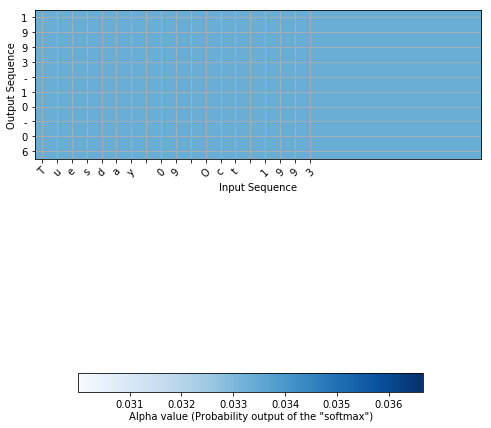

In [26]:
attention_map = plot_attention_map(model, human_vocab, inv_machine_vocab, "Tuesday 09 Oct 1993", num = 7, n_s = 64)

On the generated plot you can observe the values of the attention weights for each character of the predicted output. 

In the date translation application, you may observe that most of the time attention helps predict the year, and hasn't much impact on predicting the day/month.